# Model error covariance estimation in weak-constraint 4DVar

We import several python libraries:

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import linalg as LA
from numpy import random as rd
from sklearn.metrics import mean_squared_error

#set a random seed 
rd.seed(11)

import math 

from tqdm.notebook import tnrange, tqdm_notebook #progress bars
import time

%matplotlib notebook
%matplotlib inline

np.set_printoptions(threshold=np.inf) #plot full matrices


We import several classes written in seperate python files (see the documentation within these files for further information):

In [2]:
from model import Model
from model import Lorenz96
from observations import Obs
from dataassimilation import DA_methods
from dataassimilation import WC4DVar
from qestimation import q_estimate
from qestimation import q_estimate_analysis
from qestimation import evolution_over_windows
from qestimation import confidence_interval

## Contents

1. [Twin experiments with the Lorenz96 model](#1.-Twin-experiments-with-the-Lorenz-96-model)<br>
     1.1 [Setup](#1.1-Setup)<br> 
     1.2 [Validation experiments](#1.2-Validation-experiments)<br> 
     1.3 [Data assimilation](#1.3-Data-assimilation)<br>      
2. [Model error covariance estimation](#2.-Model-error-covariance-estimation)<br>
     2.1 [Experiment 1: observe everything](#2.1-Experiment-1:-observe-everything)<br>
     2.2 [Experiment 2: partial observations in space](#2.2-Experiment-2:-partial-observations-in-space)<br>
     2.3 [Experiment 3: partial observations in time](#2.3-Experiment-3:-partial-observations-in-time)<br>
     2.4 [Experiment 4: partial observations in time and space](#2.4-Experiment-4:-partial-observations-in-time-and-space)




## 1. Twin experiments with the Lorenz 96 model 

### 1.1 Setup

#### Initial condition

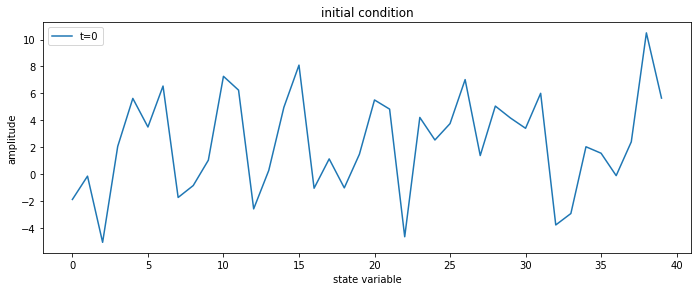

In [3]:
nr        = 40
nt        = 10
F         = 8
dt        = 0.01
my_Lorenz = Lorenz96(nr,F,dt)


u0     = F*np.ones(nr)
u0[0] += 0.01

for n in range(1000):
    u0 = my_Lorenz.step_rk4(u0) 
    
my_Lorenz.spatial_plot('initial condition',[0],u0)



#### Background

The initial background error covariance matrix is given by 
$$C_{b}(i,j)=\sigma_b^2 \exp\left(-\frac{(i-j)^2}{l_0^2}\right)$$
with variance $\sigma_b^2$ and correlation length $l_0$. 

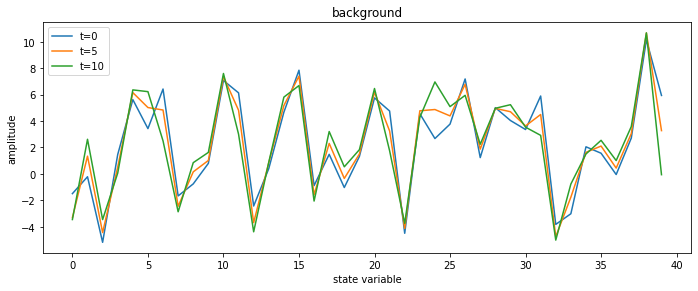

In [4]:
b_var     = 0.05
l0        = 0
Cb        = my_Lorenz.error_covariance('white',b_var,l0)
u_back    = np.zeros((nt+1,nr))
u_back[0] = u0.copy()+rd.multivariate_normal(np.zeros(nr), Cb)

for n in range(1,nt+1):
    u_back[n] = my_Lorenz.step_rk4(u_back[n-1]) 

my_Lorenz.spatial_plot('background',[0,5,10],u_back)

#### Truth

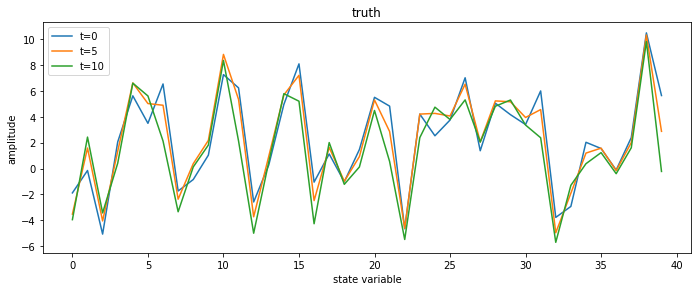

In [5]:
u_truth    = np.zeros((nt+1,nr))


q_var_truth = 0.1
Cq_truth    = my_Lorenz.error_covariance('spatial',q_var_truth,3)
u_truth[0]  = u0.copy()

for n in range(1,nt+1):
    u_truth[n] = my_Lorenz.step_rk4(u_truth[n-1])+rd.multivariate_normal(np.zeros(nr), Cq_truth)
    
# plots
my_Lorenz.spatial_plot('truth',[0,5,10],u_truth)

#### Observations

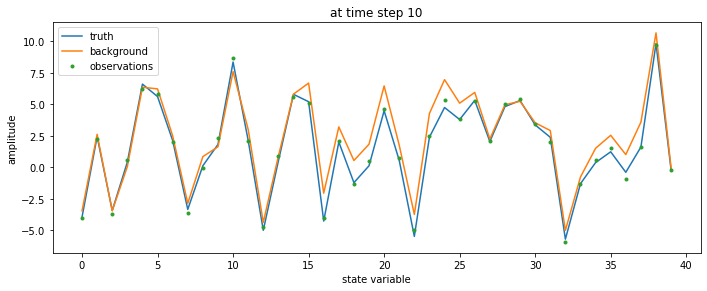

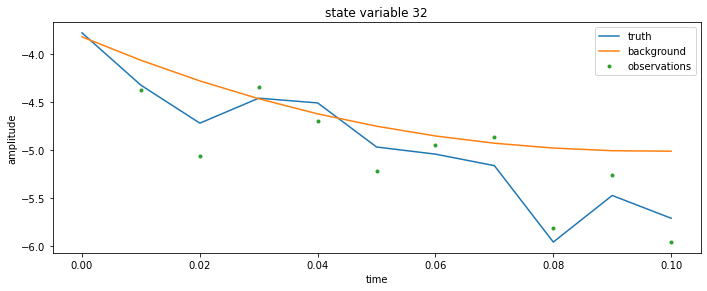

In [6]:
mr    = 40  # numbers of observations in space
mt    = 10  # numer of observations in time
dmr   = 1   # number of spatial gridpoints between  observations
dmt   = 1   # number of temporal gridpoints between observations

d_var = 0.05 # variance in observation error 


my_Obs = Obs(mr,mt,dmr,dmt,d_var,u_truth,0)

my_Lorenz.spatial_plot_observations(10,my_Obs,u_truth,u_back,nt)
my_Lorenz.temporal_plot_observations(32,my_Obs,u_truth,u_back,nt)

### 1.2 Validation experiments
Experiments to validate the implementation of the tangent linear model and adjoint model. 

The realtive error 
$$E_R=\frac{\|M(u+\gamma \delta u)-M(u)-\gamma \mathbf M[u] \delta u\|}{\|\gamma \mathbf M[u] \delta u\|}$$
converges to zero as $\gamma \to 0$. More precisely, if we consider the Taylor series of $M$ around $u$ we have 
$$M(u+\gamma \delta u)=M(u)+\mathbf M[u] (\gamma \delta u)+\mathcal O(\gamma^2)$$ and thus for $\gamma$ small enough we should observe a linear relationship between $E_R$ and $\gamma$ as $\gamma \to 0$. 

The slope in the linear regression is estimated as 1.0000280728574602, i.e. there is a linear relationship between gamma and E_R for gamma going to zero.


Text(0, 0.5, '$E_R$')

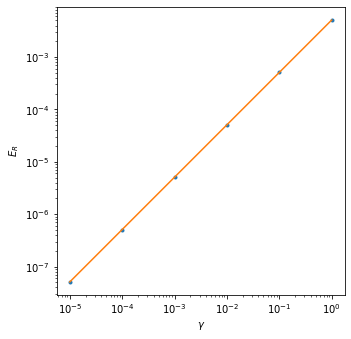

In [7]:
gamma   = np.array([1,10**(-1),10**(-2),10**(-3),10**(-4),10**(-5)])
num     = gamma.size
E_R     = np.zeros(num)
u_test  = u0
du_test = u0*0.1

for i in range(num):
    E_R[i] = LA.norm(my_Lorenz.step_rk4(u_test+gamma[i]*du_test)-my_Lorenz.step_rk4(u_test)-gamma[i]*my_Lorenz.TLM_step(u_test,du_test))/LA.norm(gamma[i]*my_Lorenz.TLM_step(u_test,du_test))


    
# simple linear regression
slope, intercept, r, p, std_err = stats.linregress(np.log(gamma), np.log(E_R))
mymodel = slope * np.log(gamma) + intercept
print(f'The slope in the linear regression is estimated as {slope}, i.e. there is a linear relationship between gamma and E_R for gamma going to zero.')


# plot 
fig  = plt.figure(figsize=(4, 4))
axes = fig.add_axes([1,1,1,1])
axes.plot(gamma,E_R,'.')
axes.plot(gamma,np.exp(mymodel))
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('$\gamma$')
axes.set_ylabel('$E_R$')

To validate the implementation of the adjoint model, we check whether the identity $$\langle Mx,Mx\rangle=\langle M^TMx,x\rangle$$ holds. 

In [8]:
mx  = my_Lorenz.TLM_step(u0,u0)
mmx = my_Lorenz.AM_step(u0, my_Lorenz.TLM_step(u0,u0))

lhs = np.inner(mx,mx)
rhs = np.inner(mmx,u0)

print(lhs==rhs)


True


### 1.3 Data assimilation

In [9]:
#Prescribed model error covariance for the DA 
q_var      = q_var_truth 
Cq_spatial = my_Lorenz.error_covariance('spatial',q_var,3)


Cq    = np.zeros((nr,nr,nt,nt))
for n in range(nt):
    Cq[:,:,n,n]=Cq_spatial


my_WC4DVar = WC4DVar('SD') # using steepest descent

#generate the analysis
u_analysis = my_WC4DVar.assimilate(my_Lorenz,nt,5,u_back[0],Cb,my_Obs,Cq)

Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 771
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [10.5774135  10.56260305 10.56332119 10.56322024 10.56325186]
Observation contribution to cost function [157.05817491 155.21283662 155.20762167 155.20809928 155.20791377]
Model contribution to cost function  [36.06469444 35.66856342 35.67251575 35.6721476  35.6722982 ]
The values of the cost function total [203.70028285 201.44400308 201.44345862 201.44346712 201.44346382]


In [10]:
my_WC4DVar.rms_compare(u_back,u_truth,u_analysis)

(0.6240184752705543, 0.11710940477305583)

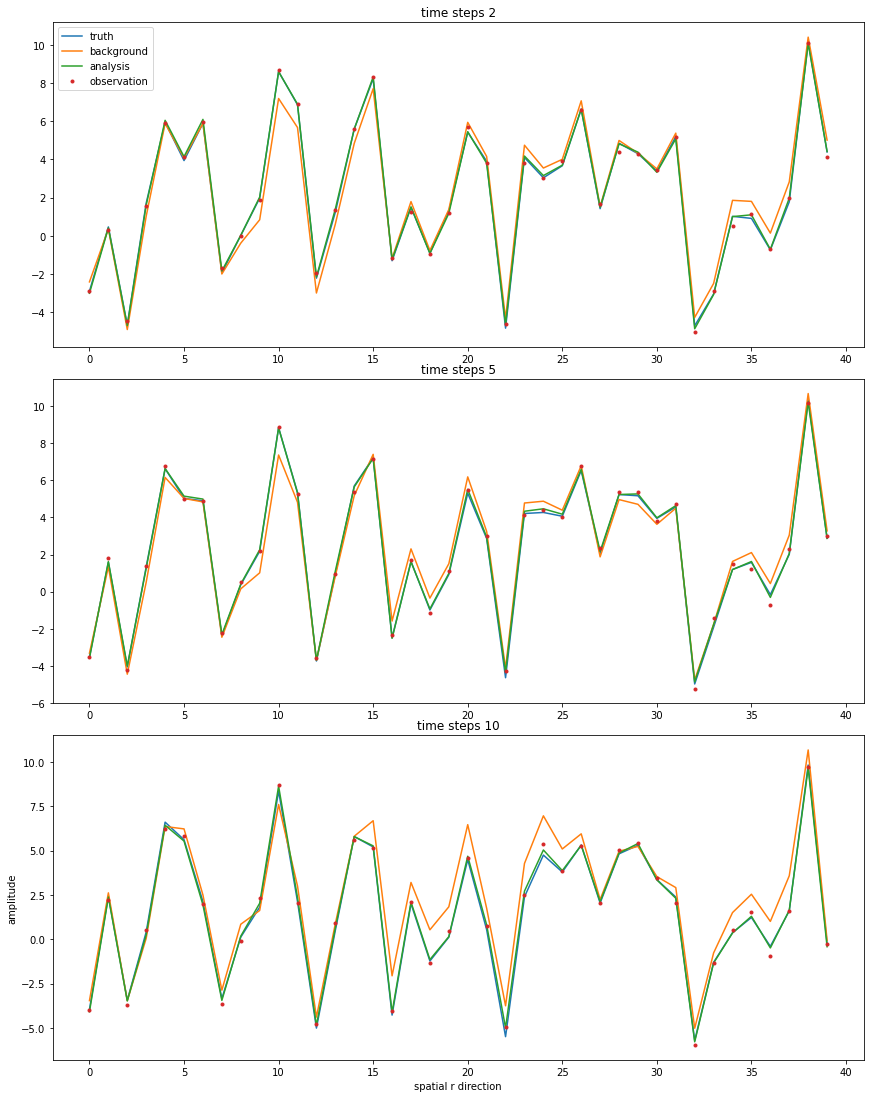

In [11]:
my_WC4DVar.plots_spatial(nt,u_truth,my_Obs,my_Lorenz,u_analysis,u_back,[2,5,10])

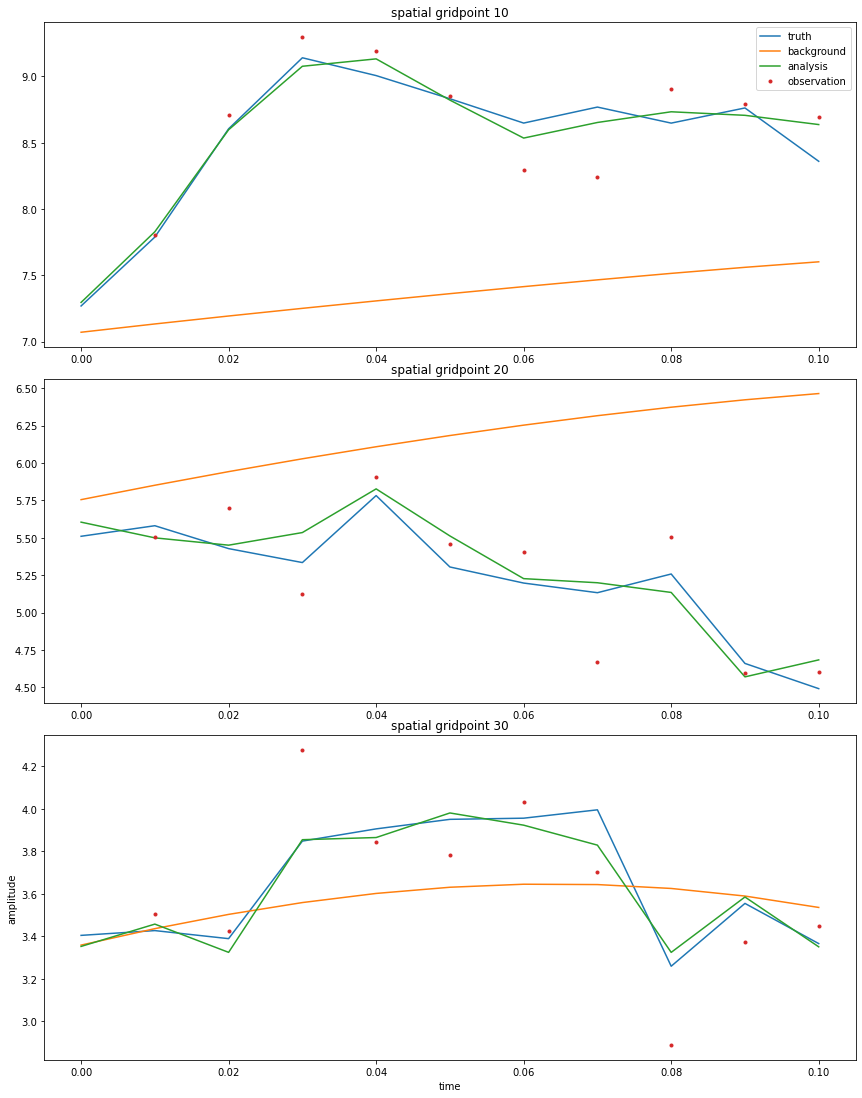

In [12]:
my_WC4DVar.plots_temporal(nt,u_truth,my_Obs,my_Lorenz,u_analysis,u_back,[10,20,30])

## 2. Model error covariance estimation
This section is independent of section 1. 

### 2.1 Experiment 1: observe everything

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 75
Number of inner iterations in outer iteration number 2: 25
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [135.82180729 135.86309534 135.86163576 135.86484323 135.86264358]
Observation contribution to cost function [683.53238424 683.48524667 683.49077576 683.48022896 683.48630822]
Model contribution to cost function  [793.74811242 793.53296728 793.52890001 793.53623829 793.53235239]
The values of the cost function total [1613.10230396 1612.8813093  1612.88131153 1612.88131047 1612.88130419]
RMS between background/truth and analysis/truth [0.35693319 0.11183717]
New estimate for variance coming from assimilation window 0: 0.04125854832564941
New estimate for correlation length coming from assimilation window 0: 3.1289537973075445


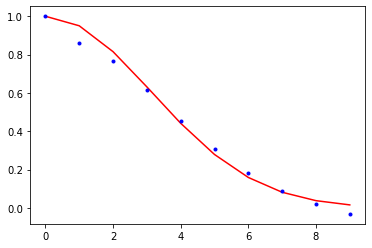

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 728
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.83025008 64.78609348 64.78800209 64.7878677  64.7877681 ]
Observation contribution to cost function [328.54013281 328.55581975 328.55560126 328.55578293 328.55597014]
Model contribution to cost function  [143.00833138 142.54424168 142.5425517  142.54250446 142.54241799]
The values of the cost function total [536.37871427 535.88615491 535.88615506 535.88615508 535.88615624]
RMS between background/truth and analysis/truth [0.38472646 0.05993269]
New estimate for variance coming from assimilation window 1: 0.056866617208823425
New estimate for correlation length coming from assimilation window 1: 3.9206890994348793


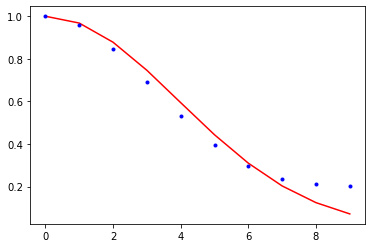

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 103
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.4918195  60.45546075 60.45611805 60.45610042 60.45609438]
Observation contribution to cost function [330.64777066 330.80693261 330.8068664  330.80685845 330.80684243]
Model contribution to cost function  [124.92587785 124.01564862 124.014938   124.01496173 124.01498266]
The values of the cost function total [516.06546801 515.27804198 515.27792246 515.27792059 515.27791947]
RMS between background/truth and analysis/truth [0.35516694 0.05857419]
New estimate for variance coming from assimilation window 2: 0.05561615141978167
New estimate for correlation length coming from assimilation window 2: 3.796772278668858


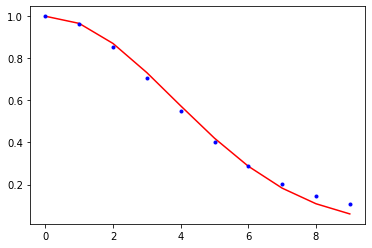

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 225
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.0934192  56.07679649 56.07732035 56.07733203 56.0773306 ]
Observation contribution to cost function [343.17791641 343.06256944 343.05939779 343.05940485 343.05939124]
Model contribution to cost function  [129.63817161 130.05381903 130.05588916 130.05586748 130.05588055]
The values of the cost function total [528.90950722 529.19318496 529.19260731 529.19260436 529.19260239]
RMS between background/truth and analysis/truth [0.31559974 0.05906987]
New estimate for variance coming from assimilation window 3: 0.047422750639391484
New estimate for correlation length coming from assimilation window 3: 3.01161801119759


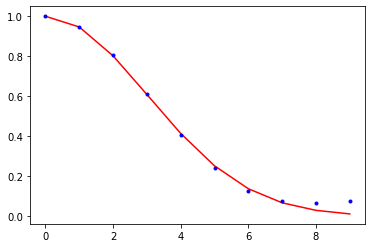

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 143
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [59.05328853 59.02043127 59.02116577 59.02114077 59.02114454]
Observation contribution to cost function [363.84229933 363.58338336 363.58275558 363.58280271 363.582788  ]
Model contribution to cost function  [139.34835057 139.326514   139.32621177 139.32618766 139.32619738]
The values of the cost function total [562.24393843 561.93032863 561.93013312 561.93013115 561.93012992]
RMS between background/truth and analysis/truth [0.31782162 0.05439937]
New estimate for variance coming from assimilation window 4: 0.04509718617286518
New estimate for correlation length coming from assimilation window 4: 2.441964026447884


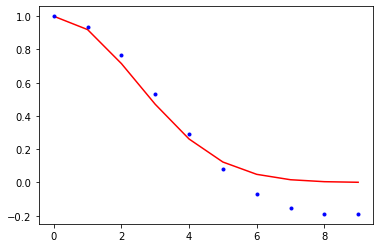

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 971
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.74009929 63.68895794 63.68940961 63.68940001 63.6893787 ]
Observation contribution to cost function [295.4952372  295.5804797  295.57941455 295.57947873 295.57958583]
Model contribution to cost function  [121.28731932 120.99411597 120.99470789 120.9946486  120.99456174]
The values of the cost function total [480.5226558  480.26355361 480.26353204 480.26352733 480.26352626]
RMS between background/truth and analysis/truth [0.29875874 0.05963514]
New estimate for variance coming from assimilation window 5: 0.04303773197803462
New estimate for correlation length coming from assimilation window 5: 3.046576572213295


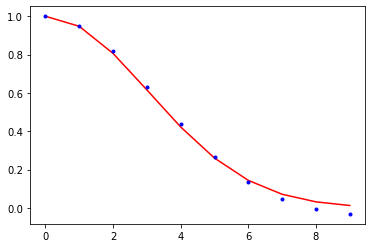

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 944
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.63639713 57.59957343 57.60059939 57.60051171 57.60044602]
Observation contribution to cost function [319.43858284 318.74759033 318.74470914 318.74521293 318.74554766]
Model contribution to cost function  [138.91649896 138.84821885 138.85007937 138.84966316 138.84939174]
The values of the cost function total [515.99147894 515.19538261 515.19538791 515.19538779 515.19538542]
RMS between background/truth and analysis/truth [0.33152793 0.05954602]
New estimate for variance coming from assimilation window 6: 0.052129910223068815
New estimate for correlation length coming from assimilation window 6: 3.48828145772092


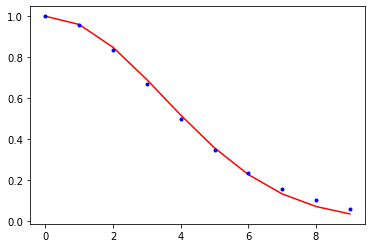

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 939
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.98546963 65.00394881 65.0061931  65.00610168 65.00599215]
Observation contribution to cost function [314.79881337 314.31430857 314.31044484 314.31065326 314.31090246]
Model contribution to cost function  [139.0536127  138.56927601 138.57085657 138.57073803 138.57059776]
The values of the cost function total [518.8378957  517.88753339 517.8874945  517.88749297 517.88749236]
RMS between background/truth and analysis/truth [0.3623328  0.06185564]
New estimate for variance coming from assimilation window 7: 0.05711758391911628
New estimate for correlation length coming from assimilation window 7: 2.934860634607758


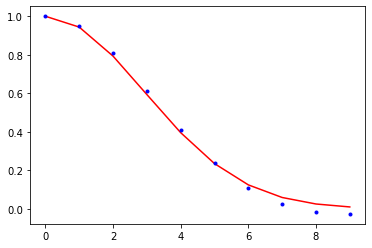

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 975
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.4000979  61.52350572 61.52589316 61.52578298 61.52569064]
Observation contribution to cost function [318.47944429 318.61928849 318.61700546 318.61718168 318.61729986]
Model contribution to cost function  [136.07425086 135.50107515 135.50097197 135.50090238 135.50087401]
The values of the cost function total [515.95379305 515.64386936 515.64387058 515.64386704 515.64386451]
RMS between background/truth and analysis/truth [0.32141073 0.05902475]
New estimate for variance coming from assimilation window 8: 0.0443421244809445
New estimate for correlation length coming from assimilation window 8: 2.5925801024608317


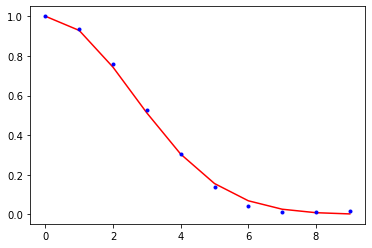

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 927
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.57961677 53.62660013 53.62763073 53.62760951 53.62755185]
Observation contribution to cost function [350.72838893 350.14742679 350.14557368 350.14570128 350.14586053]
Model contribution to cost function  [130.38186588 130.08879744 130.08956859 130.08946015 130.08935933]
The values of the cost function total [534.68987158 533.86282436 533.862773   533.86277094 533.86277171]
RMS between background/truth and analysis/truth [0.31976103 0.05553988]
New estimate for variance coming from assimilation window 9: 0.04660522349386468
New estimate for correlation length coming from assimilation window 9: 2.8303457891021466


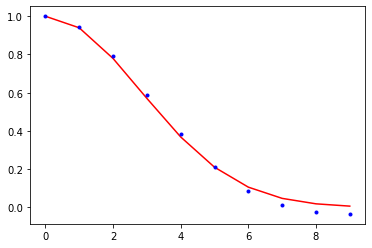

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 69
Number of inner iterations in outer iteration number 2: 21
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [95.34430496 95.37748336 95.37601776 95.37937504 95.37711325]
Observation contribution to cost function [542.4201349  542.1680408  542.17464547 542.16234886 542.16999276]
Model contribution to cost function  [648.96044293 649.74650973 649.74138124 649.75030992 649.74492571]
The values of the cost function total [1286.72488279 1287.29203389 1287.29204447 1287.29203383 1287.29203172]
RMS between background/truth and analysis/truth [0.32077031 0.09926898]
New estimate for variance coming from assimilation window 0: 0.03409760548987372
New estimate for correlation length coming from assimilation window 0: 3.529650021311174


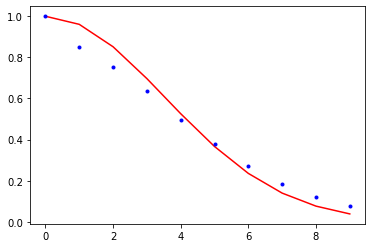

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 670
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.92184807 60.98025559 60.98155283 60.98141996 60.98130553]
Observation contribution to cost function [340.26640183 340.18674245 340.18466993 340.18524044 340.18557406]
Model contribution to cost function  [167.99791238 167.3065303  167.30731251 167.30687376 167.30665561]
The values of the cost function total [569.18616228 568.47352833 568.47353527 568.47353416 568.4735352 ]
RMS between background/truth and analysis/truth [0.31594674 0.06048581]
New estimate for variance coming from assimilation window 1: 0.05158244531545245
New estimate for correlation length coming from assimilation window 1: 3.295523623088173


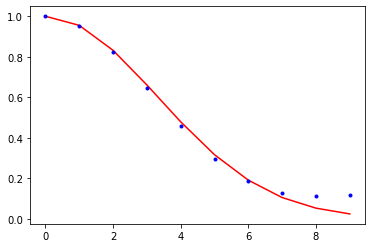

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 853
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [67.10938933 67.08567014 67.08652271 67.08652745 67.08652979]
Observation contribution to cost function [345.12273917 344.96913267 344.96764217 344.96749123 344.96775189]
Model contribution to cost function  [133.74399572 133.64163007 133.64226644 133.64241087 133.64214642]
The values of the cost function total [545.97612423 545.69643288 545.69643132 545.69642954 545.69642809]
RMS between background/truth and analysis/truth [0.29871693 0.0597481 ]
New estimate for variance coming from assimilation window 2: 0.04060006476442224
New estimate for correlation length coming from assimilation window 2: 2.8884735848290415


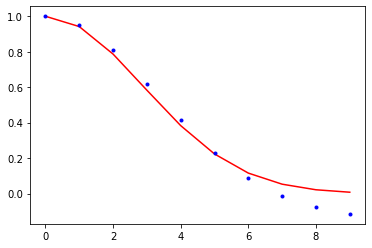

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 769
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [79.10376646 79.24450478 79.24655919 79.24644103 79.24632633]
Observation contribution to cost function [348.04605434 347.96731661 347.96439509 347.96483422 347.96515851]
Model contribution to cost function  [162.04348313 161.52306191 161.52392252 161.52359797 161.52338711]
The values of the cost function total [589.19330394 588.7348833  588.73487679 588.73487321 588.73487195]
RMS between background/truth and analysis/truth [0.31948964 0.05956573]
New estimate for variance coming from assimilation window 3: 0.05015097189476565
New estimate for correlation length coming from assimilation window 3: 3.110369905761219


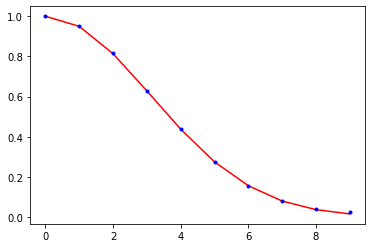

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 829
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.63422795 65.66194493 65.6632437  65.66316287 65.66308443]
Observation contribution to cost function [355.99911793 355.30760282 355.30514564 355.30550938 355.30582144]
Model contribution to cost function  [140.69631874 140.63722453 140.63836759 140.63808241 140.63784764]
The values of the cost function total [562.32966462 561.60677228 561.60675694 561.60675465 561.60675351]
RMS between background/truth and analysis/truth [0.32736726 0.05982886]
New estimate for variance coming from assimilation window 4: 0.05197067187707715
New estimate for correlation length coming from assimilation window 4: 3.0902770741217958


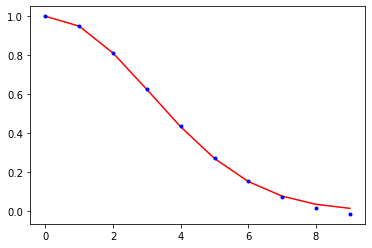

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 799
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [74.93812626 74.95713298 74.95938693 74.95921695 74.95908485]
Observation contribution to cost function [351.44032682 351.47390232 351.47018744 351.47054307 351.47083775]
Model contribution to cost function  [140.3323447  140.22459837 140.22604234 140.22585366 140.22568922]
The values of the cost function total [566.71079778 566.65563367 566.6556167  566.65561369 566.65561182]
RMS between background/truth and analysis/truth [0.33163281 0.05806323]
New estimate for variance coming from assimilation window 5: 0.05084672282579761
New estimate for correlation length coming from assimilation window 5: 3.5820819701823745


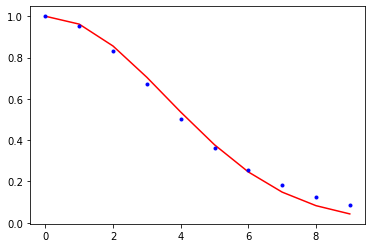

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 903
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.66117961 65.55045977 65.55293546 65.55280308 65.55268788]
Observation contribution to cost function [334.16558534 334.10430524 334.10114059 334.1014167  334.10163685]
Model contribution to cost function  [159.26174271 159.02164946 159.02233546 159.02219075 159.02208585]
The values of the cost function total [559.08850767 558.67641447 558.67641152 558.67641053 558.67641058]
RMS between background/truth and analysis/truth [0.32387216 0.05961531]
New estimate for variance coming from assimilation window 6: 0.05364766464356183
New estimate for correlation length coming from assimilation window 6: 3.057461047684226


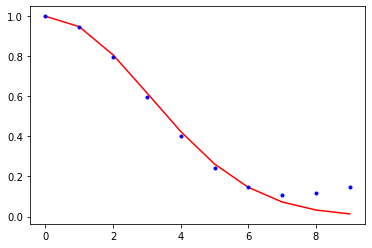

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 927
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.04806727 58.05320249 58.05469572 58.05464739 58.05457465]
Observation contribution to cost function [343.8749441  343.80354083 343.80154359 343.8016996  343.80188325]
Model contribution to cost function  [125.88277106 126.05472836 126.05523487 126.05511542 126.05499664]
The values of the cost function total [527.80578243 527.91147168 527.91147418 527.91146241 527.91145454]
RMS between background/truth and analysis/truth [0.29823257 0.05688133]
New estimate for variance coming from assimilation window 7: 0.04578155819594373
New estimate for correlation length coming from assimilation window 7: 2.4887365681379263


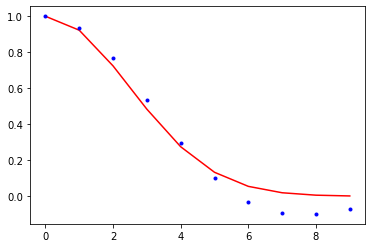

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 825
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [59.03434679 59.08321984 59.08465374 59.08451209 59.08439667]
Observation contribution to cost function [319.48874728 319.5365086  319.53468584 319.53508187 319.53529159]
Model contribution to cost function  [131.24064623 130.5424199  130.5428034  130.54254411 130.54244608]
The values of the cost function total [509.76374031 509.16214833 509.16214298 509.16213807 509.16213434]
RMS between background/truth and analysis/truth [0.30826227 0.05991803]
New estimate for variance coming from assimilation window 8: 0.04400776368341989
New estimate for correlation length coming from assimilation window 8: 3.644787132902338


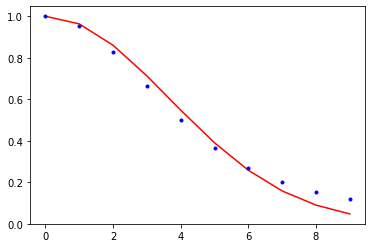

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 851
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.47671955 62.46155102 62.4638618  62.463766   62.46367225]
Observation contribution to cost function [335.16304383 334.978403   334.97586306 334.97601202 334.97615526]
Model contribution to cost function  [121.52445477 120.69528782 120.6955102  120.69545198 120.69540075]
The values of the cost function total [519.16421815 518.13524183 518.13523507 518.13522999 518.13522826]
RMS between background/truth and analysis/truth [0.32695648 0.05810506]
New estimate for variance coming from assimilation window 9: 0.04900162695578771
New estimate for correlation length coming from assimilation window 9: 2.969022550165614


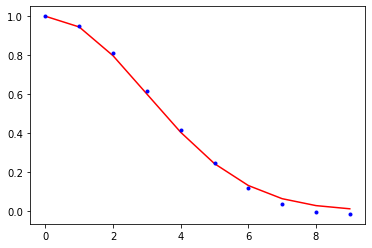

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 71
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [113.92972719 113.9573375  113.95854268 113.95987828 113.95931557]
Observation contribution to cost function [686.33615785 686.67959659 686.67344374 686.66989227 686.66822848]
Model contribution to cost function  [816.15745128 815.02578569 815.03073011 815.03294635 815.03516113]
The values of the cost function total [1616.42333632 1615.66271978 1615.66271653 1615.66271691 1615.66270518]
RMS between background/truth and analysis/truth [0.35585532 0.11285971]
New estimate for variance coming from assimilation window 0: 0.04452585269036546
New estimate for correlation length coming from assimilation window 0: 3.2845330394414365


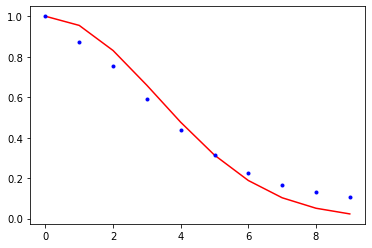

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 829
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.92411776 58.94138395 58.94289929 58.94280672 58.94273954]
Observation contribution to cost function [318.23935276 318.05482357 318.05242254 318.05271153 318.05288206]
Model contribution to cost function  [120.80421353 120.63587878 120.63677132 120.63657082 120.63646444]
The values of the cost function total [497.96768405 497.6320863  497.63209315 497.63208907 497.63208604]
RMS between background/truth and analysis/truth [0.27639362 0.05873152]
New estimate for variance coming from assimilation window 1: 0.03745270480763055
New estimate for correlation length coming from assimilation window 1: 3.7925088349301137


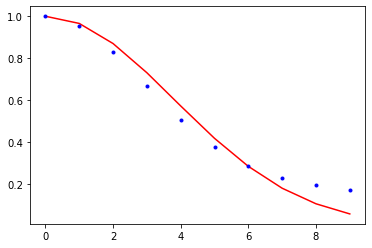

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 879
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [71.29806551 71.47984087 71.4832209  71.48299358 71.48277173]
Observation contribution to cost function [357.77349846 357.15133465 357.14634688 357.14722908 357.14792061]
Model contribution to cost function  [174.25860131 174.17364252 174.17521591 174.17455795 174.17408763]
The values of the cost function total [603.33016528 602.80481804 602.80478369 602.80478061 602.80477997]
RMS between background/truth and analysis/truth [0.3663     0.05993416]
New estimate for variance coming from assimilation window 2: 0.05696089020142978
New estimate for correlation length coming from assimilation window 2: 2.663086084091092


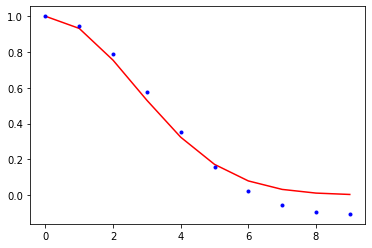

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 867
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [74.07799445 74.15500337 74.15635216 74.15629199 74.15624073]
Observation contribution to cost function [315.01368473 314.97079927 314.96919801 314.96933536 314.96946276]
Model contribution to cost function  [128.19007248 127.40658316 127.40684282 127.40676352 127.40668659]
The values of the cost function total [517.28175166 516.53238581 516.53239299 516.53239086 516.53239008]
RMS between background/truth and analysis/truth [0.28033657 0.05568578]
New estimate for variance coming from assimilation window 3: 0.04087610157867039
New estimate for correlation length coming from assimilation window 3: 2.7514073219360746


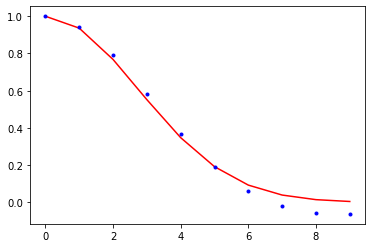

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 769
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.59708339 66.4358699  66.43841352 66.43822752 66.43810996]
Observation contribution to cost function [313.81904512 313.57120349 313.56771474 313.56800859 313.56822609]
Model contribution to cost function  [139.68078062 139.52018337 139.52113877 139.52102899 139.52092781]
The values of the cost function total [520.09690913 519.52725677 519.52726703 519.5272651  519.52726386]
RMS between background/truth and analysis/truth [0.31507077 0.0609459 ]
New estimate for variance coming from assimilation window 4: 0.05047800671183057
New estimate for correlation length coming from assimilation window 4: 2.657932190127921


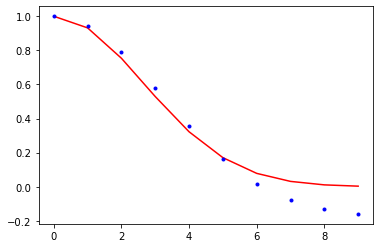

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 800
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.27930074 64.38832673 64.39057558 64.39039412 64.39026266]
Observation contribution to cost function [293.08025226 292.89200248 292.89021546 292.89048442 292.89065921]
Model contribution to cost function  [121.836996   121.46896955 121.46850313 121.4684132  121.46836857]
The values of the cost function total [479.196549   478.74929875 478.74929416 478.74929175 478.74929044]
RMS between background/truth and analysis/truth [0.313405   0.05734315]
New estimate for variance coming from assimilation window 5: 0.045719408682882934
New estimate for correlation length coming from assimilation window 5: 3.0195012606636027


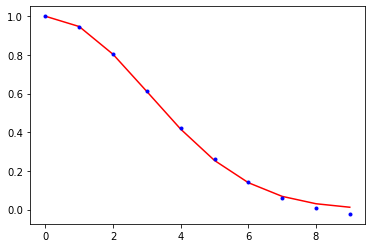

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 723
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.71264721 58.78039576 58.78148882 58.78144638 58.78139471]
Observation contribution to cost function [322.98097874 322.96251531 322.9610315  322.96123122 322.96140789]
Model contribution to cost function  [132.60307187 132.33565306 132.33603388 132.3358725  132.33574528]
The values of the cost function total [514.29669781 514.07856414 514.0785542  514.0785501  514.07854789]
RMS between background/truth and analysis/truth [0.31414781 0.05900996]
New estimate for variance coming from assimilation window 6: 0.05124601747273971
New estimate for correlation length coming from assimilation window 6: 3.3727681326407293


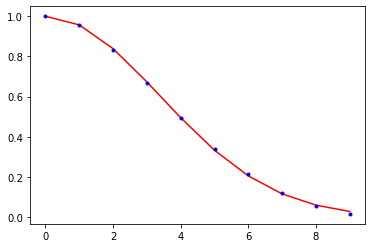

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 868
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [74.44188563 74.43592069 74.43903789 74.43884928 74.43871129]
Observation contribution to cost function [327.55169899 326.85865679 326.8548182  326.85520578 326.85547192]
Model contribution to cost function  [137.92205183 137.47386339 137.47456602 137.47436503 137.47423648]
The values of the cost function total [539.91563644 538.76844088 538.76842211 538.76842009 538.76841969]
RMS between background/truth and analysis/truth [0.32399719 0.05734016]
New estimate for variance coming from assimilation window 7: 0.0523150699335728
New estimate for correlation length coming from assimilation window 7: 2.8795937111569856


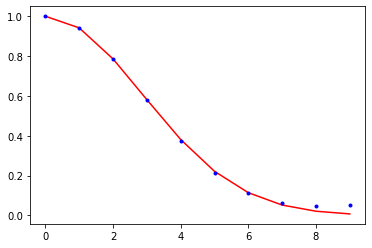

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 829
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.30593662 63.39908386 63.39992404 63.39988533 63.39983871]
Observation contribution to cost function [304.54743429 304.79061847 304.78854586 304.78881396 304.78901867]
Model contribution to cost function  [118.20593887 118.15013524 118.15137291 118.15114086 118.150981  ]
The values of the cost function total [486.05930977 486.33983756 486.33984281 486.33984015 486.33983838]
RMS between background/truth and analysis/truth [0.27588619 0.05798458]
New estimate for variance coming from assimilation window 8: 0.03816953146206334
New estimate for correlation length coming from assimilation window 8: 2.517956501734114


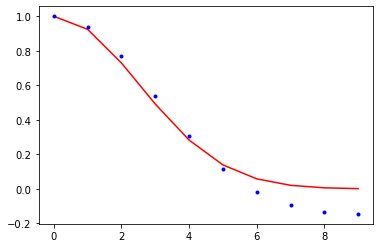

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 811
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.41450714 66.32476029 66.32718634 66.3270677  66.32697233]
Observation contribution to cost function [332.59618234 332.37775526 332.37495619 332.37525779 332.37552034]
Model contribution to cost function  [123.35459943 123.57261649 123.57298488 123.57279717 123.57262795]
The values of the cost function total [522.36528892 522.27513204 522.27512741 522.27512265 522.27512062]
RMS between background/truth and analysis/truth [0.31770788 0.06000679]
New estimate for variance coming from assimilation window 9: 0.04649038137905971
New estimate for correlation length coming from assimilation window 9: 2.689193836671589


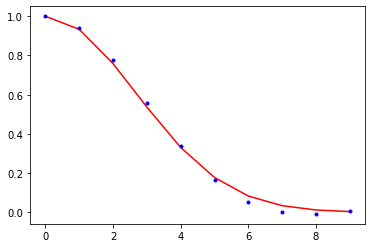

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 77
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 2
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [106.77615732 106.79351758 106.79498979 106.79480135 106.79466596]
Observation contribution to cost function [533.28437553 532.77360243 532.77126978 532.77505265 532.7733423 ]
Model contribution to cost function  [552.64289602 553.77068291 553.77154191 553.76794931 553.7697866 ]
The values of the cost function total [1192.70342887 1193.33780292 1193.33780148 1193.33780331 1193.33779485]
RMS between background/truth and analysis/truth [0.30651076 0.10150191]
New estimate for variance coming from assimilation window 0: 0.029092035103336036
New estimate for correlation length coming from assimilation window 0: 2.1769456323660075


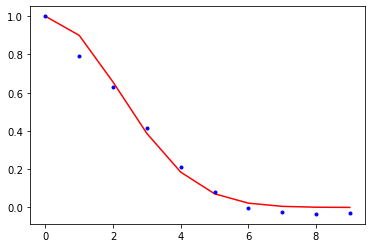

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 753
Number of inner iterations in outer iteration number 2: 303
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [34.7352905  34.68525222 34.68570525 34.6855703  34.68552055]
Observation contribution to cost function [306.08899207 306.02392471 306.02345642 306.02431529 306.02446427]
Model contribution to cost function  [194.99339268 194.82562035 194.82563231 194.82490654 194.82480826]
The values of the cost function total [535.81767525 535.53479729 535.53479398 535.53479213 535.53479309]
RMS between background/truth and analysis/truth [0.30072343 0.06199064]
New estimate for variance coming from assimilation window 1: 0.04340162003950088
New estimate for correlation length coming from assimilation window 1: 2.572829133714646


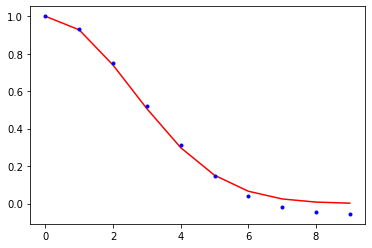

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 425
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.80027607 52.79305727 52.79414976 52.79400614 52.79390303]
Observation contribution to cost function [285.91096999 285.71995539 285.71965598 285.72019332 285.72051312]
Model contribution to cost function  [165.14940407 165.03731895 165.03651516 165.03611875 165.03590056]
The values of the cost function total [503.86065013 503.5503316  503.5503209  503.55031822 503.55031671]
RMS between background/truth and analysis/truth [0.33272478 0.06193291]
New estimate for variance coming from assimilation window 2: 0.05437372542226281
New estimate for correlation length coming from assimilation window 2: 3.2592722441703135


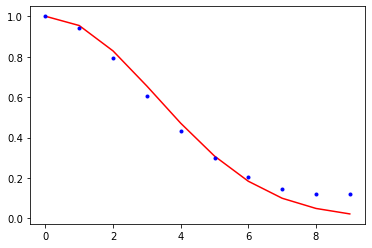

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 529
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [46.50104056 46.50397455 46.50468752 46.50462247 46.50457259]
Observation contribution to cost function [292.85700938 292.7284967  292.72721397 292.72728604 292.72731689]
Model contribution to cost function  [122.59271279 122.54410052 122.54467245 122.54466468 122.54468282]
The values of the cost function total [461.95076273 461.77657177 461.77657394 461.7765732  461.7765723 ]
RMS between background/truth and analysis/truth [0.28810299 0.05747697]
New estimate for variance coming from assimilation window 3: 0.04346172226457436
New estimate for correlation length coming from assimilation window 3: 2.7796009387428873


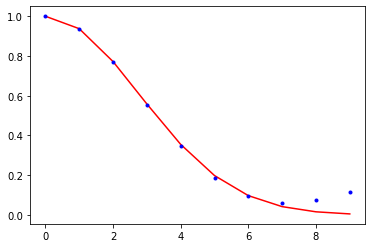

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 575
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.82025531 52.78614564 52.78770051 52.78758575 52.78747244]
Observation contribution to cost function [322.10398359 321.98385342 321.98139801 321.98192021 321.98229814]
Model contribution to cost function  [136.65246628 136.82423426 136.82513019 136.82472006 136.82445383]
The values of the cost function total [511.57670518 511.59423332 511.59422871 511.59422602 511.59422442]
RMS between background/truth and analysis/truth [0.28757227 0.06100838]
New estimate for variance coming from assimilation window 4: 0.04343591085783965
New estimate for correlation length coming from assimilation window 4: 2.5039949411626266


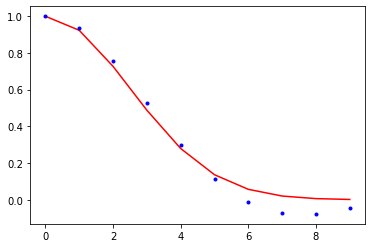

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 605
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.75494335 52.67837638 52.67983716 52.67974205 52.67963852]
Observation contribution to cost function [303.42819973 303.54836339 303.54703144 303.54745102 303.54774597]
Model contribution to cost function  [155.98571981 155.82089134 155.82075305 155.82042332 155.82022867]
The values of the cost function total [512.16886289 512.04763111 512.04762165 512.04761638 512.04761316]
RMS between background/truth and analysis/truth [0.33870781 0.06195243]
New estimate for variance coming from assimilation window 5: 0.05850313436471203
New estimate for correlation length coming from assimilation window 5: 2.9150799227130233


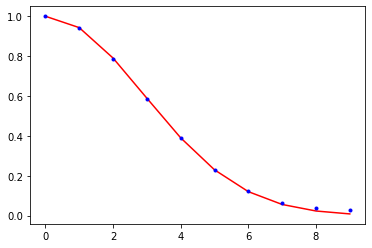

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 663
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.16774884 48.11563277 48.11581414 48.11577174 48.11574516]
Observation contribution to cost function [277.18755784 277.00447314 277.0031705  277.003505   277.0037196 ]
Model contribution to cost function  [126.08632441 125.9834772  125.98459251 125.9842959  125.98410549]
The values of the cost function total [451.44163108 451.10358311 451.10357715 451.10357263 451.10357025]
RMS between background/truth and analysis/truth [0.30920205 0.05981548]
New estimate for variance coming from assimilation window 6: 0.049694935886832305
New estimate for correlation length coming from assimilation window 6: 2.874242711042129


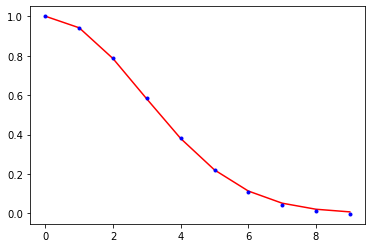

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 653
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.87110226 57.85148475 57.85260848 57.85252446 57.85243568]
Observation contribution to cost function [285.37280176 285.72300165 285.72211427 285.72232458 285.72249512]
Model contribution to cost function  [124.89991078 124.79183458 124.79159515 124.79146505 124.79138132]
The values of the cost function total [468.14381479 468.36632098 468.3663179  468.36631409 468.36631212]
RMS between background/truth and analysis/truth [0.3147093  0.05855144]
New estimate for variance coming from assimilation window 7: 0.04747532243086526
New estimate for correlation length coming from assimilation window 7: 3.26533382744503


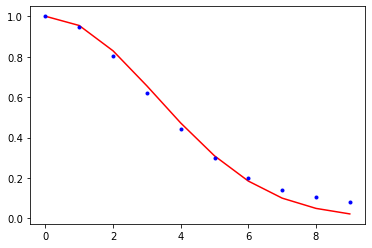

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 657
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.71929099 53.76068726 53.76167606 53.76160092 53.761538  ]
Observation contribution to cost function [305.48460246 305.34936147 305.34830352 305.34860414 305.34878214]
Model contribution to cost function  [121.22930167 121.05751344 121.05757741 121.05734886 121.05723163]
The values of the cost function total [480.43319512 480.16756216 480.16755699 480.16755393 480.16755177]
RMS between background/truth and analysis/truth [0.27426199 0.05778278]
New estimate for variance coming from assimilation window 8: 0.035608600436336874
New estimate for correlation length coming from assimilation window 8: 2.895271759791631


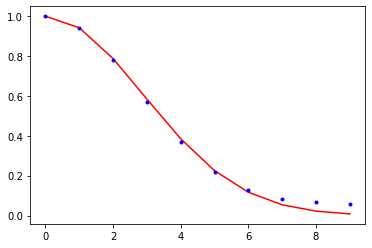

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 685
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.54315986 56.62443984 56.62577305 56.62568606 56.62561566]
Observation contribution to cost function [323.02686728 322.85554133 322.85400298 322.85424506 322.85445051]
Model contribution to cost function  [131.89442709 131.12884825 131.12904874 131.12888971 131.12875245]
The values of the cost function total [511.46445422 510.60882943 510.60882477 510.60882083 510.60881862]
RMS between background/truth and analysis/truth [0.32077434 0.05962959]
New estimate for variance coming from assimilation window 9: 0.04664496544009149
New estimate for correlation length coming from assimilation window 9: 2.6262116916595493


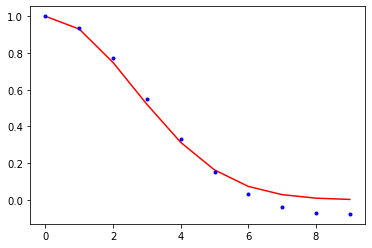

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 79
Number of inner iterations in outer iteration number 2: 25
Number of inner iterations in outer iteration number 3: 2
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [100.60387681 100.63385529 100.63600994 100.63528166 100.63568165]
Observation contribution to cost function [620.24273805 619.68021177 619.67596569 619.67521714 619.67685769]
Model contribution to cost function  [697.65287989 699.0791642  699.08125005 699.08273581 699.08067984]
The values of the cost function total [1418.49949475 1419.39323125 1419.39322568 1419.39323461 1419.39321919]
RMS between background/truth and analysis/truth [0.32010265 0.10438446]
New estimate for variance coming from assimilation window 0: 0.03648861893332884
New estimate for correlation length coming from assimilation window 0: 2.2673738626925366


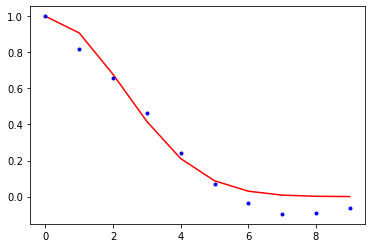

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 955
Number of inner iterations in outer iteration number 2: 431
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [47.49687424 47.48225915 47.483426   47.48333282 47.48325689]
Observation contribution to cost function [265.18602897 265.34224949 265.34110378 265.34143104 265.34164179]
Model contribution to cost function  [157.44071259 156.83629184 156.83626553 156.83602838 156.83589099]
The values of the cost function total [470.1236158  469.66080048 469.66079532 469.66079225 469.66078967]
RMS between background/truth and analysis/truth [0.32093196 0.05898181]
New estimate for variance coming from assimilation window 1: 0.04416206881112608
New estimate for correlation length coming from assimilation window 1: 2.674716241212469


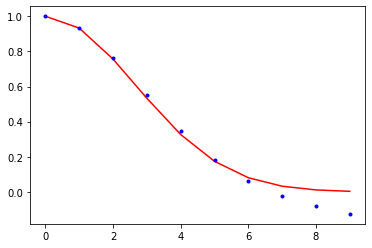

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 515
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [46.3686649  46.45861518 46.46008965 46.45991346 46.45979543]
Observation contribution to cost function [313.55943543 313.43147725 313.42907438 313.42960145 313.42991085]
Model contribution to cost function  [157.41317792 157.3272014  157.32812898 157.32777533 157.32758349]
The values of the cost function total [517.34127824 517.21729383 517.21729301 517.21729023 517.21728977]
RMS between background/truth and analysis/truth [0.33182698 0.05907907]
New estimate for variance coming from assimilation window 2: 0.05400749192871094
New estimate for correlation length coming from assimilation window 2: 2.861924433290319


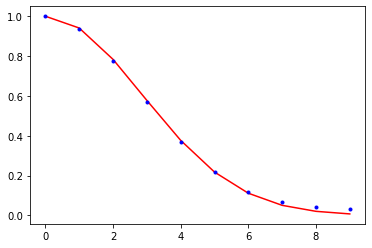

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 581
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.67734736 52.62260929 52.62411766 52.62399041 52.62387806]
Observation contribution to cost function [317.08196054 316.94185627 316.93950429 316.93992188 316.94025538]
Model contribution to cost function  [139.1716357  139.30967533 139.31050711 139.31021473 139.30999258]
The values of the cost function total [508.93094359 508.87414089 508.87412906 508.87412702 508.87412602]
RMS between background/truth and analysis/truth [0.31687545 0.05752585]
New estimate for variance coming from assimilation window 3: 0.05132852316362799
New estimate for correlation length coming from assimilation window 3: 2.921790476571221


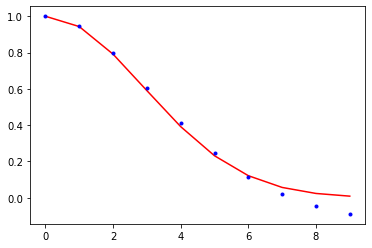

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 665
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.00860095 59.95305059 59.95431866 59.95422003 59.95413411]
Observation contribution to cost function [294.74281518 294.51591247 294.51319817 294.51375542 294.51409628]
Model contribution to cost function  [126.96031921 126.2899887  126.29142841 126.2909647  126.29070618]
The values of the cost function total [481.71173534 480.75895175 480.75894524 480.75894015 480.75893656]
RMS between background/truth and analysis/truth [0.34288319 0.0590332 ]
New estimate for variance coming from assimilation window 4: 0.0508314510569052
New estimate for correlation length coming from assimilation window 4: 4.033274206347421


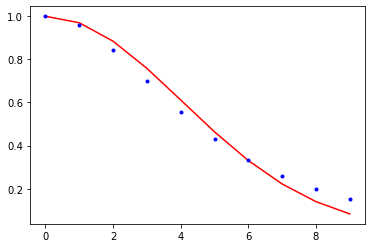

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 809
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.73107031 63.68931101 63.69096612 63.69088141 63.69079111]
Observation contribution to cost function [311.12671995 310.22627809 310.22284252 310.2233     310.22367859]
Model contribution to cost function  [138.90790516 138.85948094 138.86125957 138.86088455 138.86059461]
The values of the cost function total [513.76569543 512.77507004 512.77506821 512.77506596 512.77506431]
RMS between background/truth and analysis/truth [0.3109276  0.05962001]
New estimate for variance coming from assimilation window 5: 0.050303195746261326
New estimate for correlation length coming from assimilation window 5: 2.664708967868687


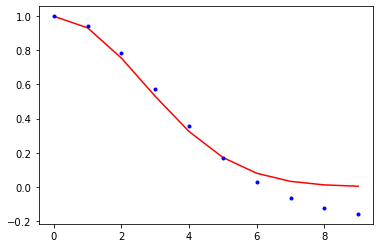

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 798
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [59.37076333 59.30299581 59.30433347 59.30424734 59.30418046]
Observation contribution to cost function [302.17981279 302.47488498 302.47305402 302.47326073 302.47337597]
Model contribution to cost function  [132.10510113 131.16847779 131.16895395 131.16883056 131.16878079]
The values of the cost function total [493.65567725 492.94635859 492.94634145 492.94633863 492.94633722]
RMS between background/truth and analysis/truth [0.3162271  0.05819366]
New estimate for variance coming from assimilation window 6: 0.044706450221997464
New estimate for correlation length coming from assimilation window 6: 2.9453881569422156


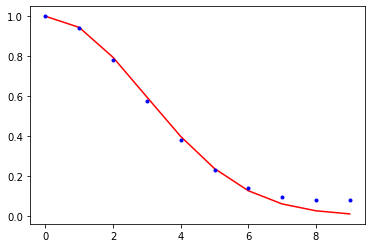

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 713
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.15739354 62.12604539 62.12658513 62.12655751 62.12652612]
Observation contribution to cost function [295.11263646 294.93032754 294.92953274 294.92966742 294.92979674]
Model contribution to cost function  [118.03712804 117.78781004 117.78805542 117.78795122 117.78785607]
The values of the cost function total [475.30715804 474.84418296 474.84417329 474.84417615 474.84417893]
RMS between background/truth and analysis/truth [0.30382427 0.05938583]
New estimate for variance coming from assimilation window 7: 0.0426712421381251
New estimate for correlation length coming from assimilation window 7: 2.762484293032691


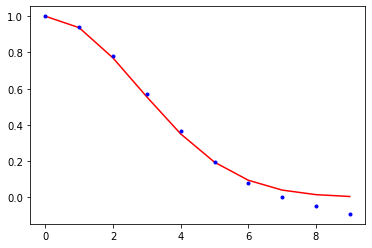

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 781
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.56702585 52.46369919 52.46510867 52.46500031 52.46491892]
Observation contribution to cost function [324.3323589  324.37700899 324.37641729 324.37662863 324.37673426]
Model contribution to cost function  [134.35093552 133.38031593 133.37949704 133.37938941 133.379363  ]
The values of the cost function total [511.25032027 510.22102411 510.221023   510.22101835 510.22101618]
RMS between background/truth and analysis/truth [0.33883707 0.05536598]
New estimate for variance coming from assimilation window 8: 0.052318176606022504
New estimate for correlation length coming from assimilation window 8: 3.3143462767783585


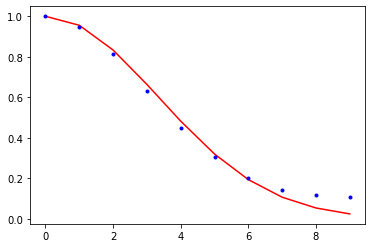

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 749
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.31479935 61.39817606 61.39929264 61.39920071 61.39910628]
Observation contribution to cost function [321.19846311 321.43040692 321.42945429 321.42971821 321.42990585]
Model contribution to cost function  [145.67373716 145.11448604 145.11431426 145.11413862 145.11404371]
The values of the cost function total [528.18699962 527.94306902 527.9430612  527.94305753 527.94305584]
RMS between background/truth and analysis/truth [0.36299671 0.05666113]
New estimate for variance coming from assimilation window 9: 0.0626294387688696
New estimate for correlation length coming from assimilation window 9: 3.1411862421252876


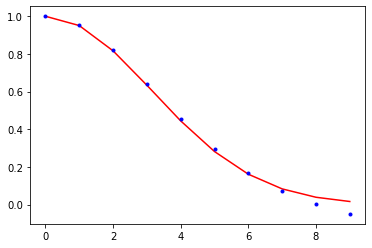

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 71
Number of inner iterations in outer iteration number 2: 21
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [110.09469123 110.16159992 110.16234559 110.16354921 110.16361943]
Observation contribution to cost function [623.6747817  623.25674552 623.26016376 623.25229373 623.25505071]
Model contribution to cost function  [661.19824401 662.12267083 662.11851961 662.12517027 662.12234479]
The values of the cost function total [1394.96771693 1395.54101627 1395.54102896 1395.54101321 1395.54101494]
RMS between background/truth and analysis/truth [0.33196582 0.10748748]
New estimate for variance coming from assimilation window 0: 0.03518316222995609
New estimate for correlation length coming from assimilation window 0: 3.4084700235099965


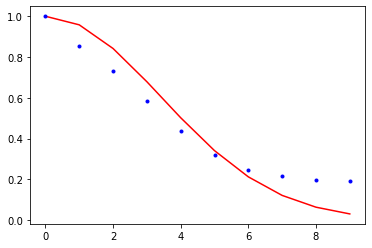

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 635
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [67.63974829 67.57584233 67.57810583 67.57794957 67.57782372]
Observation contribution to cost function [334.32225241 334.4238289  334.41994382 334.42035412 334.4206212 ]
Model contribution to cost function  [166.85310728 167.1436417  167.14526065 167.14500358 167.14486131]
The values of the cost function total [568.81510798 569.14331294 569.1433103  569.14330728 569.14330622]
RMS between background/truth and analysis/truth [0.31392225 0.06004572]
New estimate for variance coming from assimilation window 1: 0.04874401920108584
New estimate for correlation length coming from assimilation window 1: 2.7524137655391168


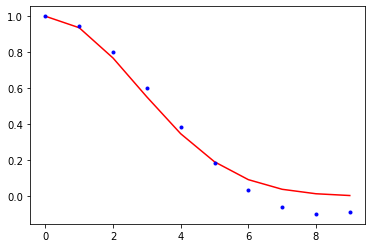

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 683
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.81602779 58.75558881 58.75678671 58.75670154 58.75663853]
Observation contribution to cost function [335.12039988 334.67668949 334.67458385 334.674836   334.67502708]
Model contribution to cost function  [134.26298258 133.60088973 133.60179453 133.60162687 133.60149794]
The values of the cost function total [528.19941025 527.03316803 527.03316509 527.03316441 527.03316355]
RMS between background/truth and analysis/truth [0.31876455 0.06090259]
New estimate for variance coming from assimilation window 2: 0.0456708432290995
New estimate for correlation length coming from assimilation window 2: 2.970302648277595


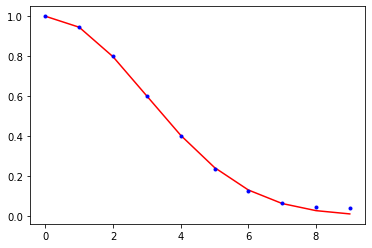

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 703
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [50.19392879 50.20772932 50.20834568 50.20830548 50.20826141]
Observation contribution to cost function [324.81400192 324.68732575 324.68617154 324.68642465 324.6866044 ]
Model contribution to cost function  [158.32646704 157.42871328 157.42923751 157.42902281 157.42888575]
The values of the cost function total [533.33439776 532.32376835 532.32375473 532.32375294 532.32375157]
RMS between background/truth and analysis/truth [0.35488867 0.05763773]
New estimate for variance coming from assimilation window 3: 0.0620403787632802
New estimate for correlation length coming from assimilation window 3: 2.9967187332255776


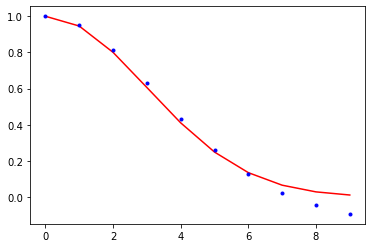

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 853
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [47.88149783 47.9543451  47.95585214 47.95574982 47.95567986]
Observation contribution to cost function [290.76569865 290.61435957 290.61236056 290.61266112 290.61283507]
Model contribution to cost function  [123.89020408 123.54156812 123.54205275 123.54185103 123.54174544]
The values of the cost function total [462.53740056 462.11027278 462.11026546 462.11026198 462.11026038]
RMS between background/truth and analysis/truth [0.28878156 0.05787889]
New estimate for variance coming from assimilation window 4: 0.04295358267562157
New estimate for correlation length coming from assimilation window 4: 3.3021259654685142


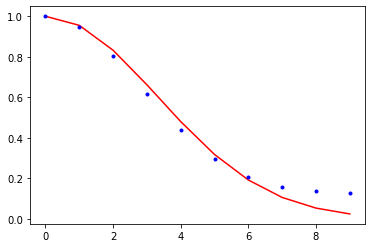

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 853
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.16420538 64.24844752 64.25006995 64.24996392 64.24986422]
Observation contribution to cost function [347.48278462 347.35557841 347.35386088 347.35410661 347.35430072]
Model contribution to cost function  [129.84158928 129.360853   129.3609331  129.3607917  129.36069607]
The values of the cost function total [541.48857928 540.96487893 540.96486393 540.96486223 540.96486101]
RMS between background/truth and analysis/truth [0.30333556 0.05879593]
New estimate for variance coming from assimilation window 5: 0.04550596043244021
New estimate for correlation length coming from assimilation window 5: 2.883004776031668


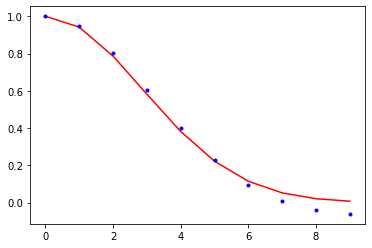

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 793
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.22854254 56.21646357 56.21741146 56.21734588 56.21729369]
Observation contribution to cost function [308.18256704 307.99455071 307.99253972 307.99283824 307.99302754]
Model contribution to cost function  [144.38403367 144.42116413 144.42221547 144.42198021 144.42184103]
The values of the cost function total [508.79514324 508.63217842 508.63216665 508.63216433 508.63216226]
RMS between background/truth and analysis/truth [0.31851807 0.05989375]
New estimate for variance coming from assimilation window 6: 0.05707715227702557
New estimate for correlation length coming from assimilation window 6: 3.201324879505732


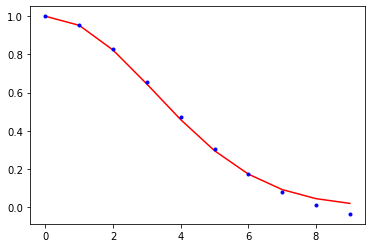

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 865
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [68.50956047 68.68199381 68.68277732 68.68268704 68.68260553]
Observation contribution to cost function [317.09761656 316.84245712 316.84080448 316.84114637 316.84142458]
Model contribution to cost function  [135.29843517 135.14916755 135.15002206 135.14976615 135.14956764]
The values of the cost function total [520.9056122  520.67361849 520.67360386 520.67359956 520.67359775]
RMS between background/truth and analysis/truth [0.33751607 0.05799238]
New estimate for variance coming from assimilation window 7: 0.053839351409656545
New estimate for correlation length coming from assimilation window 7: 3.5461255321615934


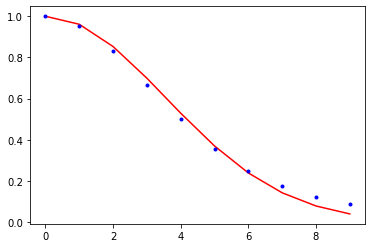

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 919
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.51899391 60.60205258 60.60322801 60.6031869  60.60312291]
Observation contribution to cost function [320.07775342 319.94486511 319.94347278 319.94371704 319.94396657]
Model contribution to cost function  [126.18932972 125.64174561 125.6419436  125.64173647 125.64154933]
The values of the cost function total [506.78607705 506.18866329 506.18864439 506.1886404  506.18863881]
RMS between background/truth and analysis/truth [0.34126625 0.05832668]
New estimate for variance coming from assimilation window 8: 0.04884183124925353
New estimate for correlation length coming from assimilation window 8: 2.9737170159018333


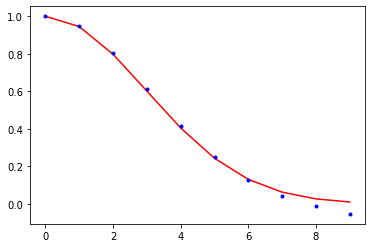

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 919
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.01942665 61.1076835  61.1087204  61.1086557  61.10860297]
Observation contribution to cost function [308.35165065 308.20033112 308.19775065 308.19802409 308.19823299]
Model contribution to cost function  [115.92295433 115.45525179 115.45678797 115.45657733 115.45642045]
The values of the cost function total [485.29403163 484.76326641 484.76325902 484.76325712 484.76325641]
RMS between background/truth and analysis/truth [0.27883967 0.05921055]
New estimate for variance coming from assimilation window 9: 0.03914746062130038
New estimate for correlation length coming from assimilation window 9: 2.527005981830412


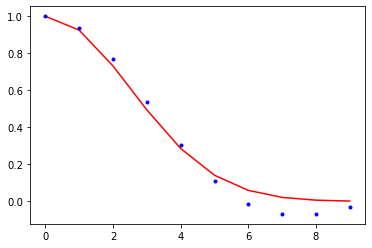

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 81
Number of inner iterations in outer iteration number 2: 25
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [100.5607552  100.55572193 100.55415525 100.55704061 100.55526272]
Observation contribution to cost function [604.33008676 603.91017784 603.91672308 603.90756179 603.91312497]
Model contribution to cost function  [701.2133629  702.09496277 702.08998693 702.09625695 702.09246852]
The values of the cost function total [1406.10420485 1406.56086253 1406.56086526 1406.56085934 1406.56085621]
RMS between background/truth and analysis/truth [0.3226999  0.10652468]
New estimate for variance coming from assimilation window 0: 0.033257604547531856
New estimate for correlation length coming from assimilation window 0: 2.3142552856179033


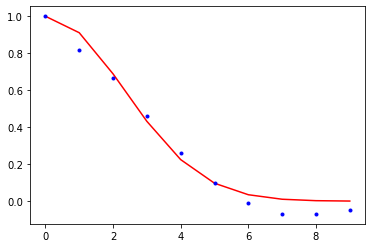

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 883
Number of inner iterations in outer iteration number 2: 369
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.61171509 48.54281728 48.543351   48.54326535 48.54320696]
Observation contribution to cost function [289.071934   289.1162761  289.11612063 289.11615136 289.1161499 ]
Model contribution to cost function  [155.43338891 155.0890589  155.08867277 155.08872573 155.08878416]
The values of the cost function total [493.117038   492.74815227 492.7481444  492.74814244 492.74814102]
RMS between background/truth and analysis/truth [0.30504247 0.05941904]
New estimate for variance coming from assimilation window 1: 0.047005728166462146
New estimate for correlation length coming from assimilation window 1: 3.1374367690631564


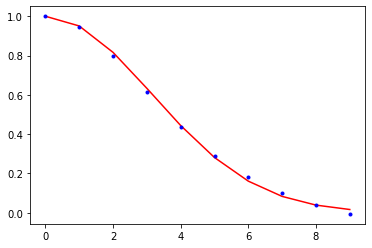

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 584
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.05886669 53.91045861 53.91188626 53.91175931 53.91166823]
Observation contribution to cost function [279.35245884 279.38316396 279.38070068 279.38112006 279.38134297]
Model contribution to cost function  [147.64162043 147.28364382 147.28467695 147.28438182 147.2842488 ]
The values of the cost function total [481.05294596 480.57726639 480.5772639  480.57726119 480.57726   ]
RMS between background/truth and analysis/truth [0.29905083 0.06052186]
New estimate for variance coming from assimilation window 2: 0.047301178101489996
New estimate for correlation length coming from assimilation window 2: 2.850030311361109


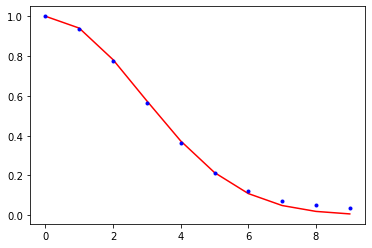

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 591
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.09201307 56.14084051 56.14165728 56.14161424 56.14156693]
Observation contribution to cost function [305.18877335 304.90976715 304.90884436 304.90901404 304.90915304]
Model contribution to cost function  [149.18022858 149.43828564 149.43839261 149.43826583 149.43817367]
The values of the cost function total [510.46101499 510.4888933  510.48889425 510.48889411 510.48889364]
RMS between background/truth and analysis/truth [0.31484039 0.0603812 ]
New estimate for variance coming from assimilation window 3: 0.04783473391587533
New estimate for correlation length coming from assimilation window 3: 2.6177636732925915


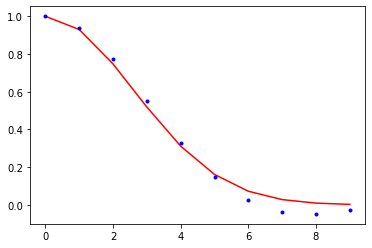

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 591
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [49.4741359  49.50528362 49.50615232 49.506134   49.50609253]
Observation contribution to cost function [309.31432592 309.52607353 309.52523952 309.52530317 309.52537301]
Model contribution to cost function  [137.87885884 137.242441   137.24237553 137.24232478 137.24229072]
The values of the cost function total [496.66732067 496.27379815 496.27376737 496.27376196 496.27375626]
RMS between background/truth and analysis/truth [0.3156995 0.0586831]
New estimate for variance coming from assimilation window 4: 0.04432271400940391
New estimate for correlation length coming from assimilation window 4: 2.5652766008923513


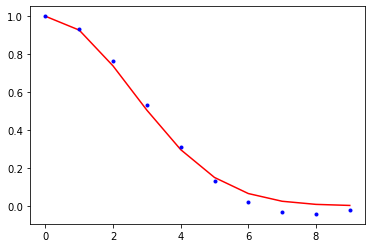

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 601
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [50.91332461 50.92887883 50.93019143 50.93010664 50.93002976]
Observation contribution to cost function [291.37014316 291.00409927 291.00314393 291.0032315  291.00329356]
Model contribution to cost function  [145.70052427 145.22898336 145.22863836 145.22863838 145.22865665]
The values of the cost function total [487.98399204 487.16196146 487.16197372 487.16197652 487.16197997]
RMS between background/truth and analysis/truth [0.33409077 0.06311282]
New estimate for variance coming from assimilation window 5: 0.06089356929972903
New estimate for correlation length coming from assimilation window 5: 3.0586866583942207


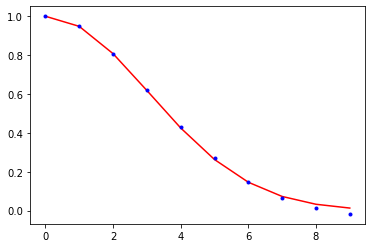

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 679
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.01681195 48.02329993 48.02454406 48.02446147 48.02439025]
Observation contribution to cost function [275.27579299 274.92212568 274.9212002  274.92151304 274.92173534]
Model contribution to cost function  [147.92188985 148.42121901 148.42090046 148.420668   148.42051543]
The values of the cost function total [471.2144948  471.36664462 471.36664472 471.36664252 471.36664102]
RMS between background/truth and analysis/truth [0.32519885 0.05461434]
New estimate for variance coming from assimilation window 6: 0.054831815544784585
New estimate for correlation length coming from assimilation window 6: 3.632365665329114


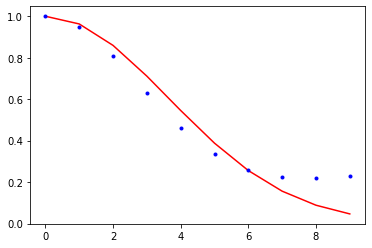

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 715
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.09717364 56.10874418 56.10978239 56.1097239  56.10966551]
Observation contribution to cost function [300.43463082 299.94549221 299.94362559 299.94381537 299.94396418]
Model contribution to cost function  [112.16079259 112.42279397 112.42361002 112.42347791 112.42338609]
The values of the cost function total [468.69259704 468.47703036 468.477018   468.47701718 468.47701578]
RMS between background/truth and analysis/truth [0.2676545 0.0564236]
New estimate for variance coming from assimilation window 7: 0.03652921632838881
New estimate for correlation length coming from assimilation window 7: 2.978105837483223


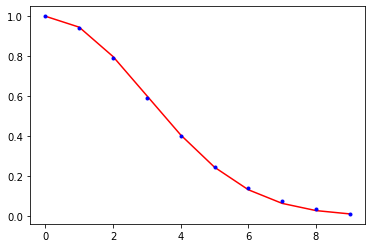

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 713
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.85113822 56.78611427 56.78776899 56.78767174 56.78757741]
Observation contribution to cost function [287.19925087 287.24626208 287.24449343 287.24476045 287.24500715]
Model contribution to cost function  [137.1361078  137.34872722 137.34881698 137.34864318 137.34848831]
The values of the cost function total [481.18649688 481.38110357 481.38107941 481.38107537 481.38107287]
RMS between background/truth and analysis/truth [0.32738608 0.05978678]
New estimate for variance coming from assimilation window 8: 0.04532122946121451
New estimate for correlation length coming from assimilation window 8: 2.8925170675735177


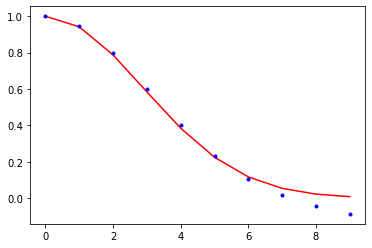

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 757
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.93918929 58.99578025 58.99686765 58.9967948  58.99672336]
Observation contribution to cost function [320.45582817 319.89507768 319.89281406 319.89319214 319.89349041]
Model contribution to cost function  [144.7935676  144.36162476 144.36278566 144.36247907 144.36225242]
The values of the cost function total [524.18858506 523.25248269 523.25246737 523.25246601 523.25246619]
RMS between background/truth and analysis/truth [0.33793692 0.05776991]
New estimate for variance coming from assimilation window 9: 0.0586455624674837
New estimate for correlation length coming from assimilation window 9: 3.215025286216277


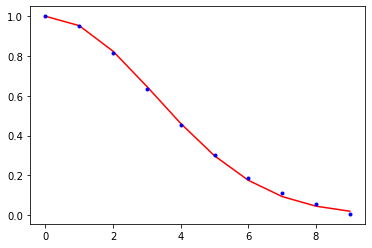

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 77
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [106.05624656 106.04946999 106.04881635 106.05117296 106.04952426]
Observation contribution to cost function [651.18575652 651.49269837 651.49432462 651.48629663 651.48999583]
Model contribution to cost function  [626.06786057 624.94250455 624.94152231 624.94719258 624.94513591]
The values of the cost function total [1383.30986364 1382.4846729  1382.48466328 1382.48466217 1382.484656  ]
RMS between background/truth and analysis/truth [0.3010252  0.10782898]
New estimate for variance coming from assimilation window 0: 0.029712021948108586
New estimate for correlation length coming from assimilation window 0: 2.9977104395406533


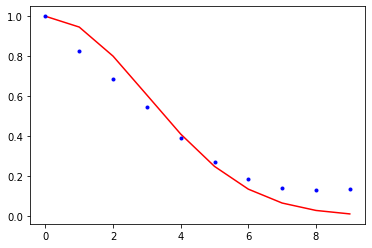

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 481
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.04983395 66.05904332 66.06118509 66.06098246 66.06080914]
Observation contribution to cost function [307.12661792 306.99601539 306.9947693  306.99512081 306.99540526]
Model contribution to cost function  [176.35371267 176.03276658 176.03186274 176.03171069 176.03159769]
The values of the cost function total [549.53016453 549.08782529 549.08781713 549.08781396 549.0878121 ]
RMS between background/truth and analysis/truth [0.36050083 0.0593533 ]
New estimate for variance coming from assimilation window 1: 0.05505184772796036
New estimate for correlation length coming from assimilation window 1: 3.199294995801632


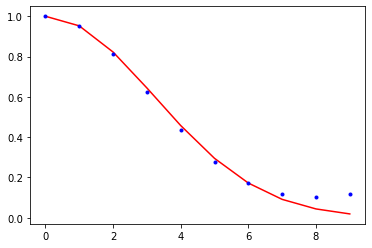

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 751
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [74.59621518 74.52552077 74.52634573 74.52630051 74.52625854]
Observation contribution to cost function [344.1209328  343.83370035 343.83293821 343.83297505 343.83302595]
Model contribution to cost function  [145.03715603 144.88671458 144.88663306 144.88663814 144.8866276 ]
The values of the cost function total [563.75430402 563.2459357  563.245917   563.2459137  563.24591209]
RMS between background/truth and analysis/truth [0.37401505 0.05519783]
New estimate for variance coming from assimilation window 2: 0.05725751521068665
New estimate for correlation length coming from assimilation window 2: 2.9713837398632172


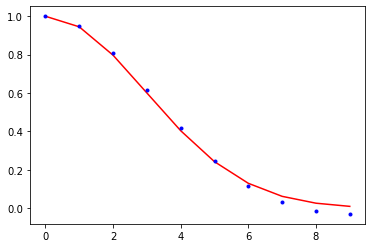

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 815
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [59.20023376 59.2556319  59.25650127 59.25645522 59.25641245]
Observation contribution to cost function [308.3295761  308.48344476 308.48173961 308.48206074 308.48229139]
Model contribution to cost function  [121.91798211 121.61329293 121.6141165  121.6138389  121.61364872]
The values of the cost function total [489.44779197 489.35236959 489.35235737 489.35235486 489.35235256]
RMS between background/truth and analysis/truth [0.3142244  0.05711895]
New estimate for variance coming from assimilation window 3: 0.046185497364210126
New estimate for correlation length coming from assimilation window 3: 2.9027399453676006


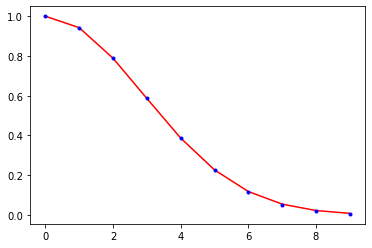

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 781
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.93973509 60.88543542 60.88683549 60.88675329 60.8866661 ]
Observation contribution to cost function [310.74421564 310.7018291  310.69869844 310.69905557 310.69937556]
Model contribution to cost function  [140.46397401 139.83392273 139.83567485 139.83539392 139.83515771]
The values of the cost function total [512.14792474 511.42118725 511.42120878 511.42120278 511.42119937]
RMS between background/truth and analysis/truth [0.31694318 0.05600114]
New estimate for variance coming from assimilation window 4: 0.05081804538434081
New estimate for correlation length coming from assimilation window 4: 2.6167455311270706


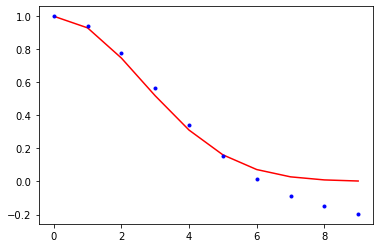

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 779
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.32610971 63.40685164 63.40775212 63.40775435 63.40768606]
Observation contribution to cost function [327.00852193 326.91769597 326.91579309 326.91608277 326.91630838]
Model contribution to cost function  [117.43066604 117.67969177 117.68067972 117.68038439 117.68022556]
The values of the cost function total [507.76529768 508.00423938 508.00422494 508.00422151 508.00422001]
RMS between background/truth and analysis/truth [0.28861847 0.05670213]
New estimate for variance coming from assimilation window 5: 0.0453638010567563
New estimate for correlation length coming from assimilation window 5: 2.905657170434836


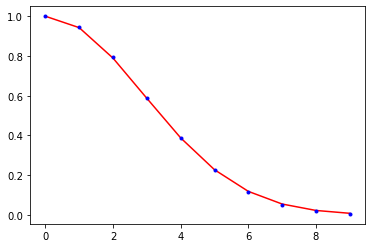

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 737
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.58404474 53.4970288  53.49824479 53.49818098 53.49813761]
Observation contribution to cost function [306.46759539 306.50673779 306.50585179 306.50592168 306.50598904]
Model contribution to cost function  [124.57791543 124.64027681 124.63995136 124.63994416 124.63991997]
The values of the cost function total [484.62955556 484.6440434  484.64404793 484.64404682 484.64404662]
RMS between background/truth and analysis/truth [0.30018088 0.05964279]
New estimate for variance coming from assimilation window 6: 0.040841955165839675
New estimate for correlation length coming from assimilation window 6: 2.9199687225911455


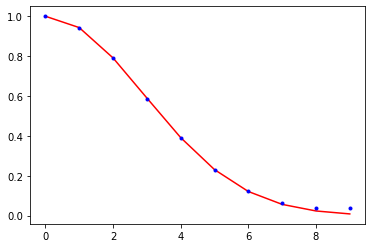

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 741
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [59.62501152 59.60500803 59.60601419 59.60596362 59.60596444]
Observation contribution to cost function [309.21038152 309.47448023 309.47334506 309.47343552 309.47268314]
Model contribution to cost function  [141.42180793 140.83531527 140.83542584 140.83538025 140.83613273]
The values of the cost function total [510.25720096 509.91480353 509.91478508 509.91477939 509.91478031]
RMS between background/truth and analysis/truth [0.29532585 0.06005931]
New estimate for variance coming from assimilation window 7: 0.04202263792655245
New estimate for correlation length coming from assimilation window 7: 2.6667113773704987


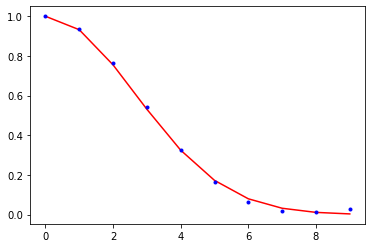

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 741
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [43.18692246 43.31962006 43.32093663 43.32081392 43.32072593]
Observation contribution to cost function [314.68806016 314.23316139 314.2307944  314.23114931 314.23143856]
Model contribution to cost function  [154.45521347 154.12721288 154.12825823 154.12802145 154.12781812]
The values of the cost function total [512.3301961  511.67999433 511.67998925 511.67998468 511.6799826 ]
RMS between background/truth and analysis/truth [0.33905559 0.06056676]
New estimate for variance coming from assimilation window 8: 0.06016504030066962
New estimate for correlation length coming from assimilation window 8: 2.766246707948252


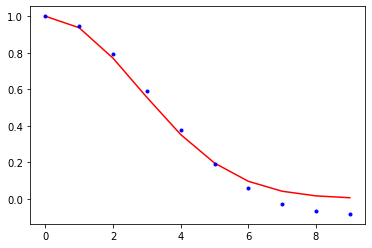

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 743
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.09350483 56.13969354 56.14112374 56.14104217 56.14095843]
Observation contribution to cost function [299.36924988 299.67793062 299.67711449 299.67718608 299.677242  ]
Model contribution to cost function  [121.36860303 120.77804797 120.77742687 120.77743284 120.77745858]
The values of the cost function total [476.83135774 476.59567212 476.5956651  476.59566109 476.59565901]
RMS between background/truth and analysis/truth [0.30008088 0.05523186]
New estimate for variance coming from assimilation window 9: 0.0434544122067805
New estimate for correlation length coming from assimilation window 9: 2.5489966597820115


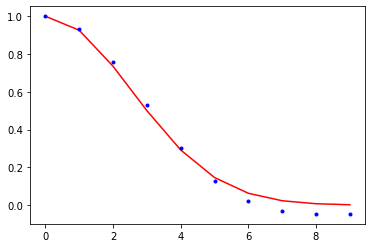

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 77
Number of inner iterations in outer iteration number 2: 21
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [74.4317296  74.45711142 74.45529683 74.4579452  74.45622518]
Observation contribution to cost function [611.73875845 611.46193878 611.46835732 611.45991256 611.4650771 ]
Model contribution to cost function  [569.86732882 570.49582876 570.49123329 570.49701721 570.49357354]
The values of the cost function total [1256.03781688 1256.41487895 1256.41488743 1256.41487496 1256.41487582]
RMS between background/truth and analysis/truth [0.28399535 0.10288849]
New estimate for variance coming from assimilation window 0: 0.028904400949261312
New estimate for correlation length coming from assimilation window 0: 2.9310813988510214


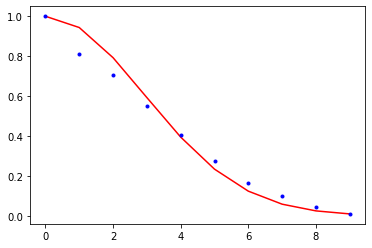

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 435
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.7874355  63.75504004 63.75664199 63.75648244 63.75632858]
Observation contribution to cost function [343.76519924 343.98101839 343.97962239 343.98009771 343.98043912]
Model contribution to cost function  [181.7541815  180.77968194 180.77945585 180.77913721 180.77894731]
The values of the cost function total [589.30681623 588.51574037 588.51572022 588.51571736 588.51571502]
RMS between background/truth and analysis/truth [0.30448788 0.06004373]
New estimate for variance coming from assimilation window 1: 0.04212818456459996
New estimate for correlation length coming from assimilation window 1: 2.624952670798657


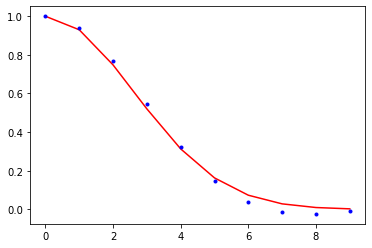

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 473
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.23668025 56.17565113 56.17677099 56.17670176 56.17664632]
Observation contribution to cost function [312.84610866 312.47807324 312.4770943  312.47734952 312.47755966]
Model contribution to cost function  [141.2963733  141.2661635  141.26601518 141.26582734 141.26567185]
The values of the cost function total [510.37916221 509.91988787 509.91988047 509.91987863 509.91987783]
RMS between background/truth and analysis/truth [0.32799974 0.06281824]
New estimate for variance coming from assimilation window 2: 0.04957758000282729
New estimate for correlation length coming from assimilation window 2: 3.440959492651841


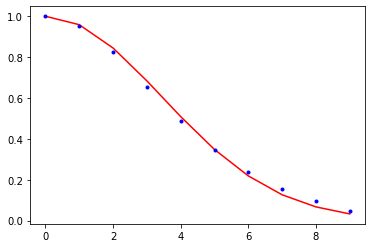

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 631
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.1493651  52.0250205  52.02609371 52.02600708 52.02595198]
Observation contribution to cost function [320.08376582 320.11482497 320.11342702 320.11363553 320.11380005]
Model contribution to cost function  [158.49328148 157.51208652 157.5124064  157.5122825  157.51217107]
The values of the cost function total [530.72641241 529.65193199 529.65192714 529.65192511 529.6519231 ]
RMS between background/truth and analysis/truth [0.33876154 0.05543594]
New estimate for variance coming from assimilation window 3: 0.05240540340544273
New estimate for correlation length coming from assimilation window 3: 3.075883425459043


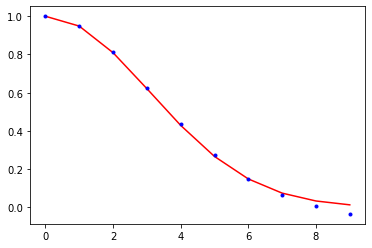

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 710
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.46936182 52.50788558 52.50877021 52.50870219 52.50864953]
Observation contribution to cost function [334.96529744 334.76091742 334.75869954 334.7589355  334.75907994]
Model contribution to cost function  [155.07345296 154.66066157 154.66198524 154.66181383 154.66172015]
The values of the cost function total [542.50811222 541.92946457 541.92945499 541.92945153 541.92944962]
RMS between background/truth and analysis/truth [0.35160643 0.06025927]
New estimate for variance coming from assimilation window 4: 0.06276051338850196
New estimate for correlation length coming from assimilation window 4: 2.951860248355204


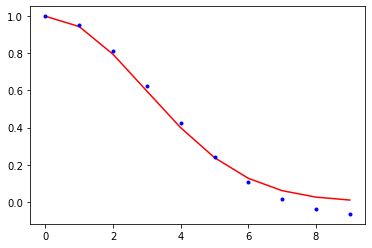

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 783
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.45246918 48.52188844 48.52250979 48.52249915 48.52246701]
Observation contribution to cost function [324.40738494 324.11468707 324.11443036 324.11451344 324.11461783]
Model contribution to cost function  [138.64428875 138.48990527 138.48953373 138.48945887 138.48938629]
The values of the cost function total [511.50414287 511.12648077 511.12647389 511.12647146 511.12647114]
RMS between background/truth and analysis/truth [0.30985425 0.05730792]
New estimate for variance coming from assimilation window 5: 0.05611392754409309
New estimate for correlation length coming from assimilation window 5: 3.1782726105631283


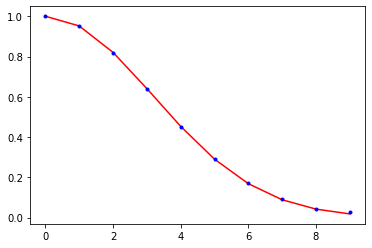

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 813
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.54934501 52.53225459 52.53374943 52.53366037 52.53359258]
Observation contribution to cost function [324.20123986 323.71121402 323.70948776 323.70963954 323.70978244]
Model contribution to cost function  [130.49123492 130.61361466 130.61385188 130.61378421 130.61370599]
The values of the cost function total [507.24181979 506.85708327 506.85708908 506.85708412 506.85708102]
RMS between background/truth and analysis/truth [0.3417394  0.05693952]
New estimate for variance coming from assimilation window 6: 0.052630696769923296
New estimate for correlation length coming from assimilation window 6: 2.9152591108925114


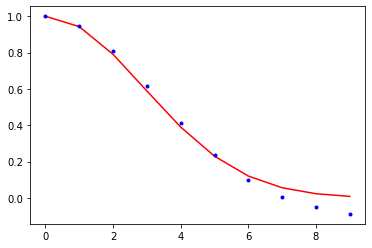

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 843
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.12804727 57.15301357 57.15401231 57.1539798  57.15391928]
Observation contribution to cost function [284.94118859 284.8214887  284.82062894 284.82077101 284.82091551]
Model contribution to cost function  [122.45367312 122.14434127 122.14419072 122.14407871 122.143994  ]
The values of the cost function total [464.52290898 464.11884355 464.11883198 464.11882952 464.11882879]
RMS between background/truth and analysis/truth [0.29473055 0.05709771]
New estimate for variance coming from assimilation window 7: 0.047132128661400256
New estimate for correlation length coming from assimilation window 7: 2.847241686910396


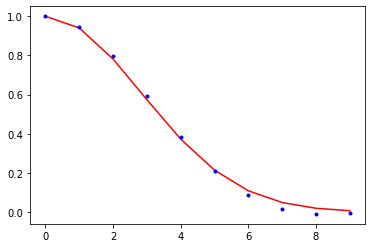

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 817
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.48968328 60.39542397 60.39674688 60.39666358 60.39659218]
Observation contribution to cost function [338.60322847 338.18703469 338.18478509 338.18507366 338.18530129]
Model contribution to cost function  [138.53429788 138.57913289 138.58007237 138.57986438 138.57970725]
The values of the cost function total [537.62720962 537.16159155 537.16160434 537.16160162 537.16160071]
RMS between background/truth and analysis/truth [0.2969336  0.05760795]
New estimate for variance coming from assimilation window 8: 0.044843360172751916
New estimate for correlation length coming from assimilation window 8: 2.914456764382179


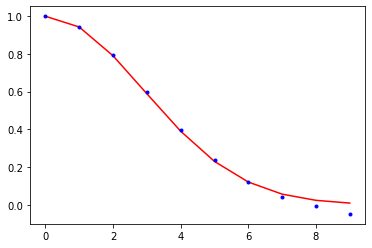

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 785
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.48964225 57.56615813 57.56700131 57.56696948 57.56690248]
Observation contribution to cost function [297.25630355 296.90262274 296.90180141 296.90209138 296.90235421]
Model contribution to cost function  [128.83996475 128.98368115 128.98364961 128.98339073 128.98319502]
The values of the cost function total [483.58591055 483.45246202 483.45245232 483.45245159 483.4524517 ]
RMS between background/truth and analysis/truth [0.34165683 0.05718189]
New estimate for variance coming from assimilation window 9: 0.05473269763829768
New estimate for correlation length coming from assimilation window 9: 3.6627164576968987


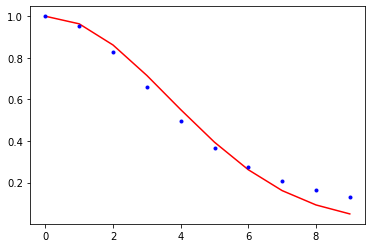

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 69
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [108.77884168 108.78686107 108.78680742 108.78893658 108.78803336]
Observation contribution to cost function [535.69069359 535.60104466 535.60439787 535.59556767 535.59891112]
Model contribution to cost function  [624.02214985 624.10067115 624.09737446 624.10406717 624.10162612]
The values of the cost function total [1268.49168513 1268.48857687 1268.48857975 1268.48857143 1268.48857061]
RMS between background/truth and analysis/truth [0.32969395 0.1038261 ]
New estimate for variance coming from assimilation window 0: 0.033799520670822154
New estimate for correlation length coming from assimilation window 0: 2.65321705709961


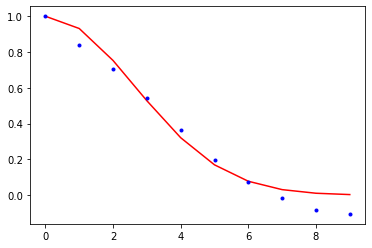

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 469
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.21766339 52.24550634 52.24717057 52.24700228 52.24685902]
Observation contribution to cost function [313.63950927 313.21829679 313.21581433 313.216449   313.21681762]
Model contribution to cost function  [167.18649364 167.67678692 167.67760529 167.6771399  167.67691648]
The values of the cost function total [533.0436663  533.14059004 533.1405902  533.14059117 533.14059312]
RMS between background/truth and analysis/truth [0.31896525 0.05889115]
New estimate for variance coming from assimilation window 1: 0.046037154720180516
New estimate for correlation length coming from assimilation window 1: 3.0989576551300093


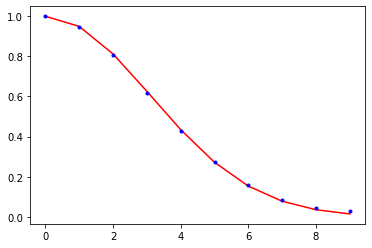

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 595
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.00538668 53.95389478 53.95573775 53.95559138 53.95546005]
Observation contribution to cost function [320.06247377 319.89399786 319.89052061 319.89102851 319.89139231]
Model contribution to cost function  [165.39542957 165.2610451  165.26266876 165.26230515 165.26207067]
The values of the cost function total [539.46329001 539.10893774 539.10892713 539.10892505 539.10892303]
RMS between background/truth and analysis/truth [0.31798927 0.05427035]
New estimate for variance coming from assimilation window 2: 0.050019759794447685
New estimate for correlation length coming from assimilation window 2: 3.4438711341912764


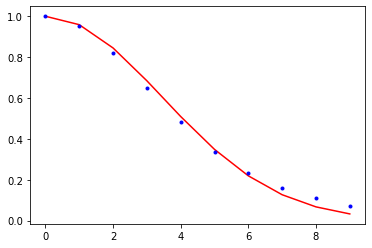

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 691
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [68.66109236 68.71986832 68.72105486 68.72098519 68.72092605]
Observation contribution to cost function [345.36481918 345.2127288  345.21109401 345.21123484 345.21135964]
Model contribution to cost function  [118.48497696 118.669288   118.66972234 118.66964976 118.66958408]
The values of the cost function total [532.51088849 532.60188512 532.60187122 532.60186979 532.60186976]
RMS between background/truth and analysis/truth [0.28422036 0.05852995]
New estimate for variance coming from assimilation window 3: 0.03891349882990594
New estimate for correlation length coming from assimilation window 3: 3.6597183610102073


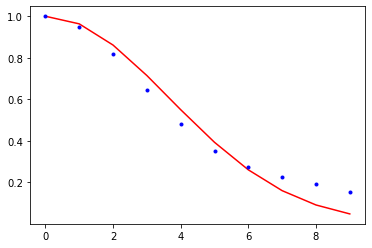

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 755
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.81035003 61.80656166 61.80845022 61.80831803 61.8082072 ]
Observation contribution to cost function [336.83684299 336.68041243 336.67786587 336.67846547 336.67881942]
Model contribution to cost function  [134.31436896 133.99760259 133.99825782 133.99778406 133.9975376 ]
The values of the cost function total [532.96156198 532.48457669 532.4845739  532.48456756 532.48456421]
RMS between background/truth and analysis/truth [0.30182993 0.06064109]
New estimate for variance coming from assimilation window 4: 0.045943696072907096
New estimate for correlation length coming from assimilation window 4: 2.8085678604714683


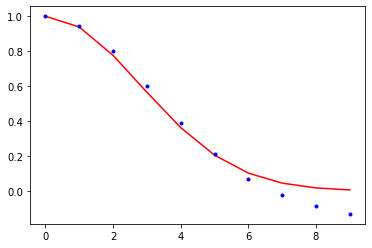

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 767
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [74.11028141 74.1414643  74.14369437 74.14355209 74.14345948]
Observation contribution to cost function [327.53340798 327.84371103 327.840235   327.84050131 327.84068662]
Model contribution to cost function  [124.38996195 123.46829762 123.46956134 123.46943584 123.46934183]
The values of the cost function total [526.03365134 525.45347295 525.45349071 525.45348924 525.45348793]
RMS between background/truth and analysis/truth [0.27915779 0.05916257]
New estimate for variance coming from assimilation window 5: 0.036225793236190816
New estimate for correlation length coming from assimilation window 5: 2.758171994140186


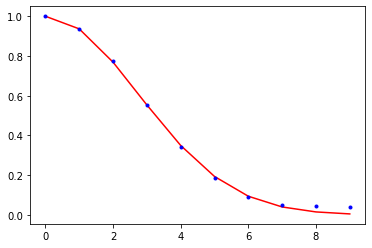

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 703
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [80.82993541 80.75559999 80.75813014 80.75797166 80.7578368 ]
Observation contribution to cost function [345.45294782 345.21323143 345.20995547 345.21035231 345.21065221]
Model contribution to cost function  [134.16786834 133.88048563 133.88121429 133.88097307 133.88080635]
The values of the cost function total [560.45075157 559.84931706 559.8492999  559.84929704 559.84929536]
RMS between background/truth and analysis/truth [0.31354361 0.0583698 ]
New estimate for variance coming from assimilation window 6: 0.042762036836601486
New estimate for correlation length coming from assimilation window 6: 2.9751352664796205


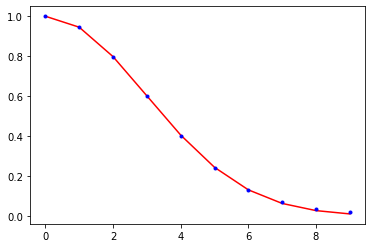

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 711
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.46800575 55.46435023 55.46556534 55.46546971 55.4653943 ]
Observation contribution to cost function [319.01793181 319.15840224 319.15728492 319.15760746 319.15781081]
Model contribution to cost function  [129.72398174 129.24243918 129.24233998 129.24211301 129.24198445]
The values of the cost function total [504.20991931 503.86519165 503.86519024 503.86519019 503.86518956]
RMS between background/truth and analysis/truth [0.31330732 0.05702052]
New estimate for variance coming from assimilation window 7: 0.04364898043787355
New estimate for correlation length coming from assimilation window 7: 2.5757976615935734


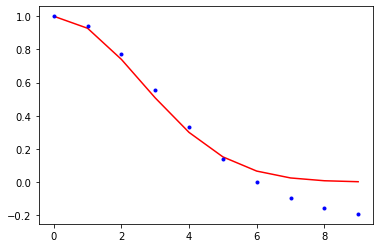

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 647
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.80977126 66.77916051 66.78054815 66.78049341 66.78043196]
Observation contribution to cost function [327.10333163 326.68208967 326.68149344 326.68164331 326.68173943]
Model contribution to cost function  [151.3741429  151.83395531 151.83316343 151.83306719 151.83303169]
The values of the cost function total [545.28724579 545.29520548 545.29520503 545.29520391 545.29520308]
RMS between background/truth and analysis/truth [0.32769487 0.05992874]
New estimate for variance coming from assimilation window 8: 0.051303256169935696
New estimate for correlation length coming from assimilation window 8: 3.500238579399415


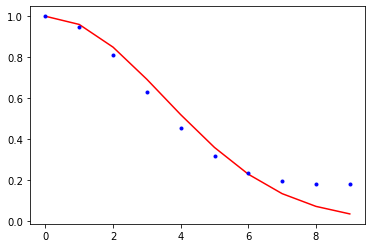

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 769
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.37464993 66.19592834 66.19733024 66.19723402 66.19716248]
Observation contribution to cost function [317.70109198 317.7825333  317.7807218  317.78100288 317.78114451]
Model contribution to cost function  [144.17403639 143.46812423 143.46852884 143.4683416  143.46826961]
The values of the cost function total [528.2497783  527.44658587 527.44658088 527.4465785  527.4465766 ]
RMS between background/truth and analysis/truth [0.3375404  0.05815842]
New estimate for variance coming from assimilation window 9: 0.05531937799651702
New estimate for correlation length coming from assimilation window 9: 3.3601712467079516


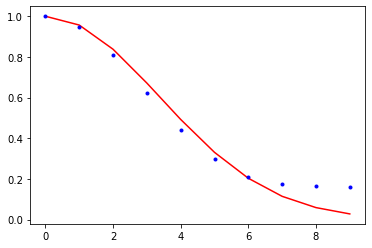

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 73
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [72.67450744 72.63966879 72.63851823 72.64096612 72.63912842]
Observation contribution to cost function [575.12668221 575.19418918 575.19693399 575.18981288 575.19401255]
Model contribution to cost function  [594.32979124 593.95250771 593.95090698 593.95558016 593.95321132]
The values of the cost function total [1242.13098089 1241.78636568 1241.78635919 1241.78635915 1241.78635228]
RMS between background/truth and analysis/truth [0.29549376 0.10360798]
New estimate for variance coming from assimilation window 0: 0.029356328171438885
New estimate for correlation length coming from assimilation window 0: 2.4130604222596643


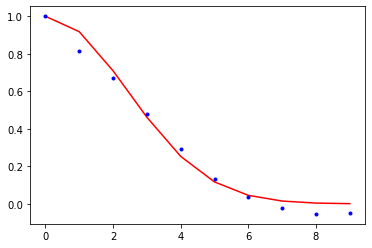

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 795
Number of inner iterations in outer iteration number 2: 385
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.53973912 48.53037316 48.53161827 48.53147178 48.53135479]
Observation contribution to cost function [290.5081612  290.68785886 290.68694619 290.68763943 290.68802752]
Model contribution to cost function  [219.40522    217.93094885 217.93060772 217.93005883 217.92978712]
The values of the cost function total [558.45312032 557.14918087 557.14917217 557.14917004 557.14916942]
RMS between background/truth and analysis/truth [0.35814663 0.0576897 ]
New estimate for variance coming from assimilation window 1: 0.05919774573996433
New estimate for correlation length coming from assimilation window 1: 3.639882099125273


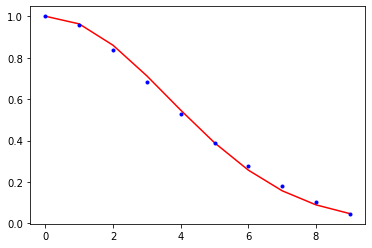

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 791
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.47065952 65.60346664 65.6061985  65.60600934 65.60584653]
Observation contribution to cost function [325.26789117 325.26797942 325.26430102 325.26495219 325.26533891]
Model contribution to cost function  [147.16966385 146.47289042 146.47382424 146.47335859 146.47313194]
The values of the cost function total [537.90821454 537.34433648 537.34432376 537.34432012 537.34431738]
RMS between background/truth and analysis/truth [0.35061632 0.05824735]
New estimate for variance coming from assimilation window 2: 0.0610810032542805
New estimate for correlation length coming from assimilation window 2: 3.492792666138144


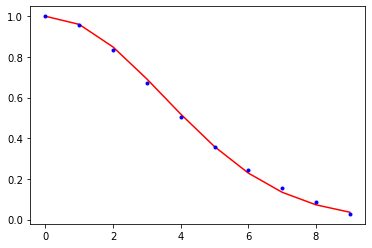

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 927
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.50027087 63.44509318 63.4464264  63.44637605 63.44633022]
Observation contribution to cost function [357.31001872 357.17268895 357.17129831 357.17136604 357.17144557]
Model contribution to cost function  [122.94411802 122.56488911 122.56496279 122.5649425  122.56490712]
The values of the cost function total [543.75440761 543.18267125 543.1826875  543.18268459 543.18268291]
RMS between background/truth and analysis/truth [0.31433069 0.05934734]
New estimate for variance coming from assimilation window 3: 0.054797788668659565
New estimate for correlation length coming from assimilation window 3: 3.4249351543502446


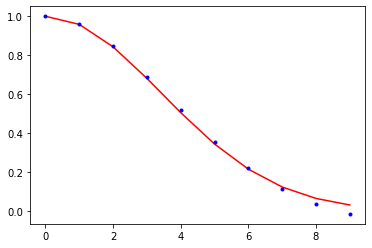

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [71.67747954 71.87412894 71.87617985 71.8760952  71.87601412]
Observation contribution to cost function [289.67122525 288.75463245 288.7514594  288.75161837 288.75176972]
Model contribution to cost function  [130.07507761 131.04464911 131.04574187 131.045664   131.04559088]
The values of the cost function total [491.4237824  491.6734105  491.67338112 491.67337758 491.67337472]
RMS between background/truth and analysis/truth [0.32791768 0.05774013]
New estimate for variance coming from assimilation window 4: 0.051333987649923064
New estimate for correlation length coming from assimilation window 4: 3.00550553500216


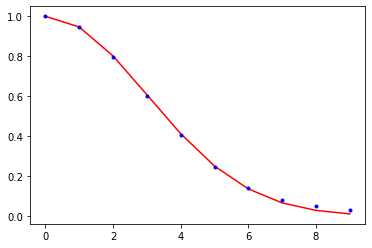

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 37
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.10449266 64.88722431 64.88843415 64.88836662 64.88834615]
Observation contribution to cost function [367.11345522 366.61659896 366.61590927 366.61599684 366.61599951]
Model contribution to cost function  [125.88170143 126.05289157 126.05231651 126.05229639 126.052313  ]
The values of the cost function total [558.09964931 557.55671485 557.55665993 557.55665984 557.55665867]
RMS between background/truth and analysis/truth [0.33591857 0.058589  ]
New estimate for variance coming from assimilation window 5: 0.0479536367422827
New estimate for correlation length coming from assimilation window 5: 2.729642111268332


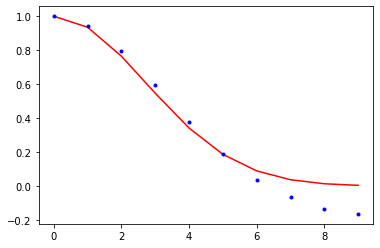

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 879
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [51.70786602 51.58722292 51.58923192 51.58907887 51.58895921]
Observation contribution to cost function [331.31511524 331.10500043 331.1031667  331.10347616 331.10376259]
Model contribution to cost function  [128.87340021 128.64819582 128.64801187 128.64785195 128.64768392]
The values of the cost function total [511.89638147 511.34041917 511.34041048 511.34040698 511.34040571]
RMS between background/truth and analysis/truth [0.38144986 0.05815711]
New estimate for variance coming from assimilation window 6: 0.0612355336246384
New estimate for correlation length coming from assimilation window 6: 5.358646068731134


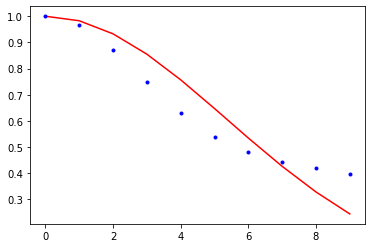

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 151
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.71585761 56.75017921 56.75092943 56.75088308 56.75088127]
Observation contribution to cost function [331.87477009 330.76139015 330.76036985 330.76040781 330.76041465]
Model contribution to cost function  [138.39704108 139.21417154 139.2140803  139.21408528 139.21407799]
The values of the cost function total [526.98766877 526.72574089 526.72537958 526.72537618 526.7253739 ]
RMS between background/truth and analysis/truth [0.33244685 0.05820064]
New estimate for variance coming from assimilation window 7: 0.05573471329681967
New estimate for correlation length coming from assimilation window 7: 2.6082970384138155


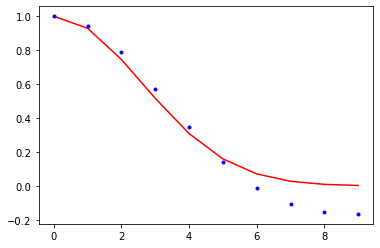

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 105
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.54535287 55.63334786 55.63357553 55.63354646 55.63354602]
Observation contribution to cost function [322.04255382 322.05315627 322.05203317 322.05206644 322.05205273]
Model contribution to cost function  [127.27993233 126.91364643 126.91441179 126.91440662 126.91441972]
The values of the cost function total [504.86783902 504.60015055 504.6000205  504.60001952 504.60001847]
RMS between background/truth and analysis/truth [0.29718453 0.0578118 ]
New estimate for variance coming from assimilation window 8: 0.04446183146158432
New estimate for correlation length coming from assimilation window 8: 2.8146328018599998


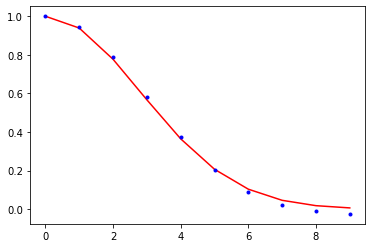

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 79
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.68862993 60.65993478 60.66060926 60.66058719 60.66057675]
Observation contribution to cost function [339.88590284 339.43489678 339.43416116 339.43418619 339.43418613]
Model contribution to cost function  [125.5694971  125.12003276 125.12001896 125.12001265 125.12002207]
The values of the cost function total [526.14402988 525.21486433 525.21478938 525.21478603 525.21478495]
RMS between background/truth and analysis/truth [0.32992256 0.06203122]
New estimate for variance coming from assimilation window 9: 0.05403015245016234
New estimate for correlation length coming from assimilation window 9: 3.3568838990785266


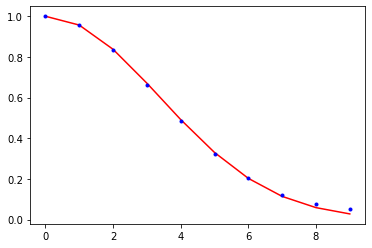

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 73
Number of inner iterations in outer iteration number 2: 25
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [115.61699898 115.58093194 115.58191653 115.58368002 115.58245968]
Observation contribution to cost function [596.87444522 597.28208903 597.28092454 597.27244038 597.27726938]
Model contribution to cost function  [679.89756922 678.59059776 678.59077944 678.59750025 678.59388414]
The values of the cost function total [1392.38901343 1391.45361873 1391.4536205  1391.45362065 1391.45361321]
RMS between background/truth and analysis/truth [0.32340127 0.10786332]
New estimate for variance coming from assimilation window 0: 0.03352480154448917
New estimate for correlation length coming from assimilation window 0: 3.0546284929465317


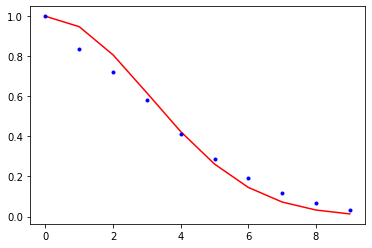

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 557
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [51.79850414 51.71536512 51.71717149 51.71703145 51.71691152]
Observation contribution to cost function [343.33820335 343.27271531 343.27099371 343.27137674 343.27163078]
Model contribution to cost function  [156.52432463 156.24587528 156.24580754 156.24556322 156.24542853]
The values of the cost function total [551.66103213 551.23395571 551.23397274 551.23397141 551.23397083]
RMS between background/truth and analysis/truth [0.35961773 0.05824371]
New estimate for variance coming from assimilation window 1: 0.051702363059428914
New estimate for correlation length coming from assimilation window 1: 3.0281593612005056


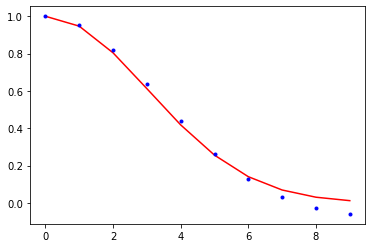

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 711
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.66339495 53.60402006 53.60566202 53.6055653  53.6054734 ]
Observation contribution to cost function [305.47877185 305.5809867  305.57918783 305.57946449 305.57967449]
Model contribution to cost function  [120.12270331 120.17019331 120.17035611 120.17017626 120.17005838]
The values of the cost function total [479.26487011 479.35520006 479.35520596 479.35520605 479.35520627]
RMS between background/truth and analysis/truth [0.32197753 0.05737469]
New estimate for variance coming from assimilation window 2: 0.04494821063014056
New estimate for correlation length coming from assimilation window 2: 2.9448227150944914


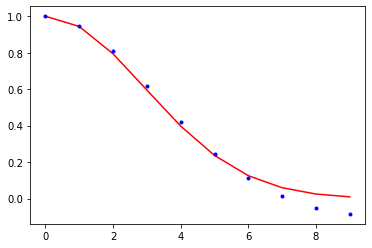

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 677
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.92907224 61.8531202  61.85439558 61.85433336 61.85428525]
Observation contribution to cost function [355.01734879 354.6844737  354.68276935 354.68289416 354.68299202]
Model contribution to cost function  [144.38665797 144.18716118 144.18756501 144.1874994  144.18744661]
The values of the cost function total [561.333079   560.72475508 560.72472994 560.72472692 560.72472388]
RMS between background/truth and analysis/truth [0.30671062 0.06070276]
New estimate for variance coming from assimilation window 3: 0.04370580397001875
New estimate for correlation length coming from assimilation window 3: 2.613271391961254


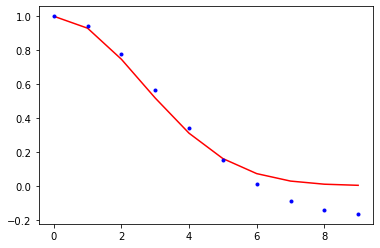

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 687
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [68.86045774 68.76772785 68.76983694 68.76965362 68.76952214]
Observation contribution to cost function [298.91092482 298.96727909 298.96446001 298.96501856 298.96537981]
Model contribution to cost function  [140.66533094 140.63565194 140.63633605 140.63595615 140.63572192]
The values of the cost function total [508.43671351 508.37065889 508.37063299 508.37062833 508.37062387]
RMS between background/truth and analysis/truth [0.31542723 0.05924934]
New estimate for variance coming from assimilation window 4: 0.04820150533737779
New estimate for correlation length coming from assimilation window 4: 3.0058775933195103


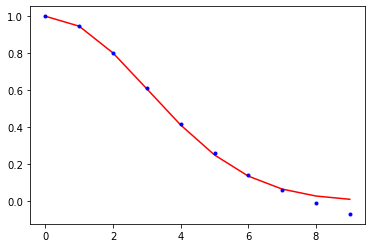

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 675
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.9512768  53.97140532 53.9732798  53.97311748 53.97301457]
Observation contribution to cost function [306.81499389 306.87693396 306.87512748 306.87540856 306.87558411]
Model contribution to cost function  [125.46265134 125.0734193  125.07335512 125.07323232 125.0731573 ]
The values of the cost function total [486.22892203 485.92175859 485.9217624  485.92175836 485.92175598]
RMS between background/truth and analysis/truth [0.28918162 0.05949458]
New estimate for variance coming from assimilation window 5: 0.04357685405733508
New estimate for correlation length coming from assimilation window 5: 2.7803423268656715


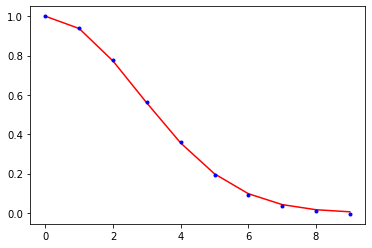

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 712
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [47.29956053 47.11789446 47.11958871 47.11942785 47.11931044]
Observation contribution to cost function [307.54549586 307.21914082 307.2162742  307.21681709 307.21712377]
Model contribution to cost function  [147.17526019 147.48407835 147.48523923 147.48485319 147.48466176]
The values of the cost function total [502.02031659 501.82111363 501.82110213 501.82109813 501.82109597]
RMS between background/truth and analysis/truth [0.3233858  0.05835067]
New estimate for variance coming from assimilation window 6: 0.060881962647338916
New estimate for correlation length coming from assimilation window 6: 2.8773716178905375


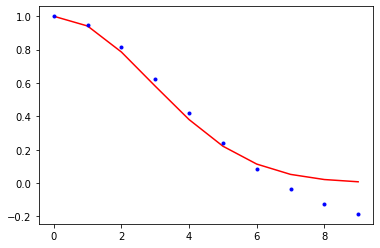

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 763
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.49980411 62.43494894 62.43687977 62.43681854 62.43673277]
Observation contribution to cost function [301.05529544 300.86373641 300.86173167 300.86190886 300.86207237]
Model contribution to cost function  [134.5682103  133.6401424  133.64020522 133.64008514 133.64000414]
The values of the cost function total [498.12330986 496.93882774 496.93881666 496.93881253 496.93880928]
RMS between background/truth and analysis/truth [0.40333905 0.05926454]
New estimate for variance coming from assimilation window 7: 0.06593336638809004
New estimate for correlation length coming from assimilation window 7: 3.053416552354982


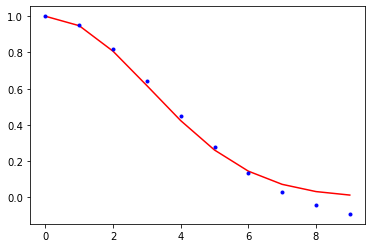

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 805
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.06183379 61.89634952 61.8981123  61.89800384 61.89792105]
Observation contribution to cost function [322.44684607 321.9931284  321.99027261 321.99085584 321.99128394]
Model contribution to cost function  [137.65413694 137.25565419 137.25673858 137.25626004 137.255913  ]
The values of the cost function total [522.16281681 521.1451321  521.1451235  521.14511972 521.14511799]
RMS between background/truth and analysis/truth [0.34541306 0.05970743]
New estimate for variance coming from assimilation window 8: 0.04818912538948292
New estimate for correlation length coming from assimilation window 8: 4.1335914722989


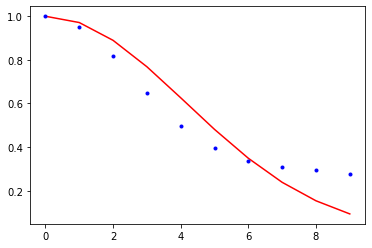

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 829
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.42295971 58.35340929 58.3546137  58.35453261 58.35446538]
Observation contribution to cost function [324.97570571 324.97940535 324.97770408 324.97790086 324.97806669]
Model contribution to cost function  [126.96365404 126.68955553 126.6900353  126.68991829 126.68981992]
The values of the cost function total [510.36231946 510.02237017 510.02235308 510.02235176 510.02235198]
RMS between background/truth and analysis/truth [0.29213487 0.05858745]
New estimate for variance coming from assimilation window 9: 0.040326082753289756
New estimate for correlation length coming from assimilation window 9: 3.2422617693799536


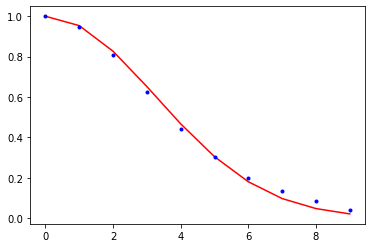

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 69
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [134.37181436 134.40501947 134.40374062 134.40923164 134.40530072]
Observation contribution to cost function [611.40817832 610.85494977 610.86021167 610.84507687 610.85565764]
Model contribution to cost function  [771.67091682 772.81273114 772.80875271 772.81839175 772.81173428]
The values of the cost function total [1517.4509095  1518.07270037 1518.07270501 1518.07270026 1518.07269263]
RMS between background/truth and analysis/truth [0.36251426 0.10586288]
New estimate for variance coming from assimilation window 0: 0.03909993661229608
New estimate for correlation length coming from assimilation window 0: 2.9267536763718263


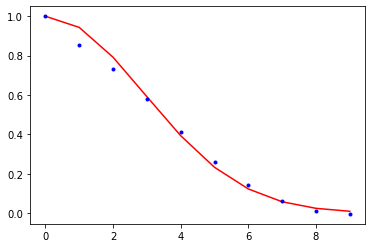

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 649
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.29680485 56.1819722  56.1834234  56.18334469 56.18326502]
Observation contribution to cost function [311.33050511 311.1880916  311.18473091 311.18489816 311.18507835]
Model contribution to cost function  [156.69068934 156.49451518 156.49641158 156.496321   156.4962195 ]
The values of the cost function total [524.3179993  523.86457898 523.86456588 523.86456386 523.86456288]
RMS between background/truth and analysis/truth [0.32266088 0.06468646]
New estimate for variance coming from assimilation window 1: 0.0494395834650075
New estimate for correlation length coming from assimilation window 1: 2.487555085302123


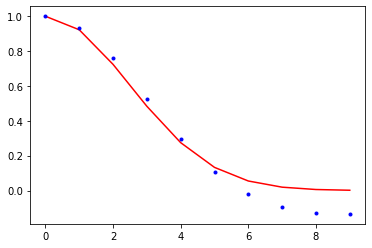

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 671
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.22912814 54.28254762 54.28378051 54.2837399  54.28368699]
Observation contribution to cost function [344.6854713  345.11374153 345.11264146 345.11279322 345.11284746]
Model contribution to cost function  [143.67582674 142.65866648 142.65853051 142.65841345 142.65840515]
The values of the cost function total [542.59042618 542.05495563 542.05495247 542.05494658 542.05493961]
RMS between background/truth and analysis/truth [0.38140335 0.05734487]
New estimate for variance coming from assimilation window 2: 0.07414352741528484
New estimate for correlation length coming from assimilation window 2: 4.418072664262899


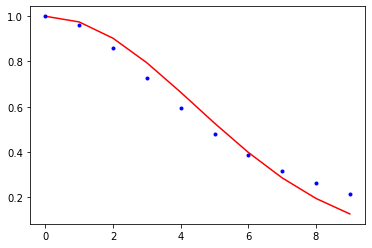

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 173
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.89337092 64.846265   64.84685892 64.8468482  64.84684867]
Observation contribution to cost function [320.09557531 320.62830289 320.62652381 320.62653232 320.62651525]
Model contribution to cost function  [111.55879841 110.11811692 110.11904469 110.11904612 110.11906129]
The values of the cost function total [496.54774464 495.59268481 495.59242742 495.59242664 495.59242521]
RMS between background/truth and analysis/truth [0.32005296 0.05855253]
New estimate for variance coming from assimilation window 3: 0.04601198549364771
New estimate for correlation length coming from assimilation window 3: 2.4839888035157927


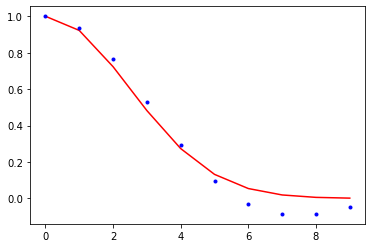

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 989
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.45698179 65.51757182 65.5198709  65.51979947 65.51969987]
Observation contribution to cost function [342.27612497 342.13579569 342.13277976 342.13309855 342.13337334]
Model contribution to cost function  [126.9140013  126.75288334 126.75359334 126.75334216 126.75316528]
The values of the cost function total [534.64710806 534.40625084 534.406244   534.40624017 534.4062385 ]
RMS between background/truth and analysis/truth [0.28968263 0.0555229 ]
New estimate for variance coming from assimilation window 4: 0.04495991530569324
New estimate for correlation length coming from assimilation window 4: 2.4759033631122507


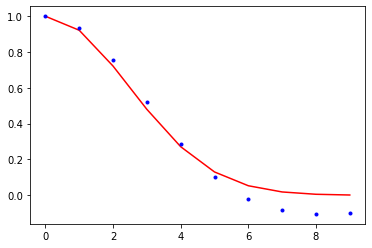

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 861
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [49.66493438 49.72505911 49.72561453 49.72555995 49.72551   ]
Observation contribution to cost function [297.03587607 296.87373958 296.87234062 296.87261461 296.87281508]
Model contribution to cost function  [111.14800184 110.97602729 110.97685706 110.97663441 110.9764822 ]
The values of the cost function total [457.84881229 457.57482598 457.57481221 457.57480898 457.57480728]
RMS between background/truth and analysis/truth [0.30084831 0.05688391]
New estimate for variance coming from assimilation window 5: 0.045945451537168745
New estimate for correlation length coming from assimilation window 5: 3.5072983900508667


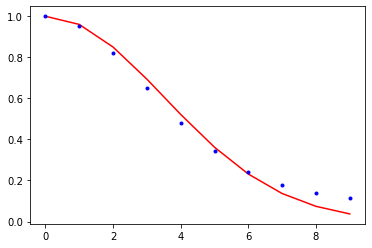

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 879
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.06974763 65.00152581 65.00353724 65.00342782 65.00332879]
Observation contribution to cost function [316.08740299 316.03266167 316.03024761 316.03047843 316.03068163]
Model contribution to cost function  [130.06206739 130.39074364 130.39111966 130.39099637 130.39089125]
The values of the cost function total [511.21921801 511.42493113 511.42490451 511.42490263 511.42490167]
RMS between background/truth and analysis/truth [0.33400948 0.05710091]
New estimate for variance coming from assimilation window 6: 0.05554322921055846
New estimate for correlation length coming from assimilation window 6: 3.850142960004461


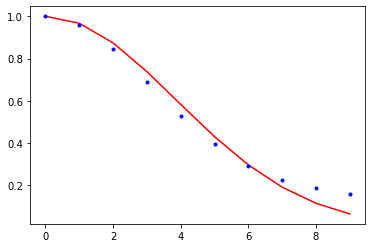

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 963
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [77.33086821 77.36026747 77.36221999 77.36202004 77.36192867]
Observation contribution to cost function [307.17278704 307.2507706  307.24766294 307.2481218  307.24829432]
Model contribution to cost function  [118.30165548 117.82002158 117.82118145 117.82092158 117.820839  ]
The values of the cost function total [502.80531073 502.43105964 502.43106438 502.43106343 502.43106199]
RMS between background/truth and analysis/truth [0.29361964 0.05781777]
New estimate for variance coming from assimilation window 7: 0.04429374903547087
New estimate for correlation length coming from assimilation window 7: 2.930379379834256


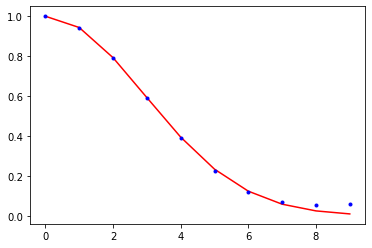

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 927
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.73268818 60.64212621 60.64382812 60.6437026  60.64361437]
Observation contribution to cost function [326.98191782 326.84208838 326.83922702 326.8394498  326.83960075]
Model contribution to cost function  [121.9070284  121.35084344 121.3520117  121.3519094  121.3518433 ]
The values of the cost function total [509.62163441 508.83505803 508.83506684 508.83506179 508.83505842]
RMS between background/truth and analysis/truth [0.31174171 0.0570303 ]
New estimate for variance coming from assimilation window 8: 0.04535232928084387
New estimate for correlation length coming from assimilation window 8: 3.705838957430649


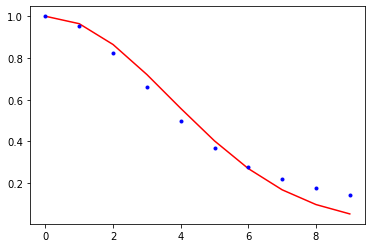

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 989
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.92423716 56.95292283 56.95501986 56.95493245 56.95484295]
Observation contribution to cost function [316.18233819 316.28411935 316.28007253 316.28052429 316.28087008]
Model contribution to cost function  [147.37786582 146.3616958  146.36366214 146.36329231 146.36303443]
The values of the cost function total [520.48444117 519.59873798 519.59875453 519.59874905 519.59874746]
RMS between background/truth and analysis/truth [0.32396951 0.05510498]
New estimate for variance coming from assimilation window 9: 0.04882388533828559
New estimate for correlation length coming from assimilation window 9: 3.163637577987664


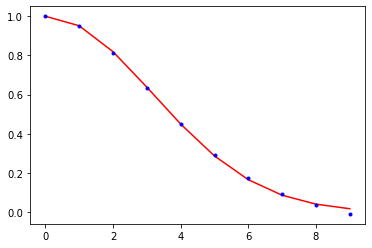

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 69
Number of inner iterations in outer iteration number 2: 19
Number of inner iterations in outer iteration number 3: 2
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [86.80615918 86.77781203 86.77917152 86.77686888 86.7785221 ]
Observation contribution to cost function [472.01202127 472.18148312 472.17666798 472.18384941 472.17748419]
Model contribution to cost function  [501.86160681 501.0360752  501.03951779 501.03464309 501.03934298]
The values of the cost function total [1060.67978726 1059.99537035 1059.9953573  1059.99536138 1059.99534926]
RMS between background/truth and analysis/truth [0.27955922 0.09261488]
New estimate for variance coming from assimilation window 0: 0.024507452967305634
New estimate for correlation length coming from assimilation window 0: 2.2918670487877


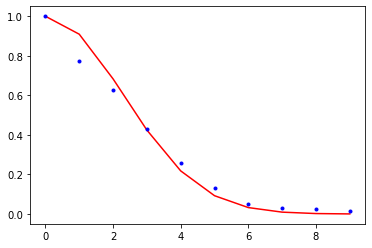

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 659
Number of inner iterations in outer iteration number 2: 287
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [45.63751727 45.62846006 45.62979264 45.62958493 45.62944116]
Observation contribution to cost function [276.5848858  276.61680421 276.61549984 276.61594718 276.61605757]
Model contribution to cost function  [188.50098674 188.15314311 188.15310429 188.15286162 188.15289408]
The values of the cost function total [510.72338981 510.39840738 510.39839677 510.39839372 510.39839282]
RMS between background/truth and analysis/truth [0.2934368  0.05509655]
New estimate for variance coming from assimilation window 1: 0.04222871896514149
New estimate for correlation length coming from assimilation window 1: 2.515035504242448


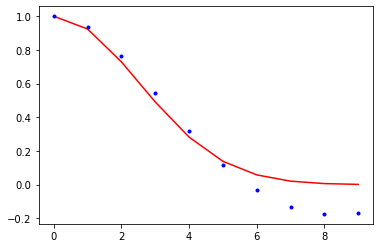

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 897
Number of inner iterations in outer iteration number 2: 393
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.23747904 55.13119569 55.13224805 55.13215007 55.13205431]
Observation contribution to cost function [281.05747182 281.43492118 281.43346037 281.43377114 281.43401442]
Model contribution to cost function  [155.33809934 154.48662114 154.48703424 154.48681873 154.48666984]
The values of the cost function total [491.63305021 491.05273801 491.05274266 491.05273994 491.05273857]
RMS between background/truth and analysis/truth [0.32103169 0.05853959]
New estimate for variance coming from assimilation window 2: 0.048309852259273756
New estimate for correlation length coming from assimilation window 2: 3.1361059042823913


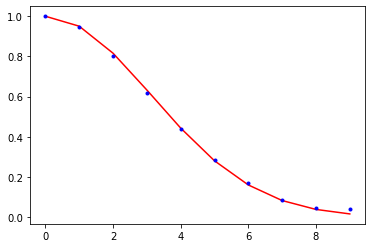

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 521
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.95542625 56.98655456 56.98832751 56.98816842 56.98805698]
Observation contribution to cost function [311.74989517 312.05739468 312.05556042 312.05594547 312.05617328]
Model contribution to cost function  [156.79488687 156.55079598 156.55085583 156.55062639 156.55050757]
The values of the cost function total [525.50020829 525.59474522 525.59474375 525.59474029 525.59473783]
RMS between background/truth and analysis/truth [0.33396461 0.06023359]
New estimate for variance coming from assimilation window 3: 0.05713496237100429
New estimate for correlation length coming from assimilation window 3: 4.269268679420874


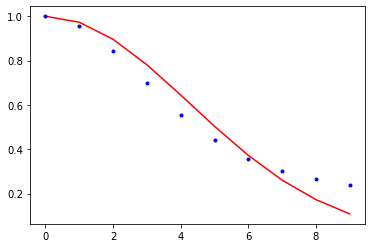

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 715
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [67.11498989 67.19782016 67.20073149 67.20059456 67.20045821]
Observation contribution to cost function [309.45620177 309.41750207 309.41336459 309.4136292  309.41384681]
Model contribution to cost function  [132.8334117  132.27284533 132.27407334 132.27394496 132.27386205]
The values of the cost function total [509.40460337 508.88816756 508.88816942 508.88816871 508.88816707]
RMS between background/truth and analysis/truth [0.33081574 0.06050535]
New estimate for variance coming from assimilation window 4: 0.05154458635767233
New estimate for correlation length coming from assimilation window 4: 3.668230752896843


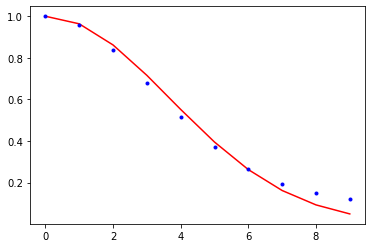

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 853
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [77.16381057 77.19540939 77.1981364  77.19794671 77.19778628]
Observation contribution to cost function [338.36486901 338.0275713  338.02388688 338.02436012 338.02473433]
Model contribution to cost function  [137.70148553 137.22439951 137.22533797 137.22505141 137.2248373 ]
The values of the cost function total [553.23016511 552.44738021 552.44736125 552.44735824 552.44735791]
RMS between background/truth and analysis/truth [0.30232841 0.05544868]
New estimate for variance coming from assimilation window 5: 0.041761076544404946
New estimate for correlation length coming from assimilation window 5: 2.611079296974476


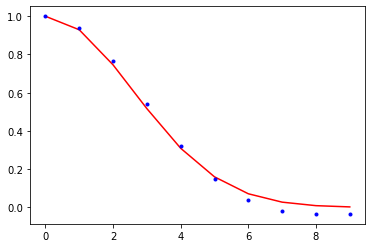

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 779
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.15289835 61.20607008 61.20772791 61.20760378 61.20750845]
Observation contribution to cost function [320.25977386 319.66237628 319.6594908  319.65985382 319.66014432]
Model contribution to cost function  [139.53163231 139.02754552 139.0287556  139.02851662 139.02832197]
The values of the cost function total [520.94430452 519.89599188 519.89597431 519.89597421 519.89597473]
RMS between background/truth and analysis/truth [0.34397598 0.05942121]
New estimate for variance coming from assimilation window 6: 0.05687208463445245
New estimate for correlation length coming from assimilation window 6: 3.1677555826732333


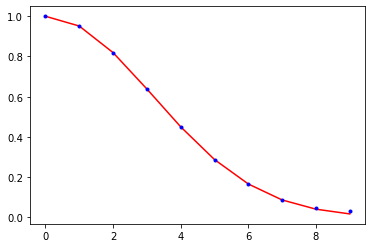

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 845
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.93883833 62.89880576 62.9004743  62.90038602 62.90030227]
Observation contribution to cost function [294.59503832 293.99886349 293.99632029 293.99663544 293.9968982 ]
Model contribution to cost function  [141.62894727 141.68992543 141.6907901  141.69056255 141.69038165]
The values of the cost function total [499.16282392 498.58759469 498.58758469 498.58758401 498.58758212]
RMS between background/truth and analysis/truth [0.32964699 0.06081947]
New estimate for variance coming from assimilation window 7: 0.04985367596009546
New estimate for correlation length coming from assimilation window 7: 2.8580551329152053


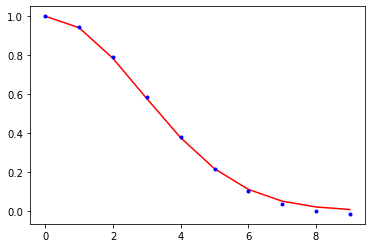

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 813
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.01945522 65.13178619 65.1330403  65.13294668 65.13287064]
Observation contribution to cost function [317.87958166 317.80432585 317.80285452 317.80320912 317.80340695]
Model contribution to cost function  [129.67176981 129.47613291 129.47631718 129.47605453 129.4759315 ]
The values of the cost function total [512.57080669 512.41224495 512.412212   512.41221032 512.4122091 ]
RMS between background/truth and analysis/truth [0.33305261 0.05951526]
New estimate for variance coming from assimilation window 8: 0.05244370293672678
New estimate for correlation length coming from assimilation window 8: 2.7466267650693217


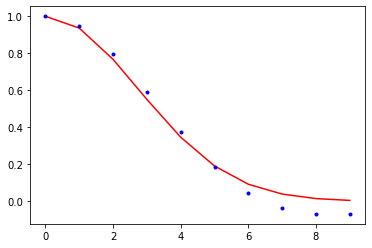

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 803
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [67.54555734 67.51860604 67.52087496 67.5207383  67.5206167 ]
Observation contribution to cost function [314.20154342 313.98768991 313.98496926 313.98535605 313.98564338]
Model contribution to cost function  [123.76669232 123.19820915 123.19864736 123.19839296 123.19822497]
The values of the cost function total [505.51379308 504.7045051  504.70449158 504.70448731 504.70448505]
RMS between background/truth and analysis/truth [0.29778963 0.05652725]
New estimate for variance coming from assimilation window 9: 0.045009752822867094
New estimate for correlation length coming from assimilation window 9: 2.9778159784953417


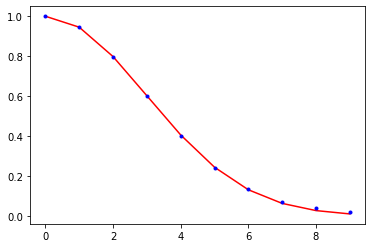

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 73
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [93.45353552 93.489756   93.49060915 93.49168517 93.49189816]
Observation contribution to cost function [527.54257025 527.33870317 527.33632995 527.33341969 527.33119366]
Model contribution to cost function  [538.19428617 538.6374066  538.6389359  538.64075938 538.6427728 ]
The values of the cost function total [1159.19039194 1159.46586577 1159.465875   1159.46586425 1159.46586463]
RMS between background/truth and analysis/truth [0.28977203 0.10247904]
New estimate for variance coming from assimilation window 0: 0.02643953343669933
New estimate for correlation length coming from assimilation window 0: 2.224916446944757


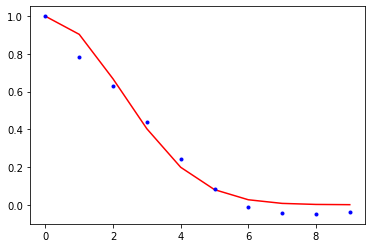

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 729
Number of inner iterations in outer iteration number 2: 283
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [45.50392628 45.41735583 45.41820281 45.41806913 45.4179946 ]
Observation contribution to cost function [325.89113539 325.78700674 325.78641376 325.78671504 325.78674955]
Model contribution to cost function  [172.90733098 172.69215352 172.69189873 172.69172848 172.69176787]
The values of the cost function total [544.30239266 543.89651608 543.8965153  543.89651265 543.89651202]
RMS between background/truth and analysis/truth [0.26261878 0.06243406]
New estimate for variance coming from assimilation window 1: 0.035576770411345604
New estimate for correlation length coming from assimilation window 1: 2.409633009989556


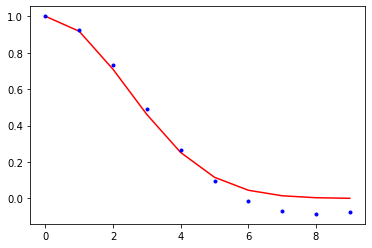

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 831
Number of inner iterations in outer iteration number 2: 368
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.04274546 52.07958967 52.08061023 52.08034949 52.08024553]
Observation contribution to cost function [311.24338998 311.33809182 311.33576696 311.33636548 311.3363766 ]
Model contribution to cost function  [165.85363346 164.32134759 164.32265049 164.3223075  164.32239904]
The values of the cost function total [529.1397689  527.73902907 527.73902768 527.73902247 527.73902117]
RMS between background/truth and analysis/truth [0.31501173 0.05858222]
New estimate for variance coming from assimilation window 2: 0.040769545199144164
New estimate for correlation length coming from assimilation window 2: 2.6911787350250975


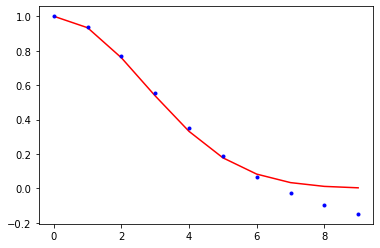

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 985
Number of inner iterations in outer iteration number 2: 413
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.64773317 56.6250657  56.62605947 56.62596563 56.62588316]
Observation contribution to cost function [294.69123179 294.55937278 294.55752244 294.55760362 294.55766987]
Model contribution to cost function  [146.68263885 145.82970767 145.830563   145.83057527 145.83059189]
The values of the cost function total [498.0216038  497.01414614 497.01414491 497.01414453 497.01414491]
RMS between background/truth and analysis/truth [0.30895092 0.05673734]
New estimate for variance coming from assimilation window 3: 0.04587800545978927
New estimate for correlation length coming from assimilation window 3: 3.558885691818605


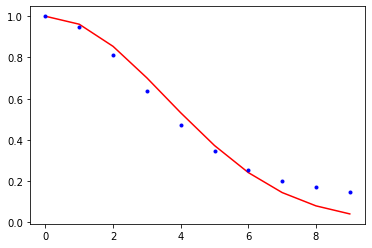

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 457
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.60755544 55.57793366 55.57927042 55.57914256 55.5790372 ]
Observation contribution to cost function [319.12825706 319.06445838 319.06209133 319.06246566 319.06271488]
Model contribution to cost function  [141.71839585 141.23112977 141.2321608  141.23191077 141.23176457]
The values of the cost function total [516.45420835 515.87352182 515.87352256 515.87351899 515.87351665]
RMS between background/truth and analysis/truth [0.26369344 0.0588992 ]
New estimate for variance coming from assimilation window 4: 0.034706125535307344
New estimate for correlation length coming from assimilation window 4: 2.571708188894702


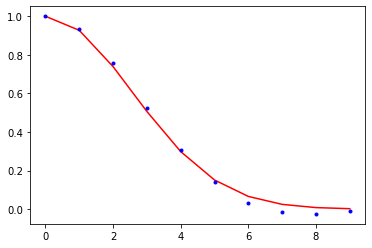

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 592
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.11211867 65.18409712 65.18604339 65.18589322 65.1857663 ]
Observation contribution to cost function [300.73411424 300.65476337 300.65215927 300.65238844 300.65254155]
Model contribution to cost function  [169.9017614  168.32058221 168.32123396 168.32115324 168.32112628]
The values of the cost function total [535.74799431 534.1594427  534.15943662 534.1594349  534.15943413]
RMS between background/truth and analysis/truth [0.34490412 0.05753905]
New estimate for variance coming from assimilation window 5: 0.054519718344355816
New estimate for correlation length coming from assimilation window 5: 2.452123348427036


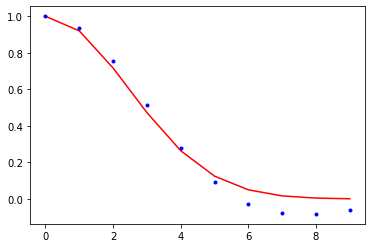

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 556
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [47.40708067 47.39702804 47.39829231 47.39814558 47.39803526]
Observation contribution to cost function [283.75659877 283.66129508 283.65914045 283.65953553 283.65979006]
Model contribution to cost function  [157.71465702 156.59406284 156.5949544  156.59470435 156.59455966]
The values of the cost function total [488.87833646 487.65238596 487.65238715 487.65238546 487.65238498]
RMS between background/truth and analysis/truth [0.29971124 0.05779551]
New estimate for variance coming from assimilation window 6: 0.03937042088231179
New estimate for correlation length coming from assimilation window 6: 2.3501563829421435


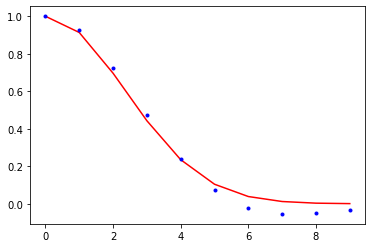

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 551
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.48055378 54.38514337 54.38666495 54.38651942 54.3864024 ]
Observation contribution to cost function [313.44120616 313.34434955 313.34114108 313.34164452 313.34203465]
Model contribution to cost function  [163.92633773 163.70945093 163.71113971 163.71078107 163.71050827]
The values of the cost function total [531.84809767 531.43894384 531.43894575 531.43894502 531.43894532]
RMS between background/truth and analysis/truth [0.35085371 0.06054118]
New estimate for variance coming from assimilation window 7: 0.05077102690678668
New estimate for correlation length coming from assimilation window 7: 2.7148002241969293


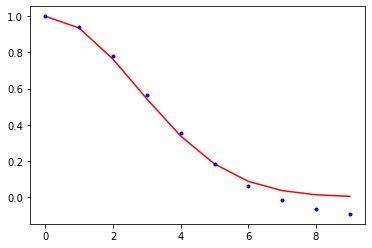

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 529
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [50.99822823 51.00654039 51.00769712 51.00762808 51.00756653]
Observation contribution to cost function [290.69871296 290.45187009 290.45111834 290.45128396 290.45142637]
Model contribution to cost function  [149.66407114 149.53030796 149.52990016 149.52980183 149.52971973]
The values of the cost function total [491.36101233 490.98871844 490.98871563 490.98871386 490.98871263]
RMS between background/truth and analysis/truth [0.2921121  0.05776678]
New estimate for variance coming from assimilation window 8: 0.0439698544173187
New estimate for correlation length coming from assimilation window 8: 2.7894176436656464


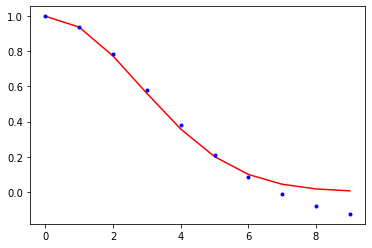

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 557
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.1665537  61.28323874 61.2845095  61.28445192 61.28437514]
Observation contribution to cost function [321.55993052 321.17079229 321.16997212 321.17012515 321.17026323]
Model contribution to cost function  [147.62263841 147.36362417 147.36317679 147.3630782  147.36301522]
The values of the cost function total [530.34912263 529.8176552  529.8176584  529.81765527 529.81765359]
RMS between background/truth and analysis/truth [0.30318008 0.06062887]
New estimate for variance coming from assimilation window 9: 0.04137905114452886
New estimate for correlation length coming from assimilation window 9: 2.3539818379043207


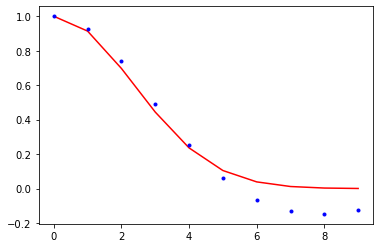

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 75
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [87.53329153 87.53154659 87.53127069 87.53311664 87.53246218]
Observation contribution to cost function [587.94833448 587.43785088 587.44016926 587.43488685 587.43711842]
Model contribution to cost function  [588.2989531  589.28332958 589.28129469 589.28471744 589.28314151]
The values of the cost function total [1263.78057912 1264.25272705 1264.25273464 1264.25272093 1264.25272211]
RMS between background/truth and analysis/truth [0.28999161 0.10278503]
New estimate for variance coming from assimilation window 0: 0.028012347044311315
New estimate for correlation length coming from assimilation window 0: 2.217006828296034


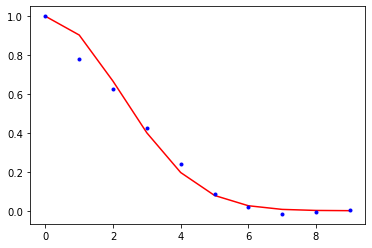

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 687
Number of inner iterations in outer iteration number 2: 289
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [50.76464058 50.74680851 50.74794207 50.74776075 50.74763994]
Observation contribution to cost function [328.35560901 328.37284636 328.3720195  328.3718493  328.37176896]
Model contribution to cost function  [212.71388045 211.92713182 211.92682717 211.92717758 211.92737815]
The values of the cost function total [591.83413004 591.04678669 591.04678874 591.04678763 591.04678706]
RMS between background/truth and analysis/truth [0.3467827  0.06408887]
New estimate for variance coming from assimilation window 1: 0.06180511522512847
New estimate for correlation length coming from assimilation window 1: 2.85150599254975


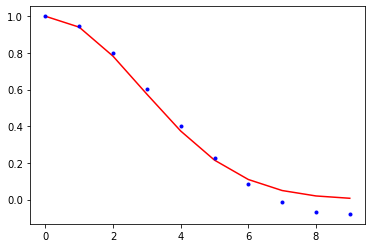

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 531
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.28569975 64.34853298 64.3494149  64.34937431 64.34932541]
Observation contribution to cost function [260.41813033 260.36415071 260.36282841 260.36283501 260.36283678]
Model contribution to cost function  [123.02050895 122.53972082 122.54015494 122.5401865  122.5402315 ]
The values of the cost function total [447.72433903 447.25240451 447.25239825 447.25239582 447.2523937 ]
RMS between background/truth and analysis/truth [0.30375903 0.05906778]
New estimate for variance coming from assimilation window 2: 0.043865064341531895
New estimate for correlation length coming from assimilation window 2: 2.9509801914314493


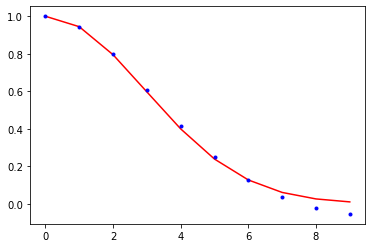

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 615
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [49.65701698 49.59091174 49.59212646 49.59202917 49.59196076]
Observation contribution to cost function [298.44762474 298.16601601 298.16448412 298.16462707 298.16475038]
Model contribution to cost function  [128.2525599  128.01404377 128.01435485 128.01430875 128.01425486]
The values of the cost function total [476.35720161 475.77097152 475.77096544 475.77096499 475.770966  ]
RMS between background/truth and analysis/truth [0.31752051 0.05668132]
New estimate for variance coming from assimilation window 3: 0.048462242544997425
New estimate for correlation length coming from assimilation window 3: 2.595541405203986


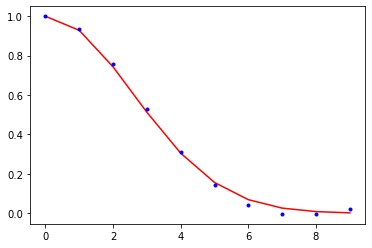

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 679
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [75.73157251 75.82520959 75.8261521  75.82609741 75.82605457]
Observation contribution to cost function [298.48986069 298.368587   298.36741758 298.36761542 298.36774422]
Model contribution to cost function  [136.13262866 136.30186567 136.30208223 136.301937   136.30184811]
The values of the cost function total [510.35406186 510.49566226 510.49565191 510.49564983 510.49564689]
RMS between background/truth and analysis/truth [0.32313095 0.06059719]
New estimate for variance coming from assimilation window 4: 0.050603006601378155
New estimate for correlation length coming from assimilation window 4: 2.622290832716513


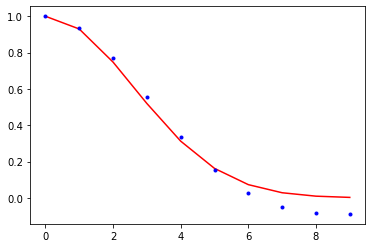

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 643
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [46.61508094 46.70097424 46.70193011 46.70182787 46.70175858]
Observation contribution to cost function [305.66499119 305.02702641 305.02430905 305.02469495 305.02494662]
Model contribution to cost function  [141.19962168 140.95651569 140.95826389 140.95797781 140.95779486]
The values of the cost function total [493.47969382 492.68451634 492.68450304 492.68450062 492.68450007]
RMS between background/truth and analysis/truth [0.34389809 0.05845632]
New estimate for variance coming from assimilation window 5: 0.057154265493933244
New estimate for correlation length coming from assimilation window 5: 3.4361256647412084


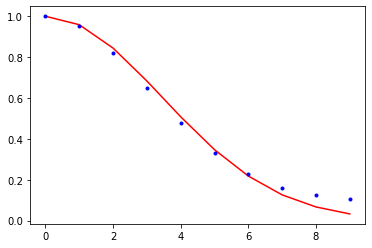

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 723
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.90542149 48.87755183 48.87801095 48.87793005 48.87788981]
Observation contribution to cost function [307.54187627 307.45424223 307.45317509 307.45335161 307.4534671 ]
Model contribution to cost function  [122.83714541 122.73791518 122.73850902 122.73841029 122.738333  ]
The values of the cost function total [479.28444317 479.06970924 479.06969507 479.06969195 479.06968992]
RMS between background/truth and analysis/truth [0.31163759 0.05750871]
New estimate for variance coming from assimilation window 6: 0.0495674504450828
New estimate for correlation length coming from assimilation window 6: 3.3490082870342306


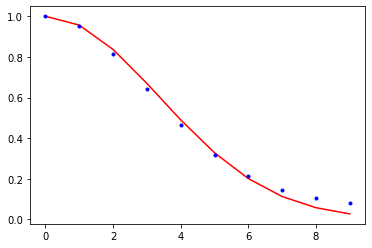

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 785
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.32043738 57.36286734 57.36332708 57.36332829 57.36329432]
Observation contribution to cost function [303.26591237 303.15976959 303.15866672 303.15886115 303.15902973]
Model contribution to cost function  [118.7704112  118.31300604 118.31364    118.31344213 118.31330642]
The values of the cost function total [479.35676096 478.83564297 478.8356338  478.83563157 478.83563048]
RMS between background/truth and analysis/truth [0.32693427 0.0577284 ]
New estimate for variance coming from assimilation window 7: 0.04197971485394812
New estimate for correlation length coming from assimilation window 7: 3.0811473420280047


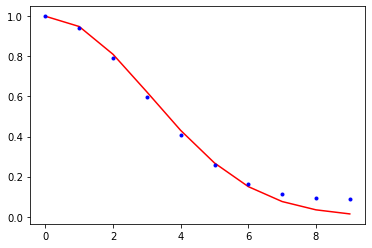

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 729
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.52454209 53.6055942  53.60628684 53.60622243 53.60617347]
Observation contribution to cost function [305.56143993 305.49927866 305.49857068 305.49878463 305.49890247]
Model contribution to cost function  [124.07942339 124.14475886 124.14476246 124.14460785 124.14453624]
The values of the cost function total [483.1654054  483.24963171 483.24961998 483.24961491 483.24961218]
RMS between background/truth and analysis/truth [0.31016263 0.05720144]
New estimate for variance coming from assimilation window 8: 0.047455461922989384
New estimate for correlation length coming from assimilation window 8: 2.789395625062244


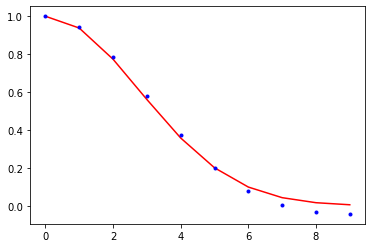

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 717
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.30894811 60.20366109 60.20530881 60.20518853 60.20510009]
Observation contribution to cost function [277.84321353 277.76146354 277.75911703 277.75948588 277.75974165]
Model contribution to cost function  [142.76907066 142.75928943 142.75999375 142.75974362 142.75957567]
The values of the cost function total [480.92123231 480.72441406 480.72441958 480.72441802 480.72441742]
RMS between background/truth and analysis/truth [0.32505999 0.05884157]
New estimate for variance coming from assimilation window 9: 0.04701204434827777
New estimate for correlation length coming from assimilation window 9: 3.303757776249756


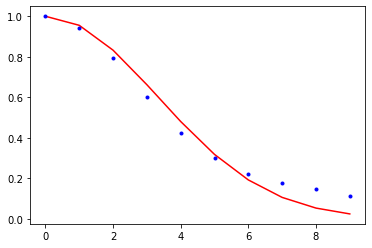

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 73
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [92.94383102 92.9887829  92.98569069 92.99161493 92.9869144 ]
Observation contribution to cost function [646.09939106 645.40626224 645.41980452 645.39916928 645.41592241]
Model contribution to cost function  [686.62106145 688.0475484  688.0371181  688.05183237 688.03976575]
The values of the cost function total [1425.66428353 1426.44259354 1426.44261331 1426.44261658 1426.44260256]
RMS between background/truth and analysis/truth [0.31800121 0.10590361]
New estimate for variance coming from assimilation window 0: 0.03536163460861221
New estimate for correlation length coming from assimilation window 0: 2.512051124137597


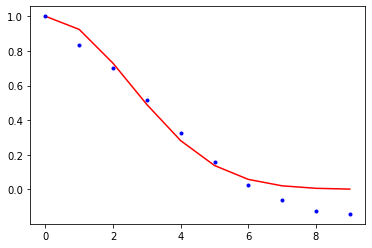

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 947
Number of inner iterations in outer iteration number 2: 477
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [45.14772273 45.09174321 45.09270975 45.09259133 45.09249717]
Observation contribution to cost function [312.81657249 312.96238566 312.96275449 312.9627146  312.96274944]
Model contribution to cost function  [163.48841862 162.99639738 162.9950615  162.99521773 162.99527573]
The values of the cost function total [521.45271384 521.05052625 521.05052574 521.05052367 521.05052234]
RMS between background/truth and analysis/truth [0.37939148 0.05795402]
New estimate for variance coming from assimilation window 1: 0.06697082942935575
New estimate for correlation length coming from assimilation window 1: 4.674346470227646


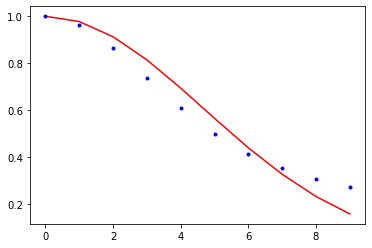

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 207
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [81.67238266 81.73550588 81.73608442 81.73607833 81.73607686]
Observation contribution to cost function [388.81041344 388.54095976 388.54065145 388.54063245 388.54062408]
Model contribution to cost function  [147.41550557 147.19809847 147.1974052  147.19742714 147.19743569]
The values of the cost function total [617.89830166 617.47456411 617.47414106 617.47413791 617.47413662]
RMS between background/truth and analysis/truth [0.3235822  0.05907668]
New estimate for variance coming from assimilation window 2: 0.049049035533422845
New estimate for correlation length coming from assimilation window 2: 3.207600617269899


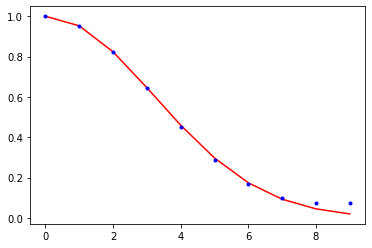

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 113
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.23999759 60.07713702 60.07740219 60.07739323 60.07739251]
Observation contribution to cost function [330.72117755 330.12724733 330.12529754 330.12527863 330.12527154]
Model contribution to cost function  [140.31304165 139.53336103 139.53487625 139.53490207 139.53490867]
The values of the cost function total [531.2742168  529.73774537 529.73757598 529.73757393 529.73757272]
RMS between background/truth and analysis/truth [0.33783872 0.06153906]
New estimate for variance coming from assimilation window 3: 0.05910595092942239
New estimate for correlation length coming from assimilation window 3: 2.85945475465969


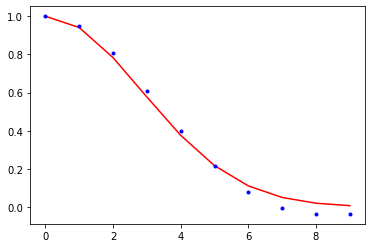

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 161
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.30643147 55.31553649 55.31586095 55.31582987 55.3158322 ]
Observation contribution to cost function [328.16966321 328.3293772  328.32706833 328.32708865 328.32707697]
Model contribution to cost function  [129.94362854 128.57245991 128.5741243  128.57412899 128.57413613]
The values of the cost function total [513.41972322 512.2173736  512.21705358 512.21704752 512.2170453 ]
RMS between background/truth and analysis/truth [0.33630462 0.06013378]
New estimate for variance coming from assimilation window 4: 0.05255437480802723
New estimate for correlation length coming from assimilation window 4: 2.5777271594086706


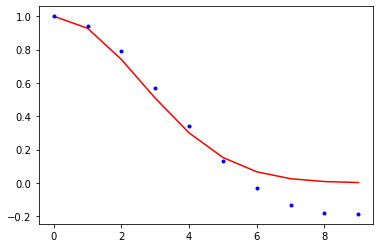

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.38404176 62.42569912 62.42772516 62.42760827 62.4275276 ]
Observation contribution to cost function [309.11123926 308.84446225 308.8424403  308.8425655  308.84266832]
Model contribution to cost function  [118.13376956 118.35467767 118.35463004 118.35461834 118.35459477]
The values of the cost function total [489.62905058 489.62483904 489.6247955  489.62479211 489.62479068]
RMS between background/truth and analysis/truth [0.30382888 0.05485722]
New estimate for variance coming from assimilation window 5: 0.043094171601999236
New estimate for correlation length coming from assimilation window 5: 3.0829760401511392


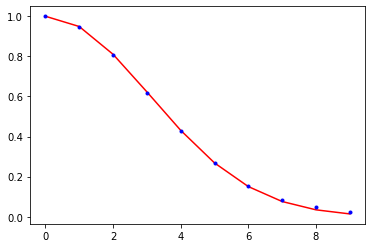

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 943
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.11349935 66.05957593 66.06169544 66.06165681 66.06159369]
Observation contribution to cost function [303.97667569 303.82949086 303.82735832 303.82748709 303.82761879]
Model contribution to cost function  [119.94933659 119.67424782 119.67425526 119.67416401 119.67409272]
The values of the cost function total [490.03951163 489.56331461 489.56330901 489.5633079  489.56330521]
RMS between background/truth and analysis/truth [0.29467698 0.05757167]
New estimate for variance coming from assimilation window 6: 0.04246606676255855
New estimate for correlation length coming from assimilation window 6: 2.83104017204349


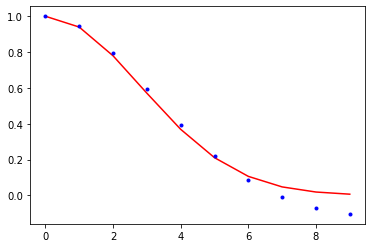

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 924
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.52120943 60.49210464 60.49347732 60.49342117 60.49336571]
Observation contribution to cost function [342.97652873 342.93629278 342.93445301 342.93465906 342.93481013]
Model contribution to cost function  [133.59842016 132.85532193 132.85576373 132.85560932 132.8555122 ]
The values of the cost function total [537.09615832 536.28371935 536.28369406 536.28368955 536.28368804]
RMS between background/truth and analysis/truth [0.27631611 0.05966377]
New estimate for variance coming from assimilation window 7: 0.04250860201408858
New estimate for correlation length coming from assimilation window 7: 2.9982350566054174


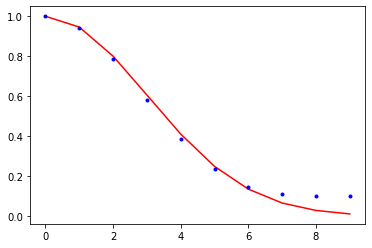

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 931
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.38977581 64.3532273  64.35569665 64.35571819 64.3555986 ]
Observation contribution to cost function [332.26151102 332.702078   332.69839224 332.69877734 332.69858683]
Model contribution to cost function  [139.46584505 138.1121821  138.11339165 138.11298535 138.11329387]
The values of the cost function total [536.11713188 535.1674874  535.16748054 535.16748088 535.1674793 ]
RMS between background/truth and analysis/truth [0.33787853 0.05499813]
New estimate for variance coming from assimilation window 8: 0.058394878422079056
New estimate for correlation length coming from assimilation window 8: 2.669274977672599


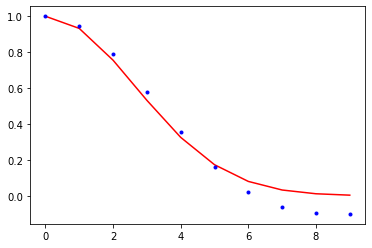

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 917
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [70.4546267  70.5922371  70.5947106  70.5945942  70.59449078]
Observation contribution to cost function [318.78679728 318.18815527 318.18550694 318.18571356 318.18592733]
Model contribution to cost function  [118.03437796 117.46728221 117.46742267 117.46732975 117.46721842]
The values of the cost function total [507.27580195 506.24767458 506.2476402  506.24763751 506.24763653]
RMS between background/truth and analysis/truth [0.30181046 0.05957566]
New estimate for variance coming from assimilation window 9: 0.04809951831566189
New estimate for correlation length coming from assimilation window 9: 2.843307052907178


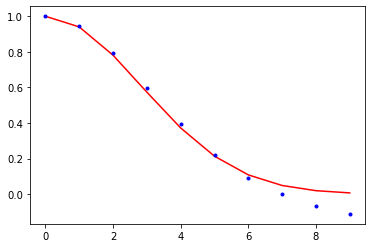

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 71
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [86.9700391  86.96693141 86.96567363 86.96837892 86.96672937]
Observation contribution to cost function [561.63817781 561.75338542 561.75471149 561.74795712 561.74983904]
Model contribution to cost function  [599.50774364 598.89926286 598.89919496 598.90323675 598.90300339]
The values of the cost function total [1248.11596055 1247.61957969 1247.61958009 1247.61957279 1247.6195718 ]
RMS between background/truth and analysis/truth [0.30319735 0.09848891]
New estimate for variance coming from assimilation window 0: 0.0305633264275494
New estimate for correlation length coming from assimilation window 0: 2.7937293311661775


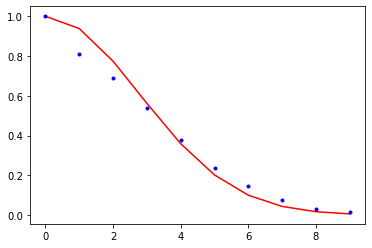

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 421
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.81739031 58.85588525 58.85693126 58.8568739  58.85680506]
Observation contribution to cost function [290.58910244 290.58121648 290.58002159 290.5802423  290.58037521]
Model contribution to cost function  [164.42948662 164.24783617 164.24798216 164.24781741 164.24775255]
The values of the cost function total [513.83597937 513.6849379  513.68493501 513.68493361 513.68493282]
RMS between background/truth and analysis/truth [0.29412271 0.0587698 ]
New estimate for variance coming from assimilation window 1: 0.043060398392278355
New estimate for correlation length coming from assimilation window 1: 2.4380259533487894


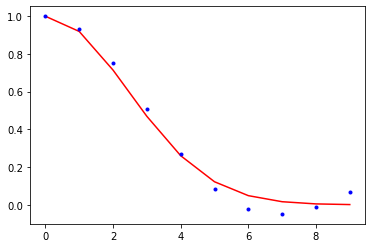

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 461
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [70.75029409 70.81087149 70.81314817 70.81294415 70.81277287]
Observation contribution to cost function [310.4665285  310.40791659 310.40469245 310.40511888 310.40542796]
Model contribution to cost function  [146.5924214  146.7508631  146.75180577 146.75158265 146.7514452 ]
The values of the cost function total [527.80924399 527.96965118 527.96964639 527.96964568 527.96964604]
RMS between background/truth and analysis/truth [0.26549899 0.05862734]
New estimate for variance coming from assimilation window 2: 0.03668311514363141
New estimate for correlation length coming from assimilation window 2: 2.5478410717963627


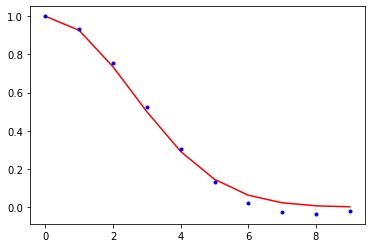

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 537
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.58922272 56.61669288 56.61817009 56.61799307 56.61787003]
Observation contribution to cost function [287.06642727 286.85924318 286.85563808 286.8559525  286.8561562 ]
Model contribution to cost function  [175.35480143 174.98608642 174.98820852 174.98806631 174.98798204]
The values of the cost function total [519.01045141 518.46202247 518.46201669 518.46201188 518.46200826]
RMS between background/truth and analysis/truth [0.35433946 0.06061063]
New estimate for variance coming from assimilation window 3: 0.06061163876100574
New estimate for correlation length coming from assimilation window 3: 2.605541861454585


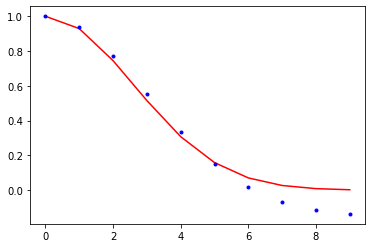

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 531
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.01584328 53.04023196 53.04149485 53.04140884 53.04134038]
Observation contribution to cost function [296.75243072 296.65860923 296.65629646 296.6566812  296.65692043]
Model contribution to cost function  [127.76343344 127.67929713 127.68033968 127.68003969 127.6798688 ]
The values of the cost function total [477.53170744 477.37813832 477.378131   477.37812973 477.37812961]
RMS between background/truth and analysis/truth [0.28610905 0.06015771]
New estimate for variance coming from assimilation window 4: 0.03876512354589631
New estimate for correlation length coming from assimilation window 4: 2.8396439276719603


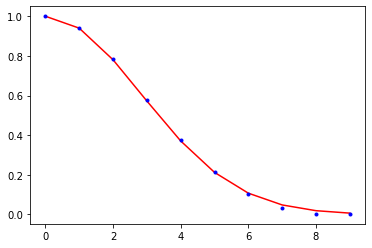

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 551
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [42.8182212  42.86161146 42.86268477 42.8625615  42.86246056]
Observation contribution to cost function [282.18911016 281.99694076 281.99437125 281.99494399 281.99530202]
Model contribution to cost function  [149.61486465 149.59258263 149.59407495 149.59362199 149.59336403]
The values of the cost function total [474.62219602 474.45113484 474.45113097 474.45112749 474.4511266 ]
RMS between background/truth and analysis/truth [0.3157894  0.05875911]
New estimate for variance coming from assimilation window 5: 0.05411221854392119
New estimate for correlation length coming from assimilation window 5: 3.2135521231165822


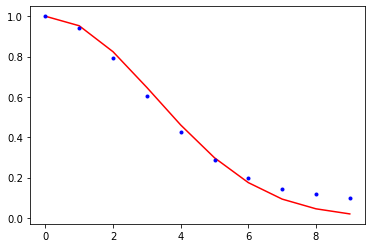

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 632
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.84031967 53.93555034 53.93684604 53.93674586 53.93666448]
Observation contribution to cost function [302.08943258 301.8769241  301.87489004 301.87516418 301.87535657]
Model contribution to cost function  [138.86635356 138.50737168 138.50809765 138.50792146 138.50780842]
The values of the cost function total [494.79610581 494.31984612 494.31983373 494.31983151 494.31982948]
RMS between background/truth and analysis/truth [0.33451666 0.05884026]
New estimate for variance coming from assimilation window 6: 0.0546883395738261
New estimate for correlation length coming from assimilation window 6: 3.5963098168077328


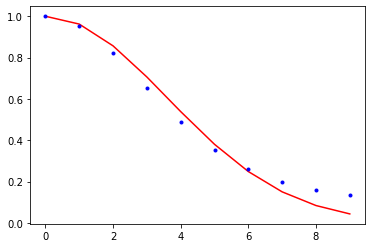

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 727
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.14665712 56.13986078 56.14115159 56.1410495  56.14095695]
Observation contribution to cost function [307.10220672 306.93674531 306.93469962 306.93509474 306.93540108]
Model contribution to cost function  [147.14745259 146.43095995 146.43172228 146.43142434 146.43120833]
The values of the cost function total [510.39631644 509.50756603 509.5075735  509.50756858 509.50756636]
RMS between background/truth and analysis/truth [0.35348999 0.05342673]
New estimate for variance coming from assimilation window 7: 0.05831766907149799
New estimate for correlation length coming from assimilation window 7: 3.6473672765676337


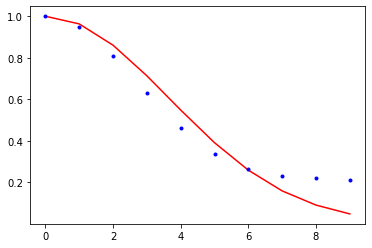

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 787
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.75946907 56.70762868 56.70970606 56.70957749 56.70948202]
Observation contribution to cost function [317.33698971 317.25136739 317.24758756 317.24818129 317.24851308]
Model contribution to cost function  [130.85513151 130.71040353 130.71211471 130.71164374 130.71140314]
The values of the cost function total [504.9515903  504.6693996  504.66940833 504.66940252 504.66939825]
RMS between background/truth and analysis/truth [0.30175409 0.05826649]
New estimate for variance coming from assimilation window 8: 0.044262326844991935
New estimate for correlation length coming from assimilation window 8: 2.9784250036271747


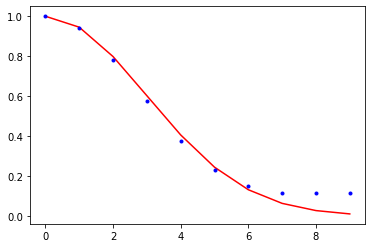

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 751
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [51.81856049 51.87622544 51.87730935 51.87725023 51.87719942]
Observation contribution to cost function [330.09004715 329.49173289 329.48956549 329.48989406 329.49011399]
Model contribution to cost function  [135.25714643 135.40024793 135.40132759 135.40105325 135.4008814 ]
The values of the cost function total [517.16575408 516.76820627 516.76820244 516.76819753 516.76819482]
RMS between background/truth and analysis/truth [0.27927653 0.0588278 ]
New estimate for variance coming from assimilation window 9: 0.04046276386010204
New estimate for correlation length coming from assimilation window 9: 2.519078287568462


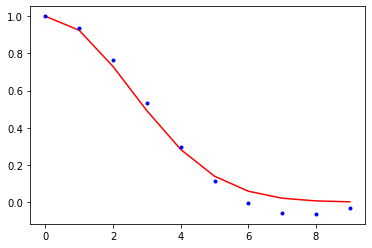

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 79
Number of inner iterations in outer iteration number 2: 25
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.06984018 64.06597644 64.06599031 64.06698484 64.06666026]
Observation contribution to cost function [553.72436697 553.7758216  553.7784342  553.77225114 553.77484965]
Model contribution to cost function  [621.19738121 620.71318199 620.71055035 620.71573453 620.71345714]
The values of the cost function total [1238.99158837 1238.55498003 1238.55497486 1238.55497051 1238.55496706]
RMS between background/truth and analysis/truth [0.29848148 0.10293505]
New estimate for variance coming from assimilation window 0: 0.0297795175962026
New estimate for correlation length coming from assimilation window 0: 2.350521369049693


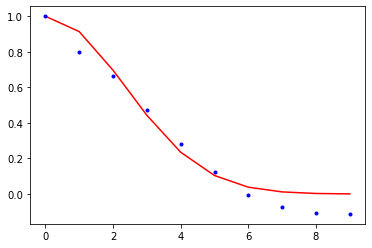

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 807
Number of inner iterations in outer iteration number 2: 376
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.80471688 54.89310566 54.89409432 54.89387108 54.89377755]
Observation contribution to cost function [294.62937387 294.53371371 294.53051696 294.53215558 294.53241631]
Model contribution to cost function  [186.26019127 184.85471834 184.8569334  184.8555101  184.85534089]
The values of the cost function total [535.69428202 534.28153771 534.28154468 534.28153675 534.28153475]
RMS between background/truth and analysis/truth [0.31415305 0.05862018]
New estimate for variance coming from assimilation window 1: 0.053447599568335113
New estimate for correlation length coming from assimilation window 1: 3.445147857411833


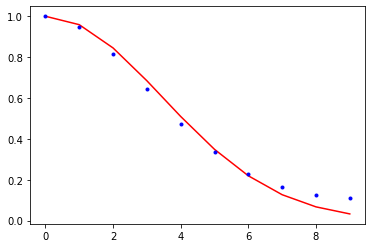

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 648
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [50.733566   50.91662767 50.91908061 50.91883684 50.91865305]
Observation contribution to cost function [305.12130039 304.47584005 304.47201693 304.47290257 304.47338392]
Model contribution to cost function  [133.74808746 133.99267024 133.9940323  133.99338767 133.99308884]
The values of the cost function total [489.60295386 489.38513795 489.38512983 489.38512708 489.38512581]
RMS between background/truth and analysis/truth [0.30904348 0.05699166]
New estimate for variance coming from assimilation window 2: 0.047918223466686866
New estimate for correlation length coming from assimilation window 2: 3.204022916049738


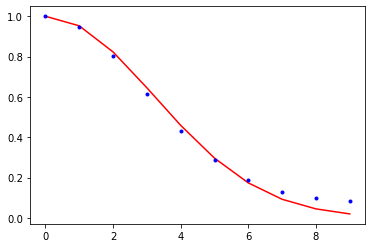

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 717
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.67939794 65.80133509 65.80285419 65.80273635 65.80264374]
Observation contribution to cost function [329.29867841 329.28011838 329.27823978 329.27878416 329.2791319 ]
Model contribution to cost function  [155.62402723 154.6645257  154.66488632 154.6644537  154.66419475]
The values of the cost function total [550.60210357 549.74597917 549.74598028 549.74597421 549.74597038]
RMS between background/truth and analysis/truth [0.37402896 0.05612605]
New estimate for variance coming from assimilation window 3: 0.06290795231052157
New estimate for correlation length coming from assimilation window 3: 4.412078625096806


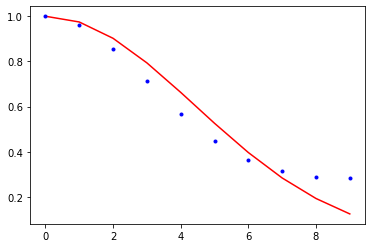

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 985
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [69.4376244  69.44218391 69.44255392 69.44252156 69.44246323]
Observation contribution to cost function [368.87361924 367.92382234 367.92292289 367.92324662 367.92344849]
Model contribution to cost function  [126.54088835 126.39902216 126.39955228 126.39925688 126.39910978]
The values of the cost function total [564.852132   563.7650284  563.76502909 563.76502506 563.76502149]
RMS between background/truth and analysis/truth [0.28667738 0.05845782]
New estimate for variance coming from assimilation window 4: 0.04216404211413061
New estimate for correlation length coming from assimilation window 4: 2.8323877510168867


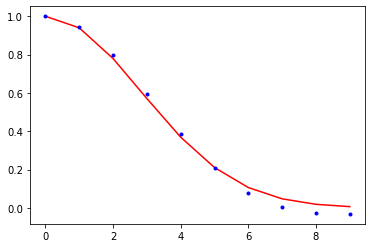

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 945
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [71.68490047 71.57429297 71.57656773 71.57643682 71.57632351]
Observation contribution to cost function [353.3989936  353.64351354 353.64079381 353.64120902 353.64151927]
Model contribution to cost function  [157.86333823 156.84947908 156.84991155 156.84962319 156.84942335]
The values of the cost function total [582.94723229 582.06728559 582.0672731  582.06726903 582.06726612]
RMS between background/truth and analysis/truth [0.33205118 0.05513798]
New estimate for variance coming from assimilation window 5: 0.05550479537928982
New estimate for correlation length coming from assimilation window 5: 2.9030322629144805


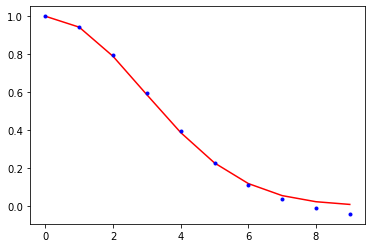

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 883
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.86089146 58.89469585 58.89569371 58.89563223 58.89557048]
Observation contribution to cost function [322.96401722 323.00728619 323.00515559 323.00532979 323.00548902]
Model contribution to cost function  [125.88733918 125.74174542 125.74286033 125.74274563 125.74264714]
The values of the cost function total [507.71224786 507.64372747 507.64370963 507.64370766 507.64370663]
RMS between background/truth and analysis/truth [0.2819236 0.0610729]
New estimate for variance coming from assimilation window 6: 0.042104658412883515
New estimate for correlation length coming from assimilation window 6: 2.7938912509953213


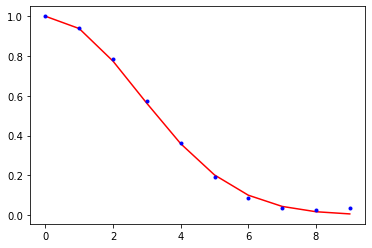

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 889
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [72.03788937 71.96441082 71.96764451 71.96747864 71.96731905]
Observation contribution to cost function [316.63204632 316.62495525 316.61999768 316.62042861 316.62079418]
Model contribution to cost function  [130.70241129 130.18560531 130.18733691 130.18706875 130.18686017]
The values of the cost function total [519.37234698 518.77497138 518.77497911 518.774976   518.7749734 ]
RMS between background/truth and analysis/truth [0.32078409 0.06109054]
New estimate for variance coming from assimilation window 7: 0.04734237126291844
New estimate for correlation length coming from assimilation window 7: 2.936168561985788


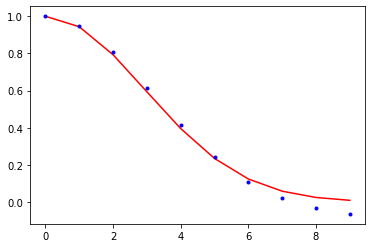

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 845
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.70277289 54.70959994 54.71130308 54.71116651 54.71105966]
Observation contribution to cost function [326.65816025 326.35057709 326.34846062 326.34871284 326.348902  ]
Model contribution to cost function  [133.45936801 133.64183103 133.64223064 133.6421132  133.64202915]
The values of the cost function total [514.82030116 514.70200806 514.70199434 514.70199255 514.7019908 ]
RMS between background/truth and analysis/truth [0.32980884 0.057669  ]
New estimate for variance coming from assimilation window 8: 0.05445059710641662
New estimate for correlation length coming from assimilation window 8: 3.188506877271174


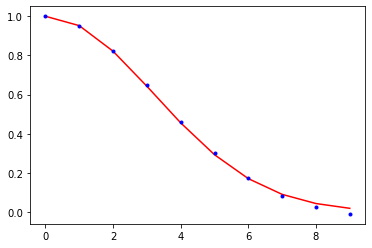

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 937
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [47.41822732 47.414907   47.41592862 47.41588038 47.41582656]
Observation contribution to cost function [317.28995389 317.00528525 317.00335722 317.00343769 317.00353865]
Model contribution to cost function  [132.82230792 131.707847   131.70871149 131.70867787 131.70862895]
The values of the cost function total [497.53048913 496.12803925 496.12799732 496.12799594 496.12799416]
RMS between background/truth and analysis/truth [0.35363495 0.0581134 ]
New estimate for variance coming from assimilation window 9: 0.05611990578701536
New estimate for correlation length coming from assimilation window 9: 2.932554220573076


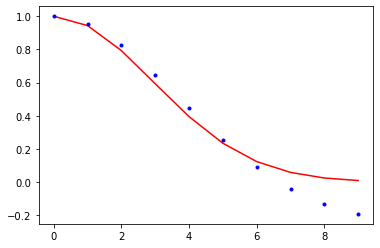

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 77
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [117.7208889  117.71453971 117.71475343 117.71613439 117.71603969]
Observation contribution to cost function [624.75108038 624.32623867 624.32983025 624.32334905 624.32536385]
Model contribution to cost function  [710.19917814 711.14294704 711.13915272 711.14424225 711.14232271]
The values of the cost function total [1452.67114742 1453.18372541 1453.1837364  1453.18372569 1453.18372626]
RMS between background/truth and analysis/truth [0.34611492 0.10693294]
New estimate for variance coming from assimilation window 0: 0.036392364494335604
New estimate for correlation length coming from assimilation window 0: 2.929791779355481


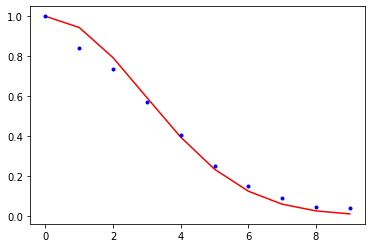

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 543
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.68016028 58.80049055 58.80188978 58.8018073  58.80173784]
Observation contribution to cost function [309.37112086 309.7016172  309.70030377 309.70083867 309.70115628]
Model contribution to cost function  [154.71390012 153.54616706 153.54609815 153.54564107 153.54538909]
The values of the cost function total [522.76518125 522.04827481 522.0482917  522.04828704 522.04828321]
RMS between background/truth and analysis/truth [0.33386869 0.06078062]
New estimate for variance coming from assimilation window 1: 0.05192078259956247
New estimate for correlation length coming from assimilation window 1: 3.2718349650182605


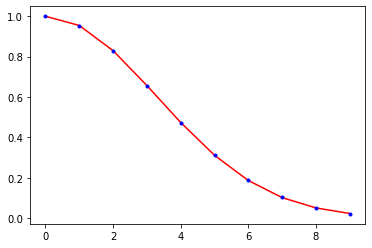

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 777
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.61137242 54.62144344 54.62268114 54.62257325 54.62250223]
Observation contribution to cost function [303.60697631 304.01475038 304.01304728 304.01332199 304.01346798]
Model contribution to cost function  [121.93497174 121.38268662 121.38315402 121.38298356 121.38290549]
The values of the cost function total [480.15332047 480.01888043 480.01888244 480.0188788  480.01887569]
RMS between background/truth and analysis/truth [0.30882612 0.0579231 ]
New estimate for variance coming from assimilation window 2: 0.04211140971629016
New estimate for correlation length coming from assimilation window 2: 2.9384784892649995


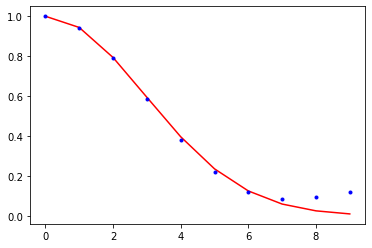

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 733
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.17407272 53.07100837 53.0722515  53.072152   53.0720769 ]
Observation contribution to cost function [322.08631392 322.04883833 322.04628129 322.04650113 322.04667993]
Model contribution to cost function  [132.39596585 132.55623768 132.5575446  132.55742209 132.55731639]
The values of the cost function total [507.65635248 507.67608438 507.6760774  507.67607523 507.67607322]
RMS between background/truth and analysis/truth [0.30854308 0.05666401]
New estimate for variance coming from assimilation window 3: 0.04512032123377216
New estimate for correlation length coming from assimilation window 3: 2.612610348219768


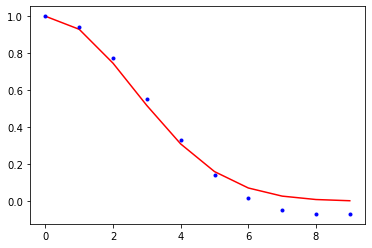

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 703
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [46.37125434 46.34647073 46.34748827 46.34745725 46.34740637]
Observation contribution to cost function [298.64108181 298.33013993 298.32878702 298.32884122 298.32889919]
Model contribution to cost function  [143.21557712 143.38616115 143.38650584 143.38647982 143.38647067]
The values of the cost function total [488.22791327 488.0627718  488.06278113 488.06277828 488.06277623]
RMS between background/truth and analysis/truth [0.35154852 0.05511226]
New estimate for variance coming from assimilation window 4: 0.05848628994281593
New estimate for correlation length coming from assimilation window 4: 2.870868710010945


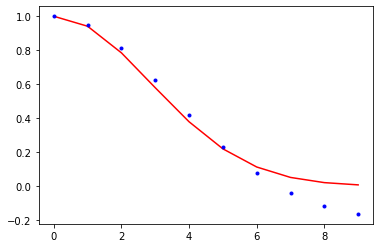

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 749
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.10534741 58.10382767 58.10523166 58.10513611 58.10505677]
Observation contribution to cost function [339.37046122 339.08268566 339.08002747 339.08051898 339.08083279]
Model contribution to cost function  [116.57320423 115.66369913 115.66494392 115.66454175 115.66430468]
The values of the cost function total [514.04901286 512.85021247 512.85020305 512.85019684 512.85019424]
RMS between background/truth and analysis/truth [0.30971452 0.05758176]
New estimate for variance coming from assimilation window 5: 0.04429627866768068
New estimate for correlation length coming from assimilation window 5: 2.95468156712906


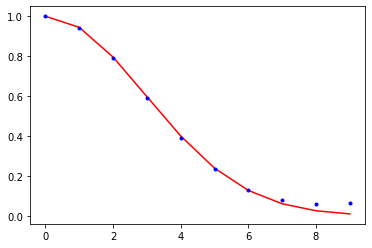

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 739
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [80.28784931 80.26305454 80.26631443 80.26611972 80.2659656 ]
Observation contribution to cost function [288.57537205 288.62445733 288.61992995 288.62028133 288.62055313]
Model contribution to cost function  [129.26598616 129.02234334 129.02360554 129.02344779 129.02333013]
The values of the cost function total [498.12920752 497.90985522 497.90984992 497.90984883 497.90984886]
RMS between background/truth and analysis/truth [0.27325186 0.05633117]
New estimate for variance coming from assimilation window 6: 0.03772699724612605
New estimate for correlation length coming from assimilation window 6: 2.871566659737952


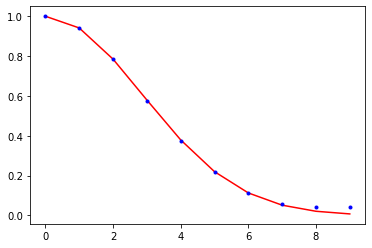

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 647
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.38134315 66.40233896 66.40358092 66.40350206 66.40344161]
Observation contribution to cost function [301.69564139 301.55964257 301.55848826 301.55865247 301.55877545]
Model contribution to cost function  [130.48830487 130.10709495 130.10700453 130.10691859 130.10685526]
The values of the cost function total [498.56528941 498.06907648 498.06907371 498.06907312 498.06907232]
RMS between background/truth and analysis/truth [0.30358885 0.05839276]
New estimate for variance coming from assimilation window 7: 0.047924468597812006
New estimate for correlation length coming from assimilation window 7: 3.0479015639394027


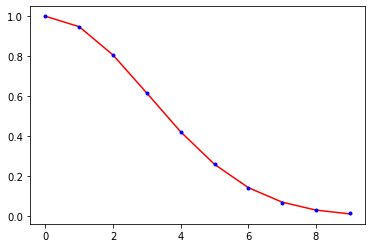

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 701
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.55569362 52.61263306 52.61369325 52.61363804 52.61357612]
Observation contribution to cost function [292.83742057 292.47022325 292.46866628 292.46895623 292.4691698 ]
Model contribution to cost function  [137.59992088 137.55513537 137.55563053 137.55539217 137.55523842]
The values of the cost function total [482.99303506 482.63799169 482.63799006 482.63798643 482.63798434]
RMS between background/truth and analysis/truth [0.33611155 0.05934858]
New estimate for variance coming from assimilation window 8: 0.04898797768895347
New estimate for correlation length coming from assimilation window 8: 2.6179742114999605


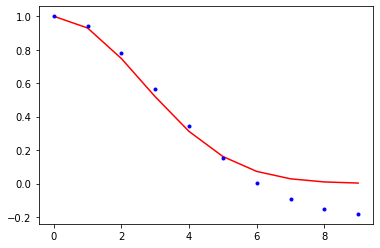

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 739
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.03482069 60.06158472 60.06335458 60.06325698 60.06317005]
Observation contribution to cost function [303.19018027 303.38944848 303.38619168 303.38662314 303.38692049]
Model contribution to cost function  [137.48723846 136.61543746 136.61692285 136.61658392 136.61636987]
The values of the cost function total [500.71223942 500.06647066 500.0664691  500.06646404 500.06646042]
RMS between background/truth and analysis/truth [0.30464874 0.05678646]
New estimate for variance coming from assimilation window 9: 0.04675216519681929
New estimate for correlation length coming from assimilation window 9: 2.4084195991039064


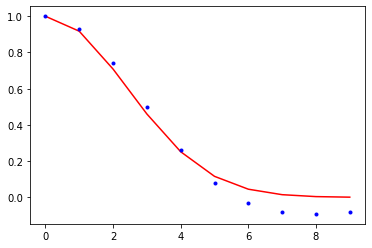

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 75
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [92.72052831 92.73300587 92.73204782 92.73523117 92.73302467]
Observation contribution to cost function [623.6043922  623.65006742 623.65234687 623.64277754 623.64749528]
Model contribution to cost function  [640.4553296  640.34655282 640.3452331  640.35161586 640.34909686]
The values of the cost function total [1356.7802501  1356.72962611 1356.72962779 1356.72962458 1356.7296168 ]
RMS between background/truth and analysis/truth [0.30331154 0.10136099]
New estimate for variance coming from assimilation window 0: 0.03298456538462883
New estimate for correlation length coming from assimilation window 0: 2.4216464963004722


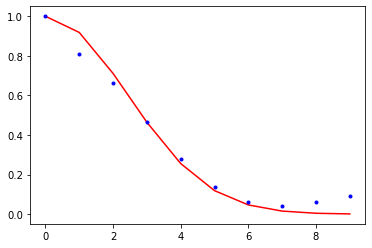

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 907
Number of inner iterations in outer iteration number 2: 419
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.11261263 53.09480099 53.09667191 53.09629123 53.09611484]
Observation contribution to cost function [291.48917394 291.65034927 291.64795488 291.65034639 291.65063526]
Model contribution to cost function  [218.19385747 217.86935544 217.86987542 217.8678535  217.86773599]
The values of the cost function total [562.79564403 562.6145057  562.61450221 562.61449112 562.61448609]
RMS between background/truth and analysis/truth [0.38732935 0.06043059]
New estimate for variance coming from assimilation window 1: 0.06919200964526727
New estimate for correlation length coming from assimilation window 1: 3.414767508166901


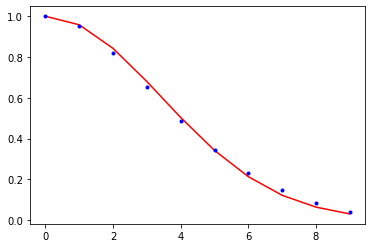

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 849
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [49.7518757  49.71510135 49.71588101 49.71584777 49.71580781]
Observation contribution to cost function [295.66896466 295.67089251 295.67056818 295.67071928 295.67082304]
Model contribution to cost function  [127.58414097 127.27290368 127.27245251 127.27233322 127.27226845]
The values of the cost function total [473.00498133 472.65889755 472.6589017  472.65890026 472.6588993 ]
RMS between background/truth and analysis/truth [0.30748647 0.05763839]
New estimate for variance coming from assimilation window 2: 0.048754484826928034
New estimate for correlation length coming from assimilation window 2: 3.090142639593828


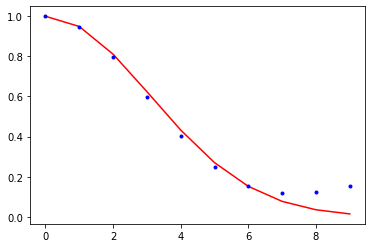

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 859
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [51.81579243 51.91760494 51.91902285 51.91894332 51.91886553]
Observation contribution to cost function [301.91530252 301.18066661 301.17781465 301.17820063 301.17851049]
Model contribution to cost function  [122.67190346 122.50337367 122.50482568 122.50451632 122.50428191]
The values of the cost function total [476.40299841 475.60164521 475.60166318 475.60166027 475.60165793]
RMS between background/truth and analysis/truth [0.28869034 0.05891795]
New estimate for variance coming from assimilation window 3: 0.038502010045078514
New estimate for correlation length coming from assimilation window 3: 2.557814945457236


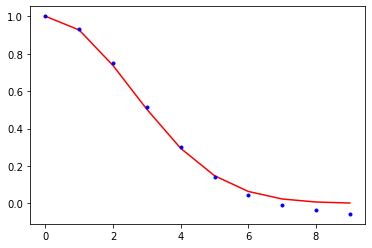

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 762
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.31526073 52.31103853 52.31230412 52.31217086 52.31206715]
Observation contribution to cost function [323.49310565 323.64925603 323.64658196 323.64699932 323.6472864 ]
Model contribution to cost function  [128.9127127  128.45904481 128.46044696 128.46015663 128.45996981]
The values of the cost function total [504.72107908 504.41933937 504.41933305 504.41932681 504.41932337]
RMS between background/truth and analysis/truth [0.2982627  0.05699131]
New estimate for variance coming from assimilation window 4: 0.0445733120448038
New estimate for correlation length coming from assimilation window 4: 2.5495884841275323


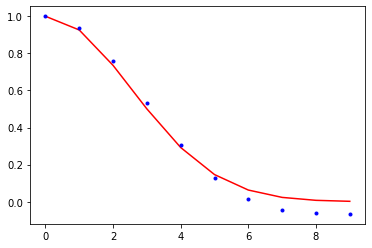

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 689
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.47096054 61.37963208 61.38131482 61.38119639 61.38109711]
Observation contribution to cost function [300.01373447 299.70143668 299.6996718  299.69985462 299.69994176]
Model contribution to cost function  [108.33081319 108.25665607 108.25673535 108.25667008 108.2566818 ]
The values of the cost function total [469.81550821 469.33772483 469.33772196 469.33772108 469.33772067]
RMS between background/truth and analysis/truth [0.31315572 0.05737583]
New estimate for variance coming from assimilation window 5: 0.04608614867651846
New estimate for correlation length coming from assimilation window 5: 3.253653804983978


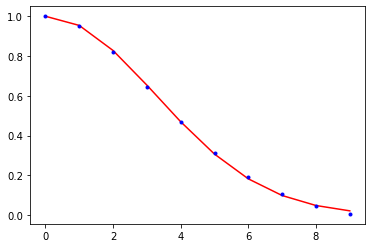

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 781
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.96627565 58.95672517 58.95815047 58.95805495 58.95797371]
Observation contribution to cost function [310.41876686 310.6564275  310.65479395 310.65522033 310.65551875]
Model contribution to cost function  [140.09703917 139.507083   139.50728441 139.50694959 139.50672954]
The values of the cost function total [509.48208167 509.12023567 509.12022883 509.12022486 509.12022199]
RMS between background/truth and analysis/truth [0.32508841 0.0582763 ]
New estimate for variance coming from assimilation window 6: 0.051026958947123315
New estimate for correlation length coming from assimilation window 6: 3.0694395628314197


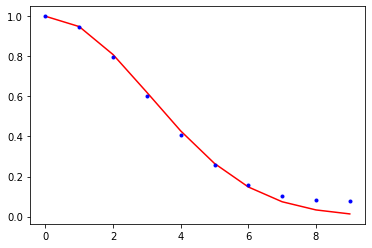

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 733
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.99402779 56.89961709 56.90095772 56.90086851 56.90080146]
Observation contribution to cost function [307.80712778 307.59520321 307.59357862 307.5936506  307.59371441]
Model contribution to cost function  [134.0384956  134.18067919 134.18095606 134.18096993 134.18097206]
The values of the cost function total [498.83965117 498.67549949 498.67549241 498.67548904 498.67548793]
RMS between background/truth and analysis/truth [0.32155316 0.05939468]
New estimate for variance coming from assimilation window 7: 0.05464887312020564
New estimate for correlation length coming from assimilation window 7: 3.327074525979031


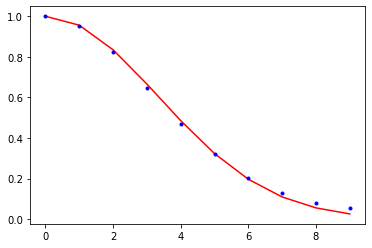

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 803
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [73.59246448 73.71267995 73.71446374 73.71435328 73.71425776]
Observation contribution to cost function [303.93754134 303.85899834 303.85698239 303.8572222  303.85741036]
Model contribution to cost function  [121.24219318 121.12106644 121.12128087 121.12114943 121.12105584]
The values of the cost function total [498.77219899 498.69274473 498.692727   498.69272491 498.69272397]
RMS between background/truth and analysis/truth [0.26631229 0.05893145]
New estimate for variance coming from assimilation window 8: 0.03882440933123861
New estimate for correlation length coming from assimilation window 8: 2.8883361246187684


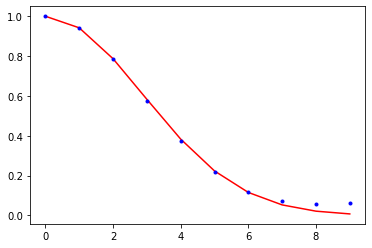

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 799
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [51.78875642 51.73336943 51.73500717 51.73488253 51.73478245]
Observation contribution to cost function [328.47390931 328.83702312 328.83444033 328.83468889 328.83487897]
Model contribution to cost function  [151.94462535 151.08539096 151.08632212 151.08619721 151.08610531]
The values of the cost function total [532.20729108 531.65578351 531.65576963 531.65576863 531.65576674]
RMS between background/truth and analysis/truth [0.3193057  0.05863407]
New estimate for variance coming from assimilation window 9: 0.05427503499819886
New estimate for correlation length coming from assimilation window 9: 2.442454700383174


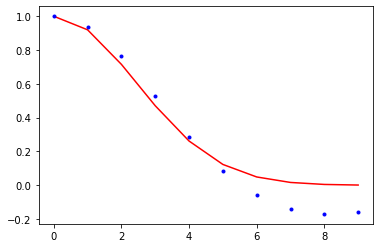

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 75
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [127.9651262  127.93192476 127.93093371 127.9344619  127.93205792]
Observation contribution to cost function [613.56361566 613.55503086 613.56185889 613.5491993  613.55777452]
Model contribution to cost function  [683.76095069 683.5681075  683.56227552 683.57140027 683.56522699]
The values of the cost function total [1425.28969255 1425.05506312 1425.05506813 1425.05506148 1425.05505944]
RMS between background/truth and analysis/truth [0.33333032 0.10864752]
New estimate for variance coming from assimilation window 0: 0.033406412758534544
New estimate for correlation length coming from assimilation window 0: 2.6386038119715027


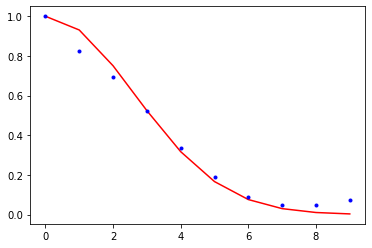

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 453
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.89131984 54.73471794 54.73518493 54.73510242 54.73506885]
Observation contribution to cost function [299.63534076 299.86566719 299.86499505 299.86530194 299.86544177]
Model contribution to cost function  [143.67297331 143.10988625 143.11008627 143.10985725 143.10974883]
The values of the cost function total [498.19963391 497.71027138 497.71026624 497.71026162 497.71025945]
RMS between background/truth and analysis/truth [0.29811222 0.05467711]
New estimate for variance coming from assimilation window 1: 0.04213548735959097
New estimate for correlation length coming from assimilation window 1: 2.4994141537291297


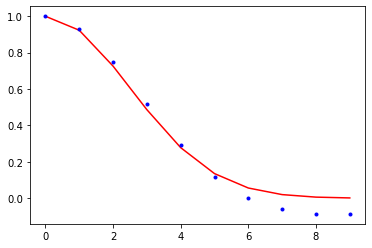

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 497
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [71.28520577 71.39556584 71.39689076 71.39674535 71.39663226]
Observation contribution to cost function [345.87960722 345.87365217 345.8733055  345.87401215 345.8744098 ]
Model contribution to cost function  [171.48245389 170.4358959  170.43491255 170.43434815 170.43406161]
The values of the cost function total [588.64726688 587.7051139  587.70510881 587.70510565 587.70510367]
RMS between background/truth and analysis/truth [0.33295051 0.05838346]
New estimate for variance coming from assimilation window 2: 0.05056252573239987
New estimate for correlation length coming from assimilation window 2: 3.138827003796882


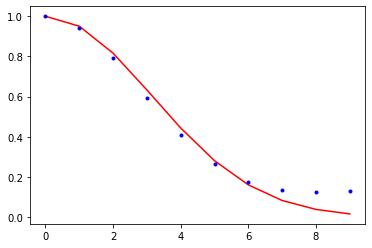

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 619
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [56.04068492 56.07487172 56.07659662 56.07645391 56.07633777]
Observation contribution to cost function [326.25500352 326.39661124 326.39403348 326.39433655 326.39452386]
Model contribution to cost function  [136.77022823 135.86370399 135.86455408 135.86439019 135.86431756]
The values of the cost function total [519.06591668 518.33518696 518.33518417 518.33518065 518.33517919]
RMS between background/truth and analysis/truth [0.31564991 0.05885677]
New estimate for variance coming from assimilation window 3: 0.04554424495620984
New estimate for correlation length coming from assimilation window 3: 2.578864935714772


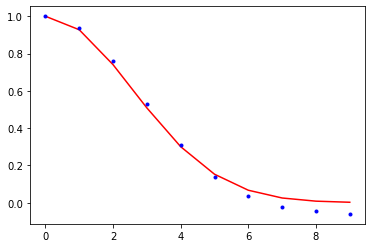

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 579
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.17658048 57.10901121 57.10974151 57.10972069 57.10967908]
Observation contribution to cost function [267.68837168 267.7446105  267.74371915 267.7438321  267.74394094]
Model contribution to cost function  [131.10243354 130.23988866 130.2400426  130.23994814 130.2398802 ]
The values of the cost function total [455.9673857  455.09351037 455.09350326 455.09350092 455.09350022]
RMS between background/truth and analysis/truth [0.30845707 0.0584744 ]
New estimate for variance coming from assimilation window 4: 0.040740232840390994
New estimate for correlation length coming from assimilation window 4: 2.2502416257846938


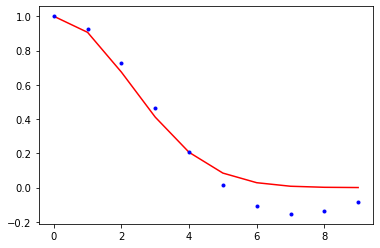

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 624
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.24300568 57.30949934 57.31119403 57.31106078 57.31094415]
Observation contribution to cost function [294.0526013  294.11997081 294.11713791 294.11746259 294.11763848]
Model contribution to cost function  [155.60630571 154.85806813 154.85919658 154.85900355 154.85894363]
The values of the cost function total [506.9019127  506.28753828 506.28752852 506.28752691 506.28752625]
RMS between background/truth and analysis/truth [0.35720671 0.05714499]
New estimate for variance coming from assimilation window 5: 0.055672200405906425
New estimate for correlation length coming from assimilation window 5: 2.7778644732989433


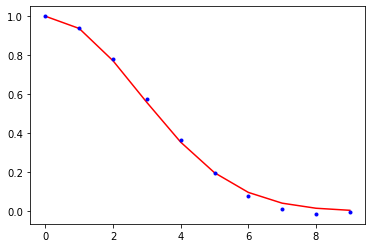

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 629
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.06310005 55.08571261 55.08721818 55.08714688 55.08704869]
Observation contribution to cost function [297.83764845 297.66730719 297.66542572 297.66561375 297.66576532]
Model contribution to cost function  [135.40825668 135.01056974 135.01094298 135.01082316 135.01076698]
The values of the cost function total [488.30900517 487.76358954 487.76358689 487.76358379 487.76358099]
RMS between background/truth and analysis/truth [0.30793834 0.05750834]
New estimate for variance coming from assimilation window 6: 0.04523923121252267
New estimate for correlation length coming from assimilation window 6: 2.6774527051458876


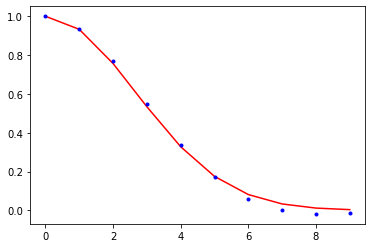

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 585
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [41.55004759 41.53149297 41.53206834 41.53200534 41.53196788]
Observation contribution to cost function [295.10323341 294.93027108 294.92900248 294.9290796  294.92913483]
Model contribution to cost function  [149.34343209 149.43864393 149.43933633 149.43931829 149.43929851]
The values of the cost function total [485.99671309 485.90040798 485.90040715 485.90040323 485.90040122]
RMS between background/truth and analysis/truth [0.32711149 0.05950092]
New estimate for variance coming from assimilation window 7: 0.05563166698769961
New estimate for correlation length coming from assimilation window 7: 2.882225552352048


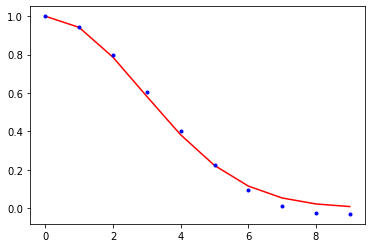

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 611
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.3192998  58.28263167 58.28397565 58.28388162 58.28380392]
Observation contribution to cost function [301.82025884 301.94070852 301.93842207 301.93871618 301.93889536]
Model contribution to cost function  [117.52202296 117.05556785 117.05650647 117.05630198 117.05619693]
The values of the cost function total [477.6615816  477.27890804 477.27890419 477.27889977 477.27889621]
RMS between background/truth and analysis/truth [0.28268447 0.05826623]
New estimate for variance coming from assimilation window 8: 0.04068738925981061
New estimate for correlation length coming from assimilation window 8: 3.4330615040251784


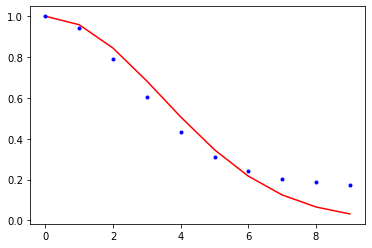

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 708
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.66682767 64.85621826 64.85875289 64.85850358 64.85833022]
Observation contribution to cost function [298.18165522 298.18149233 298.1790677  298.17962655 298.17990892]
Model contribution to cost function  [124.50542348 124.07728251 124.07716454 124.07685196 124.07674095]
The values of the cost function total [487.35390637 487.11499309 487.11498513 487.11498209 487.11498009]
RMS between background/truth and analysis/truth [0.33844413 0.0572452 ]
New estimate for variance coming from assimilation window 9: 0.046202780763535956
New estimate for correlation length coming from assimilation window 9: 2.654714030778301


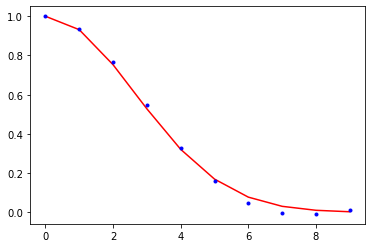

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 69
Number of inner iterations in outer iteration number 2: 25
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [142.05984438 142.05796895 142.05606841 142.06110203 142.0582901 ]
Observation contribution to cost function [563.85714362 563.85250681 563.86183878 563.84489613 563.85227044]
Model contribution to cost function  [767.60878242 767.27205937 767.26463382 767.27653575 767.27197047]
The values of the cost function total [1473.52577042 1473.18253512 1473.18254101 1473.18253392 1473.18253102]
RMS between background/truth and analysis/truth [0.34778334 0.10578469]
New estimate for variance coming from assimilation window 0: 0.04377716335227799
New estimate for correlation length coming from assimilation window 0: 2.932420972752765


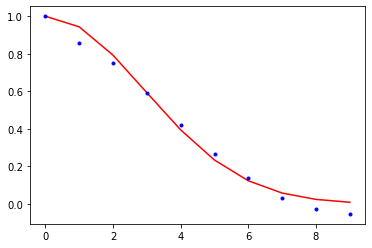

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 726
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.57781679 52.52191401 52.52328548 52.52317501 52.52310132]
Observation contribution to cost function [333.36674156 333.70013481 333.69765868 333.69805855 333.69835567]
Model contribution to cost function  [149.973476   148.98626596 148.98734382 148.98704917 148.98682306]
The values of the cost function total [535.91803435 535.20831479 535.20828798 535.20828273 535.20828005]
RMS between background/truth and analysis/truth [0.32100766 0.05836457]
New estimate for variance coming from assimilation window 1: 0.05174233394690661
New estimate for correlation length coming from assimilation window 1: 2.520210169484026


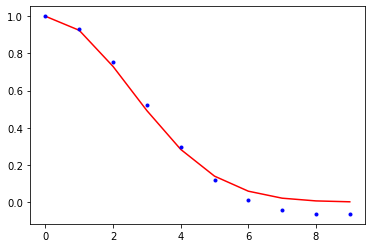

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 701
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [69.00978188 68.95786636 68.96008261 68.95993012 68.95977026]
Observation contribution to cost function [322.82738671 322.22559474 322.22228394 322.22263549 322.22298481]
Model contribution to cost function  [136.35850282 136.63255982 136.63363707 136.6334328  136.63324059]
The values of the cost function total [528.19567141 527.81602092 527.81600361 527.81599841 527.81599566]
RMS between background/truth and analysis/truth [0.32577702 0.05914252]
New estimate for variance coming from assimilation window 2: 0.05503029896092309
New estimate for correlation length coming from assimilation window 2: 3.2998495945379855


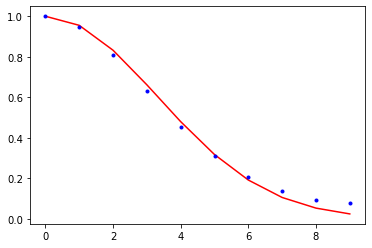

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 831
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.8976696  55.86759991 55.86842592 55.86834507 55.86828596]
Observation contribution to cost function [296.99653856 296.6708422  296.66913563 296.66945671 296.66966279]
Model contribution to cost function  [124.44189892 123.91654733 123.91740712 123.9171648  123.9170161 ]
The values of the cost function total [477.33610708 476.45498944 476.45496867 476.45496658 476.45496485]
RMS between background/truth and analysis/truth [0.2796787  0.05694315]
New estimate for variance coming from assimilation window 3: 0.03896098761074369
New estimate for correlation length coming from assimilation window 3: 2.3575427915140623


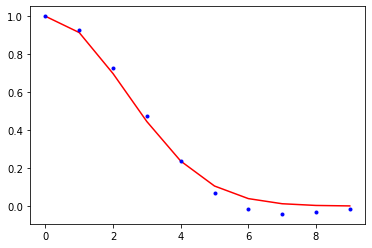

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 721
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [47.32103061 47.33073264 47.33164802 47.331551   47.33148848]
Observation contribution to cost function [275.2312159  274.98411676 274.98198013 274.98234644 274.98258443]
Model contribution to cost function  [137.71479083 137.37150797 137.37271541 137.37244364 137.37226699]
The values of the cost function total [460.26703735 459.68635738 459.68634356 459.68634107 459.6863399 ]
RMS between background/truth and analysis/truth [0.3158392  0.06169775]
New estimate for variance coming from assimilation window 4: 0.04692580805205468
New estimate for correlation length coming from assimilation window 4: 2.7149068222579826


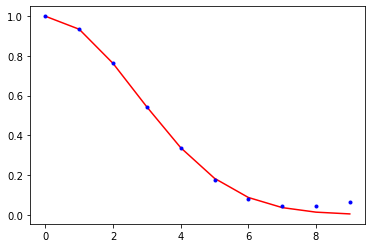

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 663
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [51.9813858  51.96852232 51.96910857 51.96906811 51.96901854]
Observation contribution to cost function [309.84619134 309.73064411 309.72946877 309.72966011 309.72977312]
Model contribution to cost function  [134.74675001 134.70198882 134.70256818 134.70241358 134.70234755]
The values of the cost function total [496.57432716 496.40115524 496.40114552 496.4011418  496.40113922]
RMS between background/truth and analysis/truth [0.28686087 0.05765689]
New estimate for variance coming from assimilation window 5: 0.04263883925768892
New estimate for correlation length coming from assimilation window 5: 2.9192877579793395


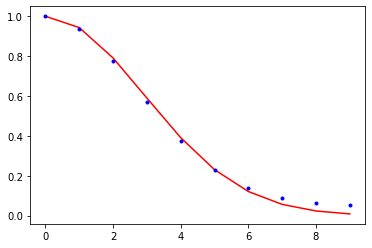

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 671
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.21991431 60.3042481  60.30562663 60.30551897 60.30542774]
Observation contribution to cost function [279.19040367 279.03403519 279.03186585 279.0321566  279.03237581]
Model contribution to cost function  [134.25309366 133.52470531 133.52548801 133.52530084 133.52517057]
The values of the cost function total [473.66341164 472.8629886  472.86298049 472.86297641 472.86297413]
RMS between background/truth and analysis/truth [0.34050846 0.05776513]
New estimate for variance coming from assimilation window 6: 0.058659906291064816
New estimate for correlation length coming from assimilation window 6: 3.229570971902297


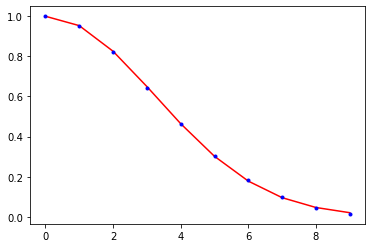

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 776
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.80041036 55.73797314 55.73910586 55.73899567 55.73893026]
Observation contribution to cost function [297.94899986 297.76080643 297.75902682 297.75945294 297.75972706]
Model contribution to cost function  [118.41549528 118.40600839 118.40665354 118.40633186 118.40612021]
The values of the cost function total [472.1649055  471.90478796 471.90478623 471.90478048 471.90477753]
RMS between background/truth and analysis/truth [0.3194504  0.05622951]
New estimate for variance coming from assimilation window 7: 0.049149723764669105
New estimate for correlation length coming from assimilation window 7: 2.8139578467044544


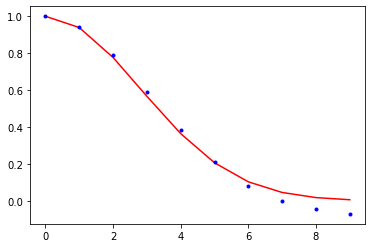

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 761
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.82869594 54.94190117 54.94378247 54.94364964 54.94353418]
Observation contribution to cost function [294.29456044 293.95154488 293.94911023 293.94948167 293.94972902]
Model contribution to cost function  [131.79951304 131.65513877 131.65569225 131.65545108 131.65531746]
The values of the cost function total [480.92276942 480.54858482 480.54858495 480.5485824  480.54858065]
RMS between background/truth and analysis/truth [0.32547997 0.05766076]
New estimate for variance coming from assimilation window 8: 0.05023284569826512
New estimate for correlation length coming from assimilation window 8: 2.547335215738574


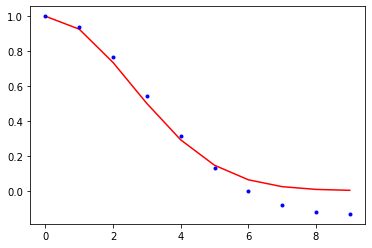

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 719
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.58496715 54.63120045 54.63232732 54.63227885 54.63221432]
Observation contribution to cost function [274.22854307 273.74338101 273.74252501 273.74278841 273.74297424]
Model contribution to cost function  [128.16374229 128.32786162 128.32758235 128.32736558 128.32724372]
The values of the cost function total [456.97725251 456.70244308 456.70243468 456.70243283 456.70243229]
RMS between background/truth and analysis/truth [0.30623226 0.05816627]
New estimate for variance coming from assimilation window 9: 0.044779935346321284
New estimate for correlation length coming from assimilation window 9: 2.751471219608717


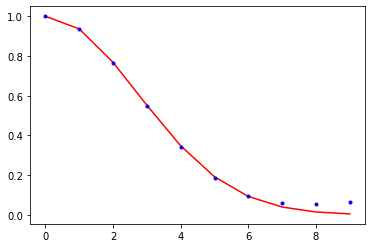

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 75
Number of inner iterations in outer iteration number 2: 21
Number of inner iterations in outer iteration number 3: 2
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [102.95300257 102.97047566 102.97206866 102.97182982 102.97156897]
Observation contribution to cost function [578.1563489  577.72115388 577.71910951 577.71833118 577.72085896]
Model contribution to cost function  [599.20102115 599.99450663 599.99495263 599.99596914 599.99369323]
The values of the cost function total [1280.31037262 1280.68613618 1280.6861308  1280.68613015 1280.68612115]
RMS between background/truth and analysis/truth [0.30127886 0.10259453]
New estimate for variance coming from assimilation window 0: 0.031719072457866496
New estimate for correlation length coming from assimilation window 0: 3.136572651772467


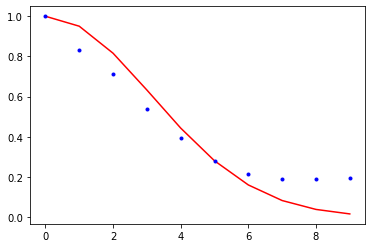

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 507
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [70.45412649 70.55831403 70.56013331 70.55997538 70.55984125]
Observation contribution to cost function [336.96449986 336.88506871 336.88211379 336.88252284 336.88276733]
Model contribution to cost function  [176.93314174 176.29853179 176.29967706 176.29942326 176.29930985]
The values of the cost function total [584.35176809 583.74191453 583.74192416 583.74192148 583.74191844]
RMS between background/truth and analysis/truth [0.3161502  0.05962049]
New estimate for variance coming from assimilation window 1: 0.052195624643522155
New estimate for correlation length coming from assimilation window 1: 2.9864648943058145


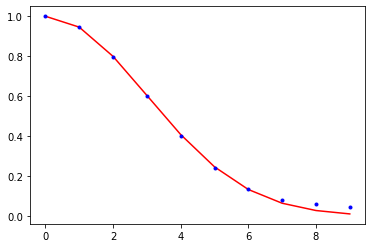

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 715
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [45.92123031 45.92443093 45.92523357 45.92514186 45.92507884]
Observation contribution to cost function [318.16547729 317.97341503 317.97164231 317.97204642 317.97228201]
Model contribution to cost function  [139.34777976 139.35346588 139.35443921 139.35411886 139.35394256]
The values of the cost function total [503.43448736 503.25131184 503.25131509 503.25130714 503.25130341]
RMS between background/truth and analysis/truth [0.32730283 0.0564066 ]
New estimate for variance coming from assimilation window 2: 0.04896251089144185
New estimate for correlation length coming from assimilation window 2: 2.775168497697865


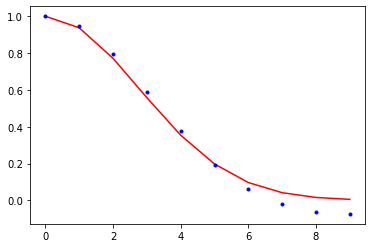

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 726
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [68.20753957 67.94416259 67.94615519 67.94596465 67.94582481]
Observation contribution to cost function [301.53370028 301.62197782 301.61735022 301.61808788 301.61862583]
Model contribution to cost function  [154.0293524  153.90671316 153.90934444 153.90879435 153.90839485]
The values of the cost function total [523.77059225 523.47285357 523.47284985 523.47284687 523.47284549]
RMS between background/truth and analysis/truth [0.29047368 0.0582518 ]
New estimate for variance coming from assimilation window 3: 0.0450538457503877
New estimate for correlation length coming from assimilation window 3: 2.7643622880224967


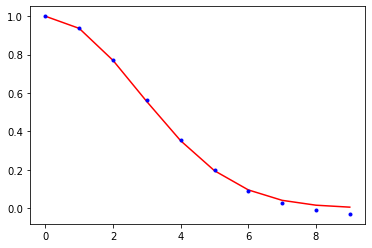

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 733
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.24463048 60.25098984 60.25337628 60.25321164 60.25308937]
Observation contribution to cost function [299.64073121 299.41498312 299.41099806 299.41137382 299.41164642]
Model contribution to cost function  [137.07805932 136.88677643 136.88837099 136.8881591  136.88800905]
The values of the cost function total [496.96342101 496.55274939 496.55274533 496.55274456 496.55274485]
RMS between background/truth and analysis/truth [0.33760568 0.05720603]
New estimate for variance coming from assimilation window 4: 0.05131199492106786
New estimate for correlation length coming from assimilation window 4: 2.6354022062852693


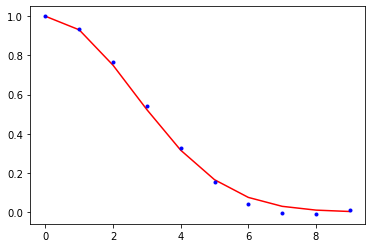

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 713
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.69310406 61.64753487 61.64913074 61.64900501 61.64890223]
Observation contribution to cost function [312.72474951 312.74334047 312.74085434 312.74113136 312.74134159]
Model contribution to cost function  [120.77124896 120.21959168 120.22047274 120.22031902 120.2202098 ]
The values of the cost function total [495.18910253 494.61046702 494.61045782 494.6104554  494.61045362]
RMS between background/truth and analysis/truth [0.30446383 0.05680135]
New estimate for variance coming from assimilation window 5: 0.04508352512190081
New estimate for correlation length coming from assimilation window 5: 2.9826335510229995


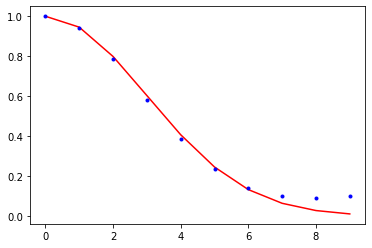

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 713
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.9140612  48.83301284 48.83469888 48.83456101 48.8344646 ]
Observation contribution to cost function [301.97431861 302.28277109 302.27996373 302.28041418 302.28072754]
Model contribution to cost function  [145.1284066  144.7787183  144.77983299 144.77951629 144.77929687]
The values of the cost function total [496.01678642 495.89450223 495.8944956  495.89449148 495.89448901]
RMS between background/truth and analysis/truth [0.33401701 0.058972  ]
New estimate for variance coming from assimilation window 6: 0.05296422342237707
New estimate for correlation length coming from assimilation window 6: 3.125896681870812


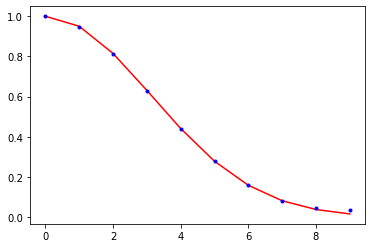

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 755
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [50.53223759 50.46033439 50.46142971 50.46135609 50.46129712]
Observation contribution to cost function [312.72331621 313.03759463 313.03656716 313.03683681 313.03701289]
Model contribution to cost function  [136.41026698 136.11363215 136.11356764 136.11336704 136.11324697]
The values of the cost function total [499.66582079 499.61156116 499.6115645  499.61155995 499.61155698]
RMS between background/truth and analysis/truth [0.34277378 0.06056133]
New estimate for variance coming from assimilation window 7: 0.057693186317577264
New estimate for correlation length coming from assimilation window 7: 3.2945190328316682


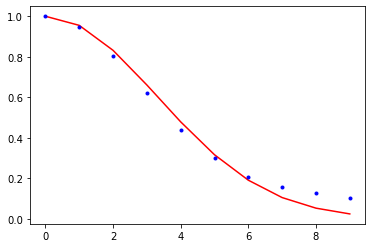

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 787
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.4667872  55.40883047 55.40978775 55.40969243 55.40960603]
Observation contribution to cost function [310.23756924 309.97363041 309.97246838 309.97272823 309.97295205]
Model contribution to cost function  [125.8639135  126.09202575 126.09221202 126.09204516 126.09190716]
The values of the cost function total [491.56826994 491.47448663 491.47446816 491.47446582 491.47446525]
RMS between background/truth and analysis/truth [0.30868619 0.05956345]
New estimate for variance coming from assimilation window 8: 0.04540489733972008
New estimate for correlation length coming from assimilation window 8: 3.81706086039183


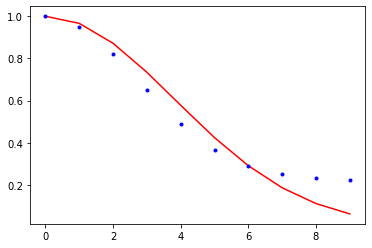

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 849
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.53940916 58.49354    58.49577436 58.49563036 58.49550923]
Observation contribution to cost function [321.97567767 322.03685245 322.03301351 322.03350988 322.03384765]
Model contribution to cost function  [134.8678575  133.95684985 133.95843502 133.95807836 133.95785838]
The values of the cost function total [515.38294434 514.48724231 514.48722289 514.48721859 514.48721526]
RMS between background/truth and analysis/truth [0.3332438  0.05736151]
New estimate for variance coming from assimilation window 9: 0.046746556487452164
New estimate for correlation length coming from assimilation window 9: 3.583046768253805


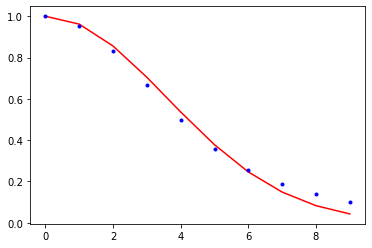

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 75
Number of inner iterations in outer iteration number 2: 21
Number of inner iterations in outer iteration number 3: 2
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [98.19444992 98.19024766 98.19164437 98.19311782 98.19169162]
Observation contribution to cost function [538.04828926 537.78673729 537.78419999 537.77914452 537.78432178]
Model contribution to cost function  [491.48275913 491.98176864 491.98289666 491.98649094 491.98272127]
The values of the cost function total [1127.72549832 1127.95875359 1127.95874102 1127.95875328 1127.95873466]
RMS between background/truth and analysis/truth [0.29173998 0.10295928]
New estimate for variance coming from assimilation window 0: 0.02576168099192873
New estimate for correlation length coming from assimilation window 0: 2.6463186378086054


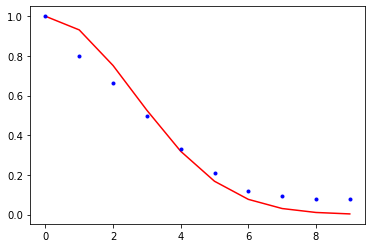

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 837
Number of inner iterations in outer iteration number 2: 355
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.32359298 53.26932258 53.27043718 53.27029377 53.27018087]
Observation contribution to cost function [332.97084161 332.84032053 332.83852114 332.83906492 332.83938584]
Model contribution to cost function  [207.19872615 205.96664803 205.96732827 205.96692532 205.96671579]
The values of the cost function total [593.49316074 592.07629114 592.07628659 592.07628401 592.07628251]
RMS between background/truth and analysis/truth [0.31238786 0.06144604]
New estimate for variance coming from assimilation window 1: 0.048849900896488434
New estimate for correlation length coming from assimilation window 1: 2.91775745681238


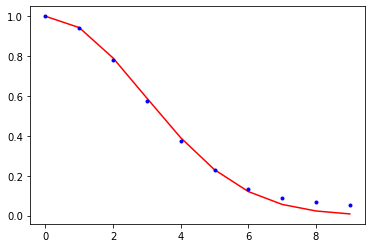

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 541
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.35857925 52.33494386 52.33585132 52.33575528 52.33567282]
Observation contribution to cost function [294.37098333 294.48865922 294.48760544 294.48779103 294.48792038]
Model contribution to cost function  [146.91461473 145.80194336 145.80208195 145.80199012 145.80194242]
The values of the cost function total [493.64417731 492.62554644 492.6255387  492.62553642 492.62553562]
RMS between background/truth and analysis/truth [0.33081881 0.05800589]
New estimate for variance coming from assimilation window 2: 0.05495699357130124
New estimate for correlation length coming from assimilation window 2: 3.0297118977763726


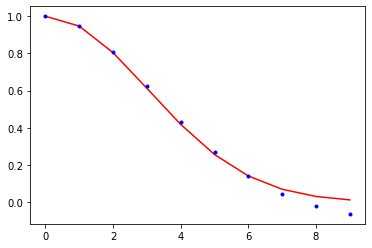

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 655
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [67.59765704 67.51639122 67.5187081  67.51860939 67.51849615]
Observation contribution to cost function [316.02121409 316.06794378 316.06450026 316.06469444 316.06486371]
Model contribution to cost function  [137.57918722 137.18523316 137.18636688 137.18627048 137.18621298]
The values of the cost function total [521.19805834 520.76956816 520.76957524 520.76957431 520.76957284]
RMS between background/truth and analysis/truth [0.30415367 0.06045454]
New estimate for variance coming from assimilation window 3: 0.045878930099268536
New estimate for correlation length coming from assimilation window 3: 2.6393369613783375


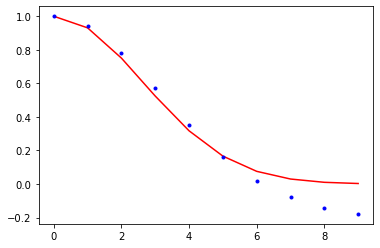

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 593
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.73453339 48.77961554 48.78030854 48.78027019 48.78022372]
Observation contribution to cost function [303.42254273 303.15606392 303.15566151 303.15576242 303.15585176]
Model contribution to cost function  [127.25782161 127.14604561 127.14575326 127.14568922 127.1456459 ]
The values of the cost function total [479.41489774 479.08172507 479.08172331 479.08172182 479.08172138]
RMS between background/truth and analysis/truth [0.32137108 0.05620079]
New estimate for variance coming from assimilation window 4: 0.048568189274592596
New estimate for correlation length coming from assimilation window 4: 3.036563156562001


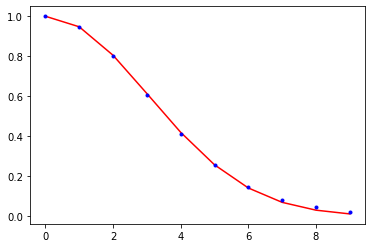

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 709
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.22632849 64.28160472 64.2832265  64.28316184 64.2830951 ]
Observation contribution to cost function [320.54271476 320.24328984 320.24124565 320.24134922 320.24144544]
Model contribution to cost function  [129.86976357 129.31445654 129.31487634 129.31483693 129.31480647]
The values of the cost function total [514.63880682 513.8393511  513.83934849 513.83934798 513.839347  ]
RMS between background/truth and analysis/truth [0.31249716 0.05863782]
New estimate for variance coming from assimilation window 5: 0.04219609543721523
New estimate for correlation length coming from assimilation window 5: 2.7594528259704845


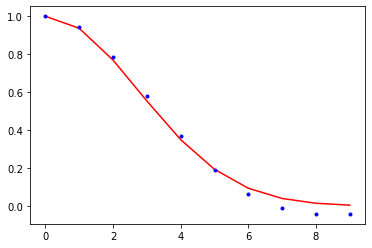

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 679
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [52.03723676 51.99824011 51.99846371 51.99847024 51.99845009]
Observation contribution to cost function [299.15146025 298.77511219 298.77490225 298.77486336 298.77485146]
Model contribution to cost function  [166.99373355 167.02511784 167.02510427 167.02513138 167.02515975]
The values of the cost function total [518.18243057 517.79847014 517.79847023 517.79846498 517.7984613 ]
RMS between background/truth and analysis/truth [0.3474676  0.05523017]
New estimate for variance coming from assimilation window 6: 0.06385752867749371
New estimate for correlation length coming from assimilation window 6: 2.5667781825373437


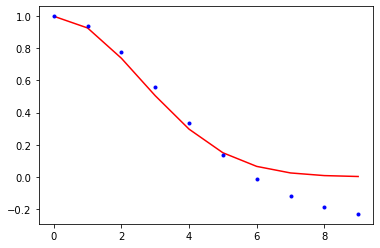

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 722
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.02779806 55.0891247  55.09028773 55.09019815 55.09013793]
Observation contribution to cost function [280.09316394 280.36046765 280.3593225  280.35949951 280.3595741 ]
Model contribution to cost function  [128.13705867 127.83717989 127.83715002 127.83705623 127.83703773]
The values of the cost function total [463.25802067 463.28677224 463.28676025 463.28675389 463.28674976]
RMS between background/truth and analysis/truth [0.3217178  0.05867846]
New estimate for variance coming from assimilation window 7: 0.05044838883017411
New estimate for correlation length coming from assimilation window 7: 2.7813102698084133


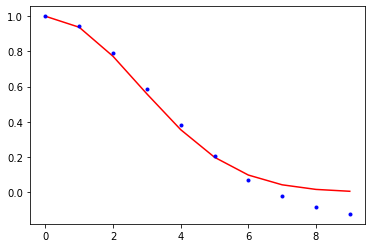

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 733
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [50.87148537 50.93984443 50.94071972 50.94065188 50.94058389]
Observation contribution to cost function [323.26188573 323.24461691 323.24379283 323.24419333 323.24445396]
Model contribution to cost function  [120.88356844 120.47579407 120.47573534 120.47539695 120.47520008]
The values of the cost function total [495.01693954 494.66025541 494.66024789 494.66024216 494.66023793]
RMS between background/truth and analysis/truth [0.33794719 0.06022701]
New estimate for variance coming from assimilation window 8: 0.04921366176621313
New estimate for correlation length coming from assimilation window 8: 3.152858368192005


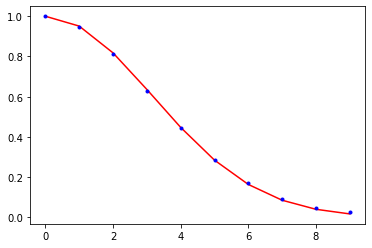

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 745
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.35486927 55.23785912 55.23898802 55.23890202 55.23883744]
Observation contribution to cost function [319.53628901 319.25249873 319.25198542 319.25210091 319.25218409]
Model contribution to cost function  [138.00012993 137.74993333 137.74930992 137.74927801 137.74925885]
The values of the cost function total [512.8912882  512.24029117 512.24028336 512.24028095 512.24028038]
RMS between background/truth and analysis/truth [0.3409641  0.05935966]
New estimate for variance coming from assimilation window 9: 0.059143066089744935
New estimate for correlation length coming from assimilation window 9: 2.776779082532477


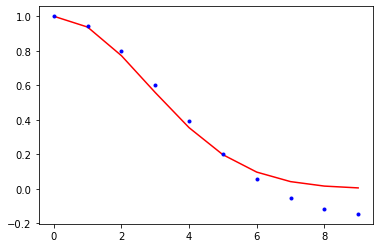

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 75
Number of inner iterations in outer iteration number 2: 25
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [102.50589386 102.47581101 102.47477259 102.4778275  102.4753197 ]
Observation contribution to cost function [543.4009379  543.26594792 543.27197037 543.26128793 543.26984564]
Model contribution to cost function  [648.19718526 648.12676915 648.12177357 648.12940392 648.12334394]
The values of the cost function total [1294.10401703 1293.86852808 1293.86851653 1293.86851935 1293.86850929]
RMS between background/truth and analysis/truth [0.31077457 0.10012187]
New estimate for variance coming from assimilation window 0: 0.03516408380714852
New estimate for correlation length coming from assimilation window 0: 2.952179412591239


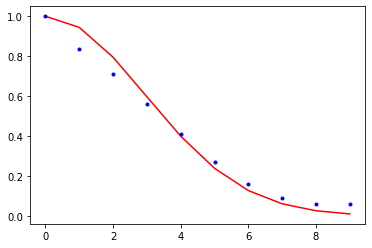

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 513
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [58.23902525 58.24193373 58.24367025 58.2436038  58.24352201]
Observation contribution to cost function [298.87203305 298.79223194 298.79078295 298.79091496 298.79104194]
Model contribution to cost function  [136.20080545 136.03719118 136.03689413 136.03682614 136.03677868]
The values of the cost function total [493.31186375 493.07135685 493.07134733 493.0713449  493.07134263]
RMS between background/truth and analysis/truth [0.27392866 0.05946366]
New estimate for variance coming from assimilation window 1: 0.035454339196307826
New estimate for correlation length coming from assimilation window 1: 2.8614073400541864


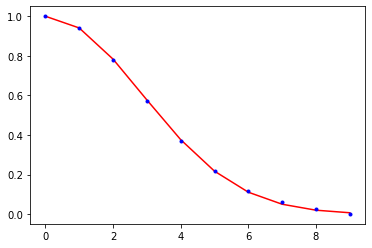

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 503
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.39519113 57.41636373 57.41786085 57.4177056  57.41758678]
Observation contribution to cost function [326.11833744 325.84989176 325.84727322 325.8478544  325.84826398]
Model contribution to cost function  [180.5515986  179.95919148 179.960307   179.9598777  179.95958629]
The values of the cost function total [564.06512717 563.22544697 563.22544107 563.2254377  563.22543704]
RMS between background/truth and analysis/truth [0.31799219 0.0567298 ]
New estimate for variance coming from assimilation window 2: 0.052550172341736257
New estimate for correlation length coming from assimilation window 2: 3.013101406463888


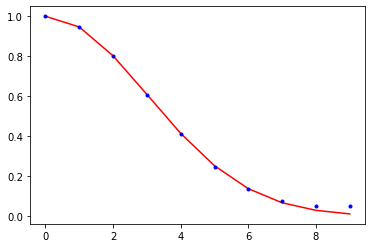

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 589
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [50.05329615 50.10228352 50.10350988 50.10342154 50.10335767]
Observation contribution to cost function [293.57669552 293.61511208 293.6143071  293.6145224  293.61468491]
Model contribution to cost function  [139.23517256 138.86228767 138.86185691 138.86172872 138.86162923]
The values of the cost function total [482.86516424 482.57968327 482.57967389 482.57967266 482.57967181]
RMS between background/truth and analysis/truth [0.31878476 0.06129161]
New estimate for variance coming from assimilation window 3: 0.05301222541931673
New estimate for correlation length coming from assimilation window 3: 3.99416047992105


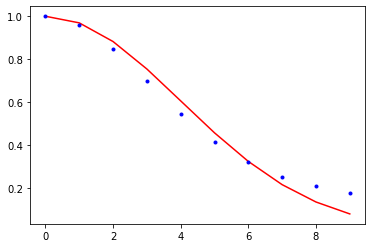

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 749
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.58076019 65.61806888 65.6197691  65.61967466 65.61959562]
Observation contribution to cost function [329.31428385 329.27353649 329.2716251  329.27181768 329.27201045]
Model contribution to cost function  [128.9739162  128.11327896 128.11345979 128.11335584 128.11323823]
The values of the cost function total [523.86896025 523.00488432 523.00485399 523.00484819 523.0048443 ]
RMS between background/truth and analysis/truth [0.30859993 0.0592234 ]
New estimate for variance coming from assimilation window 4: 0.04002342871842345
New estimate for correlation length coming from assimilation window 4: 2.762001788512018


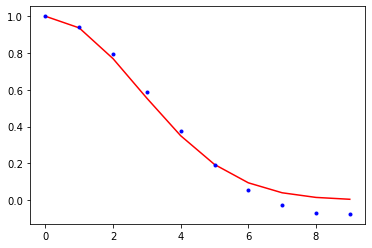

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 761
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.57771908 55.51125426 55.51293032 55.512811   55.51270715]
Observation contribution to cost function [321.62370238 321.48779473 321.48628915 321.48663206 321.48686851]
Model contribution to cost function  [125.33665947 124.72914436 124.72897372 124.72874454 124.72860822]
The values of the cost function total [502.53808093 501.72819335 501.72819318 501.7281876  501.72818388]
RMS between background/truth and analysis/truth [0.37726353 0.05825319]
New estimate for variance coming from assimilation window 5: 0.057910596393015316
New estimate for correlation length coming from assimilation window 5: 4.916943240024446


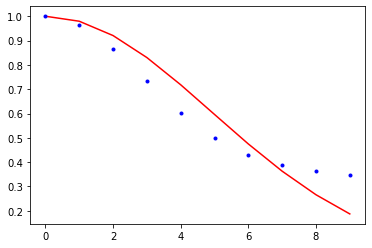

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 959
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.33979226 61.36714317 61.36953367 61.36937418 61.36924405]
Observation contribution to cost function [318.40367022 318.62925532 318.62532702 318.62564827 318.62589985]
Model contribution to cost function  [139.53197149 139.01989496 139.02140133 139.0212366  139.02111336]
The values of the cost function total [519.27543397 519.01629345 519.01626203 519.01625905 519.01625726]
RMS between background/truth and analysis/truth [0.3501459  0.05986935]
New estimate for variance coming from assimilation window 6: 0.05696757307993871
New estimate for correlation length coming from assimilation window 6: 3.5951600954926457


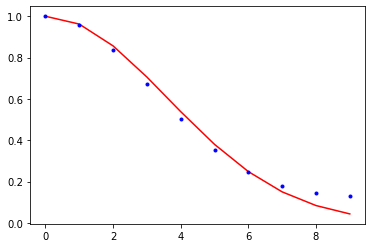

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [69.82477142 69.82255622 69.82469988 69.82458773 69.8245266 ]
Observation contribution to cost function [326.45782756 326.60151752 326.5997509  326.59985984 326.59995345]
Model contribution to cost function  [121.65166026 121.39019468 121.38977361 121.38977218 121.38973751]
The values of the cost function total [517.93425924 517.81426843 517.81422439 517.81421975 517.81421757]
RMS between background/truth and analysis/truth [0.33395102 0.06031798]
New estimate for variance coming from assimilation window 7: 0.04999710507326578
New estimate for correlation length coming from assimilation window 7: 2.998154225801324


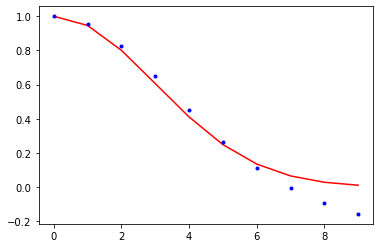

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 959
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.38733382 64.46044343 64.46341114 64.46323377 64.46307861]
Observation contribution to cost function [328.5256868  327.91668298 327.91291679 327.9134176  327.9137778 ]
Model contribution to cost function  [133.06820127 133.3077846  133.30859655 133.30826645 133.3080581 ]
The values of the cost function total [525.98122189 525.684911   525.68492448 525.68491782 525.68491451]
RMS between background/truth and analysis/truth [0.30437206 0.06120134]
New estimate for variance coming from assimilation window 8: 0.043923052784962634
New estimate for correlation length coming from assimilation window 8: 2.7057980168423277


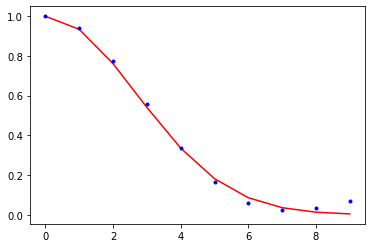

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 971
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.95251933 63.91589146 63.91828375 63.91817897 63.91808348]
Observation contribution to cost function [356.48654432 356.43297052 356.42969362 356.43003512 356.43029834]
Model contribution to cost function  [131.54364468 130.78767376 130.7885312  130.78829146 130.78812235]
The values of the cost function total [551.98270833 551.13653574 551.13650858 551.13650554 551.13650417]
RMS between background/truth and analysis/truth [0.3318786  0.05987407]
New estimate for variance coming from assimilation window 9: 0.04288643159908717
New estimate for correlation length coming from assimilation window 9: 2.884589160704443


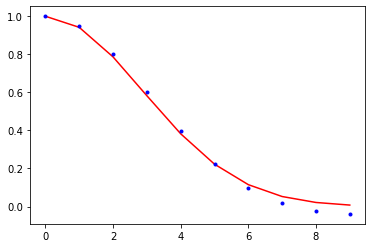

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 69
Number of inner iterations in outer iteration number 2: 21
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [83.68109815 83.69640101 83.69579011 83.69779789 83.69694427]
Observation contribution to cost function [573.2738901  573.07350281 573.0769112  573.06949806 573.07100559]
Model contribution to cost function  [653.55636386 653.92862077 653.92583915 653.93123149 653.93057689]
The values of the cost function total [1310.51135211 1310.69852459 1310.69854046 1310.69852743 1310.69852675]
RMS between background/truth and analysis/truth [0.3121324  0.10079728]
New estimate for variance coming from assimilation window 0: 0.037237331327285676
New estimate for correlation length coming from assimilation window 0: 3.866677364437932


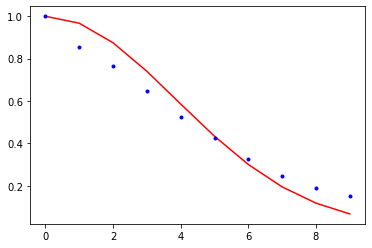

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 825
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [74.74084201 74.8811408  74.88331095 74.88311737 74.88297655]
Observation contribution to cost function [368.99075558 368.32378093 368.31929036 368.32011219 368.32062794]
Model contribution to cost function  [147.4954176  147.43509027 147.4374148  147.43678027 147.43640127]
The values of the cost function total [591.22701519 590.640012   590.64001611 590.64000983 590.64000577]
RMS between background/truth and analysis/truth [0.27910548 0.0615889 ]
New estimate for variance coming from assimilation window 1: 0.036522908564597126
New estimate for correlation length coming from assimilation window 1: 2.875861241059878


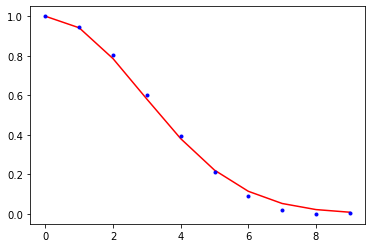

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 671
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [67.13356974 67.1798601  67.18226622 67.18213358 67.18200355]
Observation contribution to cost function [345.08851589 345.60333251 345.60013079 345.60041745 345.60068029]
Model contribution to cost function  [149.45544582 148.23387166 148.23466335 148.23450767 148.23437456]
The values of the cost function total [561.67753145 561.01706428 561.01706037 561.0170587  561.01705839]
RMS between background/truth and analysis/truth [0.30122494 0.05796021]
New estimate for variance coming from assimilation window 2: 0.04212243360826163
New estimate for correlation length coming from assimilation window 2: 3.4042470094977624


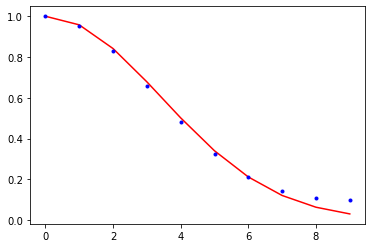

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 759
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.05242194 63.12732084 63.13008958 63.12991418 63.12974204]
Observation contribution to cost function [354.05483706 353.97517998 353.97099243 353.97139938 353.97174789]
Model contribution to cost function  [156.20340096 155.89537062 155.89677545 155.89654188 155.89636425]
The values of the cost function total [573.31065996 572.99787144 572.99785745 572.99785544 572.99785418]
RMS between background/truth and analysis/truth [0.31745676 0.0574366 ]
New estimate for variance coming from assimilation window 3: 0.04885090158831522
New estimate for correlation length coming from assimilation window 3: 3.317923615932445


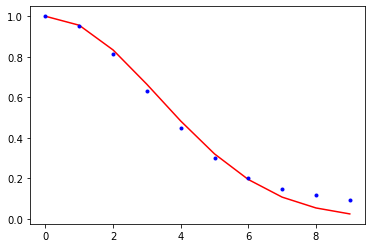

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 791
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [77.05755289 77.1483398  77.1510145  77.15086265 77.15074101]
Observation contribution to cost function [322.50657214 321.92917082 321.92633565 321.92660598 321.92681775]
Model contribution to cost function  [141.05696733 140.02267769 140.02285956 140.02273853 140.02264725]
The values of the cost function total [540.62109237 539.10018831 539.10020971 539.10020716 539.100206  ]
RMS between background/truth and analysis/truth [0.36161728 0.06006461]
New estimate for variance coming from assimilation window 4: 0.052559686658753005
New estimate for correlation length coming from assimilation window 4: 3.668601541327475


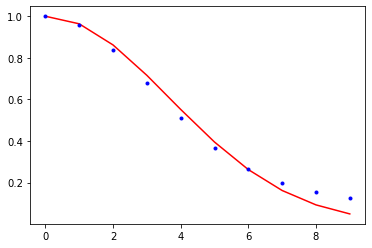

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 835
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [84.59950279 84.59836943 84.60109486 84.60093264 84.60078622]
Observation contribution to cost function [352.80138498 352.64632952 352.64270835 352.64319717 352.64358745]
Model contribution to cost function  [138.54300555 138.13582888 138.13672739 138.13639704 138.13615177]
The values of the cost function total [575.94389331 575.38052783 575.3805306  575.38052686 575.38052544]
RMS between background/truth and analysis/truth [0.29136714 0.06251717]
New estimate for variance coming from assimilation window 5: 0.04051156297785307
New estimate for correlation length coming from assimilation window 5: 3.755395694555695


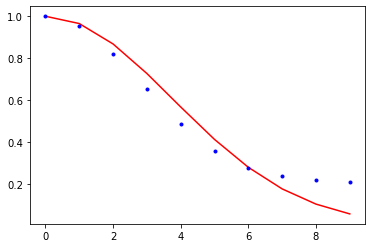

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 911
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.33628424 57.51876173 57.51974154 57.51971541 57.51967688]
Observation contribution to cost function [330.49040236 330.95618891 330.95635519 330.95638739 330.95648811]
Model contribution to cost function  [154.39920767 153.07871889 153.07756157 153.07754838 153.07748174]
The values of the cost function total [542.22589426 541.55366953 541.5536583  541.55365118 541.55364674]
RMS between background/truth and analysis/truth [0.37171676 0.05892993]
New estimate for variance coming from assimilation window 6: 0.06016062482962088
New estimate for correlation length coming from assimilation window 6: 3.2286036711659403


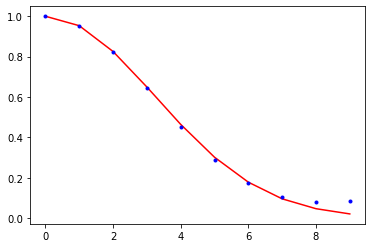

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 915
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.0439587  52.86750501 52.86974219 52.86966449 52.8695662 ]
Observation contribution to cost function [378.51833388 378.59175412 378.58871101 378.58890818 378.58909938]
Model contribution to cost function  [117.42001508 116.9792531  116.98005961 116.97993944 116.97984512]
The values of the cost function total [548.98230766 548.43851223 548.4385128  548.43851212 548.4385107 ]
RMS between background/truth and analysis/truth [0.31259472 0.0566848 ]
New estimate for variance coming from assimilation window 7: 0.04013969136899043
New estimate for correlation length coming from assimilation window 7: 2.841466518131738


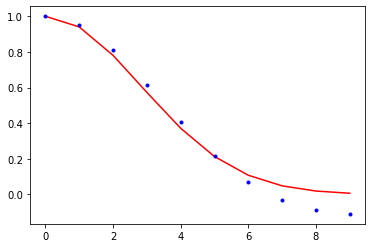

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 867
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [67.57347555 67.7216092  67.72423413 67.7240707  67.7239299 ]
Observation contribution to cost function [380.83268516 380.90711412 380.9017342  380.9023185  380.90275423]
Model contribution to cost function  [164.92258782 165.15053992 165.15326544 165.15284264 165.15254429]
The values of the cost function total [613.32874853 613.77926325 613.77923376 613.77923184 613.77922842]
RMS between background/truth and analysis/truth [0.2967153  0.06010185]
New estimate for variance coming from assimilation window 8: 0.04882941460405382
New estimate for correlation length coming from assimilation window 8: 3.221728569647462


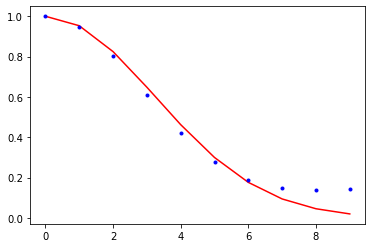

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 899
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.26430184 63.13729417 63.13879788 63.13870821 63.13863151]
Observation contribution to cost function [344.24209217 343.42155715 343.42000529 343.42019961 343.42032567]
Model contribution to cost function  [137.52485593 137.00479811 137.00483969 137.00473201 137.00467898]
The values of the cost function total [545.03124994 543.56364943 543.56364285 543.56363983 543.56363616]
RMS between background/truth and analysis/truth [0.33720365 0.06284292]
New estimate for variance coming from assimilation window 9: 0.055417493270867146
New estimate for correlation length coming from assimilation window 9: 3.3143749595609937


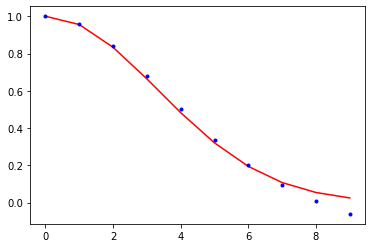

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 77
Number of inner iterations in outer iteration number 2: 21
Number of inner iterations in outer iteration number 3: 2
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [82.96248786 82.94050863 82.9417039  82.94075093 82.94116876]
Observation contribution to cost function [553.72621708 554.04171038 554.03649869 554.03861779 554.03609009]
Model contribution to cost function  [568.84810784 567.64927546 567.65328067 567.65211567 567.65421668]
The values of the cost function total [1205.53681278 1204.63149447 1204.63148326 1204.63148439 1204.63147552]
RMS between background/truth and analysis/truth [0.27615541 0.09747649]
New estimate for variance coming from assimilation window 0: 0.02862028936708418
New estimate for correlation length coming from assimilation window 0: 3.0224183176706974


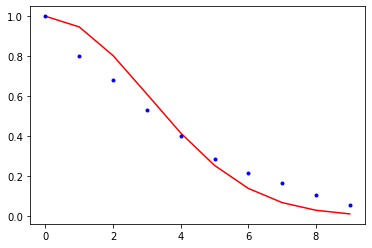

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 457
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [73.9397212  73.81060305 73.81305021 73.81280494 73.81260291]
Observation contribution to cost function [327.76444201 327.79836468 327.79559159 327.79607981 327.79642339]
Model contribution to cost function  [178.43310866 178.29303934 178.29335199 178.29310807 178.29296646]
The values of the cost function total [580.13727188 579.90200707 579.90199379 579.90199282 579.90199275]
RMS between background/truth and analysis/truth [0.30497873 0.05897293]
New estimate for variance coming from assimilation window 1: 0.04429777226606604
New estimate for correlation length coming from assimilation window 1: 3.330759078303154


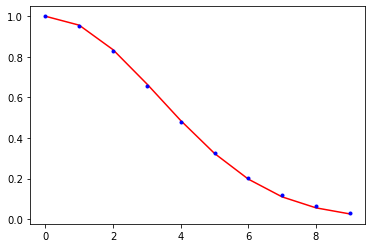

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 649
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [67.3129252  67.26565573 67.26712246 67.26700469 67.2668932 ]
Observation contribution to cost function [345.87952002 346.04036692 346.03722088 346.037801   346.03818453]
Model contribution to cost function  [159.94468815 159.45314716 159.45482293 159.45435612 159.45408117]
The values of the cost function total [573.13713337 572.75916981 572.75916626 572.75916181 572.7591589 ]
RMS between background/truth and analysis/truth [0.31267258 0.05590095]
New estimate for variance coming from assimilation window 2: 0.04666909576496625
New estimate for correlation length coming from assimilation window 2: 2.7307604479149385


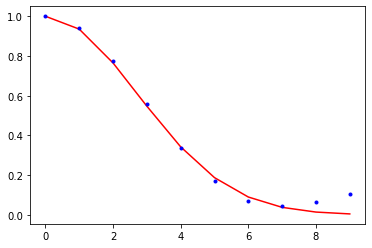

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 649
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.88116554 65.93637054 65.9379243  65.93783445 65.93774667]
Observation contribution to cost function [297.17482516 296.88949118 296.88717695 296.88745696 296.88765954]
Model contribution to cost function  [135.17451027 134.94955681 134.95032073 134.95012772 134.95001024]
The values of the cost function total [498.23050098 497.77541854 497.77542198 497.77541913 497.77541644]
RMS between background/truth and analysis/truth [0.29601484 0.05927776]
New estimate for variance coming from assimilation window 3: 0.041276263095190266
New estimate for correlation length coming from assimilation window 3: 2.7708551637006824


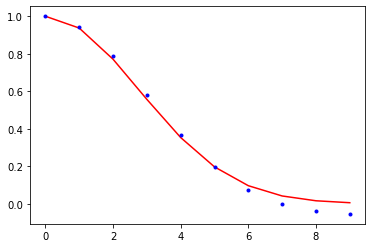

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 641
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.05756905 59.94561285 59.94661658 59.94656864 59.94650885]
Observation contribution to cost function [297.67146012 298.00220281 298.00079803 298.00103338 298.00120364]
Model contribution to cost function  [140.31787311 140.36914537 140.3695448  140.36935689 140.36924521]
The values of the cost function total [498.04690227 498.31696103 498.31695942 498.31695891 498.3169577 ]
RMS between background/truth and analysis/truth [0.35241568 0.06163519]
New estimate for variance coming from assimilation window 4: 0.04875232807596438
New estimate for correlation length coming from assimilation window 4: 3.0429035536958047


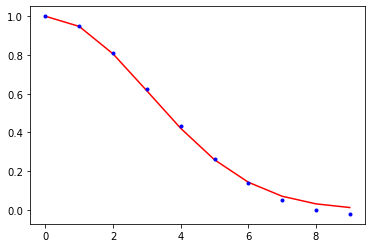

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 705
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [55.88461642 55.85660855 55.85931881 55.85912189 55.8589527 ]
Observation contribution to cost function [292.45051941 292.55611991 292.55144899 292.55204634 292.55249011]
Model contribution to cost function  [143.49845731 142.11139381 142.11335939 142.11295562 142.11268059]
The values of the cost function total [491.83359314 490.52412227 490.52412719 490.52412385 490.5241234 ]
RMS between background/truth and analysis/truth [0.30474172 0.05781867]
New estimate for variance coming from assimilation window 5: 0.04425063054671933
New estimate for correlation length coming from assimilation window 5: 3.0617352336553245


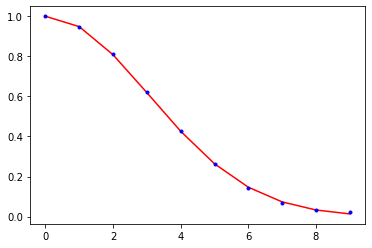

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 643
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [53.05393985 53.06801474 53.06894668 53.06886651 53.06880301]
Observation contribution to cost function [329.77319389 329.59108525 329.58901894 329.58929802 329.58949299]
Model contribution to cost function  [118.15955884 118.20477913 118.20591578 118.20571474 118.20558093]
The values of the cost function total [500.98669258 500.86387911 500.8638814  500.86387926 500.86387692]
RMS between background/truth and analysis/truth [0.28088877 0.05638182]
New estimate for variance coming from assimilation window 6: 0.0383662936774492
New estimate for correlation length coming from assimilation window 6: 2.9482842623332517


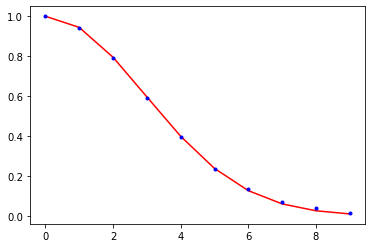

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 667
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.25146215 60.2081672  60.2099468  60.20981546 60.20970164]
Observation contribution to cost function [316.4727189  316.54808014 316.54532544 316.54557225 316.54578454]
Model contribution to cost function  [143.28687191 142.91833757 142.91929237 142.9191743  142.91907471]
The values of the cost function total [520.01105296 519.67458491 519.67456462 519.67456201 519.67456089]
RMS between background/truth and analysis/truth [0.30468485 0.05954555]
New estimate for variance coming from assimilation window 7: 0.04825611721316819
New estimate for correlation length coming from assimilation window 7: 3.35560464282477


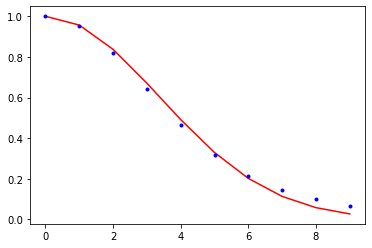

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 723
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.60240449 64.5618284  64.56364864 64.56353559 64.56343283]
Observation contribution to cost function [316.96710736 316.2085148  316.20623909 316.20669015 316.20701719]
Model contribution to cost function  [148.66193552 148.64218067 148.64263767 148.64229667 148.64207107]
The values of the cost function total [530.23144737 529.41252387 529.4125254  529.41252241 529.41252109]
RMS between background/truth and analysis/truth [0.32529402 0.05628456]
New estimate for variance coming from assimilation window 8: 0.05031519207573183
New estimate for correlation length coming from assimilation window 8: 2.842136427590094


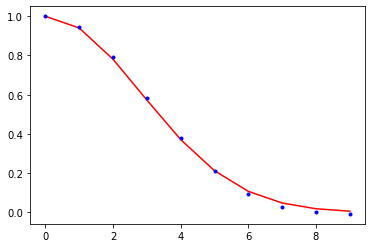

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 755
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [68.98360519 68.95454469 68.95621859 68.95611267 68.95601617]
Observation contribution to cost function [300.50034181 300.30843178 300.30680661 300.30709221 300.30730912]
Model contribution to cost function  [139.84836273 138.88348307 138.88342092 138.88323815 138.88311586]
The values of the cost function total [509.33230973 508.14645954 508.14644612 508.14644303 508.14644115]
RMS between background/truth and analysis/truth [0.31251456 0.05941418]
New estimate for variance coming from assimilation window 9: 0.04543923238504488
New estimate for correlation length coming from assimilation window 9: 3.3447263846765383


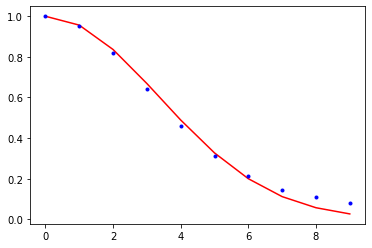

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 77
Number of inner iterations in outer iteration number 2: 25
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [108.94594997 108.92065791 108.91902462 108.92243824 108.91997335]
Observation contribution to cost function [604.89752902 605.05339157 605.05511459 605.04802935 605.05137642]
Model contribution to cost function  [655.65270881 654.84444899 654.84436249 654.84803087 654.84714375]
The values of the cost function total [1369.4961878  1368.81849848 1368.81850169 1368.81849847 1368.81849352]
RMS between background/truth and analysis/truth [0.32466791 0.10818657]
New estimate for variance coming from assimilation window 0: 0.03164159458507407
New estimate for correlation length coming from assimilation window 0: 2.398065397908477


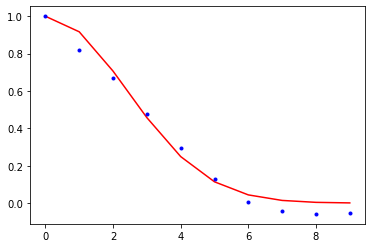

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 901
Number of inner iterations in outer iteration number 2: 427
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [59.99555856 60.02850507 60.02988372 60.02977689 60.02966808]
Observation contribution to cost function [291.20937922 291.5448585  291.54526967 291.54549946 291.54566454]
Model contribution to cost function  [188.40280546 187.24051948 187.23871756 187.23859329 187.23853619]
The values of the cost function total [539.60774324 538.81388305 538.81387094 538.81386964 538.81386881]
RMS between background/truth and analysis/truth [0.35481047 0.05831647]
New estimate for variance coming from assimilation window 1: 0.05908736641801848
New estimate for correlation length coming from assimilation window 1: 2.7309798634456617


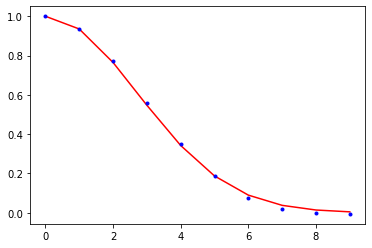

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 611
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [51.76046044 51.80713161 51.80864512 51.80847607 51.80836152]
Observation contribution to cost function [279.11455812 278.9024969  278.89986291 278.90046966 278.90080362]
Model contribution to cost function  [131.18468396 130.82692543 130.82804907 130.82760878 130.82738883]
The values of the cost function total [462.05970252 461.53655393 461.53655711 461.53655452 461.53655397]
RMS between background/truth and analysis/truth [0.30559471 0.06103352]
New estimate for variance coming from assimilation window 2: 0.039696218531243804
New estimate for correlation length coming from assimilation window 2: 2.6499760464096935


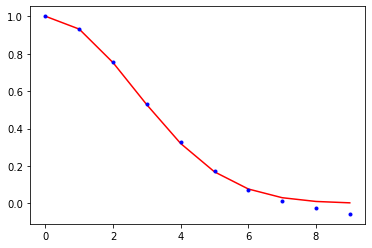

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 541
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [51.87254212 51.91270223 51.91364581 51.91354939 51.9134712 ]
Observation contribution to cost function [290.67303181 290.50215287 290.49814011 290.4985042  290.49877816]
Model contribution to cost function  [130.17636577 130.20821811 130.21128334 130.21101287 130.21081488]
The values of the cost function total [472.7219397  472.6230732  472.62306926 472.62306646 472.62306425]
RMS between background/truth and analysis/truth [0.29427345 0.05547775]
New estimate for variance coming from assimilation window 3: 0.04112047916253404
New estimate for correlation length coming from assimilation window 3: 3.1996111860610448


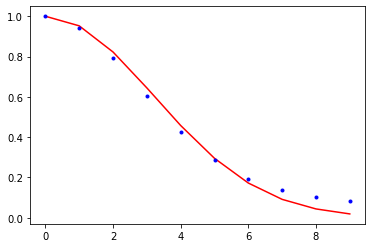

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 673
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [57.5147143  57.58794186 57.58958317 57.58957087 57.58947183]
Observation contribution to cost function [310.09130224 310.38157458 310.37874371 310.37815795 310.37901634]
Model contribution to cost function  [160.18779438 159.9233003  159.92445636 159.92505535 159.92429219]
The values of the cost function total [527.79381093 527.89281674 527.89278324 527.89278418 527.89278036]
RMS between background/truth and analysis/truth [0.3455599  0.05949853]
New estimate for variance coming from assimilation window 4: 0.056241188369695085
New estimate for correlation length coming from assimilation window 4: 2.7104414648793806


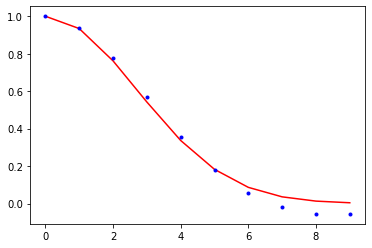

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 713
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.70903507 63.54184424 63.54214194 63.54205388 63.5420103 ]
Observation contribution to cost function [307.82717035 307.83750365 307.83566353 307.83602327 307.83623911]
Model contribution to cost function  [145.70300142 144.51374085 144.51532439 144.51505107 144.5148762 ]
The values of the cost function total [517.23920684 515.89308874 515.89312986 515.89312822 515.8931256 ]
RMS between background/truth and analysis/truth [0.34923281 0.05798579]
New estimate for variance coming from assimilation window 5: 0.05700217484357552
New estimate for correlation length coming from assimilation window 5: 2.6961036869108383


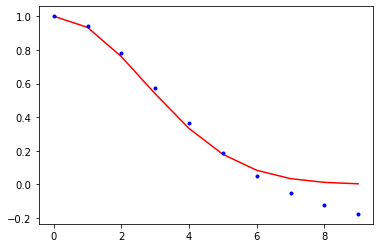

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 685
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.04490908 61.11306123 61.1142508  61.11418809 61.11412972]
Observation contribution to cost function [321.22237007 321.47155876 321.46981105 321.46989726 321.46994953]
Model contribution to cost function  [121.15834046 121.30245897 121.30301006 121.30298195 121.30298458]
The values of the cost function total [503.42561961 503.88707897 503.88707191 503.88706731 503.88706382]
RMS between background/truth and analysis/truth [0.31645797 0.05539102]
New estimate for variance coming from assimilation window 6: 0.048762972454545875
New estimate for correlation length coming from assimilation window 6: 2.9289112411666616


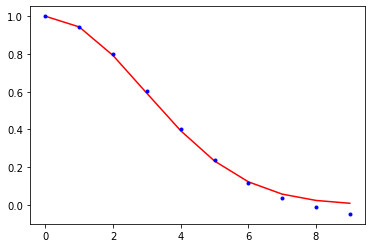

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 699
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [57.18968778 57.34458486 57.34581046 57.34573991 57.34566098]
Observation contribution to cost function [302.60601467 302.1871271  302.18532843 302.18566858 302.1859618 ]
Model contribution to cost function  [147.49885584 147.59006009 147.59062373 147.59035217 147.59013698]
The values of the cost function total [507.29455829 507.12177205 507.12176262 507.12176066 507.12175976]
RMS between background/truth and analysis/truth [0.3226074  0.05944822]
New estimate for variance coming from assimilation window 7: 0.05393023599351324
New estimate for correlation length coming from assimilation window 7: 3.24229745514897


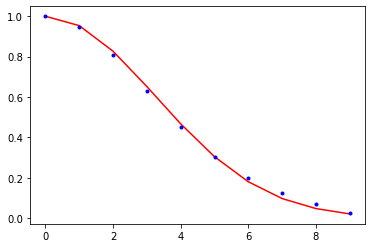

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 793
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [45.10096864 45.04313374 45.0447733  45.04463677 45.0445338 ]
Observation contribution to cost function [295.68816941 295.91643296 295.91422534 295.91450441 295.9146732 ]
Model contribution to cost function  [134.20472719 133.36013943 133.36069601 133.36054885 133.3604807 ]
The values of the cost function total [474.99386524 474.31970612 474.31969465 474.31969004 474.3196877 ]
RMS between background/truth and analysis/truth [0.30575387 0.05991272]
New estimate for variance coming from assimilation window 8: 0.04970493060567649
New estimate for correlation length coming from assimilation window 8: 2.78699825446452


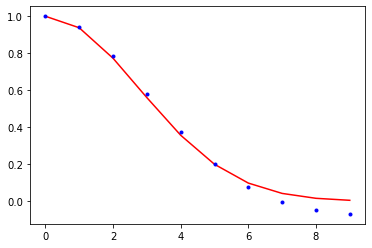

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 731
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [48.54798374 48.6015317  48.60231592 48.60229755 48.60225499]
Observation contribution to cost function [347.82643474 347.78280801 347.78236566 347.78247667 347.78258253]
Model contribution to cost function  [116.89766386 116.63071493 116.63035834 116.63026312 116.63019843]
The values of the cost function total [513.27208234 513.01505464 513.01503992 513.01503734 513.01503596]
RMS between background/truth and analysis/truth [0.30046763 0.05913478]
New estimate for variance coming from assimilation window 9: 0.041677744256100754
New estimate for correlation length coming from assimilation window 9: 2.9059047940425806


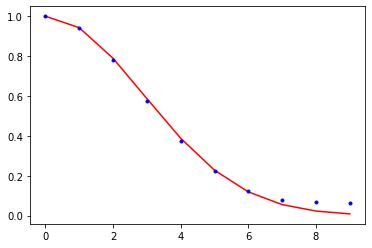

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 75
Number of inner iterations in outer iteration number 2: 21
Number of inner iterations in outer iteration number 3: 2
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [102.65710393 102.6602331  102.66214376 102.66090846 102.66170991]
Observation contribution to cost function [642.21120595 641.73581308 641.73241951 641.73371498 641.73425034]
Model contribution to cost function  [639.73033335 640.73640701 640.7378752  640.7378266  640.73647119]
The values of the cost function total [1384.59864324 1385.13245318 1385.13243847 1385.13245004 1385.13243144]
RMS between background/truth and analysis/truth [0.29676237 0.10328626]
New estimate for variance coming from assimilation window 0: 0.030159316430089178
New estimate for correlation length coming from assimilation window 0: 2.232478902285022


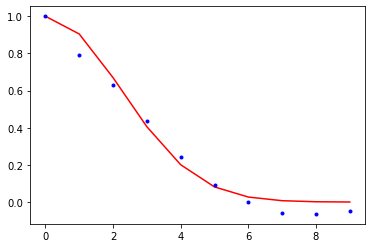

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 757
Number of inner iterations in outer iteration number 2: 321
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [54.58615819 54.56918911 54.57075942 54.57050415 54.57035111]
Observation contribution to cost function [290.87516815 290.54471081 290.54242082 290.54295769 290.54299038]
Model contribution to cost function  [176.08530432 176.36046046 176.36117087 176.36088676 176.36100781]
The values of the cost function total [521.54663066 521.47436037 521.47435111 521.4743486  521.47434929]
RMS between background/truth and analysis/truth [0.33475483 0.06090787]
New estimate for variance coming from assimilation window 1: 0.04967773261622223
New estimate for correlation length coming from assimilation window 1: 3.0281861098246377


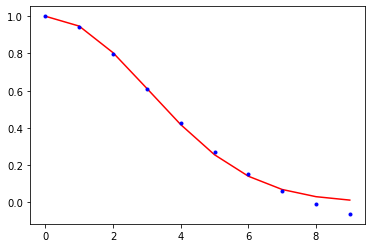

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 549
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.53555476 66.67006112 66.67154844 66.67142504 66.67132249]
Observation contribution to cost function [311.74406014 311.81764458 311.81703937 311.81718195 311.81725735]
Model contribution to cost function  [145.47036659 145.06618824 145.06530399 145.06528262 145.06530773]
The values of the cost function total [523.7499815  523.55389394 523.5538918  523.55388961 523.55388757]
RMS between background/truth and analysis/truth [0.34839897 0.0590464 ]
New estimate for variance coming from assimilation window 2: 0.06029638556799987
New estimate for correlation length coming from assimilation window 2: 3.915548735863895


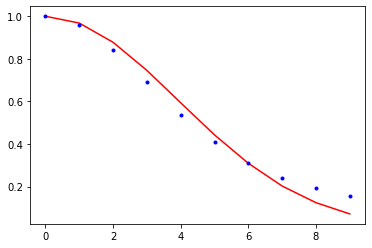

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 805
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [49.6630323  49.66972466 49.67094032 49.67087056 49.67080854]
Observation contribution to cost function [323.35654955 323.35244647 323.35022522 323.35056178 323.35081927]
Model contribution to cost function  [138.02778456 137.76954332 137.77053046 137.77025964 137.77006045]
The values of the cost function total [511.04736641 510.79171446 510.79169599 510.79169198 510.79168825]
RMS between background/truth and analysis/truth [0.30498634 0.0591144 ]
New estimate for variance coming from assimilation window 3: 0.04593019264019295
New estimate for correlation length coming from assimilation window 3: 2.420484655152003


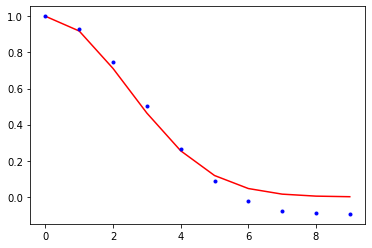

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 733
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [59.13169713 59.11842451 59.11968742 59.11957135 59.11947139]
Observation contribution to cost function [315.75653687 315.92286009 315.92265277 315.92282253 315.92296139]
Model contribution to cost function  [116.64001997 116.18104526 116.17997711 116.17992123 116.17988198]
The values of the cost function total [491.52825397 491.22232986 491.22231729 491.22231511 491.22231476]
RMS between background/truth and analysis/truth [0.33696851 0.05749203]
New estimate for variance coming from assimilation window 4: 0.057810949872567845
New estimate for correlation length coming from assimilation window 4: 4.765632527429106


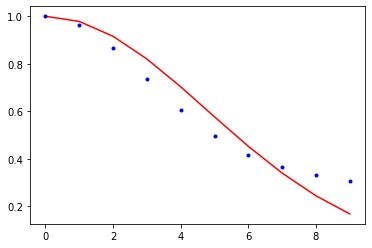

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [66.16851982 66.24883754 66.24980846 66.24975861 66.24972376]
Observation contribution to cost function [324.28066498 324.15274171 324.15099244 324.15109019 324.1511598 ]
Model contribution to cost function  [133.16736881 132.81000926 132.81075887 132.81071056 132.81067555]
The values of the cost function total [523.61655361 523.21158851 523.21155977 523.21155936 523.21155911]
RMS between background/truth and analysis/truth [0.32078106 0.05667158]
New estimate for variance coming from assimilation window 5: 0.04362826786684869
New estimate for correlation length coming from assimilation window 5: 2.8446035920978


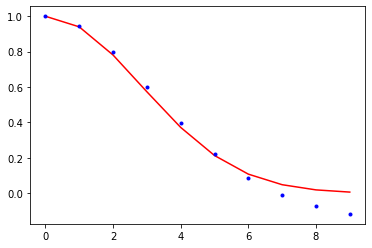

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 901
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.60762915 61.58850334 61.59008726 61.58996589 61.58986429]
Observation contribution to cost function [303.88653358 303.62924592 303.62645421 303.62694257 303.62726661]
Model contribution to cost function  [129.56396285 129.55284995 129.55405039 129.55367579 129.55344963]
The values of the cost function total [495.05812558 494.77059922 494.77059186 494.77058424 494.77058053]
RMS between background/truth and analysis/truth [0.29643136 0.05544559]
New estimate for variance coming from assimilation window 6: 0.048086867792307655
New estimate for correlation length coming from assimilation window 6: 3.5330323884741364


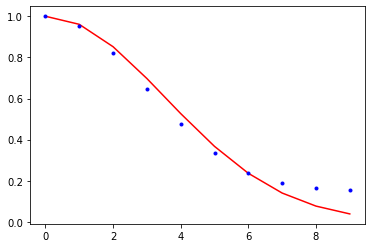

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 973
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.64189078 62.54785439 62.55011294 62.54998329 62.54987803]
Observation contribution to cost function [317.03942046 316.41036342 316.40775678 316.40803743 316.40828804]
Model contribution to cost function  [140.00819477 140.35264595 140.35301163 140.35285573 140.35270827]
The values of the cost function total [519.68950601 519.31086377 519.31088134 519.31087645 519.31087434]
RMS between background/truth and analysis/truth [0.34555494 0.05882929]
New estimate for variance coming from assimilation window 7: 0.05212501633732361
New estimate for correlation length coming from assimilation window 7: 3.1979244781481166


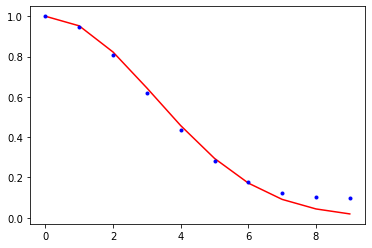

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 992
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [70.67306057 70.36736871 70.37032345 70.37017376 70.37005923]
Observation contribution to cost function [337.81079355 337.58127653 337.57784342 337.5780155  337.57816571]
Model contribution to cost function  [142.37001512 142.04628618 142.04676243 142.04674028 142.04670424]
The values of the cost function total [550.85386924 549.99493142 549.9949293  549.99492954 549.99492919]
RMS between background/truth and analysis/truth [0.34821379 0.05795065]
New estimate for variance coming from assimilation window 8: 0.0605858405714808
New estimate for correlation length coming from assimilation window 8: 3.0952865489777537


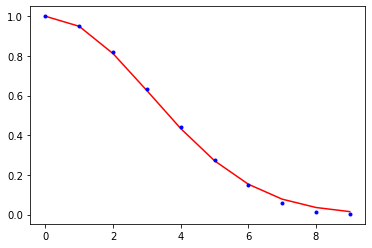

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 951
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [67.48979622 67.44212153 67.44226322 67.44221714 67.44218379]
Observation contribution to cost function [300.67877276 300.21649997 300.21506851 300.21522876 300.21538497]
Model contribution to cost function  [131.51704488 131.17263237 131.17390368 131.17378797 131.17366442]
The values of the cost function total [499.68561386 498.83125387 498.8312354  498.83123386 498.83123317]
RMS between background/truth and analysis/truth [0.35648725 0.0599156 ]
New estimate for variance coming from assimilation window 9: 0.05772372617517063
New estimate for correlation length coming from assimilation window 9: 2.8533442314880304


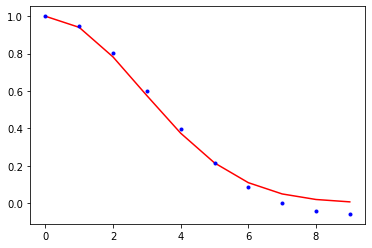

In [5]:
rd.seed(11)

win     = 10     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 5      # number of observations in time
mr      = 200    # number of observations in space
dmt     = 1      # number of temporal gridpoints between observations
dmr     = 1      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)


# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):    
    u0 = my_Lorenz.step_rk4(u0) 

    
#repetitions for confidence interval 
rep     = 30
var     = np.zeros((rep,win))
length  = np.zeros((rep,win))
meanvar = np.zeros((rep,win))
meanlen = np.zeros((rep,win))

for i in range(rep): 
    print(f'rep={rep}')
    u0     = F*np.ones(nr)
    u0[0] += 0.01
    for n in range((i+1)*1000):    
        u0 = my_Lorenz.step_rk4(u0) 
        
    u_analysis, u_back, u_truth, var[i], length[i],  meanvar[i], meanlen[i], H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)






In [ ]:
#repetitions for confidence interval 
rep     = 1
var     = np.zeros((rep,win))
length  = np.zeros((rep,win))
meanvar = np.zeros((rep,win))
meanlen = np.zeros((rep,win))

for i in range(rep): 
    u0     = F*np.ones(nr)
    u0[0] += 0.01
    for n in range((i+1)*1000):    
        u0 = my_Lorenz.step_rk4(u0) 
        
    u_analysis, u_back, u_truth, var[i], length[i],  meanvar[i], meanlen[i], H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)




estimated variances [[0.04125855 0.05686662 0.05561615 0.04742275 0.04509719 0.04303773
  0.05212991 0.05711758 0.04434212 0.04660522]
 [0.03409761 0.05158245 0.04060006 0.05015097 0.05197067 0.05084672
  0.05364766 0.04578156 0.04400776 0.04900163]
 [0.04452585 0.0374527  0.05696089 0.0408761  0.05047801 0.04571941
  0.05124602 0.05231507 0.03816953 0.04649038]
 [0.02909204 0.04340162 0.05437373 0.04346172 0.04343591 0.05850313
  0.04969494 0.04747532 0.0356086  0.04664497]
 [0.03648862 0.04416207 0.05400749 0.05132852 0.05083145 0.0503032
  0.04470645 0.04267124 0.05231818 0.06262944]
 [0.03518316 0.04874402 0.04567084 0.06204038 0.04295358 0.04550596
  0.05707715 0.05383935 0.04884183 0.03914746]
 [0.0332576  0.04700573 0.04730118 0.04783473 0.04432271 0.06089357
  0.05483182 0.03652922 0.04532123 0.05864556]
 [0.02971202 0.05505185 0.05725752 0.0461855  0.05081805 0.0453638
  0.04084196 0.04202264 0.06016504 0.04345441]
 [0.0289044  0.04212818 0.04957758 0.0524054  0.06276051 0.056

ValueError: x and y must have same first dimension, but have shapes (10,) and (30, 10)

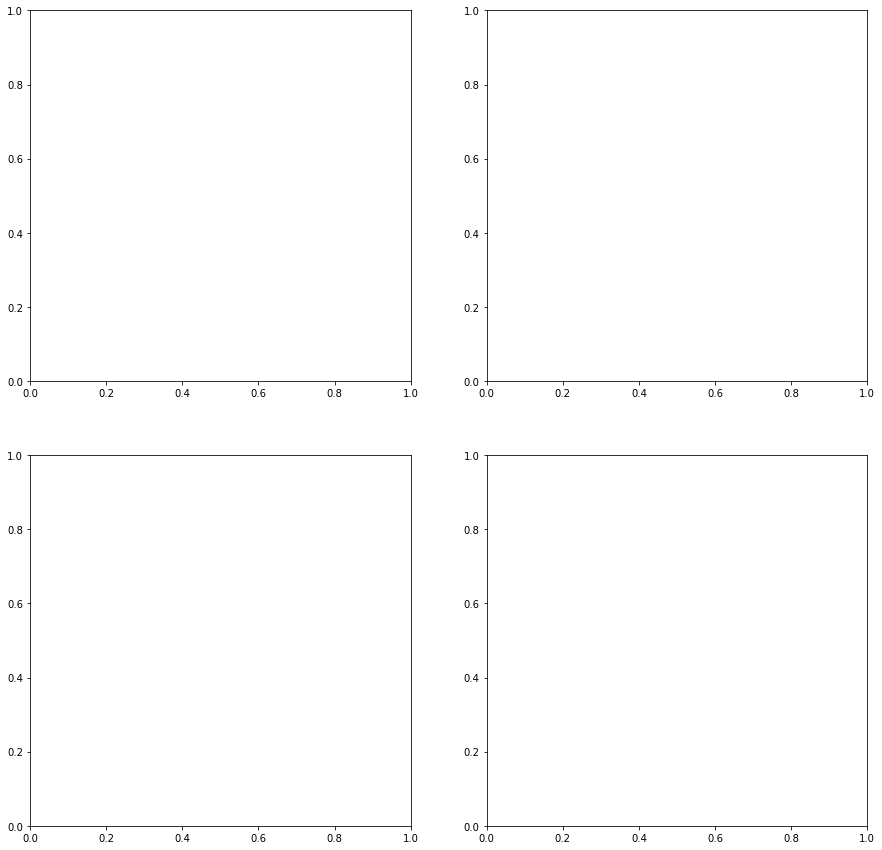

In [6]:
q_estimate_analysis(win,var,length,meanvar,meanlen,q_var_truth, l_truth)

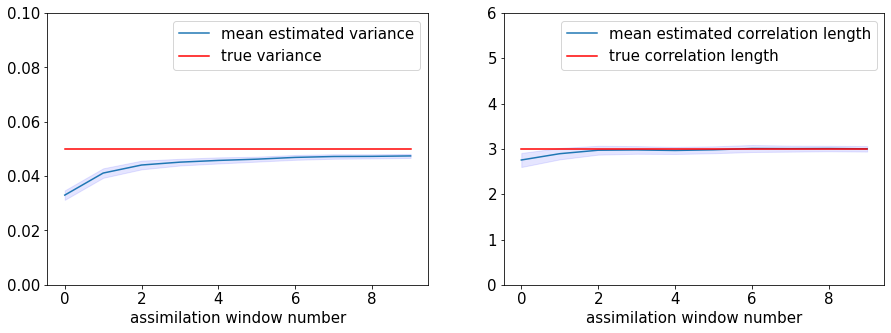

In [7]:
confidence_interval(win,rep,meanvar,meanlen,q_var_truth,l_truth)

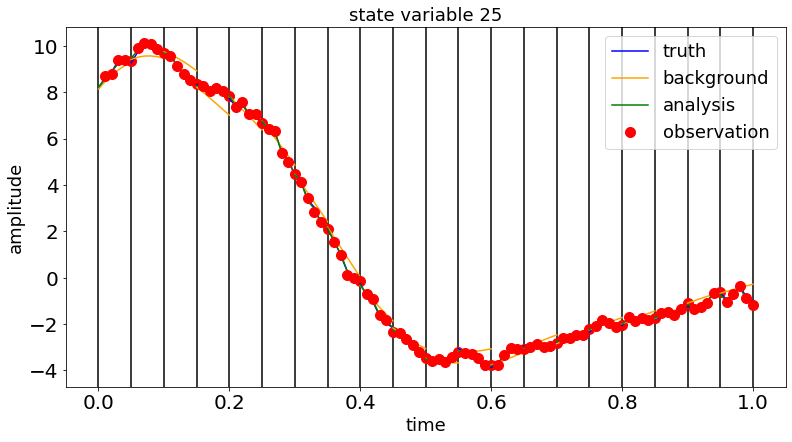

In [9]:
evolution_over_windows(25,win,mt,dmt,nt,dt,u_truth,u_back,u_analysis,H,d)

### 2.2 Experiment 2: partial observations in space

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 61
Number of inner iterations in outer iteration number 2: 11
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.70752571 64.7606977  64.76287025 64.76556479 64.7636057 ]
Observation contribution to cost function [315.48084573 315.39907606 315.39774951 315.38819372 315.39312186]
Model contribution to cost function  [402.25394621 402.22924042 402.22822457 402.23510461 402.23210525]
The values of the cost function total [782.44231766 782.38901418 782.38884433 782.38886312 782.38883282]
RMS between background/truth and analysis/truth [0.35479109 0.22000402]
New estimate for variance coming from assimilation window 0: 0.04179035510236334
New estimate for correlation length coming from assimilation window 0: 3.0306302935385068


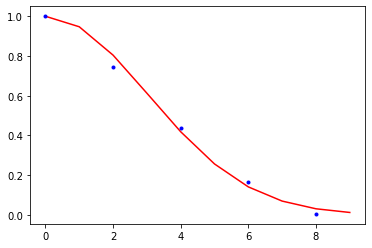

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 727
Number of inner iterations in outer iteration number 2: 287
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.17923829 30.32533006 30.32726305 30.32710562 30.32708935]
Observation contribution to cost function [144.83934645 145.05630628 145.05034285 145.05085004 145.04994911]
Model contribution to cost function  [146.0497031  144.79356113 144.7975515  144.79719654 144.79812117]
The values of the cost function total [321.06828784 320.17519747 320.1751574  320.1751522  320.17515963]
RMS between background/truth and analysis/truth [0.46925438 0.21384641]
New estimate for variance coming from assimilation window 1: 0.0588555850952994
New estimate for correlation length coming from assimilation window 1: 3.210452969561724


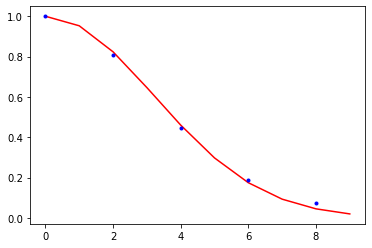

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 896
Number of inner iterations in outer iteration number 2: 375
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [22.2442345  22.27024839 22.27115134 22.27110201 22.27109321]
Observation contribution to cost function [114.38148212 114.0681717  114.06463724 114.06488383 114.06516911]
Model contribution to cost function  [105.86079977 105.76974459 105.77239248 105.77219787 105.77192876]
The values of the cost function total [242.4865164  242.10816468 242.10818106 242.10818371 242.10819109]
RMS between background/truth and analysis/truth [0.39211595 0.17651034]
New estimate for variance coming from assimilation window 2: 0.04365063193038513
New estimate for correlation length coming from assimilation window 2: 2.6951474550129


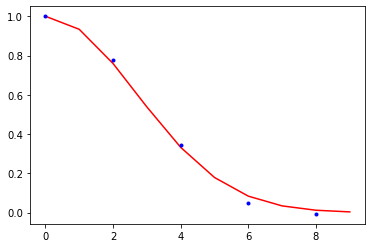

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 801
Number of inner iterations in outer iteration number 2: 285
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [24.05203691 24.16493721 24.16555884 24.16555095 24.16552744]
Observation contribution to cost function [111.42136391 111.36578293 111.36485504 111.3648896  111.36493041]
Model contribution to cost function  [120.6509463  119.91039099 119.91069575 119.91066829 119.91065046]
The values of the cost function total [256.12434712 255.44111113 255.44110963 255.44110884 255.44110832]
RMS between background/truth and analysis/truth [0.37254193 0.16367383]
New estimate for variance coming from assimilation window 3: 0.051103025138237876
New estimate for correlation length coming from assimilation window 3: 3.502612275684076


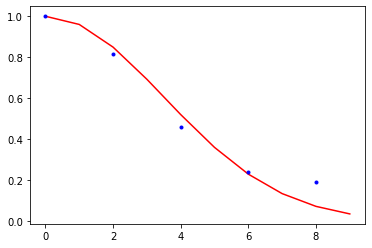

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 874
Number of inner iterations in outer iteration number 2: 351
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [30.50330271 30.47681598 30.47775311 30.47759574 30.47745071]
Observation contribution to cost function [131.52969727 131.25319067 131.24970155 131.25004189 131.25036659]
Model contribution to cost function  [119.85945038 119.99279389 119.99532181 119.99513691 119.99495714]
The values of the cost function total [281.89245036 281.72280054 281.72277647 281.72277454 281.72277444]
RMS between background/truth and analysis/truth [0.3748263  0.16649294]
New estimate for variance coming from assimilation window 4: 0.05043875389157363
New estimate for correlation length coming from assimilation window 4: 2.701647492542545


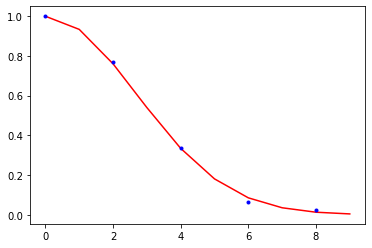

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 838
Number of inner iterations in outer iteration number 2: 289
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [26.64309473 26.65276831 26.65219529 26.65212168 26.65210496]
Observation contribution to cost function [114.2576065  114.06482139 114.06302026 114.0631556  114.06302443]
Model contribution to cost function  [105.76500306 105.90733363 105.90968017 105.90961243 105.90976621]
The values of the cost function total [246.66570429 246.62492333 246.62489572 246.62488971 246.6248956 ]
RMS between background/truth and analysis/truth [0.32976748 0.1693551 ]
New estimate for variance coming from assimilation window 5: 0.03886143217047362
New estimate for correlation length coming from assimilation window 5: 2.3640955651002824


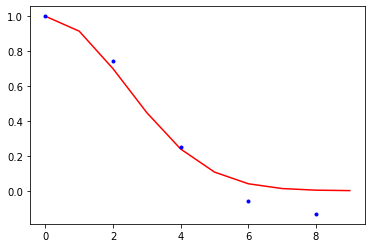

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 792
Number of inner iterations in outer iteration number 2: 265
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [35.28185839 35.18009548 35.18028334 35.18023943 35.18017227]
Observation contribution to cost function [131.40441328 131.15158458 131.15001653 131.15015256 131.15032866]
Model contribution to cost function  [109.54193016 109.66496865 109.66638195 109.66628444 109.66617319]
The values of the cost function total [276.22820183 275.99664871 275.99668183 275.99667643 275.99667412]
RMS between background/truth and analysis/truth [0.37108232 0.17741792]
New estimate for variance coming from assimilation window 6: 0.04232859565470219
New estimate for correlation length coming from assimilation window 6: 2.353363417329936


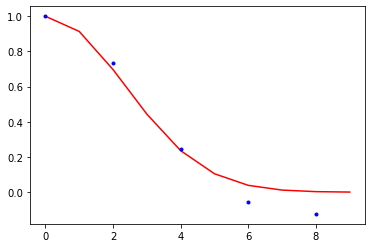

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 751
Number of inner iterations in outer iteration number 2: 339
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [38.69670663 38.29632013 38.30189202 38.30190216 38.30182965]
Observation contribution to cost function [120.75052181 120.08526611 120.08086676 120.08066965 120.07934135]
Model contribution to cost function  [110.06235636 110.83189505 110.83088042 110.83106491 110.83247057]
The values of the cost function total [269.5095848  269.21348129 269.21363921 269.21363671 269.21364158]
RMS between background/truth and analysis/truth [0.37741297 0.18786376]
New estimate for variance coming from assimilation window 7: 0.05084559438531074
New estimate for correlation length coming from assimilation window 7: 2.7856909960801834


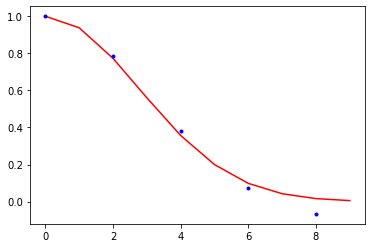

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 755
Number of inner iterations in outer iteration number 2: 281
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [42.15392676 42.3528616  42.35323316 42.35279757 42.35267646]
Observation contribution to cost function [120.07033998 119.98240897 119.97736792 119.97835539 119.97807487]
Model contribution to cost function  [115.4211058  115.3695604  115.37422058 115.37367173 115.3740739 ]
The values of the cost function total [277.64537253 277.70483096 277.70482167 277.7048247  277.70482523]
RMS between background/truth and analysis/truth [0.38359113 0.19316055]
New estimate for variance coming from assimilation window 8: 0.04748280915827376
New estimate for correlation length coming from assimilation window 8: 3.050221996587706


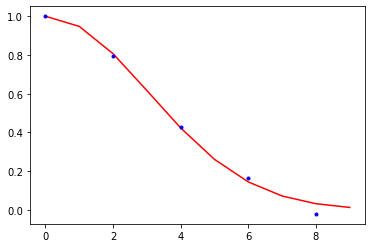

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 780
Number of inner iterations in outer iteration number 2: 265
Number of inner iterations in outer iteration number 3: 16
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [55.06731738 55.32999469 55.33028849 55.32995424 55.32987866]
Observation contribution to cost function [140.2402094  140.50826575 140.50419826 140.50627184 140.50482745]
Model contribution to cost function  [122.58404584 122.48957779 122.49333647 122.49160108 122.49311966]
The values of the cost function total [317.89157262 318.32783824 318.32782322 318.32782715 318.32782577]
RMS between background/truth and analysis/truth [0.37614892 0.21002573]
New estimate for variance coming from assimilation window 9: 0.04634283149801241
New estimate for correlation length coming from assimilation window 9: 2.9256914484903933


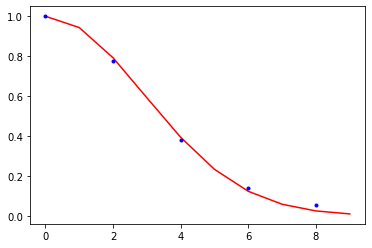

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 786
Number of inner iterations in outer iteration number 2: 339
Number of inner iterations in outer iteration number 3: 20
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [79.61096121 79.80785223 79.80275322 79.80251974 79.80225756]
Observation contribution to cost function [149.1066084  148.72046449 148.71589186 148.71896457 148.71683222]
Model contribution to cost function  [156.62091213 155.369407   155.37911278 155.37628097 155.37867661]
The values of the cost function total [385.33848175 383.89772372 383.89775785 383.89776528 383.89776639]
RMS between background/truth and analysis/truth [0.43222161 0.22090067]
New estimate for variance coming from assimilation window 10: 0.06014005716070675
New estimate for correlation length coming from assimilation window 10: 2.7950190347783677


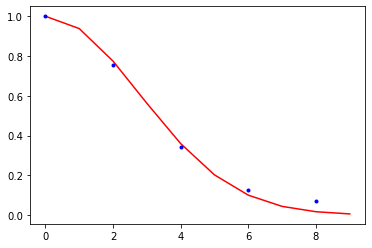

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 792
Number of inner iterations in outer iteration number 2: 305
Number of inner iterations in outer iteration number 3: 20
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [77.77149047 77.75480264 77.7541238  77.75387461 77.75375766]
Observation contribution to cost function [141.89047783 142.23810423 142.23125784 142.23296986 142.23202223]
Model contribution to cost function  [125.22060096 124.94243709 124.95000344 124.94854003 124.94960015]
The values of the cost function total [344.88256927 344.93534396 344.93538508 344.9353845  344.93538003]
RMS between background/truth and analysis/truth [0.40987153 0.23946146]
New estimate for variance coming from assimilation window 11: 0.04149792998396428
New estimate for correlation length coming from assimilation window 11: 2.689560109615788


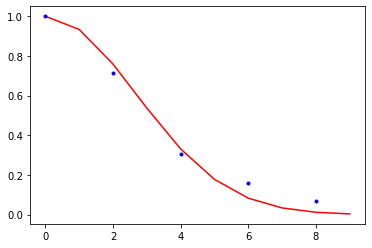

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 754
Number of inner iterations in outer iteration number 2: 291
Number of inner iterations in outer iteration number 3: 29
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [82.3962247  82.75961297 82.75611383 82.75506367 82.75484848]
Observation contribution to cost function [167.33878919 168.1448985  168.13558934 168.1371593  168.13817298]
Model contribution to cost function  [127.03899952 126.3418551  126.35498766 126.35447654 126.35367197]
The values of the cost function total [376.77401341 377.24636658 377.24669083 377.2466995  377.24669343]
RMS between background/truth and analysis/truth [0.41779166 0.261456  ]
New estimate for variance coming from assimilation window 12: 0.041258798222994886
New estimate for correlation length coming from assimilation window 12: 2.7747585388217324


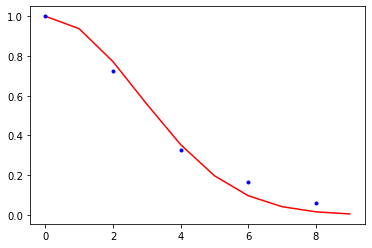

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 766
Number of inner iterations in outer iteration number 2: 333
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [100.26642435 100.50541689 100.50631248 100.50471999 100.50437006]
Observation contribution to cost function [147.17191725 147.6148934  147.59768429 147.60072662 147.59921861]
Model contribution to cost function  [156.99622664 155.16327387 155.17970932 155.17826775 155.18012517]
The values of the cost function total [404.43456824 403.28358415 403.28370609 403.28371435 403.28371385]
RMS between background/truth and analysis/truth [0.50549393 0.28041692]
New estimate for variance coming from assimilation window 13: 0.07125462267790757
New estimate for correlation length coming from assimilation window 13: 3.270260339587262


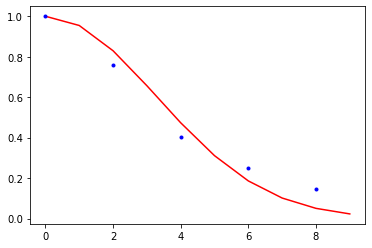

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 792
Number of inner iterations in outer iteration number 2: 323
Number of inner iterations in outer iteration number 3: 31
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [112.26605979 112.31544122 112.28304663 112.27963765 112.27880266]
Observation contribution to cost function [164.59012657 163.84780599 163.84389392 163.84711274 163.84791206]
Model contribution to cost function  [144.14395284 143.77913245 143.81424168 143.81443181 143.81446175]
The values of the cost function total [421.00013921 419.94237966 419.94118223 419.9411822  419.94117647]
RMS between background/truth and analysis/truth [0.48879828 0.30603807]
New estimate for variance coming from assimilation window 14: 0.0545244091999191
New estimate for correlation length coming from assimilation window 14: 2.3183661682644088


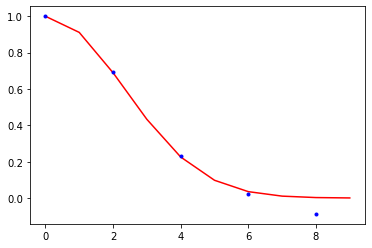

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 800
Number of inner iterations in outer iteration number 2: 345
Number of inner iterations in outer iteration number 3: 54
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [120.03247356 120.57096394 120.51020677 120.50817818 120.50839018]
Observation contribution to cost function [163.80554038 164.39192567 164.41329975 164.41728147 164.41629477]
Model contribution to cost function  [141.59699192 140.68942004 140.73038828 140.72847255 140.72923566]
The values of the cost function total [425.43500585 425.65230965 425.65389479 425.6539322  425.6539206 ]
RMS between background/truth and analysis/truth [0.55738013 0.33597858]
New estimate for variance coming from assimilation window 15: 0.05785089761456397
New estimate for correlation length coming from assimilation window 15: 2.9260510656601078


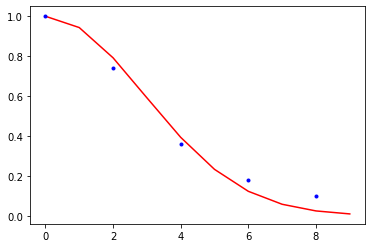

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 810
Number of inner iterations in outer iteration number 2: 373
Number of inner iterations in outer iteration number 3: 64
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [144.43506292 145.04708499 144.98441608 144.98229055 144.98290452]
Observation contribution to cost function [195.07406398 195.11792891 195.12491287 195.13062735 195.12918406]
Model contribution to cost function  [176.97848287 175.65462786 175.71109361 175.707557   175.7083735 ]
The values of the cost function total [516.48760977 515.81964176 515.82042257 515.8204749  515.82046208]
RMS between background/truth and analysis/truth [0.56624658 0.36094617]
New estimate for variance coming from assimilation window 16: 0.061468578369867764
New estimate for correlation length coming from assimilation window 16: 2.4748361668512913


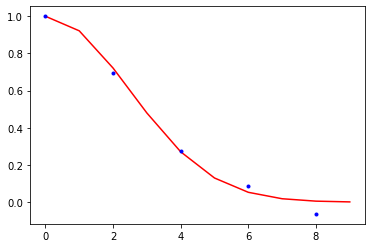

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 821
Number of inner iterations in outer iteration number 2: 373
Number of inner iterations in outer iteration number 3: 75
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [163.65083954 164.74364471 164.66930613 164.66861709 164.66933259]
Observation contribution to cost function [181.56199102 181.24393575 181.2653503  181.27077883 181.26987884]
Model contribution to cost function  [180.2894728  176.68270774 176.73734799 176.73273125 176.73289218]
The values of the cost function total [525.50230335 522.67028819 522.67200441 522.67212718 522.67210361]
RMS between background/truth and analysis/truth [0.62110267 0.3875472 ]
New estimate for variance coming from assimilation window 17: 0.0753880596210224
New estimate for correlation length coming from assimilation window 17: 3.0829615012428877


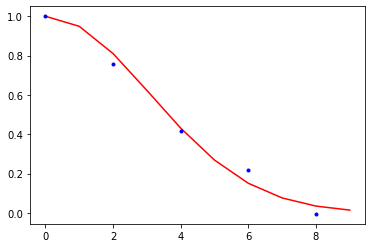

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 856
Number of inner iterations in outer iteration number 2: 397
Number of inner iterations in outer iteration number 3: 50
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [176.86145632 177.35994567 177.322337   177.31812027 177.31861317]
Observation contribution to cost function [191.30663164 190.29245482 190.2890801  190.29864058 190.29808965]
Model contribution to cost function  [166.44759879 165.07370034 165.11522976 165.10998759 165.11003339]
The values of the cost function total [534.61568674 532.72610083 532.72664685 532.72674844 532.7267362 ]
RMS between background/truth and analysis/truth [0.62387062 0.43083921]
New estimate for variance coming from assimilation window 18: 0.05616448006353704
New estimate for correlation length coming from assimilation window 18: 2.1122845329367923


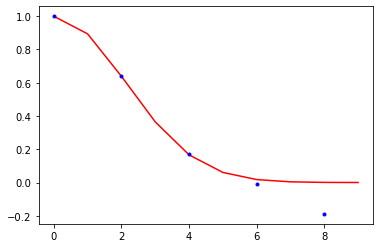

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 846
Number of inner iterations in outer iteration number 2: 453
Number of inner iterations in outer iteration number 3: 61
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [169.11769535 168.24469341 168.21589421 168.21314609 168.21338831]
Observation contribution to cost function [175.22306456 173.00696141 172.99076104 172.99462671 172.99319864]
Model contribution to cost function  [175.87455824 171.93530941 171.98057323 171.97947356 171.98065957]
The values of the cost function total [520.21531815 513.18696423 513.18722848 513.18724635 513.18724652]
RMS between background/truth and analysis/truth [0.65354675 0.47426966]
New estimate for variance coming from assimilation window 19: 0.0697688246800472
New estimate for correlation length coming from assimilation window 19: 2.3374427354424947


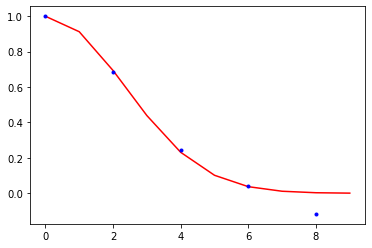

In [10]:
rd.seed(11)

win     = 20     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 5      # number of observations in time
mr      = 100    # number of observations in space
dmt     = 1      # number of temporal gridpoints between observations
dmr     = 2      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)


# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):
    u0 = my_Lorenz.step_rk4(u0) 



u_analysis, u_back, u_truth, var, length,  meanvar, meanlen, H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)


estimated variances [0.04179036 0.05885559 0.04365063 0.05110303 0.05043875 0.03886143
 0.0423286  0.05084559 0.04748281 0.04634283 0.06014006 0.04149793
 0.0412588  0.07125462 0.05452441 0.0578509  0.06146858 0.07538806
 0.05616448 0.06976882]
estimated correlation length [3.03063029 3.21045297 2.69514746 3.50261228 2.70164749 2.36409557
 2.35336342 2.785691   3.050222   2.92569145 2.79501903 2.68956011
 2.77475854 3.27026034 2.31836617 2.92605107 2.47483617 3.0829615
 2.11228453 2.33744274]


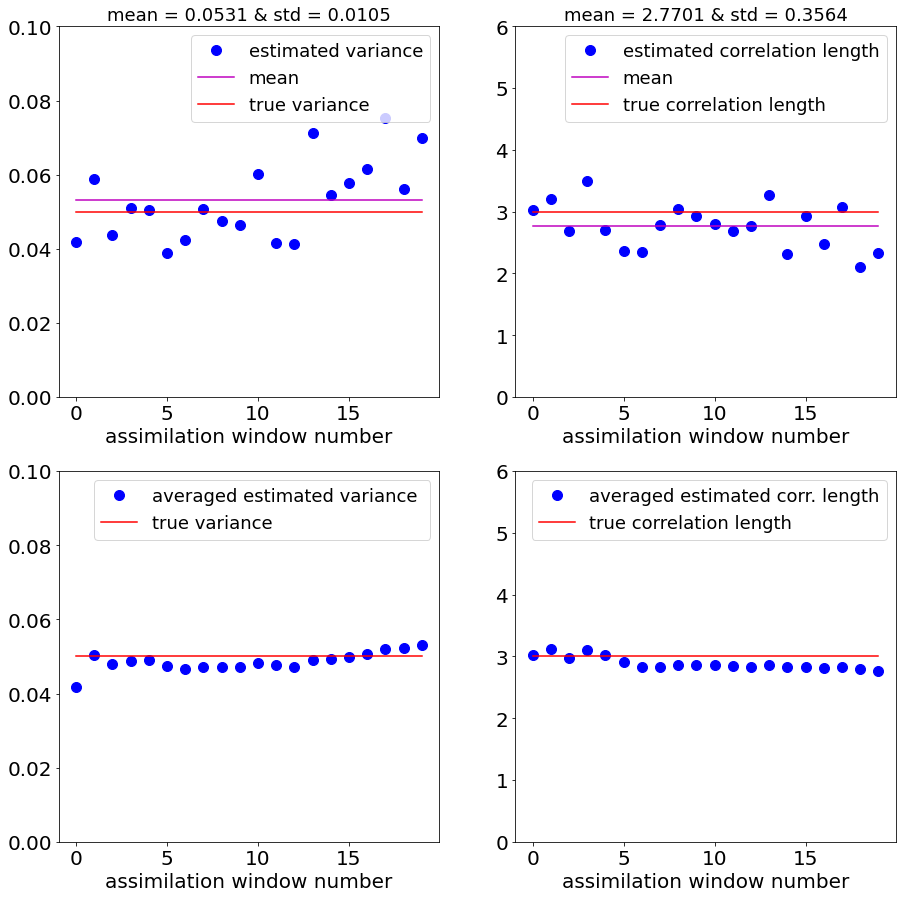

In [11]:
q_estimate_analysis(win,var,length,meanvar,meanlen,q_var_truth, l_truth)

### 2.3 Experiment 3: partial observations in time

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 37
Number of inner iterations in outer iteration number 2: 13
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [123.17427651 123.21253291 123.21028768 123.21446346 123.21114552]
Observation contribution to cost function [364.74787841 364.71756651 364.72150836 364.71125058 364.71710224]
Model contribution to cost function  [592.82678214 592.61962542 592.61792728 592.62400912 592.62146572]
The values of the cost function total [1080.74893706 1080.54972484 1080.54972332 1080.54972316 1080.54971348]
RMS between background/truth and analysis/truth [0.35479109 0.13880216]
New estimate for variance coming from assimilation window 0: 0.041426181694493996
New estimate for correlation length coming from assimilation window 0: 3.2268787027692007


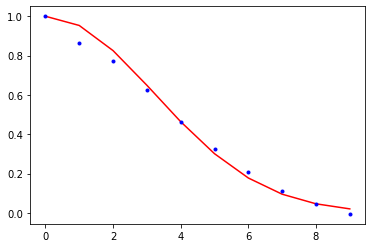

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 925
Number of inner iterations in outer iteration number 2: 419
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [41.22117644 41.18388285 41.18574276 41.18556701 41.18543182]
Observation contribution to cost function [174.36488763 174.6487599  174.64730606 174.6479726  174.64837412]
Model contribution to cost function  [95.88996773 95.73452284 95.73411849 95.73362274 95.73335232]
The values of the cost function total [311.4760318  311.56716559 311.56716731 311.56716236 311.56715826]
RMS between background/truth and analysis/truth [0.34231605 0.10286895]
New estimate for variance coming from assimilation window 1: 0.056111360041258385
New estimate for correlation length coming from assimilation window 1: 3.7150789686873775


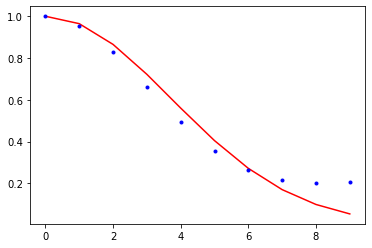

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 539
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.13625822 30.13329658 30.13435187 30.13430851 30.13430157]
Observation contribution to cost function [167.3477977  166.82952712 166.82719585 166.82748336 166.82693228]
Model contribution to cost function  [85.75069025 86.06658976 86.0678772  86.06763125 86.06819301]
The values of the cost function total [283.23474618 283.02941346 283.02942491 283.02942312 283.02942686]
RMS between background/truth and analysis/truth [0.30453765 0.09705028]
New estimate for variance coming from assimilation window 2: 0.046776192615153867
New estimate for correlation length coming from assimilation window 2: 2.9226929193162032


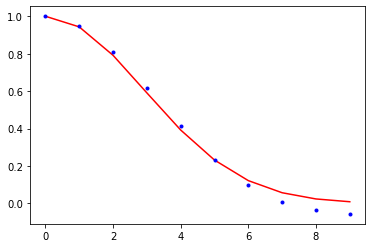

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 423
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [26.6322112  26.49065643 26.4916368  26.49158138 26.49153542]
Observation contribution to cost function [159.00099837 158.93205316 158.93081225 158.93107583 158.93123596]
Model contribution to cost function  [80.91865814 80.64440416 80.64468305 80.64447853 80.64436716]
The values of the cost function total [266.5518677  266.06711374 266.06713211 266.06713574 266.06713854]
RMS between background/truth and analysis/truth [0.30527332 0.10448766]
New estimate for variance coming from assimilation window 3: 0.04641913429394799
New estimate for correlation length coming from assimilation window 3: 3.388583820397612


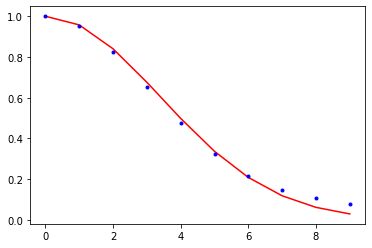

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 497
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [26.69253256 26.73152119 26.73273399 26.73264242 26.73257418]
Observation contribution to cost function [149.01061686 148.50857142 148.50615359 148.50654759 148.50684034]
Model contribution to cost function  [91.7974083  91.86641412 91.86761284 91.86730959 91.8670853 ]
The values of the cost function total [267.50055771 267.10650673 267.10650042 267.10649959 267.10649981]
RMS between background/truth and analysis/truth [0.32065632 0.09567549]
New estimate for variance coming from assimilation window 4: 0.055438437686574506
New estimate for correlation length coming from assimilation window 4: 3.086360225448965


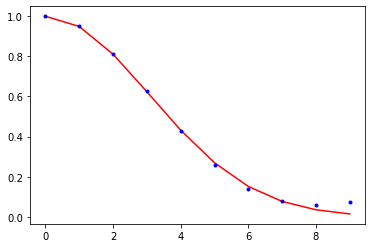

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 465
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [30.02753827 30.06411205 30.06522083 30.06514104 30.06507571]
Observation contribution to cost function [143.88643005 144.16863738 144.16574803 144.16604257 144.16623619]
Model contribution to cost function  [77.25676736 76.76397287 76.76574277 76.76552171 76.76538829]
The values of the cost function total [251.17073568 250.99672229 250.99671163 250.99670533 250.99670019]
RMS between background/truth and analysis/truth [0.28582395 0.09645402]
New estimate for variance coming from assimilation window 5: 0.045597895833692684
New estimate for correlation length coming from assimilation window 5: 3.027971633944266


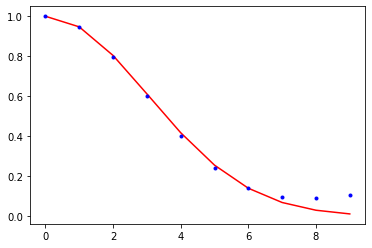

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 460
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [27.84871193 27.89101405 27.89203871 27.89194749 27.89191023]
Observation contribution to cost function [166.2474026  166.2457538  166.24234006 166.2427788  166.24401111]
Model contribution to cost function  [79.46154264 79.71782689 79.72022164 79.71987242 79.7186818 ]
The values of the cost function total [273.55765718 273.85459474 273.85460041 273.8545987  273.85460313]
RMS between background/truth and analysis/truth [0.29493624 0.10390968]
New estimate for variance coming from assimilation window 6: 0.047969896551310925
New estimate for correlation length coming from assimilation window 6: 2.934699432693799


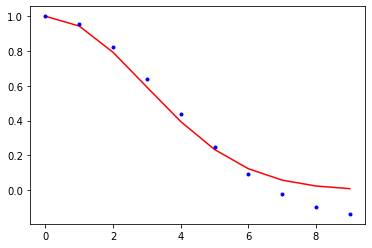

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 440
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.68341552 27.75146286 27.75205094 27.75197836 27.75193164]
Observation contribution to cost function [135.04407984 135.2435211  135.2418554  135.24231335 135.24255203]
Model contribution to cost function  [78.89539554 78.23868648 78.23974433 78.23935297 78.23915575]
The values of the cost function total [241.6228909  241.23367043 241.23365066 241.23364468 241.23363942]
RMS between background/truth and analysis/truth [0.28760821 0.09679295]
New estimate for variance coming from assimilation window 7: 0.0428694152618891
New estimate for correlation length coming from assimilation window 7: 2.8954472628832013


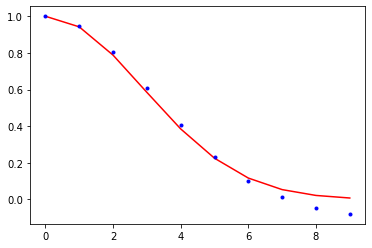

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 415
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.30445066 27.26007034 27.26086843 27.26080183 27.26073383]
Observation contribution to cost function [137.19860906 136.96453925 136.96292304 136.96327833 136.96348875]
Model contribution to cost function  [79.07308331 78.89269073 78.89349762 78.89320557 78.89306172]
The values of the cost function total [243.57614303 243.11730032 243.11728909 243.11728573 243.1172843 ]
RMS between background/truth and analysis/truth [0.31894668 0.10490086]
New estimate for variance coming from assimilation window 8: 0.04980533806170097
New estimate for correlation length coming from assimilation window 8: 3.3552550596593336


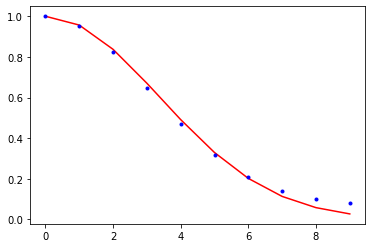

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 427
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [30.85851249 30.88124841 30.88258568 30.88248572 30.88239348]
Observation contribution to cost function [154.91356807 154.62190576 154.61968233 154.61995562 154.62018171]
Model contribution to cost function  [83.10960728 83.00712441 83.00800885 83.00783456 83.00770098]
The values of the cost function total [268.88168784 268.51027859 268.51027685 268.5102759  268.51027617]
RMS between background/truth and analysis/truth [0.32404912 0.1137084 ]
New estimate for variance coming from assimilation window 9: 0.04929708514260128
New estimate for correlation length coming from assimilation window 9: 3.352974788403713


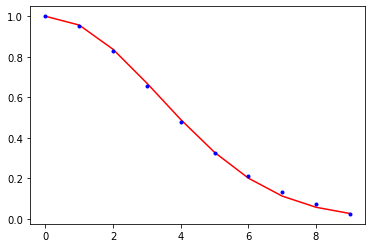

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 501
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [34.38250802 34.43885249 34.44021557 34.44009976 34.44001275]
Observation contribution to cost function [144.69592491 144.90946668 144.90658866 144.90709913 144.90735437]
Model contribution to cost function  [101.80186856 100.64932649 100.65085054 100.65045415 100.65028474]
The values of the cost function total [280.88030149 279.99764565 279.99765477 279.99765303 279.99765186]
RMS between background/truth and analysis/truth [0.34144424 0.09727469]
New estimate for variance coming from assimilation window 10: 0.06339776120985013
New estimate for correlation length coming from assimilation window 10: 3.220451350545762


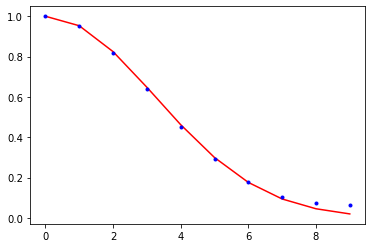

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 511
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [33.42863999 33.18766816 33.1894667  33.1893541  33.18925066]
Observation contribution to cost function [157.94462123 158.48244094 158.47890775 158.47968321 158.48019421]
Model contribution to cost function  [85.75037048 85.61448153 85.61620721 85.61553774 85.61512502]
The values of the cost function total [277.12363169 277.28459062 277.28458165 277.28457506 277.28456989]
RMS between background/truth and analysis/truth [0.29676103 0.09889709]
New estimate for variance coming from assimilation window 11: 0.042265353729613965
New estimate for correlation length coming from assimilation window 11: 2.6449644383072397


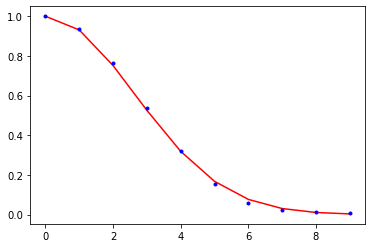

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 465
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.57588372 27.6380753  27.63964782 27.63958305 27.63949723]
Observation contribution to cost function [161.68609012 161.57999142 161.57792012 161.5781714  161.57841099]
Model contribution to cost function  [100.82487114 100.64513466 100.64561832 100.64542843 100.64527253]
The values of the cost function total [290.08684497 289.86320137 289.86318627 289.86318289 289.86318075]
RMS between background/truth and analysis/truth [0.35429189 0.09465624]
New estimate for variance coming from assimilation window 12: 0.06027015466762723
New estimate for correlation length coming from assimilation window 12: 3.2711131162143063


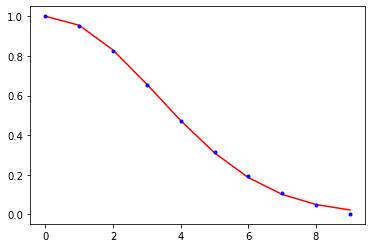

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 401
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [26.33781901 26.35223809 26.3533833  26.35328899 26.35320456]
Observation contribution to cost function [162.23578177 162.4049974  162.40349955 162.40370144 162.4038465 ]
Model contribution to cost function  [69.60659802 69.34419789 69.3445444  69.34443596 69.34437484]
The values of the cost function total [258.1801988  258.10143338 258.10142725 258.10142639 258.1014259 ]
RMS between background/truth and analysis/truth [0.28516837 0.09887405]
New estimate for variance coming from assimilation window 13: 0.03914455525554626
New estimate for correlation length coming from assimilation window 13: 2.888035668965946


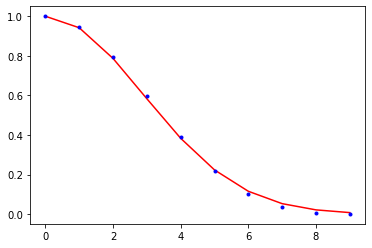

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 447
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [23.79379516 23.7537739  23.75529757 23.75520332 23.75512794]
Observation contribution to cost function [157.70508118 157.57475696 157.57151201 157.57193787 157.57227901]
Model contribution to cost function  [77.3384488  77.44127522 77.44301034 77.44267873 77.44241456]
The values of the cost function total [258.83732513 258.76980608 258.76981992 258.76981992 258.7698215 ]
RMS between background/truth and analysis/truth [0.29386747 0.09683595]
New estimate for variance coming from assimilation window 14: 0.04414334424740923
New estimate for correlation length coming from assimilation window 14: 3.2918075772058204


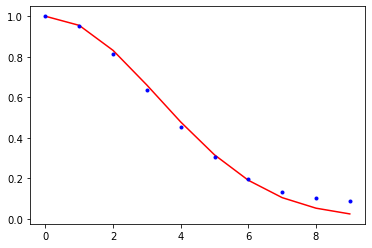

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 455
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [26.45742635 26.47767761 26.47958802 26.47947022 26.47935847]
Observation contribution to cost function [164.20536409 164.11320089 164.10986892 164.11019365 164.1104698 ]
Model contribution to cost function  [79.70255675 79.66837736 79.66977999 79.66957168 79.6694078 ]
The values of the cost function total [270.36534719 270.25925586 270.25923694 270.25923556 270.25923607]
RMS between background/truth and analysis/truth [0.30892805 0.10402592]
New estimate for variance coming from assimilation window 15: 0.044520513558705496
New estimate for correlation length coming from assimilation window 15: 2.8615625979512362


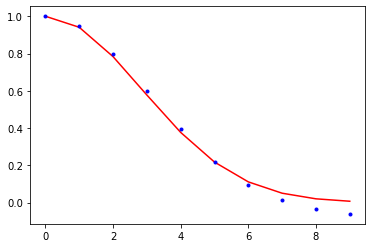

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 459
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.46031411 27.5066813  27.50735064 27.50729001 27.5072474 ]
Observation contribution to cost function [143.20239448 142.95458487 142.95259745 142.95293298 142.95319307]
Model contribution to cost function  [88.5390486  88.22332091 88.22463484 88.22435966 88.22414188]
The values of the cost function total [259.20175719 258.68458708 258.68458293 258.68458265 258.68458235]
RMS between background/truth and analysis/truth [0.31812651 0.09483566]
New estimate for variance coming from assimilation window 16: 0.04527895745686387
New estimate for correlation length coming from assimilation window 16: 2.447672600015884


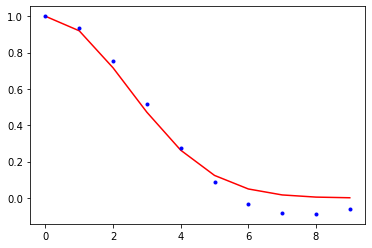

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 461
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [28.3245752  28.36976499 28.37086573 28.37074594 28.37065706]
Observation contribution to cost function [153.41534381 153.07894805 153.07562265 153.07623506 153.07663861]
Model contribution to cost function  [85.54576223 85.68162734 85.68384954 85.68335156 85.68303252]
The values of the cost function total [267.28568124 267.13034038 267.13033792 267.13033256 267.13032818]
RMS between background/truth and analysis/truth [0.29015505 0.09777873]
New estimate for variance coming from assimilation window 17: 0.045182718894769755
New estimate for correlation length coming from assimilation window 17: 2.3109186801939177


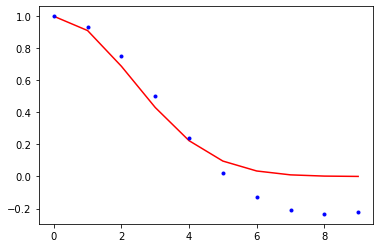

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 427
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [29.24076226 29.23921521 29.24040496 29.24029029 29.24020836]
Observation contribution to cost function [180.44086191 180.72348786 180.72077364 180.72123497 180.72154521]
Model contribution to cost function  [80.31172237 80.32662866 80.32814903 80.32779867 80.32756865]
The values of the cost function total [289.99334654 290.28933173 290.28932763 290.28932392 290.28932223]
RMS between background/truth and analysis/truth [0.31737479 0.10767789]
New estimate for variance coming from assimilation window 18: 0.04744906042875028
New estimate for correlation length coming from assimilation window 18: 2.7858082176480163


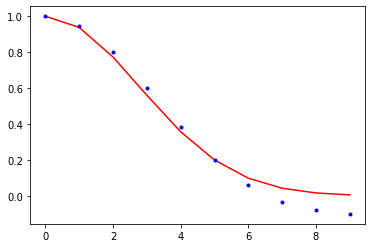

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 435
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [28.24030403 28.28529312 28.28709128 28.28692858 28.28681015]
Observation contribution to cost function [146.33701428 146.01370622 146.01110507 146.01156891 146.01186393]
Model contribution to cost function  [93.72945532 93.68438072 93.68517967 93.68487714 93.68469965]
The values of the cost function total [268.30677363 267.98338006 267.98337602 267.98337463 267.98337374]
RMS between background/truth and analysis/truth [0.30676395 0.09944846]
New estimate for variance coming from assimilation window 19: 0.05214096743231028
New estimate for correlation length coming from assimilation window 19: 2.807707897970711


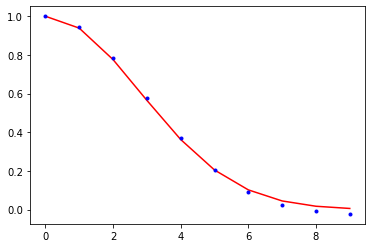

In [3]:
rd.seed(11)

win     = 20     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 3      # number of observations in time
mr      = 200    # number of observations in space
dmt     = 2      # number of temporal gridpoints between observations
dmr     = 1      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)


# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):
    u0 = my_Lorenz.step_rk4(u0) 



u_analysis, u_back, u_truth, var, length,  meanvar, meanlen, H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)

estimated variances [0.04142618 0.05611136 0.04677619 0.04641913 0.05543844 0.0455979
 0.0479699  0.04286942 0.04980534 0.04929709 0.06339776 0.04226535
 0.06027015 0.03914456 0.04414334 0.04452051 0.04527896 0.04518272
 0.04744906 0.05214097]
estimated correlation length [3.2268787  3.71507897 2.92269292 3.38858382 3.08636023 3.02797163
 2.93469943 2.89544726 3.35525506 3.35297479 3.22045135 2.64496444
 3.27111312 2.88803567 3.29180758 2.8615626  2.4476726  2.31091868
 2.78580822 2.8077079 ]


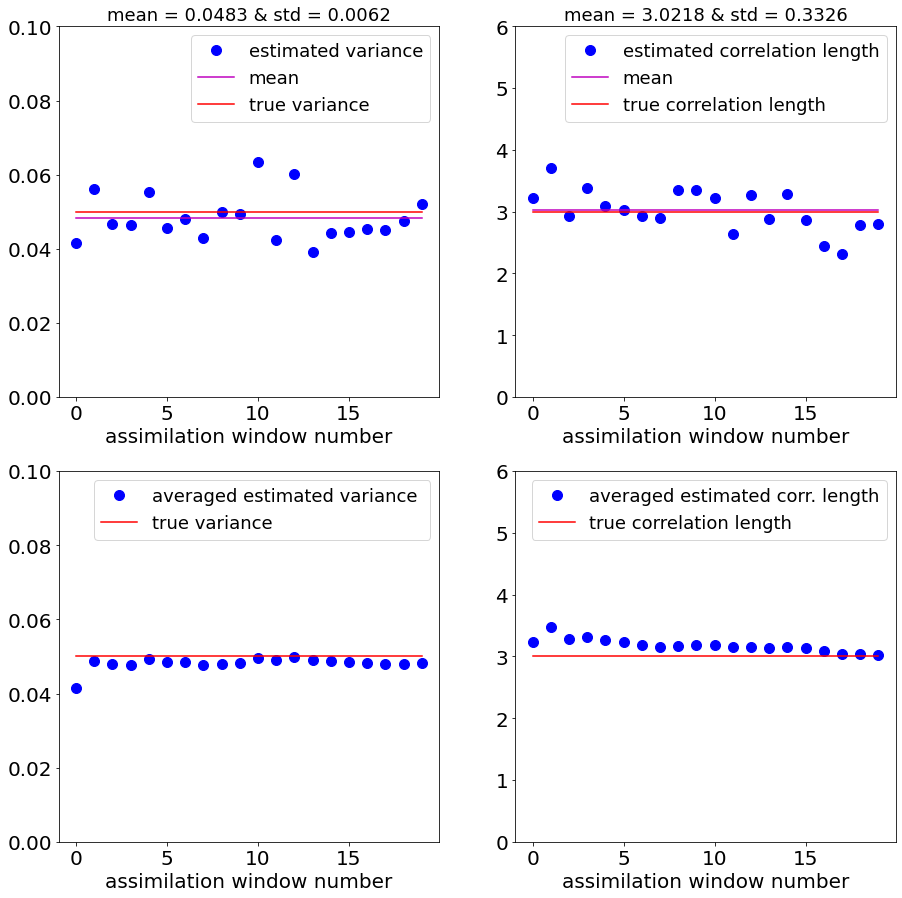

In [4]:
q_estimate_analysis(win,var,length,meanvar,meanlen,q_var_truth, l_truth)

### 2.4 Experiment 4: partial observations in time and space 

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 9
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [58.54628227 58.60947802 58.6125496  58.61348805 58.61287458]
Observation contribution to cost function [173.82112013 173.71465095 173.71180939 173.7084759  173.70970064]
Model contribution to cost function  [304.69234423 304.7156228  304.71524498 304.71764141 304.71702353]
The values of the cost function total [537.05974662 537.03975176 537.03960398 537.03960536 537.03959875]
RMS between background/truth and analysis/truth [0.35479109 0.23674072]
New estimate for variance coming from assimilation window 0: 0.04251768425329842
New estimate for correlation length coming from assimilation window 0: 3.308090624662874


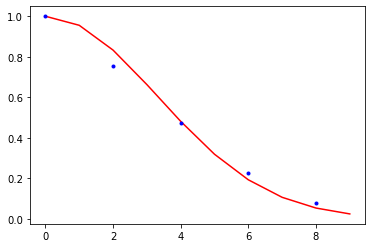

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 467
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.33663986 33.46606922 33.47054637 33.47046025 33.47032705]
Observation contribution to cost function [85.61324731 85.44143863 85.43218648 85.43140532 85.43283204]
Model contribution to cost function  [88.51143834 88.11247734 88.11738352 88.11824972 88.11696336]
The values of the cost function total [207.46132551 207.01998519 207.02011637 207.02011529 207.02012244]
RMS between background/truth and analysis/truth [0.44014839 0.23822073]
New estimate for variance coming from assimilation window 1: 0.05213429364960219
New estimate for correlation length coming from assimilation window 1: 3.046890753324869


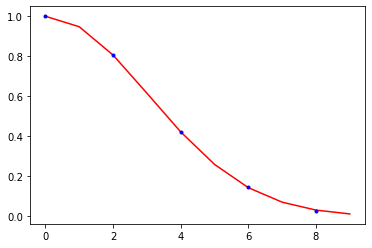

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 489
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [21.00621994 21.04040462 21.04035047 21.04028766 21.04024258]
Observation contribution to cost function [59.86205198 59.59828196 59.59568811 59.59630815 59.59662331]
Model contribution to cost function  [73.57111787 73.4043258  73.40699711 73.40643661 73.40616377]
The values of the cost function total [154.43938979 154.04301238 154.04303569 154.04303242 154.04302966]
RMS between background/truth and analysis/truth [0.3714511  0.19594769]
New estimate for variance coming from assimilation window 2: 0.047508357104506724
New estimate for correlation length coming from assimilation window 2: 3.0447826901104604


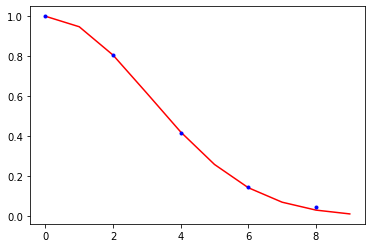

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 193
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [31.74506135 31.76379411 31.76369652 31.76365425 31.76343952]
Observation contribution to cost function [71.4675226  71.27082675 71.26562893 71.26368793 71.26662177]
Model contribution to cost function  [82.64775795 82.39623237 82.40150058 82.4034915  82.40076482]
The values of the cost function total [185.8603419  185.43085323 185.43082603 185.43083368 185.43082611]
RMS between background/truth and analysis/truth [0.40306164 0.19029856]
New estimate for variance coming from assimilation window 3: 0.05231597379660203
New estimate for correlation length coming from assimilation window 3: 2.9462310821310638


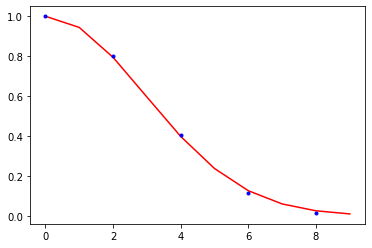

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 490
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [37.84508441 37.84645266 37.84877137 37.84868684 37.84837391]
Observation contribution to cost function [73.3011227  73.29865624 73.29471496 73.2922508  73.29547481]
Model contribution to cost function  [78.90196447 78.79490816 78.7965323  78.79908248 78.79617095]
The values of the cost function total [190.04817158 189.94001705 189.94001863 189.94002012 189.94001967]
RMS between background/truth and analysis/truth [0.35022326 0.18836643]
New estimate for variance coming from assimilation window 4: 0.043032156639565305
New estimate for correlation length coming from assimilation window 4: 2.567364922282975


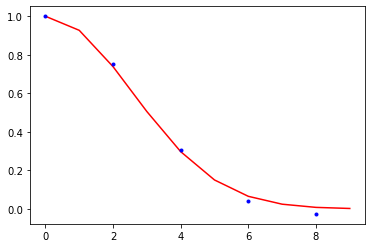

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [23.75604868 23.74079918 23.74074983 23.74049079 23.74038806]
Observation contribution to cost function [67.24625087 66.96578683 66.96287266 66.96344315 66.96301099]
Model contribution to cost function  [74.74883062 74.65396177 74.65691728 74.65660477 74.65714796]
The values of the cost function total [165.75113016 165.36054778 165.36053977 165.36053871 165.36054701]
RMS between background/truth and analysis/truth [0.35484016 0.19441077]
New estimate for variance coming from assimilation window 5: 0.0517823741219371
New estimate for correlation length coming from assimilation window 5: 2.6983163523158438


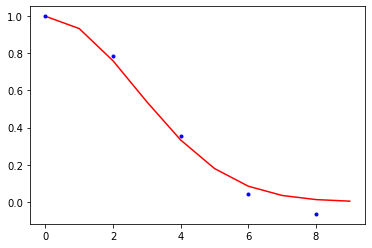

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 469
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 8
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.95873765 29.00294578 29.00389905 29.00375105 29.00372908]
Observation contribution to cost function [58.82898434 58.97469063 58.97186882 58.97321532 58.97218562]
Model contribution to cost function  [66.49843918 66.19279542 66.19467154 66.1934728  66.1945227 ]
The values of the cost function total [154.28616117 154.17043183 154.17043941 154.17043917 154.17043739]
RMS between background/truth and analysis/truth [0.33015679 0.19335164]
New estimate for variance coming from assimilation window 6: 0.0435326259498347
New estimate for correlation length coming from assimilation window 6: 2.835448021247274


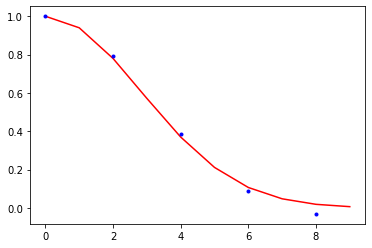

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 445
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [27.80213657 27.82522469 27.82463148 27.82465666 27.82459432]
Observation contribution to cost function [64.15571726 64.28675339 64.28789575 64.28535538 64.28803416]
Model contribution to cost function  [71.87999357 71.35747435 71.35699622 71.35951525 71.35689161]
The values of the cost function total [163.8378474  163.46945243 163.46952345 163.4695273  163.4695201 ]
RMS between background/truth and analysis/truth [0.37821979 0.19305363]
New estimate for variance coming from assimilation window 7: 0.04965219212829523
New estimate for correlation length coming from assimilation window 7: 3.1163349075481537


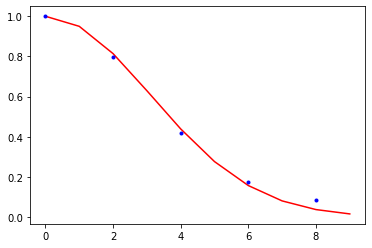

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [43.76988223 43.7432898  43.74526891 43.74517952 43.74499468]
Observation contribution to cost function [68.41355814 68.49113096 68.48651336 68.48553613 68.48710204]
Model contribution to cost function  [88.56526071 88.29602811 88.29867451 88.29974546 88.29835697]
The values of the cost function total [200.74870108 200.53044887 200.53045679 200.53046111 200.53045369]
RMS between background/truth and analysis/truth [0.4120927  0.20537051]
New estimate for variance coming from assimilation window 8: 0.059688511060845724
New estimate for correlation length coming from assimilation window 8: 3.304750791308011


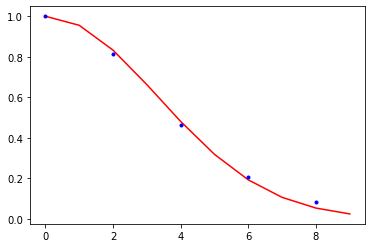

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 482
Number of inner iterations in outer iteration number 2: 177
Number of inner iterations in outer iteration number 3: 12
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [46.81521896 46.87455161 46.87682029 46.87676621 46.87665726]
Observation contribution to cost function [74.86647821 74.76066741 74.75517264 74.75462047 74.75552558]
Model contribution to cost function  [69.3385856  69.05872713 69.06198227 69.06258928 69.06179203]
The values of the cost function total [191.02028277 190.69394616 190.6939752  190.69397596 190.69397487]
RMS between background/truth and analysis/truth [0.34747129 0.20411335]
New estimate for variance coming from assimilation window 9: 0.03821202942654828
New estimate for correlation length coming from assimilation window 9: 2.4162893876860467


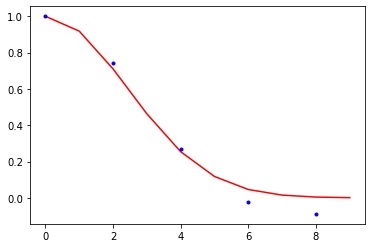

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 459
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.56594439 64.6311235  64.63540038 64.63496668 64.63487649]
Observation contribution to cost function [74.42218338 74.33698371 74.32746599 74.32780115 74.32873016]
Model contribution to cost function  [77.47802517 77.51573865 77.52117419 77.52127579 77.52044478]
The values of the cost function total [216.46615293 216.48384586 216.48404056 216.48404362 216.48405144]
RMS between background/truth and analysis/truth [0.43314087 0.22438024]
New estimate for variance coming from assimilation window 10: 0.06121361835412144
New estimate for correlation length coming from assimilation window 10: 3.1826002634326285


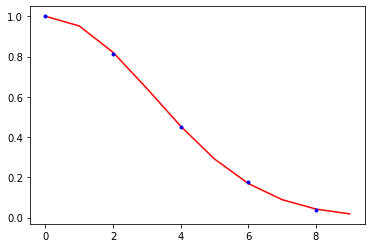

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 227
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [71.73287561 71.71875862 71.72454071 71.72334667 71.72305186]
Observation contribution to cost function [95.45768423 93.94251113 93.92232192 93.92288958 93.92454039]
Model contribution to cost function  [80.21001937 79.10140936 79.11549247 79.11614637 79.11480111]
The values of the cost function total [247.40057921 244.76267912 244.7623551  244.76238262 244.76239336]
RMS between background/truth and analysis/truth [0.38969242 0.22224268]
New estimate for variance coming from assimilation window 11: 0.049727663250936874
New estimate for correlation length coming from assimilation window 11: 2.6827511924908145


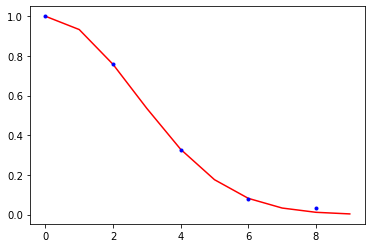

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [108.21153019 108.63502409 108.65693887 108.65445238 108.6541581 ]
Observation contribution to cost function [98.44766153 98.64006459 98.60960778 98.61231473 98.61029852]
Model contribution to cost function  [94.83346917 94.20433546 94.21356765 94.21342047 94.21571908]
The values of the cost function total [301.49266089 301.47942414 301.48011429 301.48018758 301.48017571]
RMS between background/truth and analysis/truth [0.44517134 0.24899071]
New estimate for variance coming from assimilation window 12: 0.05344648155880217
New estimate for correlation length coming from assimilation window 12: 2.6444116072721457


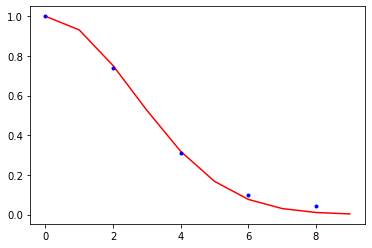

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 199
Number of inner iterations in outer iteration number 3: 28
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [144.06453627 144.09514574 144.12449427 144.12387128 144.12320802]
Observation contribution to cost function [149.70861616 148.06078366 148.00725046 148.00880735 148.00800998]
Model contribution to cost function  [98.93005425 97.06269293 97.08537392 97.08447516 97.08595089]
The values of the cost function total [392.70320668 389.21862233 389.21711865 389.21715379 389.2171689 ]
RMS between background/truth and analysis/truth [0.45203125 0.26139473]
New estimate for variance coming from assimilation window 13: 0.05612054154871247
New estimate for correlation length coming from assimilation window 13: 2.8899192246732426


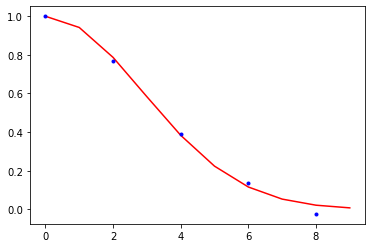

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 462
Number of inner iterations in outer iteration number 2: 191
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [126.00419276 126.00949773 126.02349687 126.02271742 126.02177311]
Observation contribution to cost function [133.23062963 133.07843952 133.04813101 133.04758207 133.05101977]
Model contribution to cost function  [98.52127981 95.5901161  95.60620958 95.60752379 95.60503817]
The values of the cost function total [357.7561022  354.67805335 354.67783746 354.67782327 354.67783105]
RMS between background/truth and analysis/truth [0.43696676 0.28128546]
New estimate for variance coming from assimilation window 14: 0.05366749887465298
New estimate for correlation length coming from assimilation window 14: 2.829081314384066


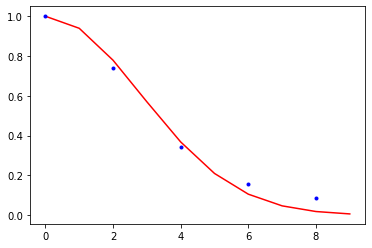

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [104.20406566 104.18557412 104.19830352 104.19679308 104.19620887]
Observation contribution to cost function [93.54469336 93.63046283 93.60757506 93.60950975 93.60989866]
Model contribution to cost function  [115.93296664 114.47835347 114.48812104 114.48769967 114.48789594]
The values of the cost function total [313.68172566 312.29439043 312.29399962 312.2940025  312.29400347]
RMS between background/truth and analysis/truth [0.48736258 0.28784529]
New estimate for variance coming from assimilation window 15: 0.08042751230219099
New estimate for correlation length coming from assimilation window 15: 2.989266120184887


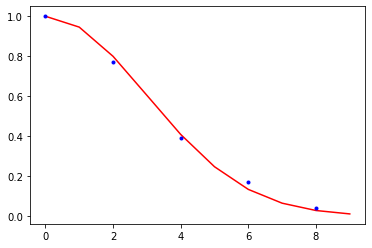

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [91.32366996 91.17088424 91.18027544 91.17766398 91.17583805]
Observation contribution to cost function [105.62651902 105.87082341 105.84462884 105.84789735 105.85033854]
Model contribution to cost function  [96.89440793 95.01728309 95.03362936 95.03295997 95.03233976]
The values of the cost function total [293.84459691 292.05899074 292.05853365 292.0585213  292.05851636]
RMS between background/truth and analysis/truth [0.46232828 0.31654457]
New estimate for variance coming from assimilation window 16: 0.04616556830542916
New estimate for correlation length coming from assimilation window 16: 2.51751918726393


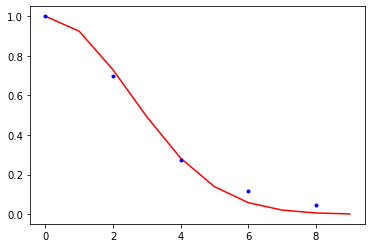

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 488
Number of inner iterations in outer iteration number 2: 251
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [137.37356529 137.54867902 137.5702002  137.56833233 137.5675226 ]
Observation contribution to cost function [146.45493711 147.91733654 147.86288527 147.86457425 147.86257816]
Model contribution to cost function  [118.31502656 115.65149204 115.68315359 115.68333782 115.68614013]
The values of the cost function total [402.14352896 401.11750759 401.11623905 401.1162444  401.11624089]
RMS between background/truth and analysis/truth [0.52783221 0.3418568 ]
New estimate for variance coming from assimilation window 17: 0.06385041986627794
New estimate for correlation length coming from assimilation window 17: 3.3082574621759746


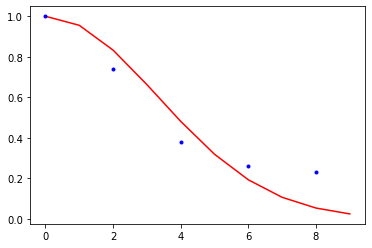

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 478
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 26
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [171.9779566  171.18033579 171.20181948 171.19700359 171.19539869]
Observation contribution to cost function [163.6647129  162.91229574 162.85490184 162.8590226  162.86106167]
Model contribution to cost function  [105.33708992 105.72742551 105.7616896  105.76240589 105.7619704 ]
The values of the cost function total [440.97975942 439.82005704 439.81841091 439.81843208 439.81843077]
RMS between background/truth and analysis/truth [0.54501628 0.37911275]
New estimate for variance coming from assimilation window 18: 0.05946231055214313
New estimate for correlation length coming from assimilation window 18: 2.496593970246349


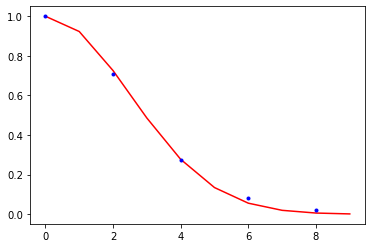

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 235
Number of inner iterations in outer iteration number 3: 37
Number of inner iterations in outer iteration number 4: 11
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [243.57203842 242.3015546  242.30598725 242.29630224 242.29486841]
Observation contribution to cost function [186.75428661 186.7491392  186.68557622 186.69196678 186.69283683]
Model contribution to cost function  [122.72533479 119.71861176 119.76967376 119.77291636 119.77347332]
The values of the cost function total [553.05165982 548.76930556 548.76123724 548.76118539 548.76117856]
RMS between background/truth and analysis/truth [0.56613381 0.38604621]
New estimate for variance coming from assimilation window 19: 0.0679726975378383
New estimate for correlation length coming from assimilation window 19: 2.8340759360161485


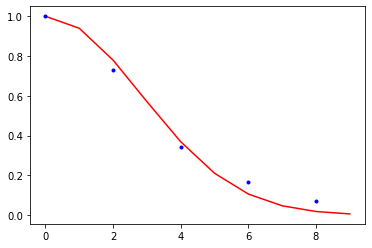

In [5]:
rd.seed(11)

win     = 20     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 3      # number of observations in time
mr      = 100    # number of observations in space
dmt     = 2      # number of temporal gridpoints between observations
dmr     = 2      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)


# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):
    u0 = my_Lorenz.step_rk4(u0) 



u_analysis, u_back, u_truth, var, length,  meanvar, meanlen, H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)


estimated variances [0.04251768 0.05213429 0.04750836 0.05231597 0.04303216 0.05178237
 0.04353263 0.04965219 0.05968851 0.03821203 0.06121362 0.04972766
 0.05344648 0.05612054 0.0536675  0.08042751 0.04616557 0.06385042
 0.05946231 0.0679727 ]
estimated correlation length [3.30809062 3.04689075 3.04478269 2.94623108 2.56736492 2.69831635
 2.83544802 3.11633491 3.30475079 2.41628939 3.18260026 2.68275119
 2.64441161 2.88991922 2.82908131 2.98926612 2.51751919 3.30825746
 2.49659397 2.83407594]


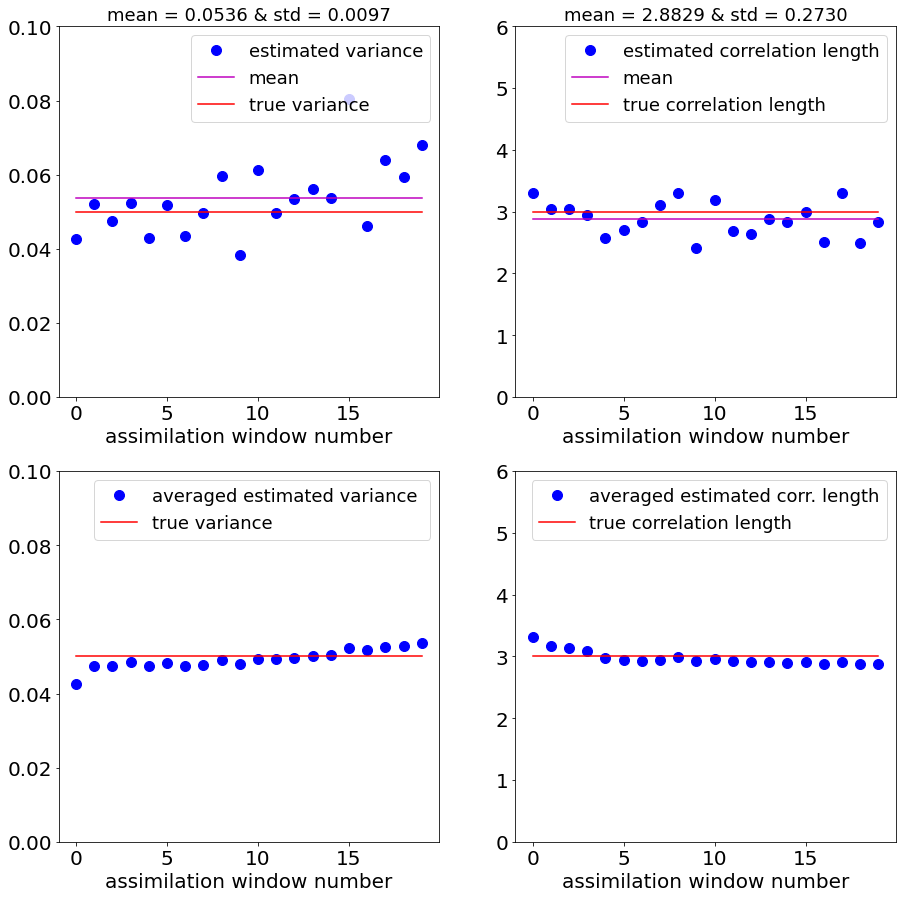

In [6]:
q_estimate_analysis(win,var,length,meanvar,meanlen,q_var_truth, l_truth)

### 2.5 Experiment 5: partial observations in time and space, structured B matrix


ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 9
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [58.54628227 58.60947802 58.6125496  58.61348805 58.61287458]
Observation contribution to cost function [173.82112013 173.71465095 173.71180939 173.7084759  173.70970064]
Model contribution to cost function  [304.69234423 304.7156228  304.71524498 304.71764141 304.71702353]
The values of the cost function total [537.05974662 537.03975176 537.03960398 537.03960536 537.03959875]
RMS between background/truth and analysis/truth [0.35479109 0.23674072]
New estimate for variance coming from assimilation window 0: 0.04251768425329842
New estimate for correlation length coming from assimilation window 0: 3.308090624662874


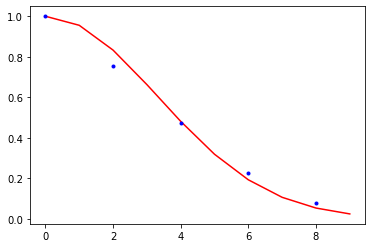

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 467
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.33663986 33.46606922 33.47054637 33.47046025 33.47032705]
Observation contribution to cost function [85.61324731 85.44143863 85.43218648 85.43140532 85.43283204]
Model contribution to cost function  [88.51143834 88.11247734 88.11738352 88.11824972 88.11696336]
The values of the cost function total [207.46132551 207.01998519 207.02011637 207.02011529 207.02012244]
RMS between background/truth and analysis/truth [0.44014839 0.23822073]
New estimate for variance coming from assimilation window 1: 0.05213429364960219
New estimate for correlation length coming from assimilation window 1: 3.046890753324869


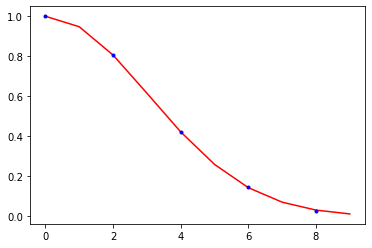

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 489
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [21.00621994 21.04040462 21.04035047 21.04028766 21.04024258]
Observation contribution to cost function [59.86205198 59.59828196 59.59568811 59.59630815 59.59662331]
Model contribution to cost function  [73.57111787 73.4043258  73.40699711 73.40643661 73.40616377]
The values of the cost function total [154.43938979 154.04301238 154.04303569 154.04303242 154.04302966]
RMS between background/truth and analysis/truth [0.3714511  0.19594769]
New estimate for variance coming from assimilation window 2: 0.047508357104506724
New estimate for correlation length coming from assimilation window 2: 3.0447826901104604


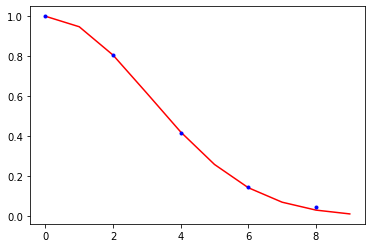

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 193
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [31.74506135 31.76379411 31.76369652 31.76365425 31.76343952]
Observation contribution to cost function [71.4675226  71.27082675 71.26562893 71.26368793 71.26662177]
Model contribution to cost function  [82.64775795 82.39623237 82.40150058 82.4034915  82.40076482]
The values of the cost function total [185.8603419  185.43085323 185.43082603 185.43083368 185.43082611]
RMS between background/truth and analysis/truth [0.40306164 0.19029856]
New estimate for variance coming from assimilation window 3: 0.05231597379660203
New estimate for correlation length coming from assimilation window 3: 2.9462310821310638


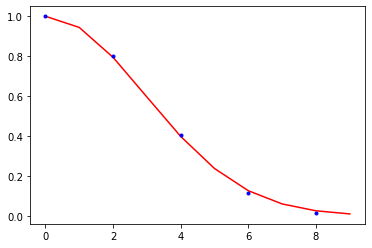

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 490
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [37.84508441 37.84645266 37.84877137 37.84868684 37.84837391]
Observation contribution to cost function [73.3011227  73.29865624 73.29471496 73.2922508  73.29547481]
Model contribution to cost function  [78.90196447 78.79490816 78.7965323  78.79908248 78.79617095]
The values of the cost function total [190.04817158 189.94001705 189.94001863 189.94002012 189.94001967]
RMS between background/truth and analysis/truth [0.35022326 0.18836643]
New estimate for variance coming from assimilation window 4: 0.043032156639565305
New estimate for correlation length coming from assimilation window 4: 2.567364922282975


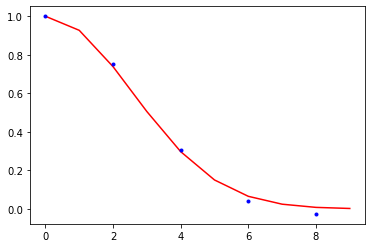

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [23.75604868 23.74079918 23.74074983 23.74049079 23.74038806]
Observation contribution to cost function [67.24625087 66.96578683 66.96287266 66.96344315 66.96301099]
Model contribution to cost function  [74.74883062 74.65396177 74.65691728 74.65660477 74.65714796]
The values of the cost function total [165.75113016 165.36054778 165.36053977 165.36053871 165.36054701]
RMS between background/truth and analysis/truth [0.35484016 0.19441077]
New estimate for variance coming from assimilation window 5: 0.0517823741219371
New estimate for correlation length coming from assimilation window 5: 2.6983163523158438


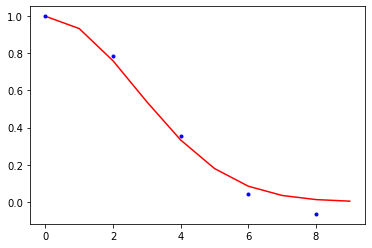

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 469
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 8
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.95873765 29.00294578 29.00389905 29.00375105 29.00372908]
Observation contribution to cost function [58.82898434 58.97469063 58.97186882 58.97321532 58.97218562]
Model contribution to cost function  [66.49843918 66.19279542 66.19467154 66.1934728  66.1945227 ]
The values of the cost function total [154.28616117 154.17043183 154.17043941 154.17043917 154.17043739]
RMS between background/truth and analysis/truth [0.33015679 0.19335164]
New estimate for variance coming from assimilation window 6: 0.0435326259498347
New estimate for correlation length coming from assimilation window 6: 2.835448021247274


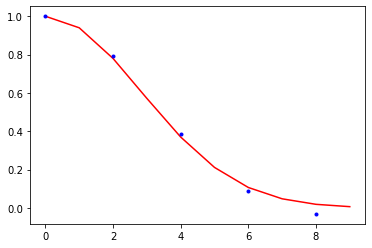

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 445
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [27.80213657 27.82522469 27.82463148 27.82465666 27.82459432]
Observation contribution to cost function [64.15571726 64.28675339 64.28789575 64.28535538 64.28803416]
Model contribution to cost function  [71.87999357 71.35747435 71.35699622 71.35951525 71.35689161]
The values of the cost function total [163.8378474  163.46945243 163.46952345 163.4695273  163.4695201 ]
RMS between background/truth and analysis/truth [0.37821979 0.19305363]
New estimate for variance coming from assimilation window 7: 0.04965219212829523
New estimate for correlation length coming from assimilation window 7: 3.1163349075481537


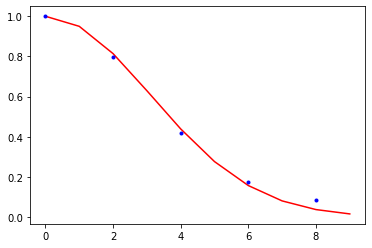

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [43.76988223 43.7432898  43.74526891 43.74517952 43.74499468]
Observation contribution to cost function [68.41355814 68.49113096 68.48651336 68.48553613 68.48710204]
Model contribution to cost function  [88.56526071 88.29602811 88.29867451 88.29974546 88.29835697]
The values of the cost function total [200.74870108 200.53044887 200.53045679 200.53046111 200.53045369]
RMS between background/truth and analysis/truth [0.4120927  0.20537051]
New estimate for variance coming from assimilation window 8: 0.059688511060845724
New estimate for correlation length coming from assimilation window 8: 3.304750791308011


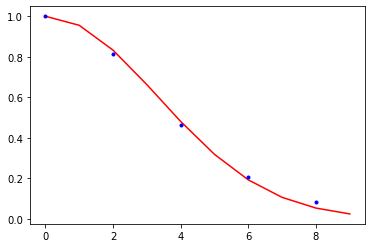

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 482
Number of inner iterations in outer iteration number 2: 177
Number of inner iterations in outer iteration number 3: 12
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [46.81521896 46.87455161 46.87682029 46.87676621 46.87665726]
Observation contribution to cost function [74.86647821 74.76066741 74.75517264 74.75462047 74.75552558]
Model contribution to cost function  [69.3385856  69.05872713 69.06198227 69.06258928 69.06179203]
The values of the cost function total [191.02028277 190.69394616 190.6939752  190.69397596 190.69397487]
RMS between background/truth and analysis/truth [0.34747129 0.20411335]
New estimate for variance coming from assimilation window 9: 0.03821202942654828
New estimate for correlation length coming from assimilation window 9: 2.4162893876860467


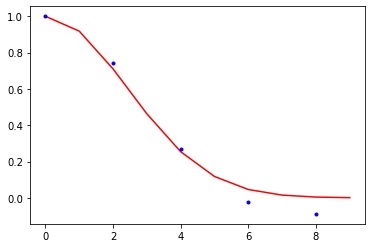

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 459
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.56594439 64.6311235  64.63540038 64.63496668 64.63487649]
Observation contribution to cost function [74.42218338 74.33698371 74.32746599 74.32780115 74.32873016]
Model contribution to cost function  [77.47802517 77.51573865 77.52117419 77.52127579 77.52044478]
The values of the cost function total [216.46615293 216.48384586 216.48404056 216.48404362 216.48405144]
RMS between background/truth and analysis/truth [0.43314087 0.22438024]
New estimate for variance coming from assimilation window 10: 0.06121361835412144
New estimate for correlation length coming from assimilation window 10: 3.1826002634326285


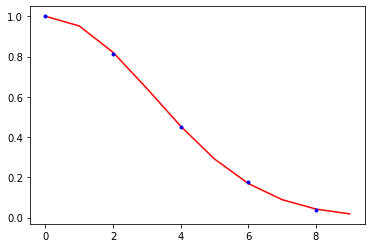

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 227
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [71.73287561 71.71875862 71.72454071 71.72334667 71.72305186]
Observation contribution to cost function [95.45768423 93.94251113 93.92232192 93.92288958 93.92454039]
Model contribution to cost function  [80.21001937 79.10140936 79.11549247 79.11614637 79.11480111]
The values of the cost function total [247.40057921 244.76267912 244.7623551  244.76238262 244.76239336]
RMS between background/truth and analysis/truth [0.38969242 0.22224268]
New estimate for variance coming from assimilation window 11: 0.049727663250936874
New estimate for correlation length coming from assimilation window 11: 2.6827511924908145


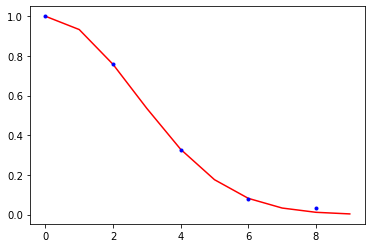

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [108.21153019 108.63502409 108.65693887 108.65445238 108.6541581 ]
Observation contribution to cost function [98.44766153 98.64006459 98.60960778 98.61231473 98.61029852]
Model contribution to cost function  [94.83346917 94.20433546 94.21356765 94.21342047 94.21571908]
The values of the cost function total [301.49266089 301.47942414 301.48011429 301.48018758 301.48017571]
RMS between background/truth and analysis/truth [0.44517134 0.24899071]
New estimate for variance coming from assimilation window 12: 0.05344648155880217
New estimate for correlation length coming from assimilation window 12: 2.6444116072721457


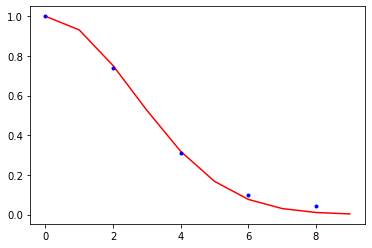

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 199
Number of inner iterations in outer iteration number 3: 28
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [144.06453627 144.09514574 144.12449427 144.12387128 144.12320802]
Observation contribution to cost function [149.70861616 148.06078366 148.00725046 148.00880735 148.00800998]
Model contribution to cost function  [98.93005425 97.06269293 97.08537392 97.08447516 97.08595089]
The values of the cost function total [392.70320668 389.21862233 389.21711865 389.21715379 389.2171689 ]
RMS between background/truth and analysis/truth [0.45203125 0.26139473]
New estimate for variance coming from assimilation window 13: 0.05612054154871247
New estimate for correlation length coming from assimilation window 13: 2.8899192246732426


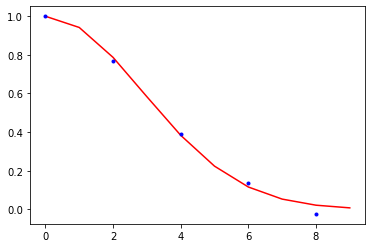

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 462
Number of inner iterations in outer iteration number 2: 191
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [126.00419276 126.00949773 126.02349687 126.02271742 126.02177311]
Observation contribution to cost function [133.23062963 133.07843952 133.04813101 133.04758207 133.05101977]
Model contribution to cost function  [98.52127981 95.5901161  95.60620958 95.60752379 95.60503817]
The values of the cost function total [357.7561022  354.67805335 354.67783746 354.67782327 354.67783105]
RMS between background/truth and analysis/truth [0.43696676 0.28128546]
New estimate for variance coming from assimilation window 14: 0.05366749887465298
New estimate for correlation length coming from assimilation window 14: 2.829081314384066


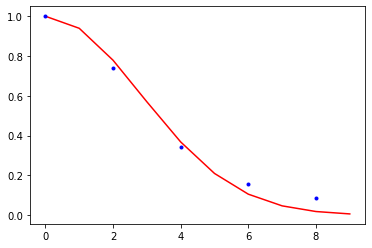

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [104.20406566 104.18557412 104.19830352 104.19679308 104.19620887]
Observation contribution to cost function [93.54469336 93.63046283 93.60757506 93.60950975 93.60989866]
Model contribution to cost function  [115.93296664 114.47835347 114.48812104 114.48769967 114.48789594]
The values of the cost function total [313.68172566 312.29439043 312.29399962 312.2940025  312.29400347]
RMS between background/truth and analysis/truth [0.48736258 0.28784529]
New estimate for variance coming from assimilation window 15: 0.08042751230219099
New estimate for correlation length coming from assimilation window 15: 2.989266120184887


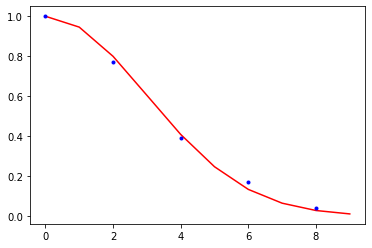

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [91.32366996 91.17088424 91.18027544 91.17766398 91.17583805]
Observation contribution to cost function [105.62651902 105.87082341 105.84462884 105.84789735 105.85033854]
Model contribution to cost function  [96.89440793 95.01728309 95.03362936 95.03295997 95.03233976]
The values of the cost function total [293.84459691 292.05899074 292.05853365 292.0585213  292.05851636]
RMS between background/truth and analysis/truth [0.46232828 0.31654457]
New estimate for variance coming from assimilation window 16: 0.04616556830542916
New estimate for correlation length coming from assimilation window 16: 2.51751918726393


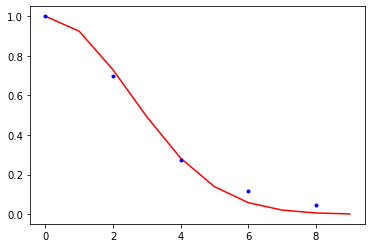

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 488
Number of inner iterations in outer iteration number 2: 251
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [137.37356529 137.54867902 137.5702002  137.56833233 137.5675226 ]
Observation contribution to cost function [146.45493711 147.91733654 147.86288527 147.86457425 147.86257816]
Model contribution to cost function  [118.31502656 115.65149204 115.68315359 115.68333782 115.68614013]
The values of the cost function total [402.14352896 401.11750759 401.11623905 401.1162444  401.11624089]
RMS between background/truth and analysis/truth [0.52783221 0.3418568 ]
New estimate for variance coming from assimilation window 17: 0.06385041986627794
New estimate for correlation length coming from assimilation window 17: 3.3082574621759746


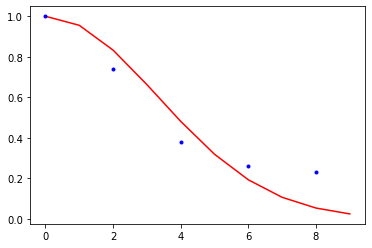

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 478
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 26
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [171.9779566  171.18033579 171.20181948 171.19700359 171.19539869]
Observation contribution to cost function [163.6647129  162.91229574 162.85490184 162.8590226  162.86106167]
Model contribution to cost function  [105.33708992 105.72742551 105.7616896  105.76240589 105.7619704 ]
The values of the cost function total [440.97975942 439.82005704 439.81841091 439.81843208 439.81843077]
RMS between background/truth and analysis/truth [0.54501628 0.37911275]
New estimate for variance coming from assimilation window 18: 0.05946231055214313
New estimate for correlation length coming from assimilation window 18: 2.496593970246349


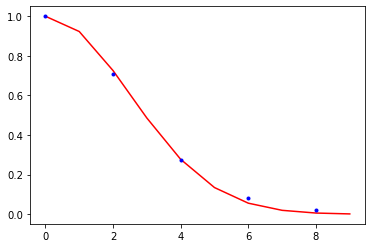

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 235
Number of inner iterations in outer iteration number 3: 37
Number of inner iterations in outer iteration number 4: 11
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [243.57203842 242.3015546  242.30598725 242.29630224 242.29486841]
Observation contribution to cost function [186.75428661 186.7491392  186.68557622 186.69196678 186.69283683]
Model contribution to cost function  [122.72533479 119.71861176 119.76967376 119.77291636 119.77347332]
The values of the cost function total [553.05165982 548.76930556 548.76123724 548.76118539 548.76117856]
RMS between background/truth and analysis/truth [0.56613381 0.38604621]
New estimate for variance coming from assimilation window 19: 0.0679726975378383
New estimate for correlation length coming from assimilation window 19: 2.8340759360161485


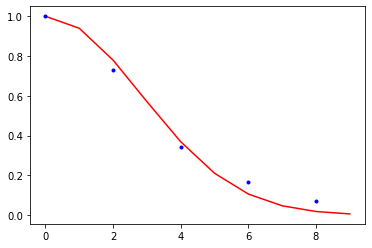

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 5
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [38.80206705 38.80807697 38.80741744 38.81038578 38.80827739]
Observation contribution to cost function [157.78433526 157.74851437 157.7530787  157.73975124 157.74644369]
Model contribution to cost function  [241.63610433 241.57571949 241.57180978 241.58216316 241.57757213]
The values of the cost function total [438.22250664 438.13231083 438.13230592 438.13230018 438.13229321]
RMS between background/truth and analysis/truth [0.3019616  0.19722722]
New estimate for variance coming from assimilation window 0: 0.03214465089053393
New estimate for correlation length coming from assimilation window 0: 2.489654478983168


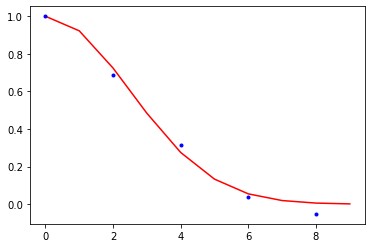

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 251
Number of inner iterations in outer iteration number 2: 105
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [20.06386282 19.98297724 19.98303612 19.98295093 19.98300974]
Observation contribution to cost function [57.98182307 57.61364953 57.61234132 57.61253637 57.60982667]
Model contribution to cost function  [89.04685092 89.02745766 89.02871319 89.02860876 89.03127422]
The values of the cost function total [167.09253681 166.62408444 166.62409063 166.62409606 166.62411063]
RMS between background/truth and analysis/truth [0.40924916 0.2183431 ]
New estimate for variance coming from assimilation window 1: 0.04285612947832987
New estimate for correlation length coming from assimilation window 1: 3.02614400378474


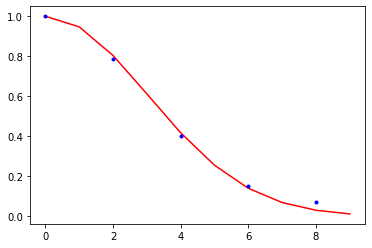

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 339
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [29.12120117 29.1815919  29.18254823 29.18225509 29.18203586]
Observation contribution to cost function [75.33241645 75.38632571 75.38207273 75.38270187 75.38306702]
Model contribution to cost function  [91.80272571 91.39163248 91.39492331 91.39457973 91.39442815]
The values of the cost function total [196.25634333 195.95955009 195.95954427 195.95953669 195.95953103]
RMS between background/truth and analysis/truth [0.36965806 0.19843113]
New estimate for variance coming from assimilation window 2: 0.049114933668050934
New estimate for correlation length coming from assimilation window 2: 2.640460258445756


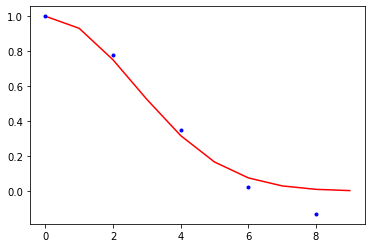

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 353
Number of inner iterations in outer iteration number 2: 137
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [24.33835135 24.36590996 24.36715122 24.36674747 24.36648949]
Observation contribution to cost function [56.28226567 56.04525675 56.04173476 56.04243856 56.04276909]
Model contribution to cost function  [89.05050495 89.21798499 89.22025388 89.21994899 89.21987285]
The values of the cost function total [169.67112198 169.6291517  169.62913985 169.62913502 169.62913143]
RMS between background/truth and analysis/truth [0.33229776 0.18324659]
New estimate for variance coming from assimilation window 3: 0.04876418430451393
New estimate for correlation length coming from assimilation window 3: 2.7810306856416047


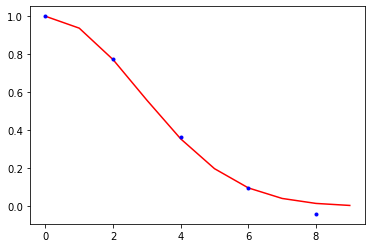

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 363
Number of inner iterations in outer iteration number 2: 137
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [14.43332024 14.41739135 14.41744383 14.41744339 14.41750722]
Observation contribution to cost function [55.95911706 56.06108903 56.06093654 56.0609223  56.0592244 ]
Model contribution to cost function  [75.76892937 75.23622641 75.23631035 75.23632215 75.23797006]
The values of the cost function total [146.16136667 145.71470679 145.71469072 145.71468784 145.71470168]
RMS between background/truth and analysis/truth [0.32803007 0.17670629]
New estimate for variance coming from assimilation window 4: 0.04570191154288159
New estimate for correlation length coming from assimilation window 4: 2.9254985597886716


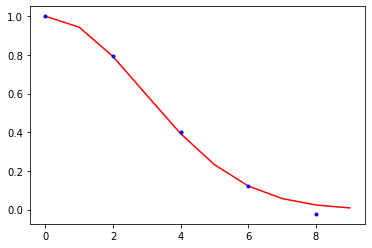

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 387
Number of inner iterations in outer iteration number 2: 143
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [19.31300219 19.31225015 19.31315304 19.31293242 19.31278458]
Observation contribution to cost function [60.08890782 59.9675774  59.96330739 59.96427203 59.96483452]
Model contribution to cost function  [78.88903274 78.6140849  78.61743466 78.61668697 78.61627078]
The values of the cost function total [158.29094275 157.89391245 157.89389509 157.89389142 157.89388988]
RMS between background/truth and analysis/truth [0.33648582 0.18141206]
New estimate for variance coming from assimilation window 5: 0.04659763770334387
New estimate for correlation length coming from assimilation window 5: 2.844908850249098


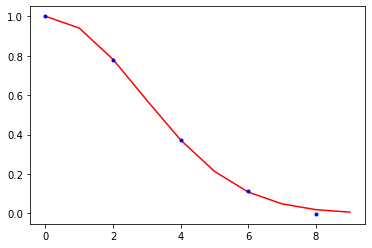

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 381
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [18.13913371 18.07174286 18.07248474 18.07233847 18.0722412 ]
Observation contribution to cost function [54.63589763 54.43177043 54.42977416 54.43017039 54.43041271]
Model contribution to cost function  [81.95223818 81.2968971  81.29814578 81.29789488 81.29774996]
The values of the cost function total [154.72726952 153.80041038 153.80040468 153.80040374 153.80040387]
RMS between background/truth and analysis/truth [0.37838827 0.19627525]
New estimate for variance coming from assimilation window 6: 0.04996169875204477
New estimate for correlation length coming from assimilation window 6: 2.944301177559863


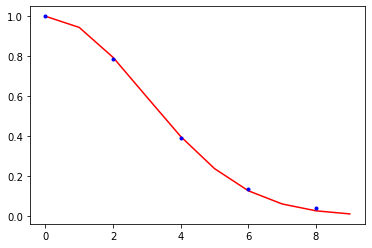

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 408
Number of inner iterations in outer iteration number 2: 157
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [25.62838497 25.66109613 25.66197145 25.66177534 25.66173538]
Observation contribution to cost function [63.76434243 63.67983233 63.67425951 63.67511658 63.67503414]
Model contribution to cost function  [79.55707077 79.33048906 79.33520251 79.33454251 79.33466044]
The values of the cost function total [168.94979817 168.67141752 168.67143347 168.67143443 168.67142996]
RMS between background/truth and analysis/truth [0.34882319 0.20436245]
New estimate for variance coming from assimilation window 7: 0.04474663534182767
New estimate for correlation length coming from assimilation window 7: 2.463770539156241


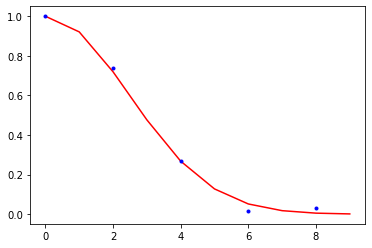

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 403
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.61530257 30.70921081 30.7101318  30.71001194 30.70977044]
Observation contribution to cost function [66.68027828 66.65479792 66.65069786 66.64878471 66.65145147]
Model contribution to cost function  [76.94549943 76.12305714 76.12623646 76.12827328 76.12584004]
The values of the cost function total [174.24108028 173.48706586 173.48706612 173.48706992 173.48706195]
RMS between background/truth and analysis/truth [0.38672635 0.2130035 ]
New estimate for variance coming from assimilation window 8: 0.046333192409728864
New estimate for correlation length coming from assimilation window 8: 2.8009137166671265


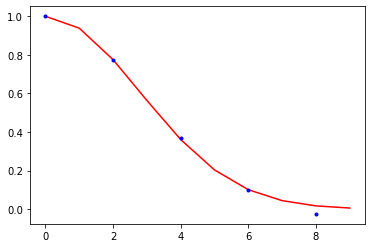

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 399
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.00307432 27.03227635 27.03303948 27.03263489 27.03234883]
Observation contribution to cost function [64.95749696 64.8888194  64.88597597 64.88667001 64.88708901]
Model contribution to cost function  [94.66597085 94.00497543 94.00704374 94.00675083 94.00661567]
The values of the cost function total [186.62654213 185.92607118 185.92605919 185.92605573 185.9260535 ]
RMS between background/truth and analysis/truth [0.43452634 0.2277394 ]
New estimate for variance coming from assimilation window 9: 0.06097915363108988
New estimate for correlation length coming from assimilation window 9: 3.180351350966452


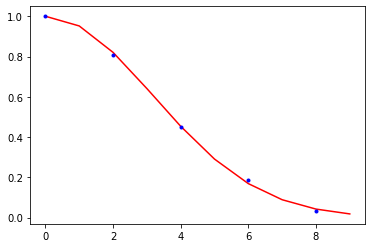

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 430
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [51.79761967 51.86868025 51.86949371 51.86895596 51.86877613]
Observation contribution to cost function [70.44397736 70.4367142  70.42923358 70.43082556 70.43229252]
Model contribution to cost function  [96.76998724 96.67515439 96.68176516 96.68070668 96.67942363]
The values of the cost function total [219.01158427 218.98054884 218.98049245 218.9804882  218.98049228]
RMS between background/truth and analysis/truth [0.4294236  0.25568593]
New estimate for variance coming from assimilation window 10: 0.05594397037289224
New estimate for correlation length coming from assimilation window 10: 2.6017279476248816


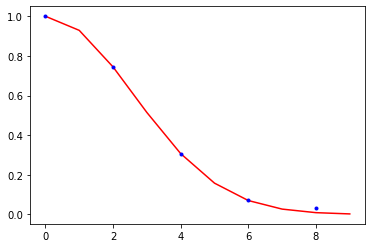

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 448
Number of inner iterations in outer iteration number 2: 173
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [51.98480812 52.04941693 52.04524272 52.04496192 52.04457975]
Observation contribution to cost function [92.38642778 92.29831854 92.29171134 92.29367658 92.29354436]
Model contribution to cost function  [86.50748652 86.07745236 86.08824623 86.08655922 86.08707658]
The values of the cost function total [230.87872242 230.42518783 230.42520029 230.42519772 230.42520069]
RMS between background/truth and analysis/truth [0.41043548 0.26796174]
New estimate for variance coming from assimilation window 11: 0.04448077872937142
New estimate for correlation length coming from assimilation window 11: 2.370197415128746


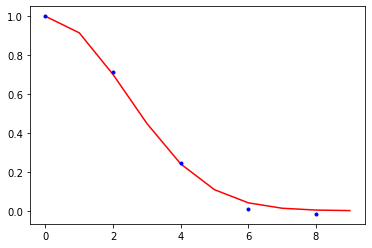

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 427
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.95677675 62.07349596 62.07768057 62.07706532 62.07645717]
Observation contribution to cost function [87.94302292 88.28289468 88.27652937 88.27748044 88.27823537]
Model contribution to cost function  [88.98827213 87.9538822  87.95578378 87.95543813 87.95528528]
The values of the cost function total [238.88807181 238.31027284 238.30999373 238.30998388 238.30997781]
RMS between background/truth and analysis/truth [0.45774268 0.29198903]
New estimate for variance coming from assimilation window 12: 0.058578275783162895
New estimate for correlation length coming from assimilation window 12: 3.3144926491149516


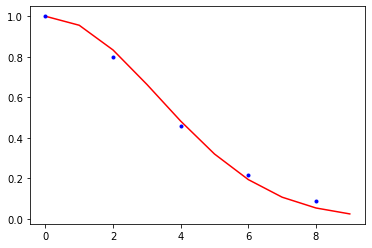

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 445
Number of inner iterations in outer iteration number 2: 211
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [73.32725479 73.57561077 73.58623954 73.58516639 73.58388867]
Observation contribution to cost function [99.03815297 98.3283257  98.30186327 98.30317992 98.30509949]
Model contribution to cost function  [103.18032308 100.96990266 100.98536064 100.98513243 100.98451073]
The values of the cost function total [275.54573084 272.87383912 272.87346345 272.87347875 272.87349888]
RMS between background/truth and analysis/truth [0.49916116 0.31614956]
New estimate for variance coming from assimilation window 13: 0.06418932098560451
New estimate for correlation length coming from assimilation window 13: 3.151842784665174


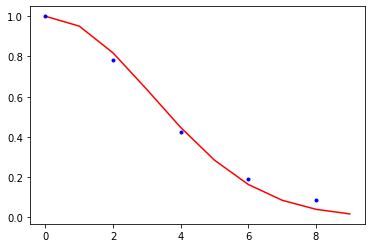

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [69.41970361 69.22575503 69.23423725 69.23324731 69.23250211]
Observation contribution to cost function [93.73802928 92.86353641 92.84935617 92.85090247 92.85207289]
Model contribution to cost function  [101.1242241  102.40523769 102.4108821  102.41033471 102.40991635]
The values of the cost function total [264.28195699 264.49452913 264.49447551 264.49448449 264.49449135]
RMS between background/truth and analysis/truth [0.5312263  0.35594957]
New estimate for variance coming from assimilation window 14: 0.060497282812688596
New estimate for correlation length coming from assimilation window 14: 2.6665556805291355


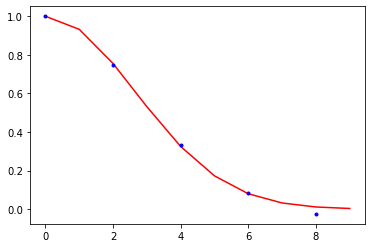

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 438
Number of inner iterations in outer iteration number 2: 213
Number of inner iterations in outer iteration number 3: 16
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [109.29470234 109.58075358 109.58857548 109.58831939 109.58764676]
Observation contribution to cost function [112.13235199 112.46094944 112.43584756 112.43714238 112.43763085]
Model contribution to cost function  [110.17027298 108.81478683 108.83218503 108.8311358  108.83133334]
The values of the cost function total [331.59732731 330.85648985 330.85660807 330.85659757 330.85661096]
RMS between background/truth and analysis/truth [0.52014988 0.38023289]
New estimate for variance coming from assimilation window 15: 0.047708875906334325
New estimate for correlation length coming from assimilation window 15: 2.1616377015700414


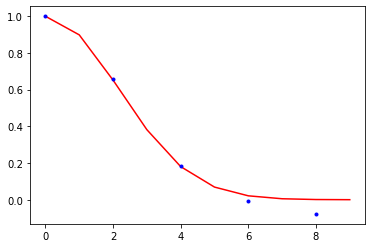

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 446
Number of inner iterations in outer iteration number 2: 185
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [117.26535708 116.91049374 116.92619491 116.92572009 116.92538998]
Observation contribution to cost function [112.01701733 110.92531171 110.90396525 110.90434647 110.9030986 ]
Model contribution to cost function  [100.54776287 100.1896781  100.19521365 100.19531705 100.19691464]
The values of the cost function total [329.83013728 328.02548354 328.02537381 328.02538362 328.02540321]
RMS between background/truth and analysis/truth [0.56827268 0.41515467]
New estimate for variance coming from assimilation window 16: 0.053287543755362744
New estimate for correlation length coming from assimilation window 16: 3.0841852053122287


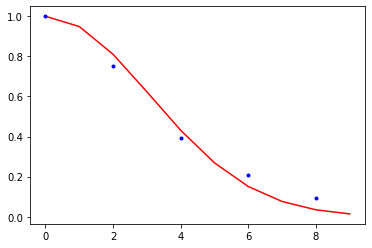

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 478
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [125.2039003  125.5120919  125.52345051 125.5219002  125.5206962 ]
Observation contribution to cost function [126.88878215 127.9345902  127.90805567 127.91118776 127.91158604]
Model contribution to cost function  [108.74012247 107.0904487  107.1050766  107.10352333 107.10433256]
The values of the cost function total [360.83280493 360.53713081 360.53658278 360.53661129 360.5366148 ]
RMS between background/truth and analysis/truth [0.59288242 0.43785275]
New estimate for variance coming from assimilation window 17: 0.0529150520340993
New estimate for correlation length coming from assimilation window 17: 2.462223667460524


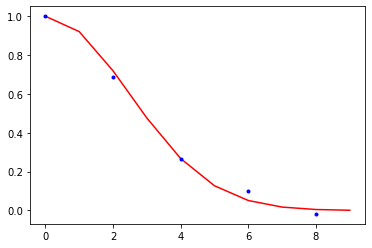

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 490
Number of inner iterations in outer iteration number 2: 245
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [174.65730199 174.76792937 174.80473165 174.80128407 174.80098708]
Observation contribution to cost function [148.62449097 148.1511564  148.09330384 148.10052537 148.09802007]
Model contribution to cost function  [126.58303746 129.41187419 129.43209442 129.42835103 129.43115655]
The values of the cost function total [449.86483043 452.33095996 452.3301299  452.33016048 452.3301637 ]
RMS between background/truth and analysis/truth [0.66083501 0.46729342]
New estimate for variance coming from assimilation window 18: 0.06925526168201496
New estimate for correlation length coming from assimilation window 18: 2.333045059800003


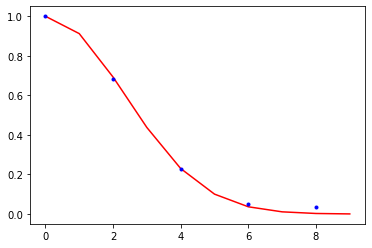

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 456
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 51
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [247.92076216 249.95491528 249.95710485 249.95987581 249.96017406]
Observation contribution to cost function [210.09181715 211.01786009 210.98951182 210.98825913 210.98742906]
Model contribution to cost function  [140.71503365 138.42926671 138.45655028 138.45509937 138.45561559]
The values of the cost function total [598.72761296 599.40204209 599.40316695 599.40323431 599.40321871]
RMS between background/truth and analysis/truth [0.68050421 0.49266626]
New estimate for variance coming from assimilation window 19: 0.06338808467901336
New estimate for correlation length coming from assimilation window 19: 2.2251665421905


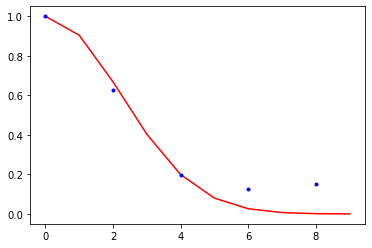

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [35.83397298 35.82739618 35.82780458 35.82961314 35.82883997]
Observation contribution to cost function [147.5747426  147.59925197 147.60117625 147.59255381 147.59508771]
Model contribution to cost function  [226.73377082 226.55660327 226.55426201 226.56107387 226.55930825]
The values of the cost function total [410.1424864  409.98325142 409.98324284 409.98324082 409.98323593]
RMS between background/truth and analysis/truth [0.28354172 0.19529539]
New estimate for variance coming from assimilation window 0: 0.030052882105015943
New estimate for correlation length coming from assimilation window 0: 2.268511970842982


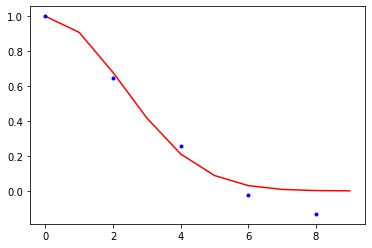

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 205
Number of inner iterations in outer iteration number 2: 77
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [20.38566866 20.40511696 20.40562927 20.40580501 20.40549981]
Observation contribution to cost function [58.28440247 58.2644611  58.26257819 58.25780945 58.26264166]
Model contribution to cost function  [118.67864991 117.83585385 117.83722669 117.84182319 117.83729047]
The values of the cost function total [197.34872103 196.50543192 196.50543415 196.50543765 196.50543194]
RMS between background/truth and analysis/truth [0.4079069  0.22032404]
New estimate for variance coming from assimilation window 1: 0.05086979156400666
New estimate for correlation length coming from assimilation window 1: 3.0926518681260506


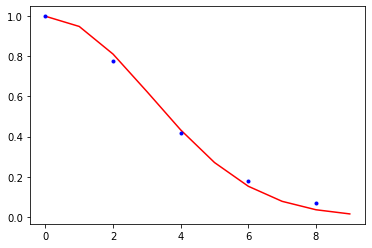

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 343
Number of inner iterations in outer iteration number 2: 121
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [18.97139432 18.90534087 18.90550315 18.90553231 18.90555455]
Observation contribution to cost function [51.82311851 51.74940915 51.74891652 51.74870959 51.74853955]
Model contribution to cost function  [76.58754306 76.24111    76.24144454 76.2416209  76.24176848]
The values of the cost function total [147.38205589 146.89586002 146.89586421 146.8958628  146.89586258]
RMS between background/truth and analysis/truth [0.3454571 0.1957412]
New estimate for variance coming from assimilation window 2: 0.04536710280244344
New estimate for correlation length coming from assimilation window 2: 2.9176535044413723


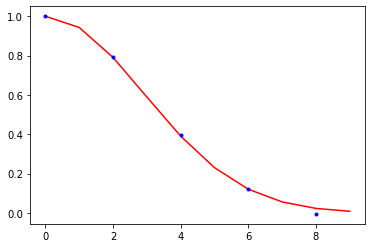

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 371
Number of inner iterations in outer iteration number 2: 143
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [22.11916103 22.03867708 22.03932504 22.03919206 22.03926196]
Observation contribution to cost function [52.00953486 52.10413981 52.10311204 52.10359588 52.10080115]
Model contribution to cost function  [78.31100936 77.74947937 77.74985367 77.74949574 77.75222709]
The values of the cost function total [152.43970525 151.89229625 151.89229075 151.89228368 151.89229019]
RMS between background/truth and analysis/truth [0.35978995 0.20997231]
New estimate for variance coming from assimilation window 3: 0.049841660177125754
New estimate for correlation length coming from assimilation window 3: 3.3235319472116234


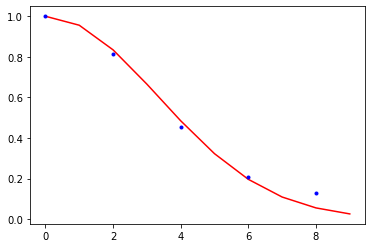

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 409
Number of inner iterations in outer iteration number 2: 161
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.88227344 30.92695406 30.92810368 30.92777992 30.92771054]
Observation contribution to cost function [66.30060046 66.33915072 66.3363188  66.3369644  66.33464952]
Model contribution to cost function  [91.72545954 90.96207811 90.96378363 90.96346083 90.96585091]
The values of the cost function total [188.90833344 188.22818289 188.22820611 188.22820514 188.22821097]
RMS between background/truth and analysis/truth [0.37578301 0.21680073]
New estimate for variance coming from assimilation window 4: 0.05903552988398644
New estimate for correlation length coming from assimilation window 4: 3.746836346825249


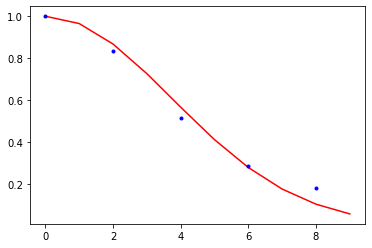

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 437
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [45.89614547 45.90861247 45.90832354 45.90789902 45.9076138 ]
Observation contribution to cost function [66.92544776 67.01305189 67.00940019 67.01001775 67.01049617]
Model contribution to cost function  [85.28086125 85.12983301 85.13361739 85.13342121 85.13322376]
The values of the cost function total [198.10245448 198.05149737 198.05134112 198.05133798 198.05133372]
RMS between background/truth and analysis/truth [0.44120536 0.21993278]
New estimate for variance coming from assimilation window 5: 0.061708149712317785
New estimate for correlation length coming from assimilation window 5: 3.335740313579271


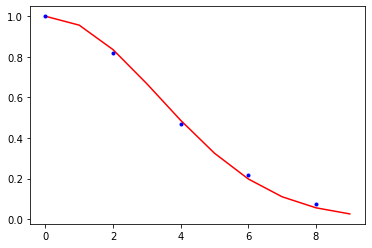

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 484
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.71748138 64.66355962 64.66737423 64.66689974 64.66646391]
Observation contribution to cost function [88.69468173 88.09854608 88.08728269 88.08819829 88.08887381]
Model contribution to cost function  [92.61897816 91.40821696 91.41554841 91.41511035 91.41487594]
The values of the cost function total [246.03114127 244.17032266 244.17020532 244.17020838 244.17021366]
RMS between background/truth and analysis/truth [0.38092875 0.22625176]
New estimate for variance coming from assimilation window 6: 0.057113941371297196
New estimate for correlation length coming from assimilation window 6: 2.9275349597797238


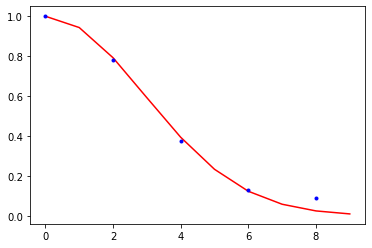

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 500
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [69.92201566 69.95994334 69.96945426 69.96860766 69.96774704]
Observation contribution to cost function [84.04567892 84.52618996 84.51246405 84.51342707 84.51445181]
Model contribution to cost function  [73.70933787 72.65467358 72.65874081 72.65862413 72.65846079]
The values of the cost function total [227.67703244 227.14080688 227.14065911 227.14065886 227.14065964]
RMS between background/truth and analysis/truth [0.39602282 0.23788813]
New estimate for variance coming from assimilation window 7: 0.04206824011696016
New estimate for correlation length coming from assimilation window 7: 2.5909360689092713


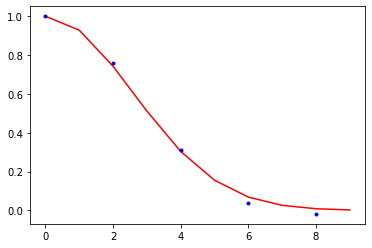

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 491
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [80.91870827 80.85388592 80.86925712 80.86770921 80.86647777]
Observation contribution to cost function [104.14554463 103.97514817 103.95008294 103.95195524 103.95361249]
Model contribution to cost function  [88.36499589 88.286928   88.29594655 88.29562731 88.29520811]
The values of the cost function total [273.42924878 273.11596209 273.11528661 273.11529175 273.11529837]
RMS between background/truth and analysis/truth [0.43015108 0.24749771]
New estimate for variance coming from assimilation window 8: 0.05857964701847736
New estimate for correlation length coming from assimilation window 8: 3.615526274326898


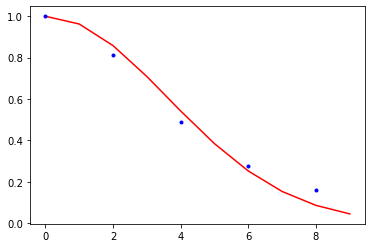

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 525
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 29
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [97.59124025 97.41140131 97.42287155 97.42101138 97.42037025]
Observation contribution to cost function [117.34352967 117.21809087 117.17544137 117.17718669 117.17595543]
Model contribution to cost function  [85.2215422  84.42659364 84.45513379 84.45520675 84.45707995]
The values of the cost function total [300.15631213 299.05608581 299.0534467  299.05340482 299.05340563]
RMS between background/truth and analysis/truth [0.46429239 0.27343037]
New estimate for variance coming from assimilation window 9: 0.052566647220635046
New estimate for correlation length coming from assimilation window 9: 2.9282989242897166


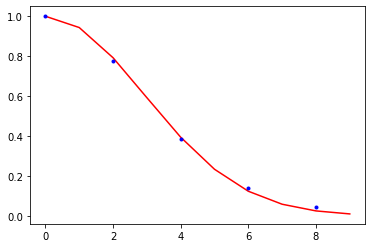

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 518
Number of inner iterations in outer iteration number 2: 217
Number of inner iterations in outer iteration number 3: 28
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [139.93356372 139.78045353 139.82110617 139.81722459 139.81663529]
Observation contribution to cost function [139.06630107 139.08116896 139.01456467 139.0206943  139.02041928]
Model contribution to cost function  [109.68509788 109.24374757 109.26862559 109.26639328 109.26726424]
The values of the cost function total [388.68496267 388.10537006 388.10429642 388.10431218 388.10431881]
RMS between background/truth and analysis/truth [0.49498019 0.29199574]
New estimate for variance coming from assimilation window 10: 0.060663408294272914
New estimate for correlation length coming from assimilation window 10: 2.2832578049069796


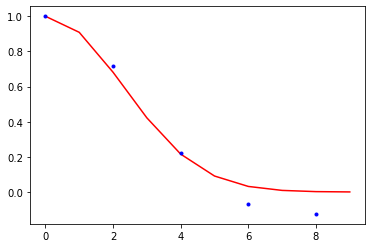

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 512
Number of inner iterations in outer iteration number 2: 223
Number of inner iterations in outer iteration number 3: 37
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [140.23058447 139.27328013 139.27799029 139.27250556 139.27223464]
Observation contribution to cost function [122.34003079 121.4293888  121.35871401 121.359943   121.36010586]
Model contribution to cost function  [110.00179534 110.19252017 110.25144569 110.25564535 110.25575689]
The values of the cost function total [372.5724106  370.8951891  370.88815    370.88809392 370.8880974 ]
RMS between background/truth and analysis/truth [0.50285365 0.31420151]
New estimate for variance coming from assimilation window 11: 0.0658468063464952
New estimate for correlation length coming from assimilation window 11: 2.5970182988087256


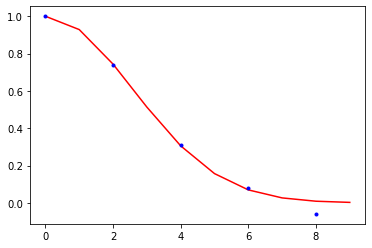

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 520
Number of inner iterations in outer iteration number 2: 249
Number of inner iterations in outer iteration number 3: 45
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [159.40494821 157.91759501 157.93242448 157.93131539 157.93099691]
Observation contribution to cost function [154.06806403 151.91635009 151.8134384  151.81149193 151.81054208]
Model contribution to cost function  [113.95967028 113.54972086 113.63120225 113.63418947 113.63546324]
The values of the cost function total [427.43268252 423.38366595 423.37706512 423.37699679 423.37700223]
RMS between background/truth and analysis/truth [0.49677963 0.32943013]
New estimate for variance coming from assimilation window 12: 0.048734157878099274
New estimate for correlation length coming from assimilation window 12: 2.1796923023631125


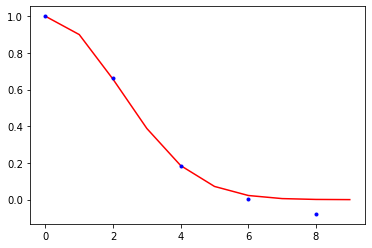

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 482
Number of inner iterations in outer iteration number 2: 213
Number of inner iterations in outer iteration number 3: 29
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [144.79018266 143.94990505 143.96910512 143.96612442 143.96491704]
Observation contribution to cost function [132.31244658 131.67249469 131.61945173 131.62098882 131.62235474]
Model contribution to cost function  [112.84853593 111.89014566 111.92141965 111.92287534 111.9227204 ]
The values of the cost function total [389.95116517 387.5125454  387.5099765  387.50998858 387.50999218]
RMS between background/truth and analysis/truth [0.52650664 0.37120474]
New estimate for variance coming from assimilation window 13: 0.054867264410222064
New estimate for correlation length coming from assimilation window 13: 2.3022940884047784


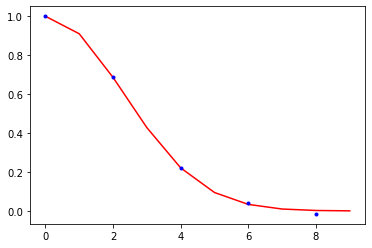

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 490
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [155.96297839 155.95199115 155.97637237 155.97349367 155.97207591]
Observation contribution to cost function [132.97123873 133.61925362 133.56421739 133.56492622 133.56960267]
Model contribution to cost function  [122.351091   120.13032877 120.16086632 120.16304237 120.15979811]
The values of the cost function total [411.28530813 409.70157354 409.70145608 409.70146227 409.70147669]
RMS between background/truth and analysis/truth [0.58286795 0.38622985]
New estimate for variance coming from assimilation window 14: 0.0723129278128929
New estimate for correlation length coming from assimilation window 14: 4.31453295223549


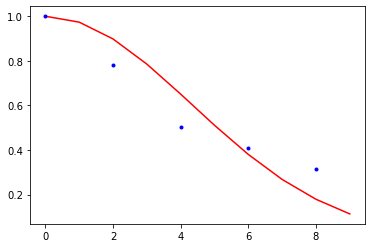

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 510
Number of inner iterations in outer iteration number 2: 231
Number of inner iterations in outer iteration number 3: 30
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [171.55286605 171.49548119 171.51578752 171.51422778 171.51366173]
Observation contribution to cost function [153.57763964 153.78990972 153.72994061 153.72949785 153.7313544 ]
Model contribution to cost function  [128.42961897 127.51109344 127.54999843 127.55201098 127.5507181 ]
The values of the cost function total [453.56012465 452.79648436 452.79572656 452.79573661 452.79573422]
RMS between background/truth and analysis/truth [0.61121249 0.4202005 ]
New estimate for variance coming from assimilation window 15: 0.07332586559922649
New estimate for correlation length coming from assimilation window 15: 3.3090206320234907


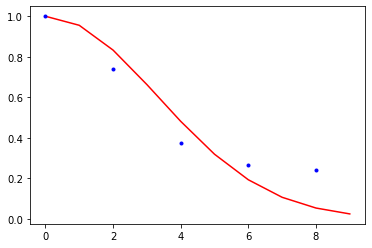

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 540
Number of inner iterations in outer iteration number 2: 247
Number of inner iterations in outer iteration number 3: 31
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [175.39725164 175.82613145 175.86654439 175.8656614  175.8641111 ]
Observation contribution to cost function [166.72488079 167.01787976 166.92550483 166.92644422 166.92933602]
Model contribution to cost function  [135.12227236 129.95494    130.00643106 130.00633452 130.00501603]
The values of the cost function total [477.24440479 472.79895121 472.79848028 472.79844015 472.79846315]
RMS between background/truth and analysis/truth [0.67146945 0.45725545]
New estimate for variance coming from assimilation window 16: 0.07033029244416462
New estimate for correlation length coming from assimilation window 16: 2.908134106228247


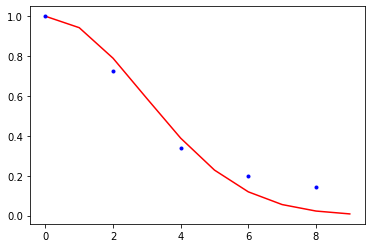

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 530
Number of inner iterations in outer iteration number 2: 249
Number of inner iterations in outer iteration number 3: 47
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [210.12969123 208.64028    208.67002766 208.67186016 208.67194797]
Observation contribution to cost function [182.96785511 180.35536936 180.26277572 180.26151573 180.25989944]
Model contribution to cost function  [141.19384766 140.09775995 140.16322608 140.16258631 140.16412785]
The values of the cost function total [534.291394   529.09340932 529.09602946 529.0959622  529.09597526]
RMS between background/truth and analysis/truth [0.68401999 0.5022361 ]
New estimate for variance coming from assimilation window 17: 0.06509432717404241
New estimate for correlation length coming from assimilation window 17: 2.224835136253989


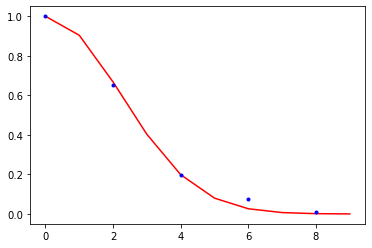

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 540
Number of inner iterations in outer iteration number 2: 241
Number of inner iterations in outer iteration number 3: 64
Number of inner iterations in outer iteration number 4: 8
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [267.46677829 266.48427908 266.5509877  266.55570259 266.55577392]
Observation contribution to cost function [223.65186487 221.76161906 221.63857276 221.63187069 221.63094853]
Model contribution to cost function  [159.97202863 156.67214773 156.74188598 156.74384201 156.74471457]
The values of the cost function total [651.0906718  644.91804586 644.93144644 644.93141529 644.93143701]
RMS between background/truth and analysis/truth [0.74887469 0.55513024]
New estimate for variance coming from assimilation window 18: 0.07701032366895967
New estimate for correlation length coming from assimilation window 18: 2.778519514217116


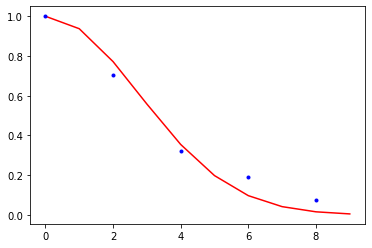

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 548
Number of inner iterations in outer iteration number 2: 299
Number of inner iterations in outer iteration number 3: 67
Number of inner iterations in outer iteration number 4: 12
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [379.71054052 378.43388704 378.6443445  378.63559909 378.63660164]
Observation contribution to cost function [323.10909274 322.61254335 322.3311945  322.33042557 322.32796194]
Model contribution to cost function  [190.29868218 186.91947449 187.00089182 187.0105906  187.0120808 ]
The values of the cost function total [893.11831544 887.96590487 887.97643082 887.97661526 887.97664438]
RMS between background/truth and analysis/truth [0.81175148 0.60055133]
New estimate for variance coming from assimilation window 19: 0.09033145684099167
New estimate for correlation length coming from assimilation window 19: 2.2246223575759925


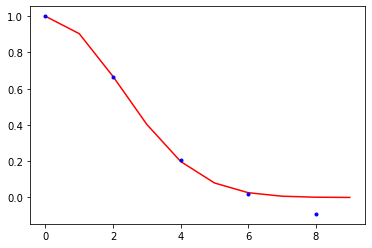

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 29
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [54.89307225 54.81460104 54.81548418 54.81720385 54.81577921]
Observation contribution to cost function [135.93617707 135.98529019 135.98913368 135.97529477 135.97926804]
Model contribution to cost function  [294.21669481 293.88264996 293.87806805 293.89018586 293.88762829]
The values of the cost function total [485.04594414 484.68254119 484.68268591 484.68268449 484.68267554]
RMS between background/truth and analysis/truth [0.3572681  0.22949378]
New estimate for variance coming from assimilation window 0: 0.04180251766810873
New estimate for correlation length coming from assimilation window 0: 2.393196156975306


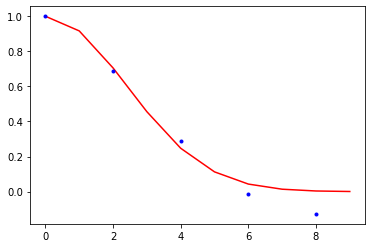

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 295
Number of inner iterations in outer iteration number 2: 111
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [18.31906336 18.30749946 18.30844883 18.30824577 18.30818976]
Observation contribution to cost function [41.9255445  41.72931304 41.72588797 41.7237598  41.72659253]
Model contribution to cost function  [99.03454179 98.99706519 98.99956567 99.00190495 98.99912188]
The values of the cost function total [159.27914964 159.03387769 159.03390246 159.03391052 159.03390417]
RMS between background/truth and analysis/truth [0.41580307 0.23998382]
New estimate for variance coming from assimilation window 1: 0.05970347322938897
New estimate for correlation length coming from assimilation window 1: 3.726339416166433


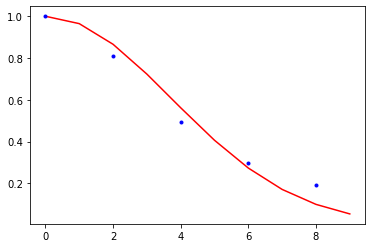

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 505
Number of inner iterations in outer iteration number 2: 207
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.45109314 28.53763242 28.53920353 28.53920982 28.53928695]
Observation contribution to cost function [80.61430217 80.46815978 80.46399186 80.46387467 80.46298911]
Model contribution to cost function  [72.67886477 72.27296567 72.27540847 72.275519   72.27633147]
The values of the cost function total [181.74426008 181.27875787 181.27860386 181.27860348 181.27860753]
RMS between background/truth and analysis/truth [0.37398026 0.20631992]
New estimate for variance coming from assimilation window 2: 0.04685523884111535
New estimate for correlation length coming from assimilation window 2: 3.1620655870986156


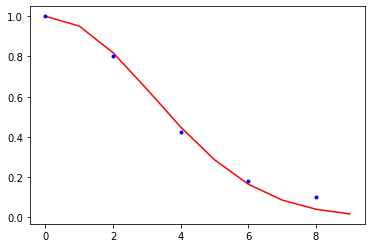

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 488
Number of inner iterations in outer iteration number 2: 198
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.76254248 28.82666118 28.82743021 28.82726146 28.82722138]
Observation contribution to cost function [58.12813197 58.13069354 58.12569984 58.12610499 58.12629141]
Model contribution to cost function  [68.5554462  67.943775   67.94799959 67.94775826 67.94760995]
The values of the cost function total [155.44612066 154.90112972 154.90112963 154.90112471 154.90112274]
RMS between background/truth and analysis/truth [0.36976377 0.19474991]
New estimate for variance coming from assimilation window 3: 0.04547550298037481
New estimate for correlation length coming from assimilation window 3: 2.7466928128827637


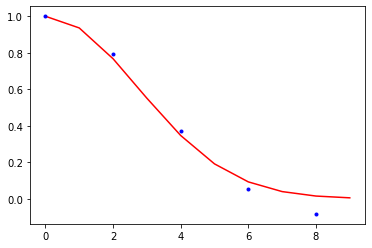

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 193
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.04724902 28.04850852 28.04952696 28.04943046 28.0494405 ]
Observation contribution to cost function [75.82328752 75.88930282 75.88518059 75.88558315 75.88576447]
Model contribution to cost function  [71.13944079 70.46247182 70.46560249 70.4652925  70.46510514]
The values of the cost function total [175.00997733 174.40028316 174.40031004 174.40030611 174.4003101 ]
RMS between background/truth and analysis/truth [0.34394743 0.19562289]
New estimate for variance coming from assimilation window 4: 0.03989650791083342
New estimate for correlation length coming from assimilation window 4: 2.5544141168526333


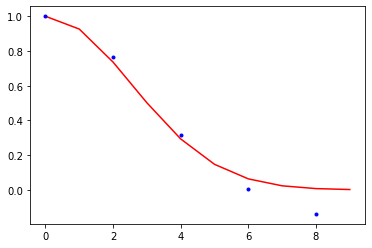

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 445
Number of inner iterations in outer iteration number 2: 193
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [39.1356212  38.95987305 38.96209054 38.96157608 38.96129849]
Observation contribution to cost function [78.82301162 78.50273336 78.49485453 78.49517526 78.49342707]
Model contribution to cost function  [83.74021398 84.23121822 84.23675718 84.23695223 84.23899008]
The values of the cost function total [201.69884679 201.69382463 201.69370225 201.69370357 201.69371564]
RMS between background/truth and analysis/truth [0.38121821 0.19747053]
New estimate for variance coming from assimilation window 5: 0.04600099002715051
New estimate for correlation length coming from assimilation window 5: 2.463016106233027


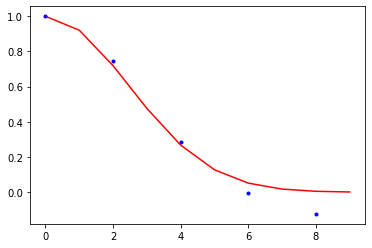

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 425
Number of inner iterations in outer iteration number 2: 157
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [39.61902293 39.54259567 39.54524176 39.54478883 39.54451672]
Observation contribution to cost function [72.55073111 72.62271306 72.61345661 72.61419743 72.61451082]
Model contribution to cost function  [84.38228205 83.19656033 83.20304656 83.20275637 83.20272299]
The values of the cost function total [196.55203608 195.36186906 195.36174493 195.36174264 195.36175052]
RMS between background/truth and analysis/truth [0.38407545 0.22639878]
New estimate for variance coming from assimilation window 6: 0.049367250886544284
New estimate for correlation length coming from assimilation window 6: 2.801979443546049


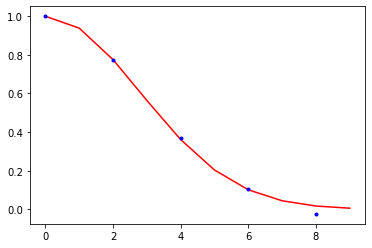

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 430
Number of inner iterations in outer iteration number 2: 217
Number of inner iterations in outer iteration number 3: 18
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [54.12825584 53.41327562 53.4129878  53.41275965 53.41235994]
Observation contribution to cost function [81.42275132 80.47197301 80.44966567 80.44814443 80.45022581]
Model contribution to cost function  [91.79153601 91.55960855 91.58137132 91.58312201 91.58144067]
The values of the cost function total [227.34254317 225.44485719 225.4440248  225.44402609 225.44402642]
RMS between background/truth and analysis/truth [0.3996954  0.24001983]
New estimate for variance coming from assimilation window 7: 0.05054165230994695
New estimate for correlation length coming from assimilation window 7: 2.4832433215515723


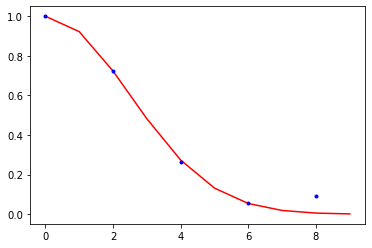

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 429
Number of inner iterations in outer iteration number 2: 181
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [69.42881804 69.04214562 69.05171633 69.05075181 69.05039394]
Observation contribution to cost function [85.1326107  83.97130158 83.94580914 83.9465878  83.94787786]
Model contribution to cost function  [82.61244764 83.89614578 83.91173466 83.9119331  83.91101215]
The values of the cost function total [237.17387638 236.90959298 236.90926012 236.90927272 236.90928395]
RMS between background/truth and analysis/truth [0.40280956 0.26381095]
New estimate for variance coming from assimilation window 8: 0.048176871671243106
New estimate for correlation length coming from assimilation window 8: 2.7799893229996337


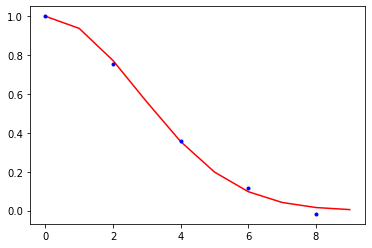

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 427
Number of inner iterations in outer iteration number 2: 161
Number of inner iterations in outer iteration number 3: 14
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [56.45283473 56.57395944 56.58045205 56.57967573 56.57951476]
Observation contribution to cost function [80.58984299 80.92073764 80.9108722  80.91412749 80.91215743]
Model contribution to cost function  [87.04508684 86.86240559 86.86573513 86.86326292 86.86538376]
The values of the cost function total [224.08776456 224.35710268 224.35705937 224.35706614 224.35705594]
RMS between background/truth and analysis/truth [0.45135841 0.2734395 ]
New estimate for variance coming from assimilation window 9: 0.0519429253419665
New estimate for correlation length coming from assimilation window 9: 2.8495691090710302


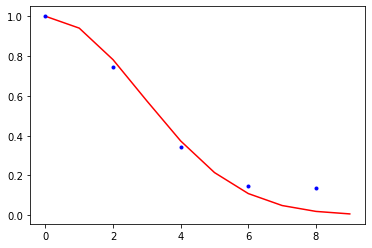

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 442
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.64541694 63.64200062 63.6501204  63.64948009 63.64892338]
Observation contribution to cost function [86.85629771 86.58454273 86.57178398 86.57304306 86.57410517]
Model contribution to cost function  [84.69618631 85.24435929 85.24891112 85.24829116 85.24778558]
The values of the cost function total [235.19790096 235.47090264 235.4708155  235.47081431 235.47081414]
RMS between background/truth and analysis/truth [0.44169473 0.28333386]
New estimate for variance coming from assimilation window 10: 0.050382784797667814
New estimate for correlation length coming from assimilation window 10: 3.483338029007644


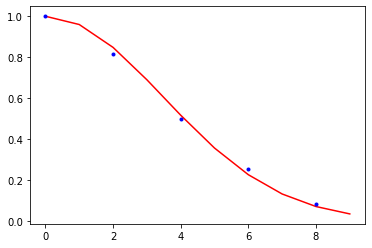

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.32104405 65.20854118 65.21417714 65.21350545 65.21296879]
Observation contribution to cost function [92.85761825 92.42260163 92.41230097 92.41338573 92.41426641]
Model contribution to cost function  [91.17440491 91.26771198 91.27230081 91.27189436 91.27156019]
The values of the cost function total [249.35306722 248.89885479 248.89877892 248.89878554 248.89879539]
RMS between background/truth and analysis/truth [0.47394195 0.30040001]
New estimate for variance coming from assimilation window 11: 0.04950958038930157
New estimate for correlation length coming from assimilation window 11: 3.256365388828598


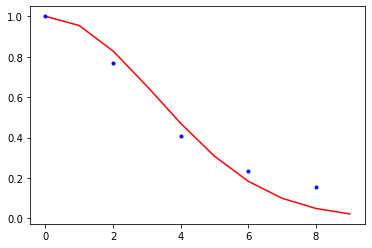

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 449
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 16
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [70.82936638 71.02780468 71.03767927 71.03665693 71.03631529]
Observation contribution to cost function [88.95857295 89.04471388 89.02617893 89.02733366 89.02781589]
Model contribution to cost function  [76.04480572 76.01749824 76.02590763 76.0257901  76.02564672]
The values of the cost function total [235.83274505 236.0900168  236.08976583 236.08978068 236.0897779 ]
RMS between background/truth and analysis/truth [0.5012437 0.3159062]
New estimate for variance coming from assimilation window 12: 0.05317440272089698
New estimate for correlation length coming from assimilation window 12: 3.062973264589838


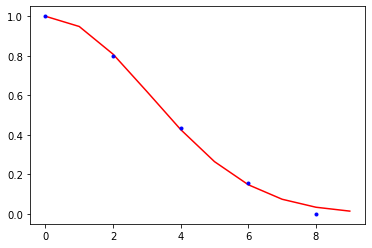

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 472
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [101.14190107 100.91488005 100.93815483 100.93630967 100.93517266]
Observation contribution to cost function [115.80868441 114.97634911 114.94252437 114.94225212 114.9458456 ]
Model contribution to cost function  [77.77716432 77.99148825 78.00081234 78.00294471 78.00050341]
The values of the cost function total [294.7277498  293.88271741 293.88149154 293.8815065  293.88152167]
RMS between background/truth and analysis/truth [0.49871735 0.33967731]
New estimate for variance coming from assimilation window 13: 0.04425019613465077
New estimate for correlation length coming from assimilation window 13: 2.9063437082844823


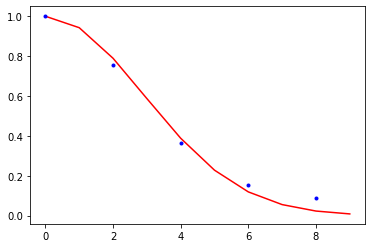

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 458
Number of inner iterations in outer iteration number 2: 207
Number of inner iterations in outer iteration number 3: 33
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [164.50904952 163.9869157  164.02647248 164.02408051 164.02253673]
Observation contribution to cost function [135.36443822 133.26439369 133.19630606 133.19531713 133.1968196 ]
Model contribution to cost function  [100.39732104 100.61974986 100.64165488 100.64499779 100.64504038]
The values of the cost function total [400.27080879 397.87105926 397.86443342 397.86439543 397.86439671]
RMS between background/truth and analysis/truth [0.53969169 0.36785956]
New estimate for variance coming from assimilation window 14: 0.05913024923120897
New estimate for correlation length coming from assimilation window 14: 3.9310016504665994


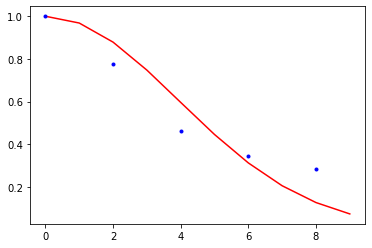

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 414
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [206.80010425 206.40354832 206.45520434 206.44744405 206.44645914]
Observation contribution to cost function [171.9189537  169.6275279  169.55649806 169.56505522 169.56614072]
Model contribution to cost function  [95.93401765 96.66004414 96.67501375 96.67435875 96.67426584]
The values of the cost function total [474.65307559 472.69112037 472.68671615 472.68685802 472.6868657 ]
RMS between background/truth and analysis/truth [0.52667633 0.4018746 ]
New estimate for variance coming from assimilation window 15: 0.038528772779071796
New estimate for correlation length coming from assimilation window 15: 2.2462223265910515


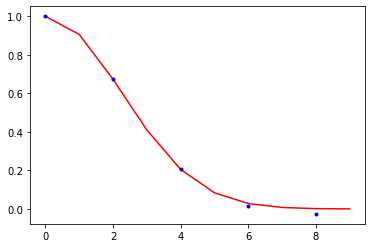

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 448
Number of inner iterations in outer iteration number 2: 219
Number of inner iterations in outer iteration number 3: 25
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [209.40663647 209.03013871 209.06051486 209.05800916 209.05720591]
Observation contribution to cost function [183.49993931 181.91719978 181.87594276 181.87749366 181.87954819]
Model contribution to cost function  [145.12696727 146.40773721 146.4190127  146.42001301 146.41877756]
The values of the cost function total [538.03354305 537.3550757  537.35547032 537.35551583 537.35553166]
RMS between background/truth and analysis/truth [0.60520707 0.45071328]
New estimate for variance coming from assimilation window 16: 0.06463655235359853
New estimate for correlation length coming from assimilation window 16: 2.231225377277861


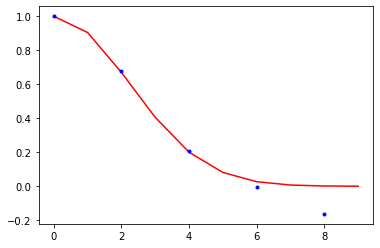

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 476
Number of inner iterations in outer iteration number 2: 233
Number of inner iterations in outer iteration number 3: 49
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [220.79937581 222.5238649  222.52201201 222.51684825 222.51901498]
Observation contribution to cost function [211.60463363 211.2422972  211.17029515 211.18791344 211.18182644]
Model contribution to cost function  [171.27079744 171.72114119 171.79394775 171.78167934 171.78556369]
The values of the cost function total [603.67480688 605.4873033  605.48625491 605.48644103 605.48640511]
RMS between background/truth and analysis/truth [0.69651603 0.4890356 ]
New estimate for variance coming from assimilation window 17: 0.08086649777992144
New estimate for correlation length coming from assimilation window 17: 2.494149217555762


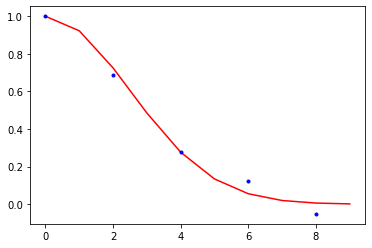

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 265
Number of inner iterations in outer iteration number 3: 60
Number of inner iterations in outer iteration number 4: 18
Number of inner iterations in outer iteration number 5: 5

Background contribution to cost function [375.37361908 377.1777448  377.30711225 377.31376604 377.33358611]
Observation contribution to cost function [307.88168218 302.15898618 301.8637046  301.8745917  301.84439854]
Model contribution to cost function  [228.43347361 227.5298005  227.70810583 227.6914432  227.70164447]
The values of the cost function total [911.68877487 906.86653148 906.87892267 906.87980094 906.87962912]
RMS between background/truth and analysis/truth [0.73008586 0.52745721]
New estimate for variance coming from assimilation window 18: 0.08107870130709019
New estimate for correlation length coming from assimilation window 18: 2.4306136679862966


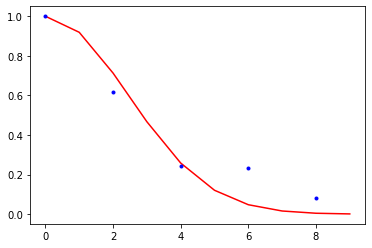

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 444
Number of inner iterations in outer iteration number 2: 297
Number of inner iterations in outer iteration number 3: 114
Number of inner iterations in outer iteration number 4: 53
Number of inner iterations in outer iteration number 5: 15

Background contribution to cost function [595.56633269 599.0601016  599.21211435 599.39707663 599.44186256]
Observation contribution to cost function [478.97084159 465.94341984 465.08424095 464.95236443 464.89626425]
Model contribution to cost function  [355.68569373 341.0191033  341.79401518 341.74316291 341.7535308 ]
The values of the cost function total [1430.22286801 1406.02262474 1406.09037048 1406.09260397 1406.09165761]
RMS between background/truth and analysis/truth [0.76996875 0.60491412]
New estimate for variance coming from assimilation window 19: 0.11691771327681777
New estimate for correlation length coming from assimilation window 19: 1.9149861147399982


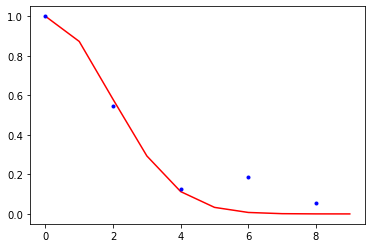

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [44.16326119 44.16981994 44.17085394 44.1723026  44.17134266]
Observation contribution to cost function [154.95754741 154.88364574 154.8829449  154.8753654  154.87831409]
Model contribution to cost function  [230.62139891 230.6549528  230.65459856 230.66072759 230.65873395]
The values of the cost function total [429.74220752 429.70841848 429.7083974  429.70839559 429.70839069]
RMS between background/truth and analysis/truth [0.30927842 0.21259762]
New estimate for variance coming from assimilation window 0: 0.0309414230698436
New estimate for correlation length coming from assimilation window 0: 2.1790707604817308


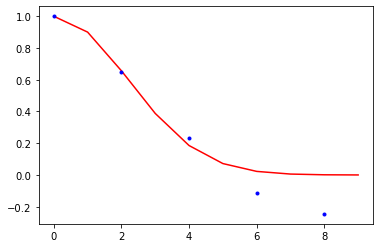

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 207
Number of inner iterations in outer iteration number 2: 73
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [21.00072386 21.0326262  21.03365569 21.03353322 21.03372547]
Observation contribution to cost function [59.58184863 59.76668816 59.76160491 59.76191588 59.75909429]
Model contribution to cost function  [111.23021629 110.10980689 110.113791   110.11359834 110.11623725]
The values of the cost function total [191.81278878 190.90912125 190.9090516  190.90904744 190.909057  ]
RMS between background/truth and analysis/truth [0.38859858 0.22034557]
New estimate for variance coming from assimilation window 1: 0.04553810721098725
New estimate for correlation length coming from assimilation window 1: 3.4724255972062417


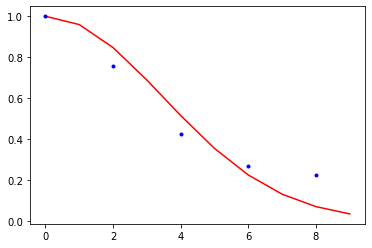

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 341
Number of inner iterations in outer iteration number 2: 133
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [28.32631129 28.29905136 28.30023703 28.2999925  28.29982143]
Observation contribution to cost function [59.51169941 59.2690907  59.266237   59.26682149 59.26719138]
Model contribution to cost function  [89.90496199 90.25035661 90.25201459 90.25166883 90.25146662]
The values of the cost function total [177.74297269 177.81849867 177.81848862 177.81848281 177.81847944]
RMS between background/truth and analysis/truth [0.39497171 0.20277242]
New estimate for variance coming from assimilation window 2: 0.04957729263373216
New estimate for correlation length coming from assimilation window 2: 2.6547444096723014


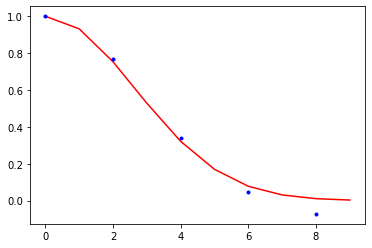

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 365
Number of inner iterations in outer iteration number 2: 135
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.64258061 24.67582145 24.67611243 24.67603127 24.67604462]
Observation contribution to cost function [52.8263311  52.62739337 52.62545952 52.62616457 52.62349712]
Model contribution to cost function  [83.81295683 84.19717385 84.19880506 84.19817519 84.20084098]
The values of the cost function total [161.28186853 161.50038867 161.50037701 161.50037102 161.50038272]
RMS between background/truth and analysis/truth [0.37100815 0.18020766]
New estimate for variance coming from assimilation window 3: 0.04982407615042626
New estimate for correlation length coming from assimilation window 3: 3.4379197506908152


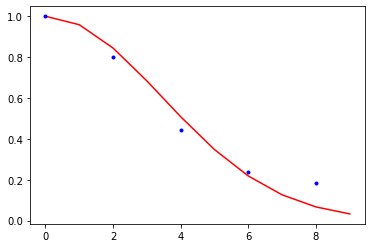

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 405
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.41920288 27.39766517 27.39835869 27.3981273  27.39795157]
Observation contribution to cost function [52.45870174 52.46884052 52.46755465 52.46809052 52.46833446]
Model contribution to cost function  [85.82872286 85.12850275 85.1290965  85.12878578 85.12871475]
The values of the cost function total [165.70662748 164.99500844 164.99500984 164.9950036  164.99500078]
RMS between background/truth and analysis/truth [0.39865596 0.1898192 ]
New estimate for variance coming from assimilation window 4: 0.06029375579604891
New estimate for correlation length coming from assimilation window 4: 3.521465034767856


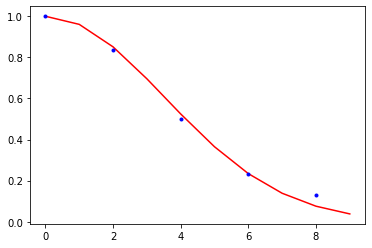

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 473
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [42.33964749 42.33407963 42.33541142 42.33512758 42.33487415]
Observation contribution to cost function [79.47071957 79.34759826 79.34174505 79.34244048 79.34303723]
Model contribution to cost function  [83.98458145 83.24548155 83.24997977 83.24957162 83.24923084]
The values of the cost function total [205.79494851 204.92715945 204.92713624 204.92713968 204.92714222]
RMS between background/truth and analysis/truth [0.37678732 0.19626246]
New estimate for variance coming from assimilation window 5: 0.050293914555453546
New estimate for correlation length coming from assimilation window 5: 2.945509286231696


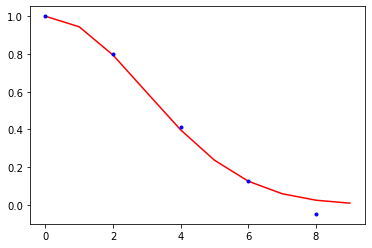

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [29.84796605 29.79689593 29.79946986 29.79916918 29.79888612]
Observation contribution to cost function [67.50127914 67.02246214 67.01680281 67.01742274 67.01804064]
Model contribution to cost function  [81.87484431 82.61243663 82.61546728 82.61514571 82.61481075]
The values of the cost function total [179.2240895  179.43179469 179.43173995 179.43173763 179.43173751]
RMS between background/truth and analysis/truth [0.4483562  0.20130406]
New estimate for variance coming from assimilation window 6: 0.06484085768209447
New estimate for correlation length coming from assimilation window 6: 3.2015792266584553


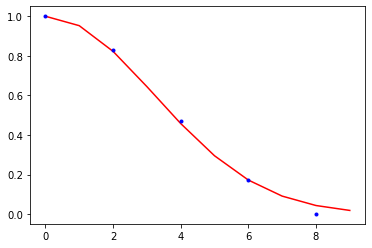

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 503
Number of inner iterations in outer iteration number 2: 209
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [43.1249844  43.46815713 43.46564528 43.46562993 43.46550816]
Observation contribution to cost function [64.94589117 64.75621871 64.75292646 64.75328781 64.75385175]
Model contribution to cost function  [70.90761617 70.49854106 70.50438539 70.50404077 70.50360344]
The values of the cost function total [178.97849174 178.7229169  178.72295713 178.72295851 178.72296335]
RMS between background/truth and analysis/truth [0.37561461 0.21045393]
New estimate for variance coming from assimilation window 7: 0.0455872134200927
New estimate for correlation length coming from assimilation window 7: 2.893428746293205


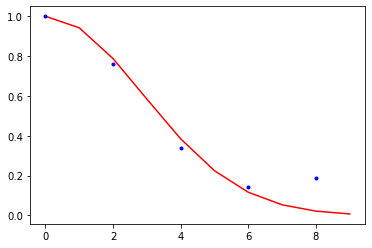

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 497
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [53.26787512 53.28658487 53.29348988 53.29324882 53.29288243]
Observation contribution to cost function [79.27066936 79.14374933 79.13430526 79.13193798 79.13507856]
Model contribution to cost function  [72.52363296 72.44584326 72.44825085 72.45087221 72.44809345]
The values of the cost function total [205.06217744 204.87617746 204.876046   204.87605901 204.87605444]
RMS between background/truth and analysis/truth [0.38852162 0.23939918]
New estimate for variance coming from assimilation window 8: 0.04691328735507966
New estimate for correlation length coming from assimilation window 8: 3.6531823194830126


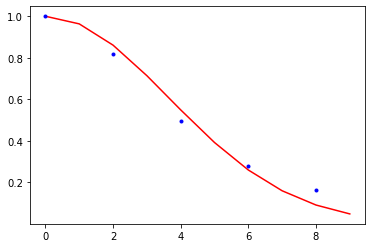

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 494
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.19681582 60.09065804 60.09860192 60.09860056 60.09812719]
Observation contribution to cost function [83.51961146 83.35684836 83.34421625 83.34251286 83.34338285]
Model contribution to cost function  [91.03015143 89.42963213 89.43427169 89.43597472 89.43558413]
The values of the cost function total [234.74657871 232.87713852 232.87708986 232.87708814 232.87709418]
RMS between background/truth and analysis/truth [0.41267172 0.23700515]
New estimate for variance coming from assimilation window 9: 0.04763880643064592
New estimate for correlation length coming from assimilation window 9: 2.366838161820082


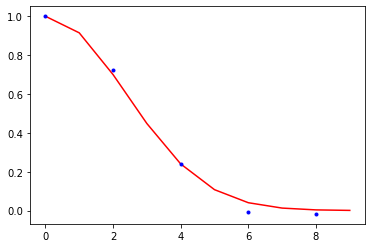

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 480
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 16
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.21881694 64.48921497 64.49422529 64.49401974 64.49348091]
Observation contribution to cost function [85.9548358  85.76459488 85.75005785 85.7506246  85.75142136]
Model contribution to cost function  [89.1147166  86.88965313 86.89907477 86.89871372 86.89845919]
The values of the cost function total [239.28836934 237.14346299 237.14335791 237.14335805 237.14336147]
RMS between background/truth and analysis/truth [0.42229384 0.24621867]
New estimate for variance coming from assimilation window 10: 0.05066695163965301
New estimate for correlation length coming from assimilation window 10: 2.5682941229158414


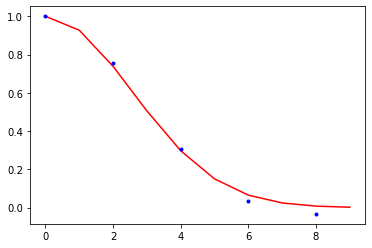

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 472
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [62.91482817 63.21365979 63.21537516 63.21550148 63.21524301]
Observation contribution to cost function [73.4056242  73.66578212 73.66007309 73.65887284 73.6610492 ]
Model contribution to cost function  [78.59181742 77.22635573 77.23034662 77.23140982 77.22949063]
The values of the cost function total [214.91226979 214.10579764 214.10579486 214.10578414 214.10578284]
RMS between background/truth and analysis/truth [0.42645759 0.25509671]
New estimate for variance coming from assimilation window 11: 0.04523659614161103
New estimate for correlation length coming from assimilation window 11: 2.8814551606152614


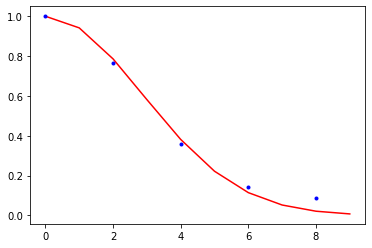

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 477
Number of inner iterations in outer iteration number 2: 191
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.10014605 64.04094199 64.04571036 64.0451381  64.0444381 ]
Observation contribution to cost function [79.41859216 79.14923377 79.13982724 79.14055425 79.14158702]
Model contribution to cost function  [80.398355   80.73289769 80.73737138 80.73721477 80.73687999]
The values of the cost function total [223.91709321 223.92307345 223.92290898 223.92290713 223.92290511]
RMS between background/truth and analysis/truth [0.42467028 0.26441522]
New estimate for variance coming from assimilation window 12: 0.05136097524588832
New estimate for correlation length coming from assimilation window 12: 2.983076597850961


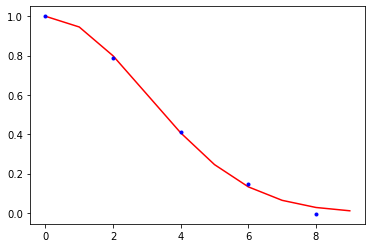

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 484
Number of inner iterations in outer iteration number 2: 177
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [66.87865459 66.99097792 66.99991638 66.99909316 66.99852729]
Observation contribution to cost function [89.50833107 89.48610545 89.46801304 89.468985   89.47011055]
Model contribution to cost function  [79.68034328 80.08388841 80.09294105 80.09279559 80.09223512]
The values of the cost function total [236.06732894 236.56097177 236.56087046 236.56087375 236.56087296]
RMS between background/truth and analysis/truth [0.42168178 0.26800446]
New estimate for variance coming from assimilation window 13: 0.04183906405212458
New estimate for correlation length coming from assimilation window 13: 3.5367437014249856


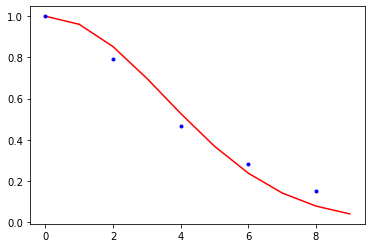

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 502
Number of inner iterations in outer iteration number 2: 225
Number of inner iterations in outer iteration number 3: 23
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [76.53945864 76.71981864 76.72545818 76.7241375  76.72384388]
Observation contribution to cost function [98.32990351 98.45452314 98.43667013 98.43848758 98.4391371 ]
Model contribution to cost function  [93.12413655 93.41907102 93.43162471 93.43114282 93.43078986]
The values of the cost function total [267.9934987  268.59341279 268.59375302 268.59376791 268.59377084]
RMS between background/truth and analysis/truth [0.45891466 0.29201484]
New estimate for variance coming from assimilation window 14: 0.048838109599353696
New estimate for correlation length coming from assimilation window 14: 2.2975557723463593


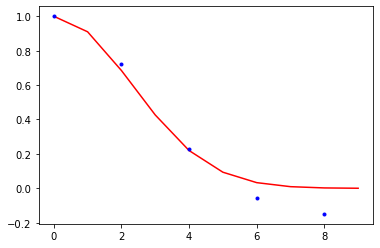

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 476
Number of inner iterations in outer iteration number 2: 223
Number of inner iterations in outer iteration number 3: 49
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [130.31455309 131.84067015 131.79603934 131.79167785 131.79364104]
Observation contribution to cost function [142.37480515 141.26417157 141.25082624 141.26511136 141.2603087 ]
Model contribution to cost function  [131.62527547 132.09580873 132.15340726 132.14387052 132.14664744]
The values of the cost function total [404.31463372 405.20065045 405.20027284 405.20065973 405.20059718]
RMS between background/truth and analysis/truth [0.48980985 0.29439559]
New estimate for variance coming from assimilation window 15: 0.055797185911814484
New estimate for correlation length coming from assimilation window 15: 2.034070238212928


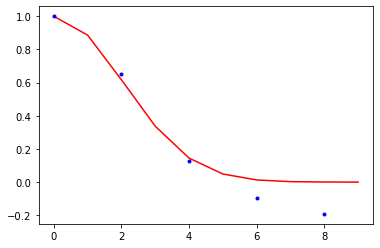

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 442
Number of inner iterations in outer iteration number 2: 211
Number of inner iterations in outer iteration number 3: 47
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [174.36940533 175.95700512 175.91538677 175.90844979 175.91090142]
Observation contribution to cost function [163.18107869 162.13971781 162.13189712 162.14419165 162.14013491]
Model contribution to cost function  [116.035051   115.63216871 115.68458646 115.67957168 115.68111516]
The values of the cost function total [453.58553503 453.72889164 453.73187034 453.73221311 453.7321515 ]
RMS between background/truth and analysis/truth [0.47814752 0.31238296]
New estimate for variance coming from assimilation window 16: 0.046157466116127005
New estimate for correlation length coming from assimilation window 16: 2.176879999914837


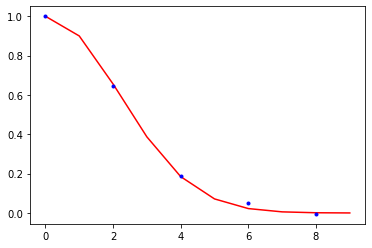

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 424
Number of inner iterations in outer iteration number 2: 207
Number of inner iterations in outer iteration number 3: 42
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [252.07771419 253.20125662 253.25670612 253.24613017 253.24933584]
Observation contribution to cost function [197.21916759 195.25912823 195.15519136 195.16351051 195.16054395]
Model contribution to cost function  [118.60043726 116.83403166 116.88338964 116.88598076 116.88569354]
The values of the cost function total [567.89731904 565.2944165  565.29528712 565.29562144 565.29557334]
RMS between background/truth and analysis/truth [0.47524218 0.31147151]
New estimate for variance coming from assimilation window 17: 0.04960955968981276
New estimate for correlation length coming from assimilation window 17: 2.228914583115601


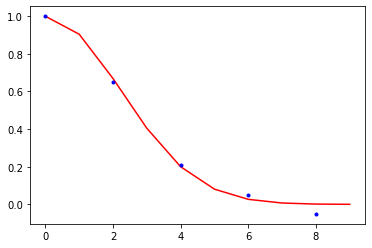

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 418
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 31
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [169.67028811 170.5751836  170.59866266 170.59063834 170.59088796]
Observation contribution to cost function [131.36798975 131.24924941 131.18523039 131.19549433 131.19590636]
Model contribution to cost function  [113.23127247 113.1858235  113.22756676 113.22547559 113.22480663]
The values of the cost function total [414.26955033 415.01025651 415.01145981 415.01160827 415.01160095]
RMS between background/truth and analysis/truth [0.48092771 0.32656541]
New estimate for variance coming from assimilation window 18: 0.0502524539403298
New estimate for correlation length coming from assimilation window 18: 2.576538099503718


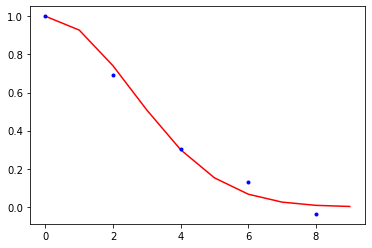

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 462
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 33
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [166.64574036 167.74694969 167.76546545 167.76139715 167.76067764]
Observation contribution to cost function [148.55565847 151.08587302 151.02497974 151.03197788 151.03413936]
Model contribution to cost function  [114.67067434 112.14430485 112.18690675 112.18399721 112.18256102]
The values of the cost function total [429.87207317 430.97712756 430.97735194 430.97737224 430.97737802]
RMS between background/truth and analysis/truth [0.50798508 0.35129389]
New estimate for variance coming from assimilation window 19: 0.055726337439690056
New estimate for correlation length coming from assimilation window 19: 2.8929283952268587


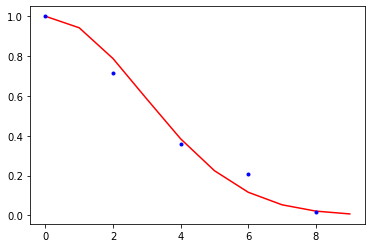

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 29
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [57.21382163 57.17783833 57.17950847 57.18045981 57.17913893]
Observation contribution to cost function [120.96259083 120.9525668  120.95565583 120.94482591 120.95048329]
Model contribution to cost function  [224.32398563 224.14224049 224.13756072 224.14743816 224.14309431]
The values of the cost function total [402.50039808 402.27264561 402.27272501 402.27272389 402.27271652]
RMS between background/truth and analysis/truth [0.29909906 0.20157795]
New estimate for variance coming from assimilation window 0: 0.03212720008548857
New estimate for correlation length coming from assimilation window 0: 2.045384901065307


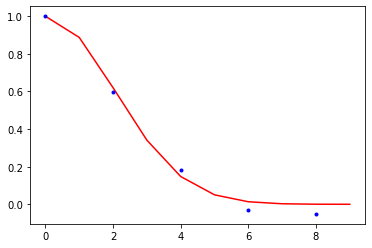

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 179
Number of inner iterations in outer iteration number 2: 67
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [17.83752936 17.85719017 17.85769005 17.85742924 17.85734093]
Observation contribution to cost function [46.86415348 46.89947137 46.89530851 46.89582062 46.89528076]
Model contribution to cost function  [119.48361473 119.12824001 119.1318922  119.13163321 119.13227332]
The values of the cost function total [184.18529757 183.88490155 183.88489076 183.88488306 183.88489501]
RMS between background/truth and analysis/truth [0.36339892 0.20328579]
New estimate for variance coming from assimilation window 1: 0.048298249351996066
New estimate for correlation length coming from assimilation window 1: 2.968026309495119


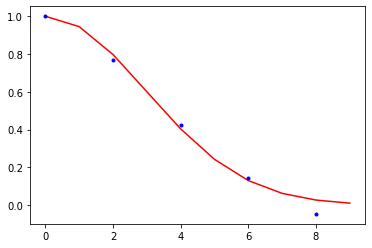

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 317
Number of inner iterations in outer iteration number 2: 129
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [32.34408628 32.41026689 32.41213766 32.41199756 32.41175987]
Observation contribution to cost function [63.61792655 63.9070707  63.90229335 63.89872811 63.90321366]
Model contribution to cost function  [93.49631366 92.41455003 92.41745441 92.42116092 92.41691064]
The values of the cost function total [189.45832649 188.73188761 188.73188542 188.73188659 188.73188417]
RMS between background/truth and analysis/truth [0.37347757 0.18179953]
New estimate for variance coming from assimilation window 2: 0.0474550376977739
New estimate for correlation length coming from assimilation window 2: 2.9968219305160804


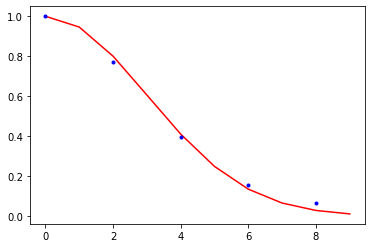

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 359
Number of inner iterations in outer iteration number 2: 133
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [26.11843002 26.14535894 26.14600609 26.14599327 26.14588322]
Observation contribution to cost function [54.15062093 54.15527853 54.15301309 54.15198336 54.15343548]
Model contribution to cost function  [82.6615443  82.0868034  82.08844999 82.08949117 82.08814678]
The values of the cost function total [162.93059524 162.38744088 162.38746917 162.38746779 162.38746548]
RMS between background/truth and analysis/truth [0.35687855 0.18103765]
New estimate for variance coming from assimilation window 3: 0.0474172042783769
New estimate for correlation length coming from assimilation window 3: 2.8058755071478383


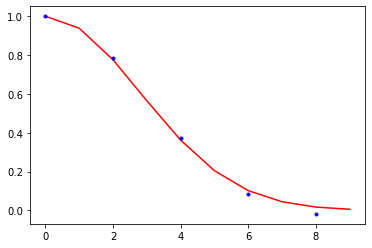

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 389
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [25.68855728 25.66914725 25.6701812  25.67006013 25.6699705 ]
Observation contribution to cost function [62.31197939 62.18210245 62.1809983  62.1813167  62.18150533]
Model contribution to cost function  [76.45007122 76.37864228 76.37870919 76.37851178 76.37841349]
The values of the cost function total [164.45060789 164.22989198 164.22988869 164.2298886  164.22988932]
RMS between background/truth and analysis/truth [0.31697792 0.18448427]
New estimate for variance coming from assimilation window 4: 0.04451661666402305
New estimate for correlation length coming from assimilation window 4: 2.8798946205242393


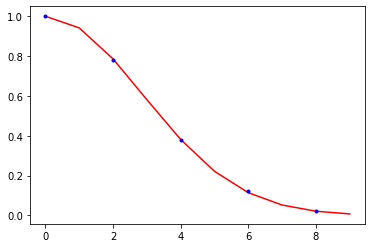

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 387
Number of inner iterations in outer iteration number 2: 135
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [22.12521149 22.16433777 22.16493761 22.16469577 22.16455149]
Observation contribution to cost function [60.78960666 60.83482543 60.83249799 60.83298822 60.83319671]
Model contribution to cost function  [71.8426284  71.69305012 71.69477264 71.69451748 71.69444865]
The values of the cost function total [154.75744655 154.69221333 154.69220824 154.69220147 154.69219685]
RMS between background/truth and analysis/truth [0.34273327 0.19886025]
New estimate for variance coming from assimilation window 5: 0.04436490853953327
New estimate for correlation length coming from assimilation window 5: 2.811042395398981


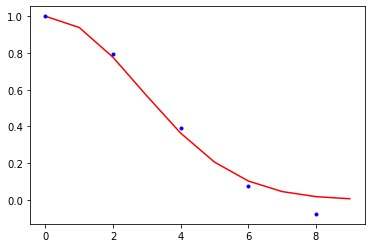

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 387
Number of inner iterations in outer iteration number 2: 163
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [25.58938036 25.54414985 25.54552957 25.5454231  25.54536209]
Observation contribution to cost function [60.97749907 60.46622537 60.4622079  60.45978994 60.46218257]
Model contribution to cost function  [85.48842176 85.26035938 85.26275672 85.26528724 85.26295094]
The values of the cost function total [172.05530118 171.27073461 171.27049419 171.27050027 171.2704956 ]
RMS between background/truth and analysis/truth [0.401019   0.21603573]
New estimate for variance coming from assimilation window 6: 0.054892843886091516
New estimate for correlation length coming from assimilation window 6: 2.9880796155176967


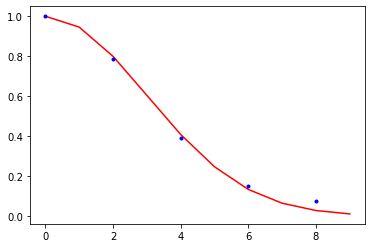

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 403
Number of inner iterations in outer iteration number 2: 155
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [32.38794082 32.30544434 32.30599457 32.30573759 32.30564521]
Observation contribution to cost function [67.68213431 67.78310942 67.780975   67.78126482 67.77846542]
Model contribution to cost function  [86.19247201 85.28348292 85.28506335 85.28502715 85.28792692]
The values of the cost function total [186.26254714 185.37203668 185.37203292 185.37202957 185.37203754]
RMS between background/truth and analysis/truth [0.43540998 0.22328766]
New estimate for variance coming from assimilation window 7: 0.06426780817892971
New estimate for correlation length coming from assimilation window 7: 2.8992200573773093


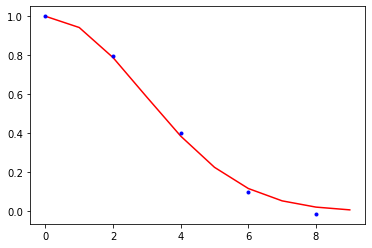

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 429
Number of inner iterations in outer iteration number 2: 175
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [41.88253624 41.60300249 41.60812532 41.60764767 41.60737521]
Observation contribution to cost function [65.03674364 64.89180142 64.88388612 64.88428335 64.88303807]
Model contribution to cost function  [84.04460797 83.85840865 83.861002   83.86108022 83.86260239]
The values of the cost function total [190.96388786 190.35321255 190.35301345 190.35301124 190.35301567]
RMS between background/truth and analysis/truth [0.37876296 0.23553376]
New estimate for variance coming from assimilation window 8: 0.04691903163351772
New estimate for correlation length coming from assimilation window 8: 2.48949260701276


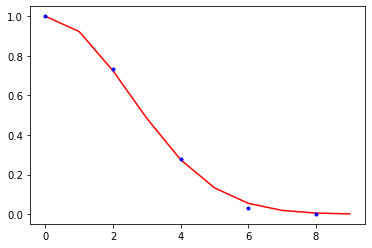

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 417
Number of inner iterations in outer iteration number 2: 217
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [50.5134082  49.80538944 49.80823287 49.80799179 49.80736711]
Observation contribution to cost function [71.21564679 70.28509168 70.26448967 70.2630921  70.26453427]
Model contribution to cost function  [89.15534026 88.1323753  88.14969968 88.15133718 88.15052687]
The values of the cost function total [210.88439525 208.22285642 208.22242222 208.22242106 208.22242826]
RMS between background/truth and analysis/truth [0.44301652 0.25556825]
New estimate for variance coming from assimilation window 9: 0.061615389523573094
New estimate for correlation length coming from assimilation window 9: 2.5786066942732697


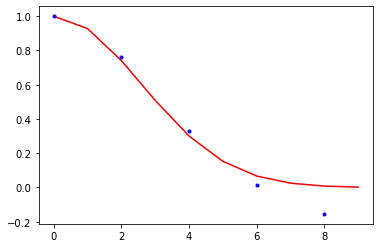

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 429
Number of inner iterations in outer iteration number 2: 225
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [61.21383203 60.81573192 60.82195568 60.82153217 60.82124433]
Observation contribution to cost function [71.34553313 70.02567665 70.00282237 70.00220213 70.00100261]
Model contribution to cost function  [83.97443807 83.86656189 83.88281242 83.88386716 83.88535796]
The values of the cost function total [216.53380323 214.70797046 214.70759047 214.70760145 214.7076049 ]
RMS between background/truth and analysis/truth [0.45612322 0.28820896]
New estimate for variance coming from assimilation window 10: 0.05189989396479625
New estimate for correlation length coming from assimilation window 10: 2.760231307697521


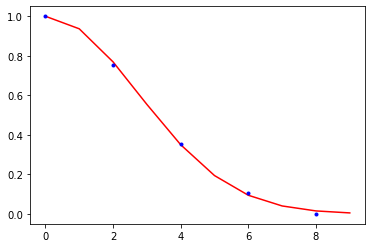

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 443
Number of inner iterations in outer iteration number 2: 159
Number of inner iterations in outer iteration number 3: 14
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [61.55403382 61.59227504 61.60417295 61.60335221 61.60297041]
Observation contribution to cost function [85.31133734 85.65872095 85.634447   85.63754826 85.63653178]
Model contribution to cost function  [91.924572   90.77171581 90.78409376 90.78181746 90.78320562]
The values of the cost function total [238.78994317 238.0227118  238.02271371 238.02271793 238.0227078 ]
RMS between background/truth and analysis/truth [0.49820618 0.30207125]
New estimate for variance coming from assimilation window 11: 0.0493044554453776
New estimate for correlation length coming from assimilation window 11: 3.2555351464847364


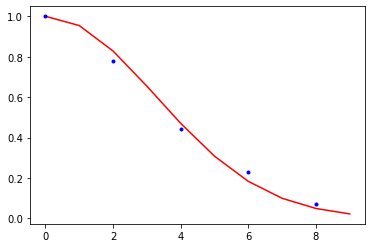

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 456
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [65.46308944 65.61731267 65.62341289 65.62237901 65.62191521]
Observation contribution to cost function [94.31654328 93.80821826 93.78727822 93.78900628 93.78883449]
Model contribution to cost function  [97.04294477 96.4204906  96.43551742 96.43482565 96.43547145]
The values of the cost function total [256.82257749 255.84602153 255.84620853 255.84621093 255.84622115]
RMS between background/truth and analysis/truth [0.47341271 0.32339112]
New estimate for variance coming from assimilation window 12: 0.048117814794116184
New estimate for correlation length coming from assimilation window 12: 2.3520293830580683


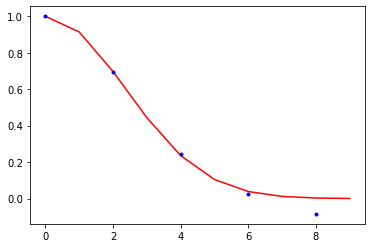

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 25
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [77.6144926  77.61475805 77.60636741 77.60560464 77.60550147]
Observation contribution to cost function [105.15252845 105.12569832 105.11565379 105.11773101 105.11743532]
Model contribution to cost function  [124.07446899 123.13387949 123.15176164 123.15045316 123.15084593]
The values of the cost function total [306.84149004 305.87433586 305.87378284 305.87378881 305.87378273]
RMS between background/truth and analysis/truth [0.57280594 0.3774414 ]
New estimate for variance coming from assimilation window 13: 0.07265516912465422
New estimate for correlation length coming from assimilation window 13: 2.853898144497669


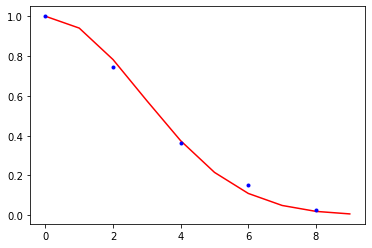

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 470
Number of inner iterations in outer iteration number 2: 219
Number of inner iterations in outer iteration number 3: 71
Number of inner iterations in outer iteration number 4: 9
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [129.53112301 131.73470899 131.63364069 131.63381479 131.63551201]
Observation contribution to cost function [152.5996538  153.95500224 153.97176999 153.98151889 153.97499836]
Model contribution to cost function  [175.6058447  171.61862537 171.70268833 171.6930331  171.69781121]
The values of the cost function total [457.73662151 457.30833661 457.30809901 457.30836678 457.30832158]
RMS between background/truth and analysis/truth [0.6031299  0.43152338]
New estimate for variance coming from assimilation window 14: 0.08027974794665788
New estimate for correlation length coming from assimilation window 14: 2.236163055511676


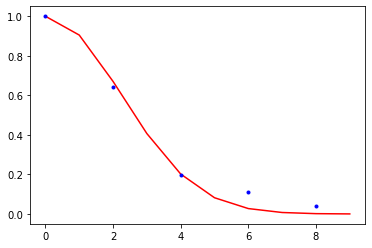

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 279
Number of inner iterations in outer iteration number 3: 170
Number of inner iterations in outer iteration number 4: 47
Number of inner iterations in outer iteration number 5: 9

Background contribution to cost function [273.12687845 285.25350499 284.31829277 284.4986306  284.49798552]
Observation contribution to cost function [258.41990076 264.0775102  264.39969951 264.3433619  264.31778561]
Model contribution to cost function  [258.41998525 249.32947828 249.93633414 249.8165667  249.84230463]
The values of the cost function total [789.96676446 798.66049347 798.65432642 798.6585592  798.65807576]
RMS between background/truth and analysis/truth [0.68136377 0.49340495]
New estimate for variance coming from assimilation window 15: 0.09787774981391913
New estimate for correlation length coming from assimilation window 15: 1.822478236685664


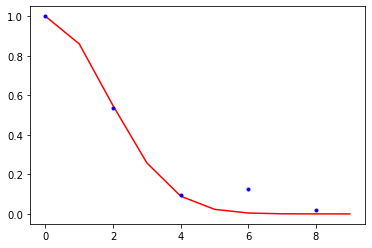

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 458
Number of inner iterations in outer iteration number 2: 303
Number of inner iterations in outer iteration number 3: 211
Number of inner iterations in outer iteration number 4: 111
Number of inner iterations in outer iteration number 5: 32

Background contribution to cost function [541.56390406 567.18773212 564.6659611  565.40521371 565.27992551]
Observation contribution to cost function [443.30009239 445.19970031 446.28609749 445.98086667 446.0345029 ]
Model contribution to cost function  [376.32698707 372.83064668 374.18399664 373.77206184 373.8407745 ]
The values of the cost function total [1361.19098351 1385.2180791  1385.13605523 1385.15814222 1385.15520291]
RMS between background/truth and analysis/truth [0.77981863 0.57207269]
New estimate for variance coming from assimilation window 16: 0.14155111300604767
New estimate for correlation length coming from assimilation window 16: 1.529999636044768


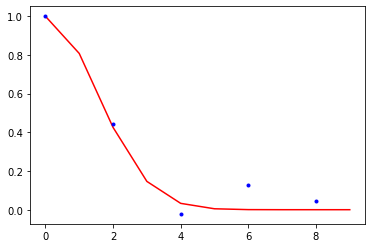

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 337
Number of inner iterations in outer iteration number 3: 247
Number of inner iterations in outer iteration number 4: 166
Number of inner iterations in outer iteration number 5: 93

Background contribution to cost function [1057.03316041 1081.30141556 1077.5024023  1079.48898017 1079.06518751]
Observation contribution to cost function [840.29229295 810.00053835 809.20164628 808.09606899 808.32494667]
Model contribution to cost function  [586.0580537  550.22115887 554.90464194 554.04396122 554.22105539]
The values of the cost function total [2483.38350705 2441.52311279 2441.60869053 2441.62901039 2441.61118958]
RMS between background/truth and analysis/truth [0.8832999  0.64635546]
New estimate for variance coming from assimilation window 17: 0.18663715944452375
New estimate for correlation length coming from assimilation window 17: 1.343588255198231


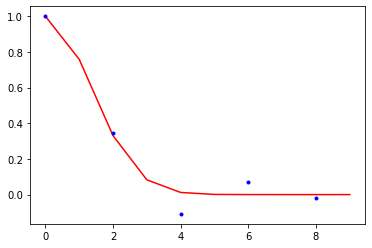

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 550
Number of inner iterations in outer iteration number 2: 417
Number of inner iterations in outer iteration number 3: 209
Number of inner iterations in outer iteration number 4: 122
Number of inner iterations in outer iteration number 5: 60

Background contribution to cost function [1451.31876757 1414.81103038 1411.78192499 1411.90856485 1411.8551472 ]
Observation contribution to cost function [1029.8934041   956.81109436  945.32306314  944.36426349  944.03171743]
Model contribution to cost function  [870.05748085 742.70626336 756.65194318 757.20695552 757.57397906]
The values of the cost function total [3351.26965252 3114.3283881  3113.7569313  3113.47978386 3113.46084369]
RMS between background/truth and analysis/truth [0.9120064  0.69031756]
New estimate for variance coming from assimilation window 18: 0.21201242644225005
New estimate for correlation length coming from assimilation window 18: 1.2054856293610343


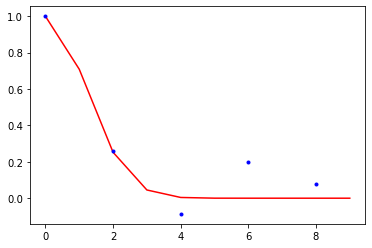

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 582
Number of inner iterations in outer iteration number 2: 471
Number of inner iterations in outer iteration number 3: 233
Number of inner iterations in outer iteration number 4: 100
Number of inner iterations in outer iteration number 5: 48

Background contribution to cost function [1273.41656566 1230.73689639 1229.38930057 1229.16235655 1229.15210901]
Observation contribution to cost function [757.06806869 703.58154305 695.94643558 695.7444152  695.56909154]
Model contribution to cost function  [921.73205465 706.83858188 716.43194514 716.79301745 716.98070846]
The values of the cost function total [2952.216689   2641.15702131 2641.76768128 2641.69978921 2641.70190901]
RMS between background/truth and analysis/truth [0.9652116  0.72087334]
New estimate for variance coming from assimilation window 19: 0.17468748549029356
New estimate for correlation length coming from assimilation window 19: 1.0068372223216508


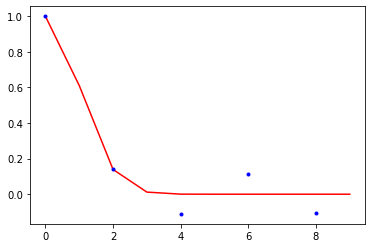

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 5
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [40.1486814  40.14485015 40.14235391 40.14528125 40.14350807]
Observation contribution to cost function [153.28395637 153.25320019 153.26015723 153.24759874 153.2516165 ]
Model contribution to cost function  [204.30090932 204.22019955 204.2157036  204.2253209  204.2230735 ]
The values of the cost function total [397.7335471  397.61824989 397.61821474 397.61820089 397.61819807]
RMS between background/truth and analysis/truth [0.2903268  0.20337834]
New estimate for variance coming from assimilation window 0: 0.026702472823091798
New estimate for correlation length coming from assimilation window 0: 2.4027733552348076


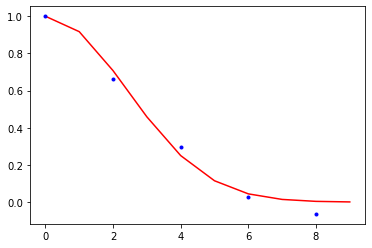

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 199
Number of inner iterations in outer iteration number 2: 85
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.40920736 24.44416071 24.44400792 24.44391658 24.44367904]
Observation contribution to cost function [64.139497   64.64073239 64.63705665 64.63528092 64.6382754 ]
Model contribution to cost function  [126.11939148 124.35230301 124.35611615 124.35798133 124.35521513]
The values of the cost function total [214.66809584 213.43719611 213.43718071 213.43717883 213.43716956]
RMS between background/truth and analysis/truth [0.42982957 0.21040225]
New estimate for variance coming from assimilation window 1: 0.05175868057955791
New estimate for correlation length coming from assimilation window 1: 2.670006238901031


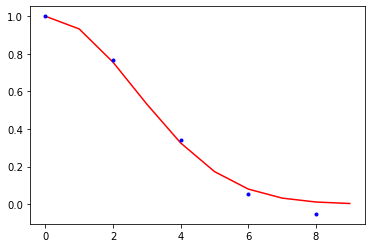

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 299
Number of inner iterations in outer iteration number 2: 103
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [12.85318637 12.83980191 12.84009979 12.84006496 12.84003087]
Observation contribution to cost function [48.03404735 48.07368407 48.07433052 48.07430045 48.07418676]
Model contribution to cost function  [81.49064157 81.23704728 81.23609407 81.23615225 81.23629811]
The values of the cost function total [142.37787529 142.15053326 142.15052438 142.15051765 142.15051574]
RMS between background/truth and analysis/truth [0.35503698 0.18286402]
New estimate for variance coming from assimilation window 2: 0.04851112986417999
New estimate for correlation length coming from assimilation window 2: 2.829186263953212


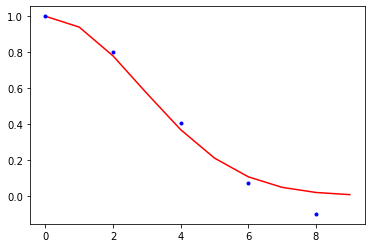

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 351
Number of inner iterations in outer iteration number 2: 137
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [20.96514789 20.98160224 20.98190809 20.98186328 20.98172904]
Observation contribution to cost function [49.69695342 49.76908857 49.76507557 49.76421196 49.7653945 ]
Model contribution to cost function  [93.73519314 93.18459788 93.18829794 93.18920274 93.18814933]
The values of the cost function total [164.39729445 163.93528869 163.9352816  163.93527798 163.93527288]
RMS between background/truth and analysis/truth [0.37509961 0.17549653]
New estimate for variance coming from assimilation window 3: 0.0583557441312202
New estimate for correlation length coming from assimilation window 3: 2.519072789108621


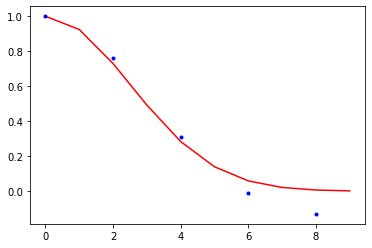

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 373
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [20.45968456 20.40749554 20.40798192 20.40766608 20.40743592]
Observation contribution to cost function [54.49364404 54.3311658  54.32904467 54.32938861 54.32970034]
Model contribution to cost function  [73.97412312 73.70878735 73.710375   73.71034701 73.71026802]
The values of the cost function total [148.92745172 148.4474487  148.44740159 148.4474017  148.44740428]
RMS between background/truth and analysis/truth [0.3275276  0.17400081]
New estimate for variance coming from assimilation window 4: 0.046481182440461996
New estimate for correlation length coming from assimilation window 4: 2.7171263472030054


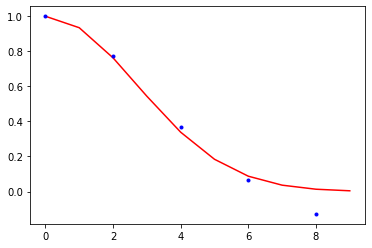

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 387
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [17.28987079 17.2685697  17.26876174 17.26867372 17.26853707]
Observation contribution to cost function [58.8194249  58.85244136 58.85006517 58.84763214 58.85054328]
Model contribution to cost function  [70.93619338 70.09802136 70.100183   70.10270852 70.09993195]
The values of the cost function total [147.04548908 146.21903242 146.21900991 146.21901437 146.21901231]
RMS between background/truth and analysis/truth [0.35206273 0.18378251]
New estimate for variance coming from assimilation window 5: 0.042350080068734475
New estimate for correlation length coming from assimilation window 5: 2.803035423342095


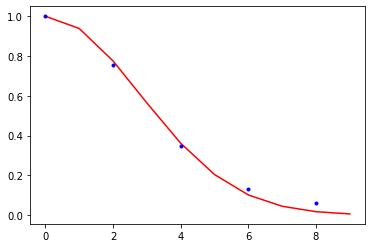

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 393
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.35882409 33.29852649 33.30099935 33.30085993 33.30072435]
Observation contribution to cost function [60.52663913 60.5136889  60.50751059 60.50898141 60.50830363]
Model contribution to cost function  [86.16968446 86.10631532 86.10997267 86.10863673 86.10944945]
The values of the cost function total [180.05514768 179.91853071 179.91848261 179.91847807 179.91847743]
RMS between background/truth and analysis/truth [0.35498901 0.20594925]
New estimate for variance coming from assimilation window 6: 0.047187248325266995
New estimate for correlation length coming from assimilation window 6: 2.5207185306101807


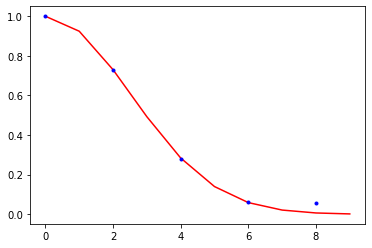

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 393
Number of inner iterations in outer iteration number 2: 159
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [32.67272367 32.47907658 32.47999588 32.47980927 32.47956994]
Observation contribution to cost function [59.21938671 58.60722255 58.60177537 58.59944243 58.60246784]
Model contribution to cost function  [88.08482064 87.97996741 87.98433757 87.98686299 87.98407474]
The values of the cost function total [179.97693103 179.06626654 179.06610883 179.06611469 179.06611253]
RMS between background/truth and analysis/truth [0.40656298 0.23374486]
New estimate for variance coming from assimilation window 7: 0.05025408701659402
New estimate for correlation length coming from assimilation window 7: 2.3550222333477295


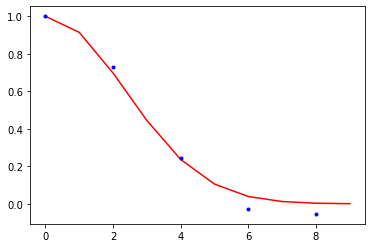

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 380
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.4816704  30.44106509 30.44278915 30.44253248 30.44242263]
Observation contribution to cost function [58.42693273 58.39986174 58.39586592 58.39648455 58.39521193]
Model contribution to cost function  [74.32826967 73.85371646 73.85595106 73.85559088 73.85698601]
The values of the cost function total [163.23687281 162.6946433  162.69460614 162.69460791 162.69462057]
RMS between background/truth and analysis/truth [0.38140807 0.26068872]
New estimate for variance coming from assimilation window 8: 0.038026249694738334
New estimate for correlation length coming from assimilation window 8: 2.1569983330857996


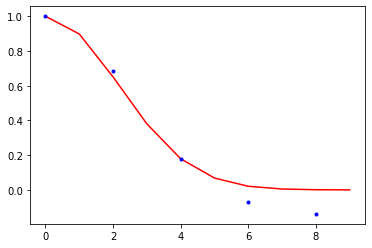

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 363
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [38.0678717  38.07303532 38.07647372 38.07633246 38.07607787]
Observation contribution to cost function [65.81183489 66.04867231 66.04222001 66.03908148 66.04282527]
Model contribution to cost function  [106.92673941 106.83912684 106.84211906 106.84539461 106.84190854]
The values of the cost function total [210.80644599 210.96083446 210.96081279 210.96080854 210.96081168]
RMS between background/truth and analysis/truth [0.46014356 0.29707915]
New estimate for variance coming from assimilation window 9: 0.056098193786804675
New estimate for correlation length coming from assimilation window 9: 2.690526609773057


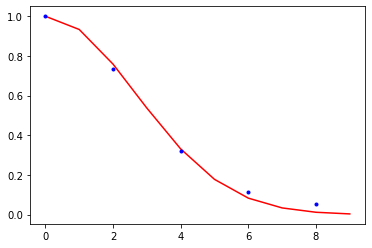

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 382
Number of inner iterations in outer iteration number 2: 167
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [44.9973542  45.72752372 45.7103995  45.70988624 45.70951858]
Observation contribution to cost function [79.06365348 79.78741326 79.78184112 79.78419434 79.78491928]
Model contribution to cost function  [123.70215534 120.27596208 120.2982316  120.29639395 120.29604126]
The values of the cost function total [247.76316303 245.79089906 245.79047222 245.79047453 245.79047913]
RMS between background/truth and analysis/truth [0.49456694 0.33172386]
New estimate for variance coming from assimilation window 10: 0.0573039519899703
New estimate for correlation length coming from assimilation window 10: 2.1632858860477047


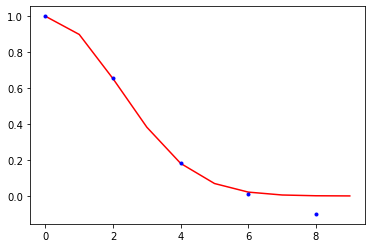

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 380
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [86.96717472 88.38559795 88.34925525 88.34778205 88.34758536]
Observation contribution to cost function [89.59092467 90.19029919 90.17936048 90.18591359 90.18250799]
Model contribution to cost function  [147.21702645 146.09352067 146.14082969 146.13575886 146.1393492 ]
The values of the cost function total [323.77512584 324.66941781 324.66944541 324.66945451 324.66944255]
RMS between background/truth and analysis/truth [0.53166533 0.37383498]
New estimate for variance coming from assimilation window 11: 0.0632338565282866
New estimate for correlation length coming from assimilation window 11: 2.6615558097364733


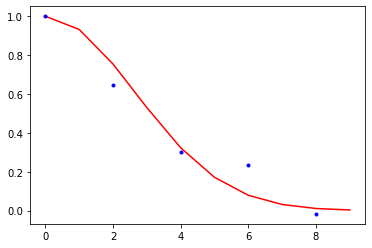

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 390
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [165.84558848 166.82083802 166.77462266 166.77244623 166.77169542]
Observation contribution to cost function [156.87444574 155.73972594 155.68094354 155.68723719 155.68582586]
Model contribution to cost function  [193.31292808 194.29825941 194.40436077 194.40032481 194.40247972]
The values of the cost function total [516.0329623  516.85882337 516.85992696 516.86000823 516.860001  ]
RMS between background/truth and analysis/truth [0.60118327 0.42702227]
New estimate for variance coming from assimilation window 12: 0.07897788050034356
New estimate for correlation length coming from assimilation window 12: 2.0294235169757346


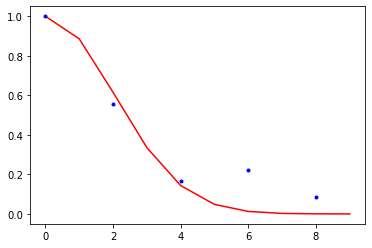

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 394
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 31
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [226.00609989 225.76266242 225.6880832  225.67997131 225.67726649]
Observation contribution to cost function [192.11654248 190.98157393 190.82877368 190.8323012  190.83444155]
Model contribution to cost function  [257.0460664  256.72164086 256.95124265 256.95586472 256.95643286]
The values of the cost function total [675.16870877 673.46587721 673.46809953 673.46813722 673.4681409 ]
RMS between background/truth and analysis/truth [0.68621848 0.49104528]
New estimate for variance coming from assimilation window 13: 0.10762047428304894
New estimate for correlation length coming from assimilation window 13: 3.1448385036934154


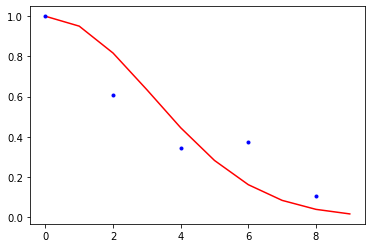

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 358
Number of inner iterations in outer iteration number 2: 219
Number of inner iterations in outer iteration number 3: 49
Number of inner iterations in outer iteration number 4: 9
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [290.67200441 289.04885017 288.88487477 288.8818405  288.88186614]
Observation contribution to cost function [233.75363948 230.01533697 229.81694408 229.80748397 229.80245136]
Model contribution to cost function  [271.42902957 268.49733332 268.8618103  268.87446144 268.87943515]
The values of the cost function total [795.85467346 787.56152045 787.56362914 787.5637859  787.56375265]
RMS between background/truth and analysis/truth [0.6766355  0.57108619]
New estimate for variance coming from assimilation window 14: 0.07441984545137138
New estimate for correlation length coming from assimilation window 14: 1.5430064749863137


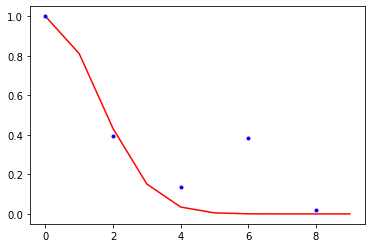

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 360
Number of inner iterations in outer iteration number 2: 293
Number of inner iterations in outer iteration number 3: 51
Number of inner iterations in outer iteration number 4: 13
Number of inner iterations in outer iteration number 5: 4

Background contribution to cost function [335.12167079 333.81909529 333.68741894 333.67340152 333.6729673 ]
Observation contribution to cost function [250.20439433 248.69621524 248.3571207  248.35022728 248.34514463]
Model contribution to cost function  [364.86976941 347.23403976 347.72249989 347.74357509 347.7490819 ]
The values of the cost function total [950.19583453 929.7493503  929.76703953 929.76720389 929.76719382]
RMS between background/truth and analysis/truth [0.83099226 0.68150331]
New estimate for variance coming from assimilation window 15: 0.08698620177421149
New estimate for correlation length coming from assimilation window 15: 1.2159117996338038


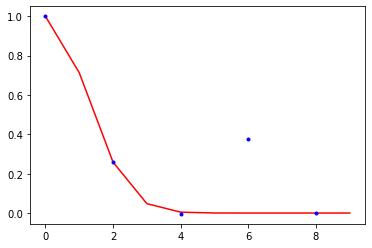

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 400
Number of inner iterations in outer iteration number 2: 323
Number of inner iterations in outer iteration number 3: 141
Number of inner iterations in outer iteration number 4: 29
Number of inner iterations in outer iteration number 5: 4

Background contribution to cost function [369.68708054 375.99139523 374.89043329 375.01599943 375.02050762]
Observation contribution to cost function [262.37487914 261.80595738 261.67005739 261.64407788 261.6050408 ]
Model contribution to cost function  [469.47178051 423.9203132  425.13587904 425.03586539 425.07038638]
The values of the cost function total [1101.5337402  1061.7176658  1061.69636972 1061.6959427  1061.69593479]
RMS between background/truth and analysis/truth [0.94997956 0.8229593 ]
New estimate for variance coming from assimilation window 16: 0.12256754452427968
New estimate for correlation length coming from assimilation window 16: 1.1482275297174371


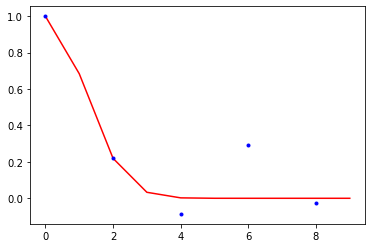

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 398
Number of inner iterations in outer iteration number 2: 279
Number of inner iterations in outer iteration number 3: 119
Number of inner iterations in outer iteration number 4: 33
Number of inner iterations in outer iteration number 5: 5

Background contribution to cost function [395.01156564 404.09799983 403.21452712 403.35757037 403.36636283]
Observation contribution to cost function [278.18448001 277.03645868 276.75307833 276.7389678  276.69097753]
Model contribution to cost function  [425.15365017 422.29568242 423.42942183 423.3023866  423.34108703]
The values of the cost function total [1098.34969582 1103.43014093 1103.39702727 1103.39892478 1103.39842739]
RMS between background/truth and analysis/truth [1.09481916 0.95173372]
New estimate for variance coming from assimilation window 17: 0.11957406159218267
New estimate for correlation length coming from assimilation window 17: 1.052647854000813


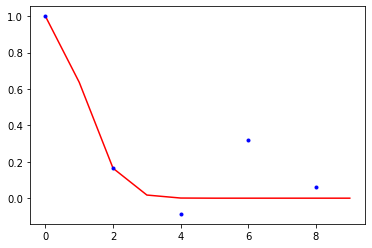

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 414
Number of inner iterations in outer iteration number 2: 289
Number of inner iterations in outer iteration number 3: 96
Number of inner iterations in outer iteration number 4: 31
Number of inner iterations in outer iteration number 5: 7

Background contribution to cost function [496.95390589 501.0281942  500.67356742 500.82569625 500.8467644 ]
Observation contribution to cost function [346.16234264 335.27477392 334.5838535  334.56819618 334.50227774]
Model contribution to cost function  [560.59063871 541.45005107 542.48495949 542.34920883 542.39319989]
The values of the cost function total [1403.70688724 1377.7530192  1377.74238041 1377.74310126 1377.74224203]
RMS between background/truth and analysis/truth [1.23666968 1.08556419]
New estimate for variance coming from assimilation window 18: 0.13533754442925638
New estimate for correlation length coming from assimilation window 18: 0.7389779416753883


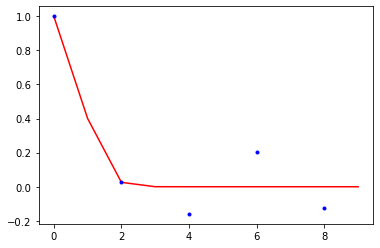

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 404
Number of inner iterations in outer iteration number 2: 283
Number of inner iterations in outer iteration number 3: 115
Number of inner iterations in outer iteration number 4: 33
Number of inner iterations in outer iteration number 5: 8

Background contribution to cost function [506.03711463 512.23808569 512.21085958 512.41096177 512.43801966]
Observation contribution to cost function [342.92726804 327.90871375 327.05769333 327.03431713 326.96896814]
Model contribution to cost function  [807.95363164 756.98569945 757.84321626 757.665419   757.70311139]
The values of the cost function total [1656.91801431 1597.13249889 1597.11176917 1597.1106979  1597.11009918]
RMS between background/truth and analysis/truth [1.38954304 1.20039297]
New estimate for variance coming from assimilation window 19: 0.2402197854428795
New estimate for correlation length coming from assimilation window 19: 1.0232947880165932


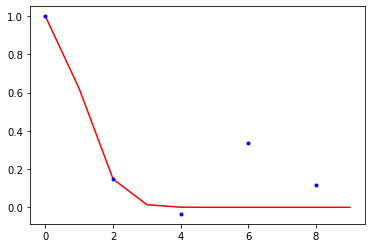

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [45.27901204 45.28168981 45.28367739 45.2856681  45.28458115]
Observation contribution to cost function [135.51434808 135.52099842 135.51940204 135.50947743 135.51382267]
Model contribution to cost function  [233.83295521 233.68594982 233.68546066 233.69339406 233.69012905]
The values of the cost function total [414.62631533 414.48863805 414.48854009 414.48853959 414.48853288]
RMS between background/truth and analysis/truth [0.30325501 0.2026301 ]
New estimate for variance coming from assimilation window 0: 0.031796744810127314
New estimate for correlation length coming from assimilation window 0: 2.744990391893973


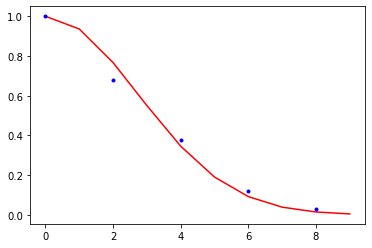

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 283
Number of inner iterations in outer iteration number 2: 101
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [27.10284977 27.12208767 27.1226585  27.12221718 27.12203502]
Observation contribution to cost function [64.55334698 64.40786671 64.40508316 64.40575766 64.40441753]
Model contribution to cost function  [94.89822195 94.90795747 94.91015311 94.90991491 94.91144641]
The values of the cost function total [186.5544187  186.43791185 186.43789477 186.43788975 186.43789896]
RMS between background/truth and analysis/truth [0.38518995 0.21666041]
New estimate for variance coming from assimilation window 1: 0.05034891455508719
New estimate for correlation length coming from assimilation window 1: 2.693179376923491


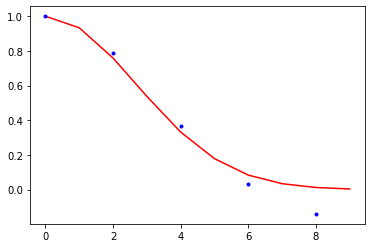

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 343
Number of inner iterations in outer iteration number 2: 129
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [21.65154283 21.60909844 21.60948913 21.6093938  21.60931424]
Observation contribution to cost function [48.94735734 48.84615038 48.8452902  48.84527659 48.84519405]
Model contribution to cost function  [83.06384424 82.53461146 82.53508072 82.53518929 82.53535234]
The values of the cost function total [153.66274441 152.98986027 152.98986005 152.98985969 152.98986064]
RMS between background/truth and analysis/truth [0.39358856 0.20518424]
New estimate for variance coming from assimilation window 2: 0.04877793505002605
New estimate for correlation length coming from assimilation window 2: 2.5593561773571496


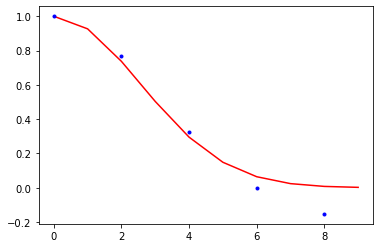

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 365
Number of inner iterations in outer iteration number 2: 145
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.02482854 24.04285521 24.04364534 24.04364134 24.0435235 ]
Observation contribution to cost function [50.34415284 50.20709163 50.20404118 50.20372967 50.20427669]
Model contribution to cost function  [80.3119944  80.01825619 80.02053372 80.0208548  80.02041937]
The values of the cost function total [154.68097578 154.26820303 154.26822024 154.26822581 154.26821956]
RMS between background/truth and analysis/truth [0.35533589 0.19332257]
New estimate for variance coming from assimilation window 3: 0.040046621881648314
New estimate for correlation length coming from assimilation window 3: 2.4795281454663427


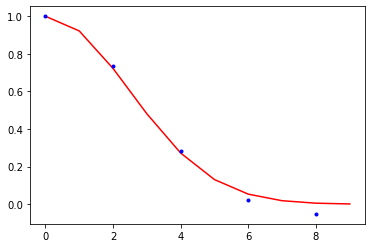

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 335
Number of inner iterations in outer iteration number 2: 149
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [21.81434838 21.71114908 21.71246855 21.71230698 21.71217754]
Observation contribution to cost function [52.76054766 52.36345719 52.35911653 52.35925609 52.35944293]
Model contribution to cost function  [78.56952115 78.89024518 78.89329536 78.89330927 78.89324651]
The values of the cost function total [153.14441719 152.96485146 152.96488044 152.96487234 152.96486698]
RMS between background/truth and analysis/truth [0.39579726 0.18338743]
New estimate for variance coming from assimilation window 4: 0.049020179496628
New estimate for correlation length coming from assimilation window 4: 3.602825227773724


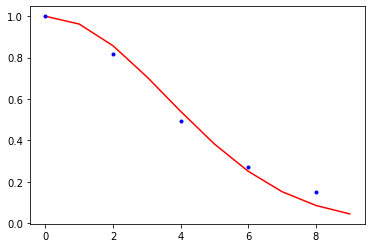

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 393
Number of inner iterations in outer iteration number 2: 143
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.07030736 24.12370386 24.12450443 24.12425797 24.12417358]
Observation contribution to cost function [61.55490364 61.55822867 61.55571973 61.55623679 61.55446657]
Model contribution to cost function  [92.62743465 92.37811098 92.37981026 92.37953203 92.38139131]
The values of the cost function total [178.25264565 178.06004352 178.06003442 178.06002679 178.06003146]
RMS between background/truth and analysis/truth [0.38682737 0.18298416]
New estimate for variance coming from assimilation window 5: 0.0575967613720376
New estimate for correlation length coming from assimilation window 5: 2.8338756267131315


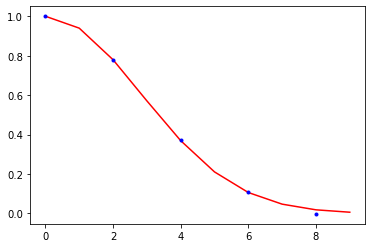

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 413
Number of inner iterations in outer iteration number 2: 151
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [23.91031688 23.93667192 23.93756477 23.93733119 23.93720044]
Observation contribution to cost function [63.80995982 63.74392647 63.74182653 63.74241914 63.74076988]
Model contribution to cost function  [77.57863465 77.57811297 77.57929161 77.57892971 77.58071979]
The values of the cost function total [165.29891135 165.25871137 165.25868291 165.25868003 165.25869011]
RMS between background/truth and analysis/truth [0.33640694 0.18820508]
New estimate for variance coming from assimilation window 6: 0.040033083718197686
New estimate for correlation length coming from assimilation window 6: 2.241608698301036


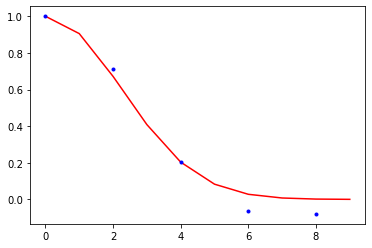

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 393
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [32.74336006 32.72711362 32.72822897 32.72811294 32.72793418]
Observation contribution to cost function [58.42312736 58.19664975 58.19151152 58.18905189 58.19216593]
Model contribution to cost function  [72.7839672  72.33899493 72.34290074 72.34548407 72.34254049]
The values of the cost function total [163.95045462 163.26275829 163.26264123 163.2626489  163.26264059]
RMS between background/truth and analysis/truth [0.34952879 0.19248398]
New estimate for variance coming from assimilation window 7: 0.045181363795458174
New estimate for correlation length coming from assimilation window 7: 3.1406315986871642


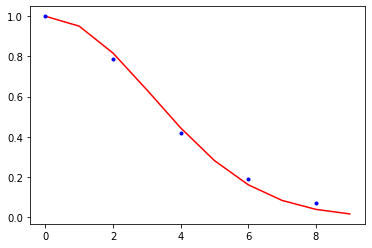

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 404
Number of inner iterations in outer iteration number 2: 145
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [41.31886409 41.19449801 41.19619502 41.195619   41.19525633]
Observation contribution to cost function [74.22818567 74.03436499 74.02626549 74.02729712 74.0270563 ]
Model contribution to cost function  [88.59536689 89.00060289 89.00693726 89.0064791  89.00709177]
The values of the cost function total [204.14241665 204.22946588 204.22939777 204.22939521 204.22940439]
RMS between background/truth and analysis/truth [0.35778893 0.2127921 ]
New estimate for variance coming from assimilation window 8: 0.044387133625615444
New estimate for correlation length coming from assimilation window 8: 2.574200613039562


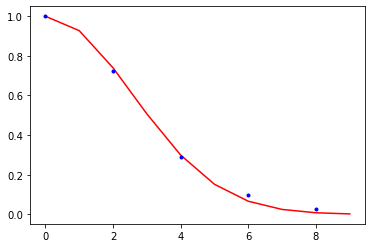

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 406
Number of inner iterations in outer iteration number 2: 157
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [34.23047723 34.34690565 34.35020019 34.3500224  34.34985631]
Observation contribution to cost function [65.80717886 66.32385066 66.31776625 66.31661375 66.31843146]
Model contribution to cost function  [71.36377887 70.76811204 70.77089484 70.77222446 70.77057108]
The values of the cost function total [171.40143496 171.43886835 171.43886128 171.43886061 171.43885885]
RMS between background/truth and analysis/truth [0.37048738 0.20914636]
New estimate for variance coming from assimilation window 9: 0.03966930399402589
New estimate for correlation length coming from assimilation window 9: 2.791052253853685


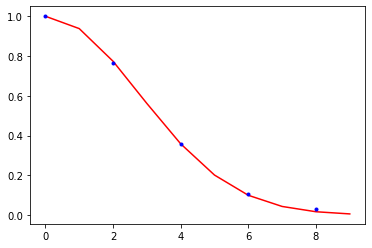

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 405
Number of inner iterations in outer iteration number 2: 168
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [42.78001869 42.83472534 42.83830937 42.83742371 42.83669932]
Observation contribution to cost function [67.95465321 68.12194573 68.10841887 68.11051205 68.11206262]
Model contribution to cost function  [78.58513108 78.35995348 78.36972438 78.36850952 78.36768504]
The values of the cost function total [189.31980298 189.31662454 189.31645262 189.31644529 189.31644699]
RMS between background/truth and analysis/truth [0.38948853 0.22642075]
New estimate for variance coming from assimilation window 10: 0.050331716183764474
New estimate for correlation length coming from assimilation window 10: 2.8636436604585715


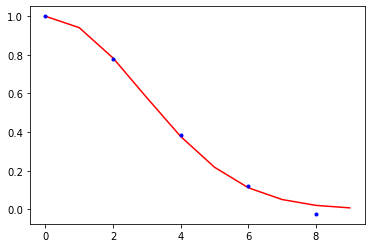

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 402
Number of inner iterations in outer iteration number 2: 145
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [47.8365972  47.66345224 47.66483495 47.66425733 47.66381136]
Observation contribution to cost function [73.25296328 73.03893858 73.02886043 73.02918895 73.02960541]
Model contribution to cost function  [84.58994928 84.2540583  84.26234756 84.26258947 84.26262611]
The values of the cost function total [205.67950976 204.95644912 204.95604294 204.95603575 204.95604288]
RMS between background/truth and analysis/truth [0.37090932 0.23631228]
New estimate for variance coming from assimilation window 11: 0.045618408864828576
New estimate for correlation length coming from assimilation window 11: 2.813963180431906


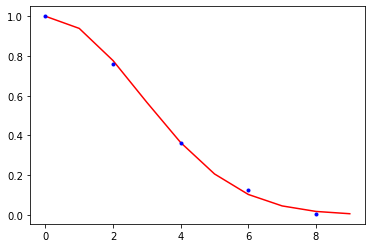

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 419
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [62.17186191 61.9771501  61.97395951 61.97250286 61.97218791]
Observation contribution to cost function [88.22999889 88.50003046 88.49268132 88.49345625 88.49398274]
Model contribution to cost function  [90.3445892  89.85899992 89.86789117 89.86854141 89.86832423]
The values of the cost function total [240.74645    240.33618048 240.33453199 240.33450052 240.33449488]
RMS between background/truth and analysis/truth [0.39909457 0.24958282]
New estimate for variance coming from assimilation window 12: 0.048728034264907384
New estimate for correlation length coming from assimilation window 12: 2.448508573716686


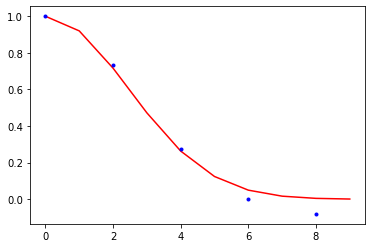

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 409
Number of inner iterations in outer iteration number 2: 175
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [79.47719074 79.66358794 79.67640415 79.67560401 79.67488376]
Observation contribution to cost function [92.18908696 93.25791162 93.23442508 93.23442816 93.23659204]
Model contribution to cost function  [88.78679762 87.45028549 87.46080113 87.46159354 87.46015306]
The values of the cost function total [260.45307532 260.37178505 260.37163035 260.3716257  260.37162886]
RMS between background/truth and analysis/truth [0.43356889 0.283457  ]
New estimate for variance coming from assimilation window 13: 0.04630852105925631
New estimate for correlation length coming from assimilation window 13: 3.221407545972666


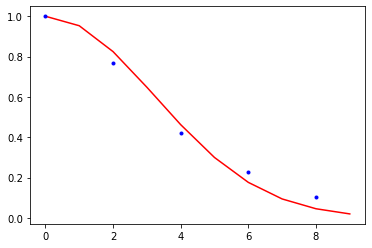

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 420
Number of inner iterations in outer iteration number 2: 186
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [87.52592314 87.81962486 87.81575398 87.81486991 87.81325304]
Observation contribution to cost function [107.34537537 106.64712311 106.6333438  106.63381947 106.63561015]
Model contribution to cost function  [121.7913424  120.82329535 120.84039505 120.84079932 120.8406223 ]
The values of the cost function total [316.66264091 315.29004332 315.28949283 315.2894887  315.28948549]
RMS between background/truth and analysis/truth [0.5051185  0.30700662]
New estimate for variance coming from assimilation window 14: 0.06992059322869341
New estimate for correlation length coming from assimilation window 14: 2.261527225950263


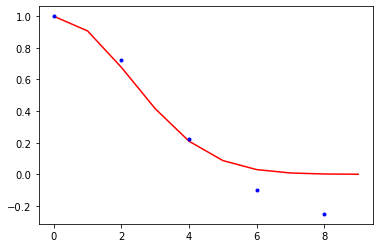

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 416
Number of inner iterations in outer iteration number 2: 173
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [117.7941905  117.14093595 117.15969781 117.1569025  117.15569414]
Observation contribution to cost function [118.80518093 119.2992878  119.24083017 119.24332097 119.24495195]
Model contribution to cost function  [109.02992455 107.01201089 107.05006479 107.05036562 107.04994843]
The values of the cost function total [345.62929598 343.45223464 343.45059277 343.45058909 343.45059451]
RMS between background/truth and analysis/truth [0.49724619 0.3308582 ]
New estimate for variance coming from assimilation window 15: 0.04586565551581976
New estimate for correlation length coming from assimilation window 15: 2.4857205468977757


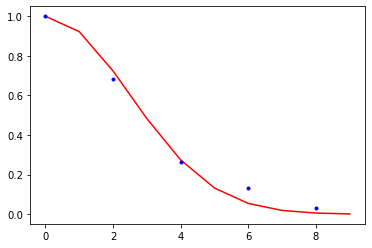

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 423
Number of inner iterations in outer iteration number 2: 192
Number of inner iterations in outer iteration number 3: 28
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [101.04250839 100.07378906 100.04913476 100.04511299 100.04455556]
Observation contribution to cost function [103.36860068 102.1257986  102.08485769 102.08416046 102.08430588]
Model contribution to cost function  [118.91269654 118.31795935 118.37758324 118.38224433 118.3826602 ]
The values of the cost function total [323.32380561 320.51754702 320.51157569 320.51151778 320.51152164]
RMS between background/truth and analysis/truth [0.53639033 0.36365455]
New estimate for variance coming from assimilation window 16: 0.06722389352092509
New estimate for correlation length coming from assimilation window 16: 3.163607696600452


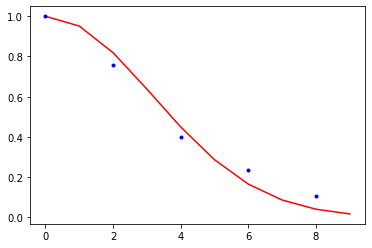

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 440
Number of inner iterations in outer iteration number 2: 211
Number of inner iterations in outer iteration number 3: 44
Number of inner iterations in outer iteration number 4: 14
Number of inner iterations in outer iteration number 5: 4

Background contribution to cost function [141.82576298 139.02386625 138.89954282 138.88716233 138.88473164]
Observation contribution to cost function [142.95790824 139.71754729 139.61886974 139.61078551 139.61053355]
Model contribution to cost function  [162.30973083 162.5238219  162.73480022 162.75489661 162.75755223]
The values of the cost function total [447.09340205 441.26523545 441.25321277 441.25284445 441.25281743]
RMS between background/truth and analysis/truth [0.57263909 0.40076095]
New estimate for variance coming from assimilation window 17: 0.08004733326297159
New estimate for correlation length coming from assimilation window 17: 2.3329110090696785


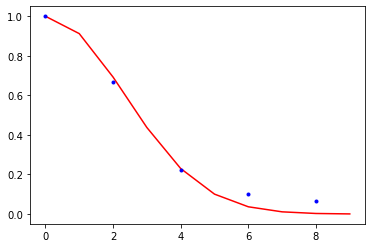

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 442
Number of inner iterations in outer iteration number 2: 225
Number of inner iterations in outer iteration number 3: 85
Number of inner iterations in outer iteration number 4: 33
Number of inner iterations in outer iteration number 5: 14

Background contribution to cost function [258.30114967 251.39428051 250.95257123 250.89166579 250.88457542]
Observation contribution to cost function [227.7886173  223.412695   222.99863275 222.97309644 222.95998447]
Model contribution to cost function  [201.03388893 197.49963648 198.30971259 198.39264834 198.41247093]
The values of the cost function total [687.1236559  672.30661199 672.26091657 672.25741057 672.25703082]
RMS between background/truth and analysis/truth [0.59620831 0.45201304]
New estimate for variance coming from assimilation window 18: 0.06834423280654564
New estimate for correlation length coming from assimilation window 18: 1.9075584786305781


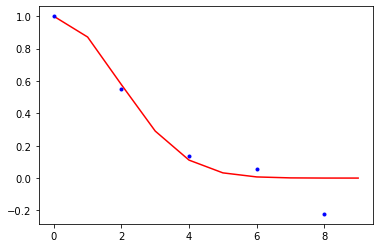

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 420
Number of inner iterations in outer iteration number 2: 229
Number of inner iterations in outer iteration number 3: 87
Number of inner iterations in outer iteration number 4: 45
Number of inner iterations in outer iteration number 5: 22

Background contribution to cost function [383.61068844 373.61655346 373.31472717 373.23548775 373.23460303]
Observation contribution to cost function [312.1152845  305.68083776 303.89857441 303.69715099 303.63147011]
Model contribution to cost function  [278.96336881 272.74939564 274.68722819 274.95234006 275.01760094]
The values of the cost function total [974.68934175 952.04678686 951.90052978 951.8849788  951.88367408]
RMS between background/truth and analysis/truth [0.68041126 0.49620995]
New estimate for variance coming from assimilation window 19: 0.08558546006476159
New estimate for correlation length coming from assimilation window 19: 2.0300577912341566


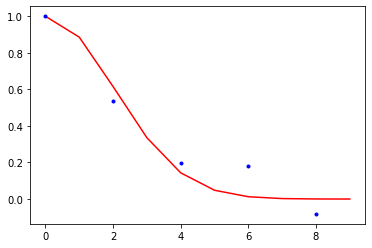

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [41.58680447 41.65965325 41.66078695 41.66343687 41.6622054 ]
Observation contribution to cost function [160.96840264 160.80255185 160.80574407 160.79439104 160.79963272]
Model contribution to cost function  [268.56959712 268.73845381 268.73415866 268.74285684 268.73883929]
The values of the cost function total [471.12480423 471.2006589  471.20068968 471.20068475 471.20067741]
RMS between background/truth and analysis/truth [0.30412378 0.20701526]
New estimate for variance coming from assimilation window 0: 0.03498748373254876
New estimate for correlation length coming from assimilation window 0: 2.505018608274996


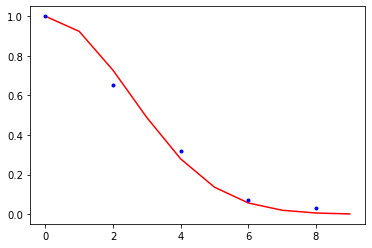

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 285
Number of inner iterations in outer iteration number 2: 125
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.46819374 24.42572491 24.42634401 24.42630655 24.42599343]
Observation contribution to cost function [69.76130695 69.67742311 69.67425611 69.67142776 69.67516909]
Model contribution to cost function  [100.36036296  99.51297272  99.51553204  99.51840078  99.51496726]
The values of the cost function total [194.58986365 193.61612074 193.61613217 193.61613509 193.61612979]
RMS between background/truth and analysis/truth [0.42000419 0.21521795]
New estimate for variance coming from assimilation window 1: 0.045418381212793235
New estimate for correlation length coming from assimilation window 1: 2.9621424468318103


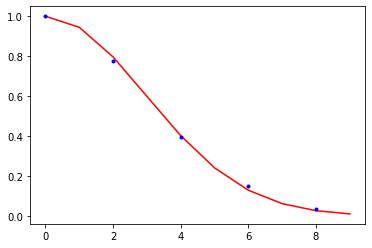

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 355
Number of inner iterations in outer iteration number 2: 133
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [25.52002492 25.46647258 25.46746254 25.46721531 25.46703615]
Observation contribution to cost function [53.91384883 54.05486761 54.05270141 54.05320312 54.05353981]
Model contribution to cost function  [83.70823767 83.4463517  83.44752681 83.44726914 83.44710907]
The values of the cost function total [163.14211142 162.96769189 162.96769076 162.96768756 162.96768504]
RMS between background/truth and analysis/truth [0.36996823 0.19382119]
New estimate for variance coming from assimilation window 2: 0.04595627807491271
New estimate for correlation length coming from assimilation window 2: 2.5409318197844506


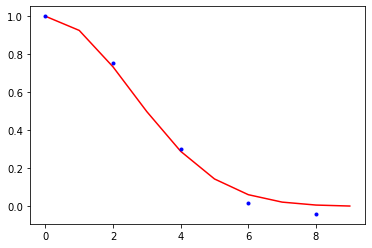

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 363
Number of inner iterations in outer iteration number 2: 151
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [21.39056167 21.37179749 21.3721669  21.37213223 21.37204209]
Observation contribution to cost function [58.56478895 58.34913682 58.34593849 58.34500464 58.3461458 ]
Model contribution to cost function  [88.26006693 88.03278596 88.03556163 88.03653595 88.03547926]
The values of the cost function total [168.21541755 167.75372026 167.75366702 167.75367282 167.75366715]
RMS between background/truth and analysis/truth [0.3770879  0.18518005]
New estimate for variance coming from assimilation window 3: 0.05216452008781389
New estimate for correlation length coming from assimilation window 3: 2.755143476674433


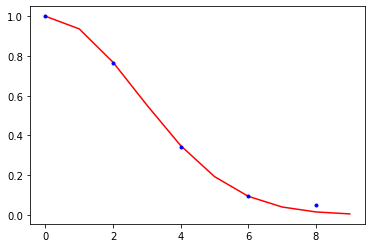

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 363
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [29.92178268 29.82393294 29.82547923 29.82520401 29.82511489]
Observation contribution to cost function [58.45629936 58.51324647 58.51080399 58.51114795 58.50855575]
Model contribution to cost function  [81.64301467 81.21073592 81.21159933 81.21153163 81.21422474]
The values of the cost function total [170.0210967  169.54791533 169.54788256 169.54788359 169.54789539]
RMS between background/truth and analysis/truth [0.39698035 0.17324143]
New estimate for variance coming from assimilation window 4: 0.06200937869269905
New estimate for correlation length coming from assimilation window 4: 3.8538576504242226


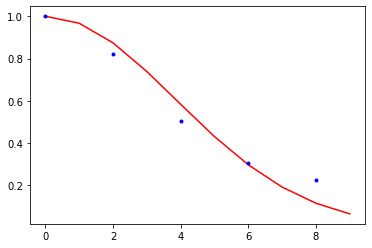

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [29.30841825 29.27582574 29.27734762 29.27711573 29.27689695]
Observation contribution to cost function [71.81786448 71.70606189 71.7028729  71.7031717  71.70349804]
Model contribution to cost function  [78.42154806 77.75825567 77.75992696 77.75986246 77.75975868]
The values of the cost function total [179.54783079 178.7401433  178.74014748 178.74014989 178.74015367]
RMS between background/truth and analysis/truth [0.34535739 0.17449793]
New estimate for variance coming from assimilation window 5: 0.05002105342223953
New estimate for correlation length coming from assimilation window 5: 3.1361849263605426


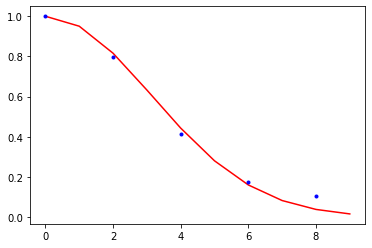

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 479
Number of inner iterations in outer iteration number 2: 181
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [31.57415734 31.68703322 31.69142058 31.69118205 31.69113371]
Observation contribution to cost function [81.69679851 81.7427078  81.73456649 81.73501317 81.73330498]
Model contribution to cost function  [68.4985354  68.44223545 68.44594776 68.44573951 68.44750995]
The values of the cost function total [181.76949125 181.87197647 181.87193484 181.87193474 181.87194864]
RMS between background/truth and analysis/truth [0.34793322 0.18591324]
New estimate for variance coming from assimilation window 6: 0.04371652693269724
New estimate for correlation length coming from assimilation window 6: 2.985345334982296


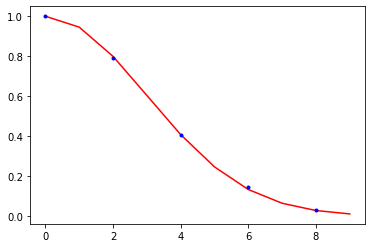

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [37.52334827 37.44737547 37.45094332 37.4507745  37.45033586]
Observation contribution to cost function [65.44330118 65.36478295 65.35672399 65.35629395 65.35757924]
Model contribution to cost function  [62.37846171 62.10017376 62.10450217 62.10510003 62.10425285]
The values of the cost function total [165.34511115 164.91233219 164.91216948 164.91216848 164.91216795]
RMS between background/truth and analysis/truth [0.33674298 0.19589755]
New estimate for variance coming from assimilation window 7: 0.03922297242683896
New estimate for correlation length coming from assimilation window 7: 3.177415012414367


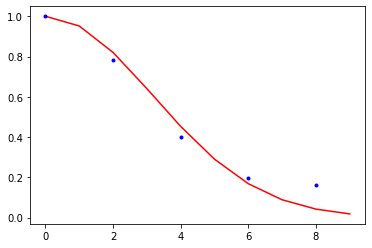

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 458
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [60.65518187 60.72369587 60.73476253 60.73358276 60.73315707]
Observation contribution to cost function [85.53832324 85.76896301 85.75435203 85.7549738  85.75622745]
Model contribution to cost function  [80.54244166 80.25388383 80.25729161 80.25785669 80.25702956]
The values of the cost function total [226.73594678 226.74654271 226.74640617 226.74641325 226.74641407]
RMS between background/truth and analysis/truth [0.36151414 0.20727943]
New estimate for variance coming from assimilation window 8: 0.04769498325598755
New estimate for correlation length coming from assimilation window 8: 2.5616636809549544


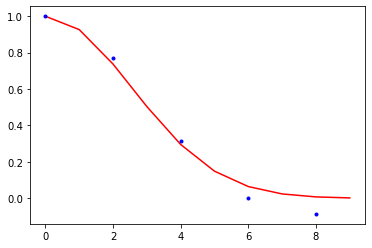

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 441
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [66.27430443 66.25101494 66.2662786  66.26555031 66.26512576]
Observation contribution to cost function [81.3891366  81.08060688 81.06064639 81.06100481 81.06250207]
Model contribution to cost function  [81.82348519 82.41359386 82.41797217 82.41835623 82.41728477]
The values of the cost function total [229.48692622 229.74521567 229.74489716 229.74491135 229.7449126 ]
RMS between background/truth and analysis/truth [0.40189903 0.2260332 ]
New estimate for variance coming from assimilation window 9: 0.05256001378366283
New estimate for correlation length coming from assimilation window 9: 3.3075963025091095


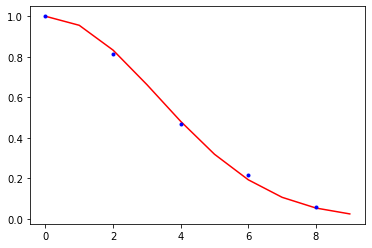

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 181
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.72838096 62.72345143 62.72573178 62.72462632 62.72402402]
Observation contribution to cost function [85.90518739 85.63810265 85.63149757 85.63332276 85.63420261]
Model contribution to cost function  [106.05846113 106.80042891 106.8046579  106.80394841 106.80366884]
The values of the cost function total [254.69202948 255.16198299 255.16188725 255.16189748 255.16189547]
RMS between background/truth and analysis/truth [0.43521781 0.22500886]
New estimate for variance coming from assimilation window 10: 0.07110401858541776
New estimate for correlation length coming from assimilation window 10: 2.541949309377786


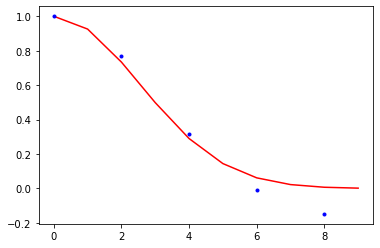

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 480
Number of inner iterations in outer iteration number 2: 185
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [47.5276368  47.76913329 47.77110019 47.77069961 47.77035488]
Observation contribution to cost function [81.30487953 81.56865212 81.55949531 81.55989393 81.56107705]
Model contribution to cost function  [82.15994023 81.98989579 81.99694048 81.99694802 81.99610561]
The values of the cost function total [210.99245657 211.3276812  211.32753598 211.32754156 211.32753754]
RMS between background/truth and analysis/truth [0.39802688 0.22995069]
New estimate for variance coming from assimilation window 11: 0.04782227732267794
New estimate for correlation length coming from assimilation window 11: 3.1541138855073725


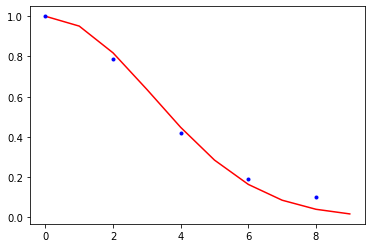

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 460
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [62.68626268 62.90316025 62.90777254 62.90713417 62.90705311]
Observation contribution to cost function [86.1374625  86.42676295 86.4130813  86.41404077 86.41486975]
Model contribution to cost function  [92.47999102 92.19885406 92.20791463 92.20760615 92.20684884]
The values of the cost function total [241.30371619 241.52877726 241.52876848 241.52878108 241.5287717 ]
RMS between background/truth and analysis/truth [0.39023886 0.21799171]
New estimate for variance coming from assimilation window 12: 0.04453218779698705
New estimate for correlation length coming from assimilation window 12: 1.9661585867607898


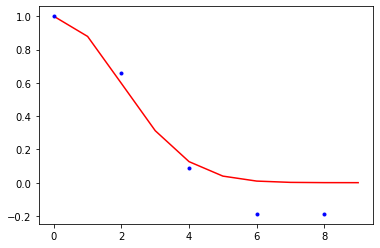

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 433
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [54.98415904 54.97432712 54.97655114 54.9764375  54.97640456]
Observation contribution to cost function [60.43217356 60.49556196 60.49198113 60.49226294 60.4889318 ]
Model contribution to cost function  [76.80713858 76.00101269 76.0024091  76.00223927 76.00561042]
The values of the cost function total [192.22347118 191.47090177 191.47094136 191.47093972 191.47094678]
RMS between background/truth and analysis/truth [0.41745801 0.21950106]
New estimate for variance coming from assimilation window 13: 0.05027718277992713
New estimate for correlation length coming from assimilation window 13: 3.3437965480974214


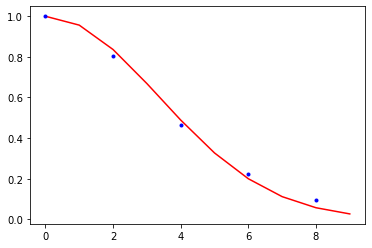

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 201
Number of inner iterations in outer iteration number 3: 14
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.96931784 64.99851363 64.99664199 64.99648818 64.99637181]
Observation contribution to cost function [94.27588477 94.02234528 94.01671474 94.01852878 94.0174115 ]
Model contribution to cost function  [102.62111995 102.81716887 102.82464948 102.82298623 102.82421719]
The values of the cost function total [261.86632256 261.83802778 261.83800621 261.83800319 261.83800049]
RMS between background/truth and analysis/truth [0.40930254 0.22308361]
New estimate for variance coming from assimilation window 14: 0.055283281553319547
New estimate for correlation length coming from assimilation window 14: 2.456489167392963


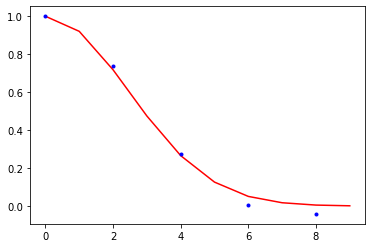

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 447
Number of inner iterations in outer iteration number 2: 167
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [53.34318187 53.38378818 53.39024901 53.38973138 53.38936269]
Observation contribution to cost function [64.37411774 64.18344321 64.17352353 64.17160232 64.17456758]
Model contribution to cost function  [76.61215802 76.5404125  76.54394143 76.54639262 76.5437948 ]
The values of the cost function total [194.32945763 194.10764389 194.10771397 194.10772632 194.10772507]
RMS between background/truth and analysis/truth [0.43083569 0.22173577]
New estimate for variance coming from assimilation window 15: 0.05488854294060004
New estimate for correlation length coming from assimilation window 15: 3.187280299936021


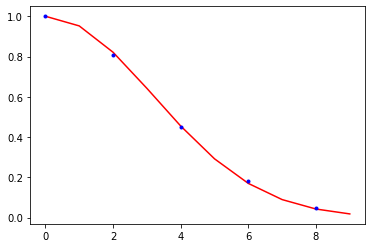

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 447
Number of inner iterations in outer iteration number 2: 185
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [41.54993898 41.58863353 41.59203876 41.59146981 41.5912967 ]
Observation contribution to cost function [68.38039853 68.49864143 68.49090794 68.49203644 68.48970698]
Model contribution to cost function  [89.29901315 89.13650504 89.14080968 89.14024884 89.14275785]
The values of the cost function total [199.22935066 199.22377999 199.22375638 199.22375509 199.22376152]
RMS between background/truth and analysis/truth [0.39503685 0.23043855]
New estimate for variance coming from assimilation window 16: 0.05750911543175981
New estimate for correlation length coming from assimilation window 16: 3.069430985669934


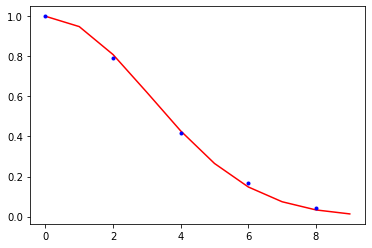

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 171
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.19602508 33.27403527 33.27569404 33.27555383 33.27545766]
Observation contribution to cost function [71.7885545  71.63994933 71.63532237 71.63557318 71.63457443]
Model contribution to cost function  [77.42394859 77.00483068 77.00780732 77.00769218 77.00879064]
The values of the cost function total [182.40852817 181.91881528 181.91882374 181.91881919 181.91882274]
RMS between background/truth and analysis/truth [0.39767931 0.23399894]
New estimate for variance coming from assimilation window 17: 0.04976921028143984
New estimate for correlation length coming from assimilation window 17: 3.612192149918569


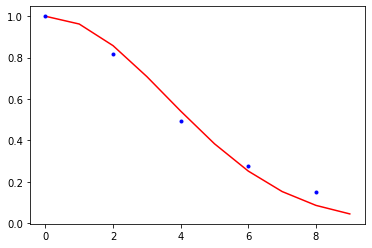

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 459
Number of inner iterations in outer iteration number 2: 195
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [49.23360928 49.35138716 49.35461114 49.3538126  49.35348183]
Observation contribution to cost function [67.71976176 67.7628611  67.75463391 67.75426865 67.75676148]
Model contribution to cost function  [80.11659034 79.25703012 79.26201843 79.26318498 79.26102667]
The values of the cost function total [197.06996138 196.37127837 196.37126348 196.37126623 196.37126997]
RMS between background/truth and analysis/truth [0.42073612 0.24712004]
New estimate for variance coming from assimilation window 18: 0.05559629596785201
New estimate for correlation length coming from assimilation window 18: 4.527610406405931


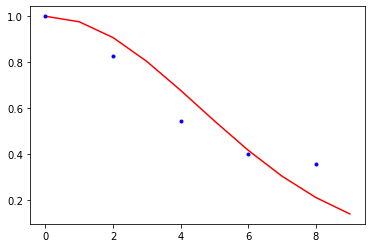

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [53.14832004 53.11330267 53.11896772 53.11888154 53.11844185]
Observation contribution to cost function [86.49169369 86.68139627 86.6705206  86.66889264 86.67135097]
Model contribution to cost function  [73.99954439 73.2756607  73.28063143 73.28234216 73.28032453]
The values of the cost function total [213.63955812 213.07035964 213.07011976 213.07011634 213.07011736]
RMS between background/truth and analysis/truth [0.38954775 0.24609814]
New estimate for variance coming from assimilation window 19: 0.038357803603916885
New estimate for correlation length coming from assimilation window 19: 2.7487883944275864


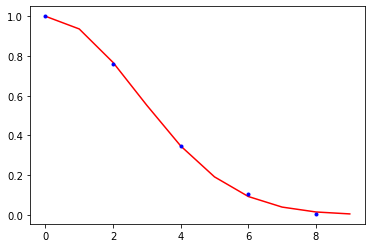

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [61.35338824 61.27230715 61.2716252  61.27641089 61.27241929]
Observation contribution to cost function [166.01135937 166.05339926 166.06463516 166.04110949 166.05507493]
Model contribution to cost function  [277.57888546 277.0251033  277.01449093 277.03322824 277.02324557]
The values of the cost function total [504.94363307 504.3508097  504.35075129 504.35074862 504.35073979]
RMS between background/truth and analysis/truth [0.33412466 0.22645276]
New estimate for variance coming from assimilation window 0: 0.03866928007333774
New estimate for correlation length coming from assimilation window 0: 2.6226744472862413


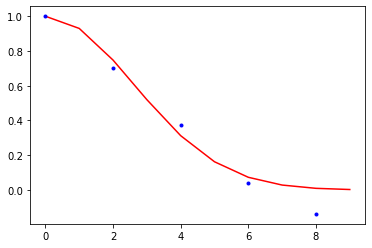

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 323
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [29.23802204 28.96099782 28.96130748 28.96137517 28.96142222]
Observation contribution to cost function [53.37996298 52.62106992 52.61893939 52.61628263 52.61906655]
Model contribution to cost function  [88.80172363 89.12221713 89.12411633 89.12671334 89.12387715]
The values of the cost function total [171.41970864 170.70428487 170.7043632  170.70437115 170.70436593]
RMS between background/truth and analysis/truth [0.40635537 0.22524978]
New estimate for variance coming from assimilation window 1: 0.04478827005040046
New estimate for correlation length coming from assimilation window 1: 2.498343187671443


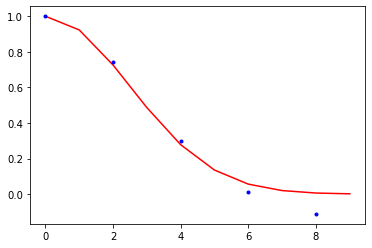

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 336
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.85774782 28.89754358 28.89891453 28.89853404 28.89843174]
Observation contribution to cost function [53.70900223 53.66303638 53.65887696 53.65975    53.65917887]
Model contribution to cost function  [92.78491603 92.2944006  92.29718206 92.29668681 92.29736582]
The values of the cost function total [175.35166608 174.85498056 174.85497355 174.85497085 174.85497644]
RMS between background/truth and analysis/truth [0.37848012 0.20771827]
New estimate for variance coming from assimilation window 2: 0.045441911467096155
New estimate for correlation length coming from assimilation window 2: 2.5422574257442467


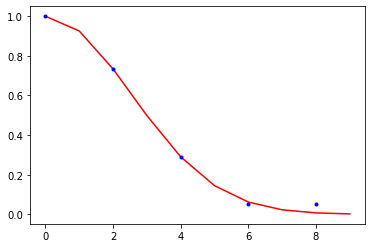

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 343
Number of inner iterations in outer iteration number 2: 151
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [26.4734065  26.32483753 26.32656951 26.32620473 26.3259839 ]
Observation contribution to cost function [55.37804192 55.09939787 55.09101851 55.09254934 55.09803989]
Model contribution to cost function  [98.40971791 98.41205785 98.41869241 98.41752084 98.41225362]
The values of the cost function total [180.26116632 179.83629325 179.83628043 179.83627491 179.83627741]
RMS between background/truth and analysis/truth [0.41519712 0.20807596]
New estimate for variance coming from assimilation window 3: 0.058528796144174756
New estimate for correlation length coming from assimilation window 3: 4.19667549556304


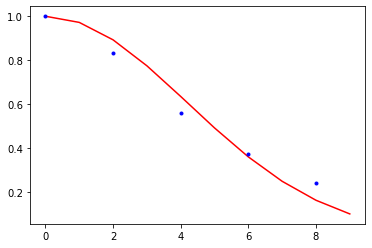

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 465
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.33763393 24.38717913 24.3876247  24.38748327 24.38723391]
Observation contribution to cost function [79.92128274 80.08458577 80.08277842 80.08098585 80.08306299]
Model contribution to cost function  [91.44547303 90.73596579 90.73736525 90.73929253 90.7374699 ]
The values of the cost function total [195.7043897  195.20773069 195.20776837 195.20776164 195.2077668 ]
RMS between background/truth and analysis/truth [0.41021265 0.20639841]
New estimate for variance coming from assimilation window 4: 0.06574871636431615
New estimate for correlation length coming from assimilation window 4: 2.884472013908628


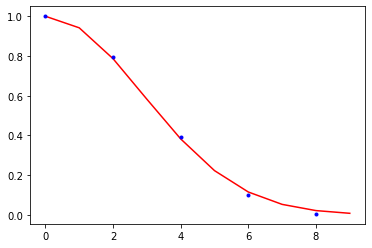

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 479
Number of inner iterations in outer iteration number 2: 171
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.74500168 33.79180741 33.79342221 33.79323834 33.79324644]
Observation contribution to cost function [71.45557569 71.70263883 71.69781149 71.69832644 71.69653422]
Model contribution to cost function  [77.56028955 77.13640311 77.13968421 77.13934902 77.14113574]
The values of the cost function total [182.76086692 182.63084936 182.63091791 182.6309138  182.63091641]
RMS between background/truth and analysis/truth [0.3818142  0.21728011]
New estimate for variance coming from assimilation window 5: 0.04832782868064911
New estimate for correlation length coming from assimilation window 5: 2.753375703835929


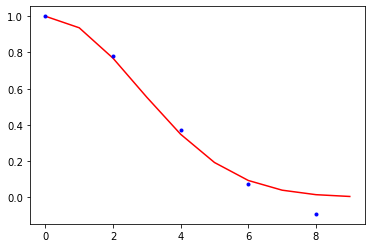

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 461
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [43.73578683 43.89825009 43.90191426 43.90180594 43.90150633]
Observation contribution to cost function [77.71332805 77.55539887 77.54982274 77.54712534 77.55055903]
Model contribution to cost function  [90.14627041 90.07222891 90.07407065 90.07687049 90.07373806]
The values of the cost function total [211.59538529 211.52587787 211.52580765 211.52580177 211.52580341]
RMS between background/truth and analysis/truth [0.44142611 0.21206069]
New estimate for variance coming from assimilation window 6: 0.06809736184875587
New estimate for correlation length coming from assimilation window 6: 2.920347531421759


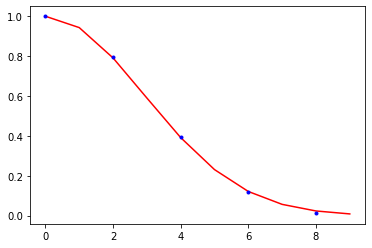

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 498
Number of inner iterations in outer iteration number 2: 163
Number of inner iterations in outer iteration number 3: 12
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.91256156 61.79303325 61.79702902 61.79687368 61.796658  ]
Observation contribution to cost function [89.60110257 89.43378808 89.4224245  89.42294332 89.42359191]
Model contribution to cost function  [81.14421719 81.33744939 81.3446111  81.34423818 81.34380439]
The values of the cost function total [232.65788132 232.56427072 232.56406461 232.56405518 232.56405431]
RMS between background/truth and analysis/truth [0.39057273 0.2265893 ]
New estimate for variance coming from assimilation window 7: 0.04950290882484239
New estimate for correlation length coming from assimilation window 7: 2.8074075674242733


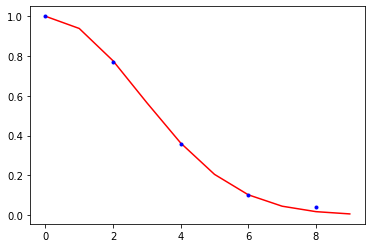

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 487
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [78.80166456 78.47636946 78.49369393 78.49292708 78.49252861]
Observation contribution to cost function [87.37282399 86.76134814 86.73432613 86.73540594 86.73386658]
Model contribution to cost function  [69.71869259 69.75806664 69.76752531 69.76723451 69.76918138]
The values of the cost function total [235.89318113 234.99578423 234.99554537 234.99556754 234.99557656]
RMS between background/truth and analysis/truth [0.40495878 0.22246481]
New estimate for variance coming from assimilation window 8: 0.04252905516518862
New estimate for correlation length coming from assimilation window 8: 2.914953590114994


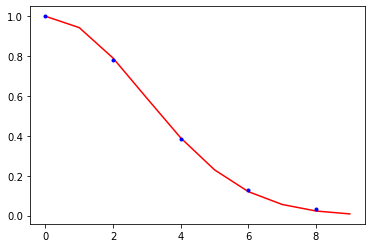

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 213
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [60.30954184 60.60339198 60.61536193 60.61521529 60.61467819]
Observation contribution to cost function [83.44163545 83.77448231 83.75286924 83.75333611 83.75383477]
Model contribution to cost function  [81.17179498 79.77412111 79.78360856 79.78329541 79.78334707]
The values of the cost function total [224.92297228 224.1519954  224.15183973 224.15184681 224.15186003]
RMS between background/truth and analysis/truth [0.42579732 0.24050788]
New estimate for variance coming from assimilation window 9: 0.05318490452050687
New estimate for correlation length coming from assimilation window 9: 3.00494946649036


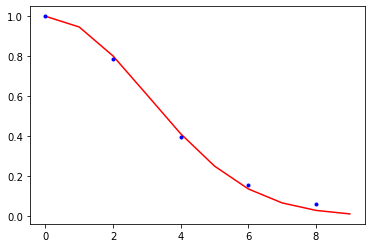

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 494
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [66.95526339 66.92615267 66.93741529 66.93713428 66.93657402]
Observation contribution to cost function [86.22090119 86.34964546 86.33173753 86.33106935 86.33267946]
Model contribution to cost function  [85.63350314 85.52336866 85.53003036 85.53097558 85.52994192]
The values of the cost function total [238.80966772 238.7991668  238.79918317 238.79917921 238.7991954 ]
RMS between background/truth and analysis/truth [0.40248527 0.23807443]
New estimate for variance coming from assimilation window 10: 0.05015321058044501
New estimate for correlation length coming from assimilation window 10: 2.261322347803929


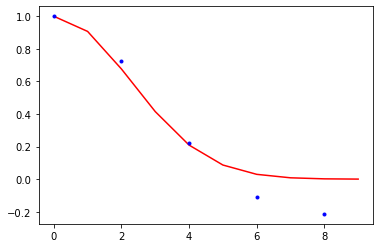

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 488
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [54.10230613 54.10166094 54.11190341 54.11107729 54.11076145]
Observation contribution to cost function [83.78784257 83.56512851 83.55043742 83.55139803 83.54904605]
Model contribution to cost function  [95.36574832 95.25307265 95.25729986 95.25718654 95.25987519]
The values of the cost function total [233.25589702 232.91986209 232.91964069 232.91966186 232.91968268]
RMS between background/truth and analysis/truth [0.4867749 0.2543583]
New estimate for variance coming from assimilation window 11: 0.06486985009306198
New estimate for correlation length coming from assimilation window 11: 2.813023943036349


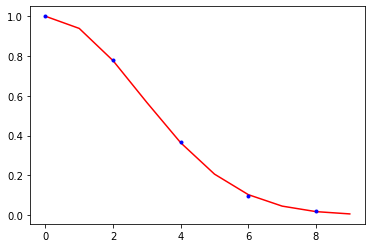

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 487
Number of inner iterations in outer iteration number 2: 213
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [57.88845233 57.95997612 57.96390781 57.96323928 57.96297034]
Observation contribution to cost function [80.50172324 80.23704394 80.22770468 80.22879893 80.22709527]
Model contribution to cost function  [75.49931761 76.1018092  76.10706113 76.10664096 76.1086241 ]
The values of the cost function total [213.88949318 214.29882926 214.29867362 214.29867917 214.29868972]
RMS between background/truth and analysis/truth [0.45550456 0.26707688]
New estimate for variance coming from assimilation window 12: 0.04891066401859077
New estimate for correlation length coming from assimilation window 12: 3.367733339375406


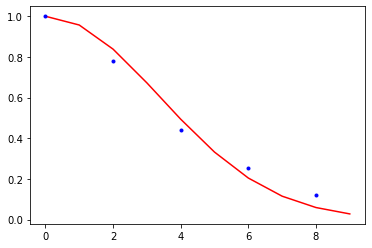

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 498
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [68.12336056 68.11641365 68.12731808 68.1269867  68.12643117]
Observation contribution to cost function [84.1070981  83.99366962 83.97614229 83.976648   83.97727954]
Model contribution to cost function  [81.39732492 80.12902981 80.13551851 80.13534749 80.13527445]
The values of the cost function total [233.62778359 232.23911308 232.23897888 232.23898218 232.23898516]
RMS between background/truth and analysis/truth [0.44734247 0.28180673]
New estimate for variance coming from assimilation window 13: 0.046947508904570154
New estimate for correlation length coming from assimilation window 13: 2.614808358352613


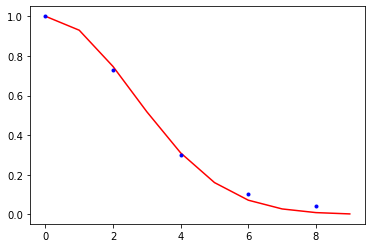

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 479
Number of inner iterations in outer iteration number 2: 223
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.26944396 65.47737204 65.4943202  65.49469757 65.49376438]
Observation contribution to cost function [94.50341328 93.88007864 93.85006921 93.84815241 93.84961836]
Model contribution to cost function  [81.50742421 81.02009815 81.03283276 81.03437026 81.03383054]
The values of the cost function total [241.28028145 240.37754884 240.37722217 240.37722024 240.37721327]
RMS between background/truth and analysis/truth [0.46933387 0.29971778]
New estimate for variance coming from assimilation window 14: 0.04634361515485439
New estimate for correlation length coming from assimilation window 14: 2.9107120513399085


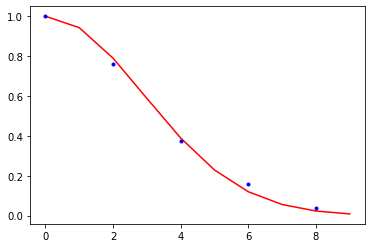

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 489
Number of inner iterations in outer iteration number 2: 250
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [101.68132135 101.46721282 101.48042979 101.47988631 101.47891057]
Observation contribution to cost function [110.87406709 110.59198258 110.57114084 110.56820691 110.56986329]
Model contribution to cost function  [118.91840509 117.34689278 117.35458074 117.35805914 117.35737035]
The values of the cost function total [331.47379352 329.40608818 329.40615137 329.40615236 329.4061442 ]
RMS between background/truth and analysis/truth [0.50718831 0.28774397]
New estimate for variance coming from assimilation window 15: 0.07280808567932731
New estimate for correlation length coming from assimilation window 15: 2.909051193702397


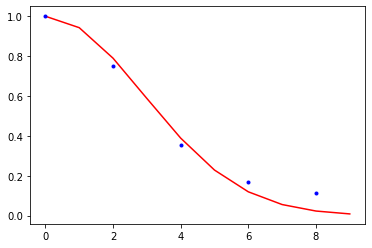

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 494
Number of inner iterations in outer iteration number 2: 237
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [81.73508544 81.44856969 81.4608089  81.45969217 81.45867985]
Observation contribution to cost function [86.35463307 85.98769996 85.9636148  85.96470963 85.96625192]
Model contribution to cost function  [116.56302626 114.17129885 114.18303481 114.18306116 114.18253339]
The values of the cost function total [284.65274477 281.6075685  281.60745851 281.60746297 281.60746515]
RMS between background/truth and analysis/truth [0.50528838 0.30925546]
New estimate for variance coming from assimilation window 16: 0.06755115275967422
New estimate for correlation length coming from assimilation window 16: 2.7183388927483936


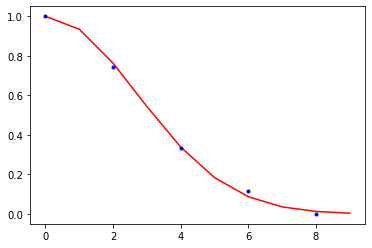

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 504
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [71.02484248 70.93647256 70.94375981 70.94299071 70.94259213]
Observation contribution to cost function [84.197621   84.23258576 84.21851978 84.21944024 84.21906386]
Model contribution to cost function  [85.69948625 84.42656798 84.43317697 84.4330259  84.43380238]
The values of the cost function total [240.92194973 239.5956263  239.59545656 239.59545685 239.59545837]
RMS between background/truth and analysis/truth [0.48254632 0.33173536]
New estimate for variance coming from assimilation window 17: 0.04534658402355347
New estimate for correlation length coming from assimilation window 17: 2.514571818482247


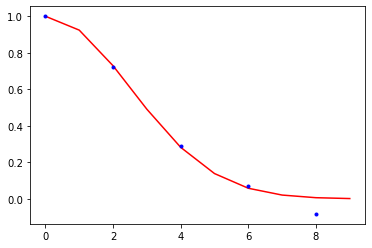

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 515
Number of inner iterations in outer iteration number 2: 245
Number of inner iterations in outer iteration number 3: 29
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [107.35011312 106.16830198 106.15573958 106.15284745 106.1512691 ]
Observation contribution to cost function [135.84440841 134.45650346 134.42809273 134.42819562 134.42973845]
Model contribution to cost function  [122.53684006 119.18463861 119.22221089 119.22494926 119.22498414]
The values of the cost function total [365.7313616  359.80944404 359.8060432  359.80599233 359.8059917 ]
RMS between background/truth and analysis/truth [0.55060781 0.37643891]
New estimate for variance coming from assimilation window 18: 0.0781095131340914
New estimate for correlation length coming from assimilation window 18: 3.054898280386001


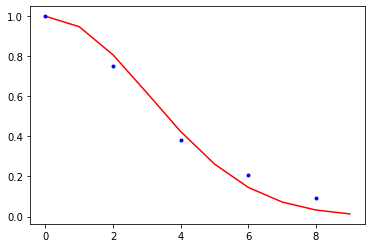

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 251
Number of inner iterations in outer iteration number 3: 49
Number of inner iterations in outer iteration number 4: 13
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [159.41144839 157.14849925 157.09477458 157.0888892  157.08827324]
Observation contribution to cost function [156.79016995 153.91930595 153.84519321 153.84114256 153.83969066]
Model contribution to cost function  [137.25577273 136.36981533 136.48248097 136.49207111 136.49411565]
The values of the cost function total [453.45739107 447.43762052 447.42244876 447.42210288 447.42207955]
RMS between background/truth and analysis/truth [0.52753086 0.41297488]
New estimate for variance coming from assimilation window 19: 0.056515913858249535
New estimate for correlation length coming from assimilation window 19: 2.081193720716655


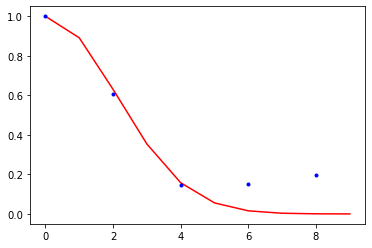

In [6]:
rd.seed(11)

win     = 20     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 3      # number of observations in time
mr      = 100    # number of observations in space
dmt     = 2      # number of temporal gridpoints between observations
dmr     = 2      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)

    
# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):
    u0 = my_Lorenz.step_rk4(u0) 
    
rep     = 10
var     = np.zeros((rep,win))
length  = np.zeros((rep,win))
meanvar = np.zeros((rep,win))
meanlen = np.zeros((rep,win))

for i in range(rep): 
    u_analysis, u_back, u_truth, var[i], length[i],  meanvar[i], meanlen[i], H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)



estimated variances [0.04251768 0.05213429 0.04750836 0.05231597 0.04303216 0.05178237
 0.04353263 0.04965219 0.05968851 0.03821203 0.06121362 0.04972766
 0.05344648 0.05612054 0.0536675  0.08042751 0.04616557 0.06385042
 0.05946231 0.0679727 ]
estimated correlation length [3.30809062 3.04689075 3.04478269 2.94623108 2.56736492 2.69831635
 2.83544802 3.11633491 3.30475079 2.41628939 3.18260026 2.68275119
 2.64441161 2.88991922 2.82908131 2.98926612 2.51751919 3.30825746
 2.49659397 2.83407594]


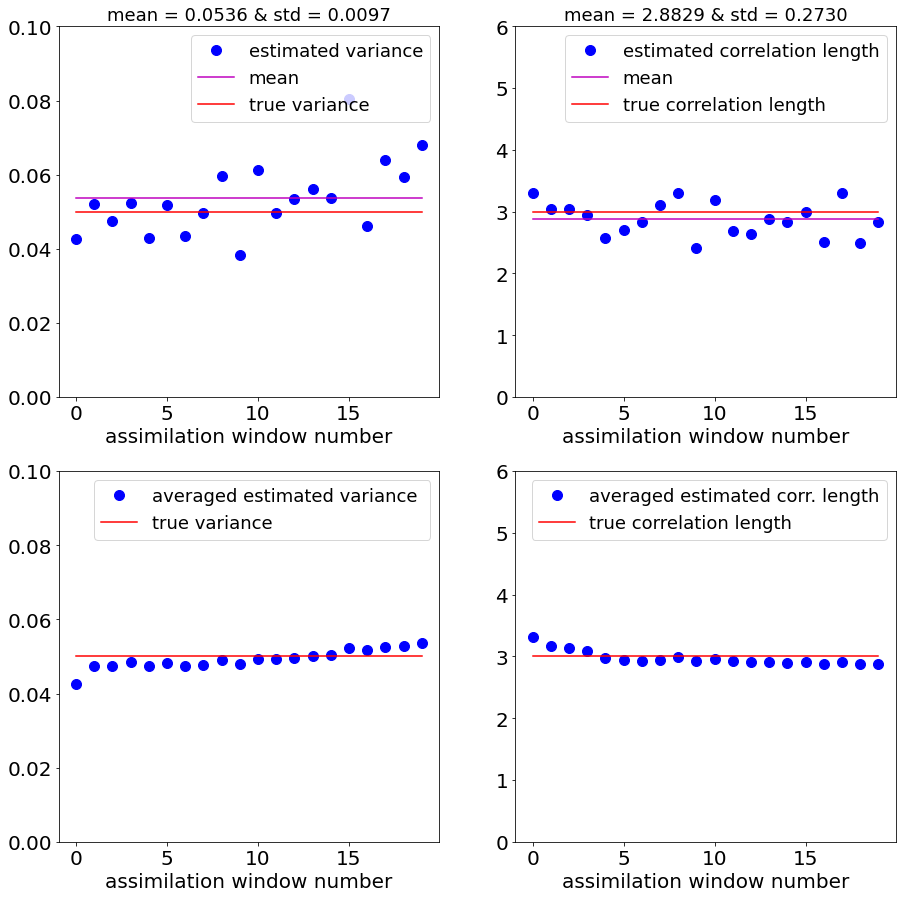

In [5]:
q_estimate_analysis(win,var[0],length[0],meanvar[0],meanlen[0],q_var_truth, l_truth)

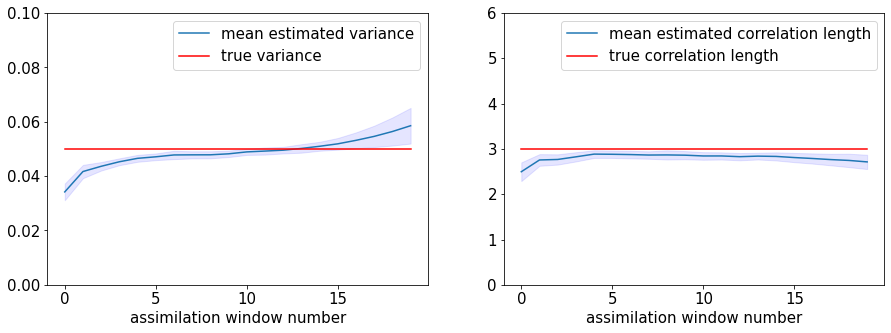

In [35]:
confidence_interval(win,rep,meanvar,meanlen,q_var_truth,l_truth)